In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
list_tissues_STY = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]

We have previously retrieved GO terms annotation from all UniprotKB proteins. We will use this data to assess whether tissue-specific phosphorylated proteins are associated with different GO-terms in comparison to non tissue-specific phosphoryalted proteins. We retrieved GO terms from 19 196 proteins.

In [3]:
Uniprot = pd.read_csv("UniprotKB_GO_human_mannually annotated.tab", sep="\t")
Uniprot.rename(columns={"Entry": "ACC_ID"}, inplace=True)
print(Uniprot.shape[0])
Uniprot.dropna(subset=["Gene ontology IDs"], inplace=True)
print(Uniprot.shape[0])
Uniprot = Uniprot[["ACC_ID", "Gene ontology IDs"]]
Uniprot.head()

20386
19196


ACC_ID                                  Gene ontology IDs
0  Q00266  GO:0000096; GO:0001887; GO:0004478; GO:0005524...
1  Q8NB16  GO:0004672; GO:0004706; GO:0005524; GO:0005634...
2  O94851  GO:0001947; GO:0003779; GO:0005634; GO:0007010...
3  Q8TDZ2  GO:0001933; GO:0003779; GO:0005737; GO:0005829...
4  Q9NPJ6  GO:0003712; GO:0003713; GO:0005634; GO:0005654...

We have also retrieved annotation from QuickGO, which allows us to easily add what the GO identifier means. QuickGO has annotation for 18 779 proteins. We summarise this information on the protein level, meaning that for a certain protein, all GO terms are present on oneline.

In [4]:
GO_annot_map = pd.read_csv("GO_annotation_map.txt", sep="\t")
GO_annot_map.rename(columns={"GO term accession": "GO_term", "UniProtKB/Swiss-Prot ID": "ACC_ID"}, inplace=True)
GO_annot_map.drop_duplicates(subset="GO_term", inplace=True)
print(GO_annot_map.shape[0])
GO_annot_map.dropna(subset=["GO_term"], inplace=True)
print(GO_annot_map.shape[0])
GO_grouped = GO_annot_map.groupby(["ACC_ID"], as_index=False)["GO_term"].apply(lambda x: ",".join(x))
GO_annot_map.head()

18780
18779


GO_term                    GO term name GO term evidence code  ACC_ID  \
0  GO:0016020                        membrane                   IEA  P03886   
1  GO:0055114     oxidation-reduction process                   IEA  P03886   
2  GO:0016021  integral component of membrane                   IEA  P03886   
3  GO:0005743    mitochondrial inner membrane                   IEA  P03886   
4  GO:0005739                   mitochondrion                   IEA  P03886   

                                  GO term definition  
0  A lipid bilayer along with all the proteins an...  
1  A metabolic process that results in the remova...  
2  The component of a membrane consisting of the ...  
3  The inner, i.e. lumen-facing, lipid bilayer of...  
4  A semiautonomous, self replicating organelle t...

In [5]:
GO_grouped.head()

ACC_ID     GO_term
0  A0A075B6N1  GO:0042105
1  A0A087WXM9  GO:0010789
2  A0A0B4J2F0  GO:1900101
3  A0A0B4J2F2  GO:0042149
4  A0A0C4DH55  GO:0019814

# 1. Combining the GO-terms with phosphosite data

We now combine the datasets containing proteins having tissue-specific phosphosites, tissue aspecific phosphosites and pervasively phosphorylated phosphosites, on one hand, with the GO terms. This results in three dataframes, for each of the three categories of phosphosites, containing both the information on the phosphosites summarised on the protein level, and the information on the GO terms from Uniprot.

Despite the high number of proteins retrieved from Uniprot, no annotation was found for 125 proteins. 104 of these have tissue-specific phosphorylation sites (180 phosphosites), 37 have tissue aspecific phosphosites (62 phosphosites), and 18 have pervasively phosphorylated sites (68 phosphosites). Adding the annotation from QuickGO did not help this loss. Considering several proteins have phosphosites in multiple categories, the numbers here don't sum up correctly.

In [6]:
tspec_sites = pd.read_csv("1.2 tissue-specific sites.tsv", sep="\t")
taspec_sites = pd.read_csv("1.2 non tissue-specific sites.tsv", sep="\t")
genP_sites = pd.read_csv("1.2 general P sites.tsv", sep="\t")

In [7]:
print(tspec_sites.shape[0])
print(tspec_sites["ACC_ID"].nunique())
tspec_sites = pd.merge(tspec_sites, Uniprot, how="left", on=["ACC_ID"])
tspec_sites = pd.merge(tspec_sites, GO_grouped, how="left", on=["ACC_ID"])
tspec_sites = tspec_sites[(tspec_sites["Gene ontology IDs"].isna()==False)|(tspec_sites["GO_term"].isna()==False)]
print(tspec_sites.shape[0])
tspec_sites.head()
proteins_tspec_sites = tspec_sites.groupby(["ACC_ID"], as_index=False).agg({"tissue": lambda x:",".join(x),
                                                                            "Adipose tissue": "max", "B-cells": "max",
                                                                            "Blood": "max", "Bone": "max", "Brain":"max",
                                                                            "Breast":"max", "Cerebrospinal fluid": "max",
                                                                            "Cervix": "max", "Colon": "max", "Dental plaque": "max",
                                                                           "Esophagus": "max", "Eye": "max", "Follicular fluid": "max",
                                                                           "Heart": "max", "Hela": "max", "Kidney": "max",
                                                                           "Liver": "max", "Lung": "max", "Lymph node": "max",
                                                                           "Menstrual fluid": "max", "Monocytes": "max",
                                                                           "Nasal polyps": "max", "NK-cells": "max", "Ovary": "max",
                                                                           "Pancreas": "max", "Palatine tonsils": "max",
                                                                            "Parotid gland": "max", "PBMC": "max",
                                                                            "Peritoneal dialysis fluid": "max", "Placenta": "max",
                                                                           "Skeletal muscle": "max", "Skin": "max",
                                                                            "Small intestine": "max", "Synovial tissue": "max",
                                                                           "T-cells": "max", "Testis": "max", "Tooth": "max",
                                                                           "Umbilical cord": "max", "Ureter": "max",
                                                                           "Urinary bladder": "max", "Urine": "max",
                                                                           "Gene ontology IDs": "first",
                                                                           "GO_term": "first"})
print(proteins_tspec_sites["ACC_ID"].nunique())
proteins_tspec_sites

14019
4977
13839
4874


ACC_ID                                             tissue  \
0     A0A075B6H7                                               Lung   
1     A0A075B6S5                                    Menstrual fluid   
2     A0A087WXM9                                             Testis   
3     A0A0B4J2D5                                          PBMC,PBMC   
4     A0A0B4J2D9                                  Blood,Blood,Blood   
...          ...                                                ...   
4869      Q9Y6X4                       Lymph node,Blood,Blood,Blood   
4870      Q9Y6X8  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...   
4871      Q9Y6X9                                        Blood,Colon   
4872      Q9Y6Y0  Lymph node,Lymph node,Colon,Colon,Colon,Colon,...   
4873      Q9Y6Y8  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...   

      Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
0                  0        0      0     0      0       0   
1                  0        0      0     0      0       0   
2                  0        0      0     0      0       0   
3                  0        0      0     0      0       0   
4                  0        0      1     0      0       0   
...              ...      ...    ...   ...    ...     ...   
4869               0        0      1     0      0       0   
4870               0        0      0     0      0       0   
4871               0        0      1     0      0       0   
4872               0        0      0     0      0       0   
4873               0        0      0     0      0       0   

      Cerebrospinal fluid  Cervix  ...  Synovial tissue  T-cells  Testis  \
0                       0       0  ...                0        0       0   
1                       0       0  ...                0        0       0   
2                       0       0  ...                0        0       1   
3                       0       0  ...                0        0       0   
4                       0       0  ...                0        0       0   
...                   ...     ...  ...              ...      ...     ...   
4869                    0       0  ...                0        0       0   
4870                    0       0  ...                0        0       0   
4871                    0       0  ...                0        0       0   
4872                    0       0  ...                0        0       0   
4873                    0       0  ...                0        0       0   

      Tooth  Umbilical cord  Ureter  Urinary bladder  Urine  \
0         0               0       0                0      0   
1         0               0       0                0      0   
2         0               0       0                0      0   
3         0               0       0                0      0   
4         0               0       0                0      0   
...     ...             ...     ...              ...    ...   
4869      0               0       0                0      0   
4870      0               0       0                0      0   
4871      0               0       0                0      0   
4872      0               0       0                0      0   
4873      0               0       0                0      0   

                                      Gene ontology IDs     GO_term  
0     GO:0002250; GO:0005615; GO:0005886; GO:0006955...        None  
1     GO:0002250; GO:0005615; GO:0005886; GO:0006955...        None  
2     GO:0000777; GO:0000779; GO:0007060; GO:0010789...  GO:0010789  
3                                            GO:0005739        None  
4     GO:0002250; GO:0005615; GO:0005886; GO:0006955...        None  
...                                                 ...         ...  
4869                                         GO:0005637        None  
4870  GO:0000122; GO:0000785; GO:0000981; GO:0003677...        None  
4871  GO:0000287; GO:0000792; GO:0003682; GO:0005524...        None  
4872  GO:0005654; GO:0005667; GO:0005681; GO:0005829..

In [8]:
print(taspec_sites.shape[0])
print(taspec_sites["ACC_ID"].nunique())
taspec_sites = pd.merge(taspec_sites, Uniprot, how="left", on=["ACC_ID"])
taspec_sites = pd.merge(taspec_sites, GO_grouped, how="left", on=["ACC_ID"])
taspec_sites = taspec_sites[(taspec_sites["Gene ontology IDs"].isna()==False)|(taspec_sites["GO_term"].isna()==False)]
print(taspec_sites.shape[0])
taspec_sites.head()
proteins_taspec_sites = taspec_sites.groupby(["ACC_ID"], as_index=False).agg({"tissue": lambda x:",".join(x),
                                                                            "Adipose tissue": "max", "B-cells": "max",
                                                                            "Blood": "max", "Bone": "max", "Brain":"max",
                                                                            "Breast":"max", "Cerebrospinal fluid": "max",
                                                                            "Cervix": "max", "Colon": "max", "Dental plaque": "max",
                                                                           "Esophagus": "max", "Eye": "max", "Follicular fluid": "max",
                                                                           "Heart": "max", "Hela": "max", "Kidney": "max",
                                                                           "Liver": "max", "Lung": "max", "Lymph node": "max",
                                                                           "Menstrual fluid": "max", "Monocytes": "max",
                                                                           "Nasal polyps": "max", "NK-cells": "max", "Ovary": "max",
                                                                           "Pancreas": "max", "Palatine tonsils": "max",
                                                                            "Parotid gland": "max", "PBMC": "max",
                                                                            "Peritoneal dialysis fluid": "max", "Placenta": "max",
                                                                           "Skeletal muscle": "max", "Skin": "max",
                                                                            "Small intestine": "max", "Synovial tissue": "max",
                                                                           "T-cells": "max", "Testis": "max", "Tooth": "max",
                                                                           "Umbilical cord": "max", "Ureter": "max",
                                                                           "Urinary bladder": "max", "Urine": "max",
                                                                            "Gene ontology IDs": "first",
                                                                           "GO_term": "first"})
print(proteins_taspec_sites["ACC_ID"].nunique())
proteins_taspec_sites

6478
2718
6416
2681


ACC_ID                                             tissue  \
0     A0A0C4DH36                                   Lung,Blood,Blood   
1         A0AVK6  Blood,Colon,Colon,Colon,Colon,Colon,Blood,Bloo...   
2         A0FGR8  Liver,Liver,Liver,Liver,Blood,Testis,Lymph nod...   
3         A0JLT2  Blood,Blood,Colon,Colon,Colon,Colon,Colon,Colo...   
4         A0M8Q6  Nasal polyps, Palatine tonsils, Parotid gland,...   
...          ...                                                ...   
2676      Q9Y6N7  Blood,Blood,Lung,Lung,Lung,Lung,Lung,Lymph nod...   
2677      Q9Y6Q9  Blood,Blood,Blood,Blood,Blood,Blood,Blood,Colo...   
2678      Q9Y6R1  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...   
2679      Q9Y6R9                                       Brain,Testis   
2680      Q9Y6X9  Umbilical cord,Umbilical cord,Blood,Blood,Lung...   

      Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
0                  0        0      1     0      0       0   
1                  0        0      1     0      0       0   
2                  0        0      1     0      0       0   
3                  0        0      1     0      0       0   
4                  0        0      0     0      0       0   
...              ...      ...    ...   ...    ...     ...   
2676               0        0      1     0      0       0   
2677               0        0      1     0      0       0   
2678               0        0      0     0      1       0   
2679               0        0      0     0      1       0   
2680               0        0      1     0      0       0   

      Cerebrospinal fluid  Cervix  ...  Synovial tissue  T-cells  Testis  \
0                       0       0  ...                0        0       0   
1                       0       0  ...                0        0       0   
2                       0       0  ...                0        0       1   
3                       0       0  ...                0        0       0   
4                       0       0  ...                0        0       0   
...                   ...     ...  ...              ...      ...     ...   
2676                    0       0  ...                0        0       0   
2677                    0       0  ...                0        0       1   
2678                    0       0  ...                0        0       0   
2679                    0       0  ...                0        0       1   
2680                    0       0  ...                0        0       0   

      Tooth  Umbilical cord  Ureter  Urinary bladder  Urine  \
0         0               0       0                0      0   
1         0               0       0                0      0   
2         0               0       0                0      0   
3         0               0       0                0      0   
4         0               0       0                0      0   
...     ...             ...     ...              ...    ...   
2676      0               0       0                0      0   
2677      0               0       0                0      0   
2678      0               0       0                0      0   
2679      0               0       0                0      0   
2680      0               1       0                0      0   

                                      Gene ontology IDs  \
0     GO:0003823; GO:0006910; GO:0006911; GO:0006958...   
1     GO:0000122; GO:0000785; GO:0000978; GO:0000981...   
2     GO:0005509; GO:0005544; GO:0005789; GO:0005887...   
3        GO:0003712; GO:0008134; GO:0016592; GO:0045944   
4     GO:0002862; GO:0003823; GO:0005576; GO:0005886...   
...                                                 ...   
2676  GO:0002042; GO:0003148; GO:0003180; GO:0003184...   
2677  GO:0000785; GO:0000993; GO:0003713; GO:0004402...   
2678  GO:0005452; GO:0005886; GO:0005887; GO:0006814...   
2679  GO:0005737; GO:0005813; GO:0005815; GO:0008017...   
2680  GO:0000287; GO:0000792; GO:0003682; GO:0005524...   

                                             

In [9]:
print(genP_sites.shape[0])
print(genP_sites["ACC_ID"].nunique())
genP_sites = pd.merge(genP_sites, Uniprot, how="left", on=["ACC_ID"])
genP_sites = pd.merge(genP_sites, GO_grouped, how="left", on=["ACC_ID"])
genP_sites = genP_sites[(genP_sites["Gene ontology IDs"].isna()==False)|(genP_sites["GO_term"].isna()==False)]
print(genP_sites.shape[0])
genP_sites.head()
proteins_genP_sites = genP_sites.groupby(["ACC_ID"], as_index=False).agg({"tissue": lambda x:",".join(x),
                                                                            "Adipose tissue": "max", "B-cells": "max",
                                                                            "Blood": "max", "Bone": "max", "Brain":"max",
                                                                            "Breast":"max", "Cerebrospinal fluid": "max",
                                                                            "Cervix": "max", "Colon": "max", "Dental plaque": "max",
                                                                           "Esophagus": "max", "Eye": "max", "Follicular fluid": "max",
                                                                           "Heart": "max", "Hela": "max", "Kidney": "max",
                                                                           "Liver": "max", "Lung": "max", "Lymph node": "max",
                                                                           "Menstrual fluid": "max", "Monocytes": "max",
                                                                           "Nasal polyps": "max", "NK-cells": "max", "Ovary": "max",
                                                                           "Pancreas": "max", "Palatine tonsils": "max",
                                                                            "Parotid gland": "max", "PBMC": "max",
                                                                            "Peritoneal dialysis fluid": "max", "Placenta": "max",
                                                                           "Skeletal muscle": "max", "Skin": "max",
                                                                            "Small intestine": "max", "Synovial tissue": "max",
                                                                           "T-cells": "max", "Testis": "max", "Tooth": "max",
                                                                           "Umbilical cord": "max", "Ureter": "max",
                                                                           "Urinary bladder": "max", "Urine": "max",
                                                                            "Gene ontology IDs": "first",
                                                                           "GO_term": "first"})
print(proteins_genP_sites["ACC_ID"].nunique())
proteins_genP_sites

3406
1368
3380
1350


ACC_ID                                             tissue  \
0     A0A0C4DH39  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
1         A0JNW5  Blood,Blood,Blood,Blood, Cerebrospinal fluid, ...   
2         A2RU30  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
3         A5A3E0  Skin,Colon,Colon,Colon,Colon,Colon,Colon,Colon...   
4         A5PKW4  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
...          ...                                                ...   
1345      Q9Y6R1  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
1346      Q9Y6T7  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
1347      Q9Y6V0  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
1348      Q9Y6X4  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
1349      Q9Y6Y0  Urinary bladder, Colon, Kidney, Liver,Colon,Ly...   

      Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
0                  0        0      1     0      1       0   
1                  0        0      1     0      1       0   
2                  0        0      1     0      1       0   
3                  1        0      1     0      1       1   
4                  0        0      1     0      1       0   
...              ...      ...    ...   ...    ...     ...   
1345               0        0      1     0      1       0   
1346               0        0      1     0      1       0   
1347               0        0      1     0      1       0   
1348               0        0      1     0      1       0   
1349               0        0      0     0      0       0   

      Cerebrospinal fluid  Cervix  ...  Synovial tissue  T-cells  Testis  \
0                       1       0  ...                0        0       0   
1                       1       0  ...                0        0       0   
2                       1       0  ...                0        0       0   
3                       1       0  ...                0        0       1   
4                       1       0  ...                0        0       0   
...                   ...     ...  ...              ...      ...     ...   
1345                    1       0  ...                0        0       0   
1346                    1       0  ...                0        0       0   
1347                    1       0  ...                0        0       0   
1348                    1       0  ...                0        0       0   
1349                    0       0  ...                0        0       0   

      Tooth  Umbilical cord  Ureter  Urinary bladder  Urine  \
0         0               0       0                0      0   
1         0               0       0                0      0   
2         0               0       0                0      0   
3         0               1       0                1      0   
4         0               0       0                0      0   
...     ...             ...     ...              ...    ...   
1345      0               0       0                0      0   
1346      0               0       0                0      0   
1347      0               0       0                0      0   
1348      0               0       0                0      0   
1349      0               0       0                1      0   

                                      Gene ontology IDs                GO_term  
0     GO:0003823; GO:0006910; GO:0006911; GO:0006958...                   None  
1        GO:0005769; GO:0005829; GO:0042803; GO:0062069             GO:0062069  
2     GO:0005102; GO:0005737; GO:0005789; GO:0008180...             GO:0010387  
3     GO:0001895; GO:0005615; GO:0005938; GO:0070062...                   None  
4     GO:0005085; GO:0005543; GO:0007165; GO:0031175...             GO:0098999  
...                                                 ...                    ...  
1345  GO:0005452; GO:0005886; GO:0005887; GO:0006814...                   None  
1346  GO:0003951; GO:0004143; GO:0005509; GO:0005524...                   None  
1347  GO:0005509; GO:0005

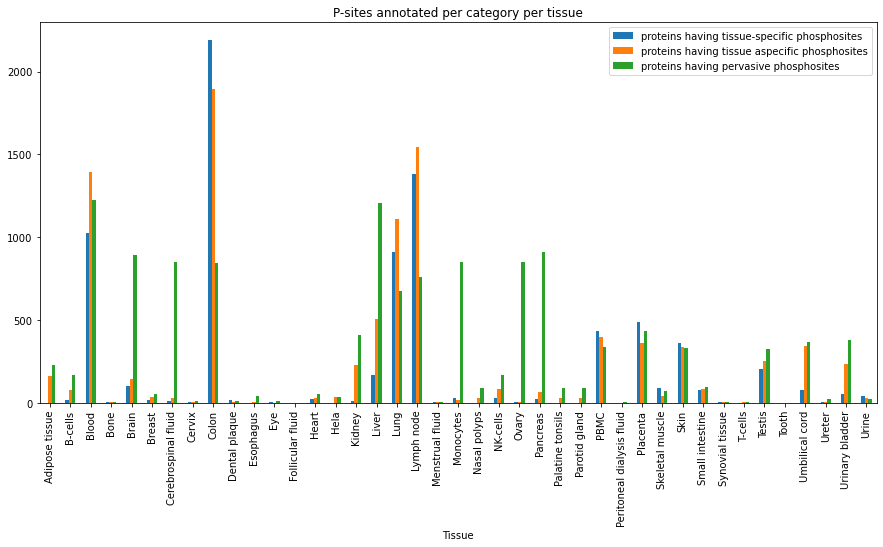

In [11]:
list_tspec = []
list_nontspec = []
list_genP = []
distribution = pd.DataFrame({"Tissue": list_tissues_STY})

for tissue in list_tissues_STY:
    count_missing_tspec = proteins_tspec_sites.loc[proteins_tspec_sites[tissue]==1, "ACC_ID"].nunique()
    count_missing_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites[tissue]==1, "ACC_ID"].nunique()
    count_missing_genP = proteins_genP_sites.loc[proteins_genP_sites[tissue]==1, "ACC_ID"].nunique()
    list_tspec.append(count_missing_tspec)
    list_nontspec.append(count_missing_nontspec)
    list_genP.append(count_missing_genP)

distribution["proteins having tissue-specific phosphosites"] = list_tspec
distribution["proteins having tissue aspecific phosphosites"] = list_nontspec
distribution["proteins having pervasive phosphosites"] = list_genP
distribution[["Tissue", "proteins having tissue-specific phosphosites", "proteins having tissue aspecific phosphosites", "proteins having pervasive phosphosites"]].plot(x="Tissue", kind="bar", figsize=(15,7)).set(title="P-sites annotated per category per tissue")
#plt.savefig("WP2 GO_phosphosite_distr.png", format="png", bbox_inches="tight")

In [10]:
data_protein = pd.read_csv("protein_data", sep="\t")
print(data_protein.shape[0])
data_protein_GO1 = pd.merge(data_protein, Uniprot, how = "inner", on=["ACC_ID"])
data_protein_GO = pd.merge(data_protein_GO1, GO_grouped, how="left", on=["ACC_ID"])
print(data_protein_GO.shape[0])
data_protein_GO.head()
#we loose 125 proteins due to lack of annotation -> the sum of the loss of the seperate categories

5855
5730


ACC_ID  Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
0  A0A075B6H7               0        0      0     0      0       0   
1  A0A075B6S5               0        0      0     0      0       0   
2  A0A087WXM9               0        0      0     0      0       0   
3  A0A0B4J2D5               0        0      0     0      0       0   
4  A0A0B4J2D9               0        0      1     0      0       0   

   Cerebrospinal fluid  Cervix  Colon  ...  T-cells  Testis  Tooth  \
0                    0       0      0  ...        0       0      0   
1                    0       0      0  ...        0       0      0   
2                    0       0      0  ...        0       1      0   
3                    0       0      0  ...        0       0      0   
4                    0       0      0  ...        0       0      0   

   Umbilical cord  Ureter  Urinary bladder  Urine  Total  \
0               0       0                0      0      1   
1               0       0                0      0      1   
2               0       0                0      0      1   
3               0       0                0      0      1   
4               0       0                0      0      1   

                                   Gene ontology IDs     GO_term  
0  GO:0002250; GO:0005615; GO:0005886; GO:0006955...         NaN  
1  GO:0002250; GO:0005615; GO:0005886; GO:0006955...         NaN  
2  GO:0000777; GO:0000779; GO:0007060; GO:0010789...  GO:0010789  
3                                         GO:0005739         NaN  
4  GO:0002250; GO:0005615; GO:0005886; GO:0006955...         NaN  

[5 rows x 45 columns]

In [11]:
missing_tspec = pd.read_csv("1.2 tissue-specific sites.tsv", sep="\t")
missing_taspec = pd.read_csv("1.2 non tissue-specific sites.tsv", sep="\t")
missing_genP = pd.read_csv("1.2 general P sites.tsv", sep="\t")

In [12]:
missing_tspec = pd.merge(missing_tspec, proteins_tspec_sites, how="outer", on=["ACC_ID"], indicator=True, suffixes=["", "_y"])
missing_tspec = missing_tspec[missing_tspec["_merge"]=="left_only"]
missing_tspec.drop(["Gene ontology IDs",
                  "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_tspec.drop([tissue+"_y"], axis=1, inplace=True)
#missing_tspec.drop(["Total_y"], axis=1, inplace=True)
missing_tspec = missing_tspec.groupby(["ACC_ID"], as_index=False).agg({"tissue": lambda x:",".join(x),
                                                                      "Adipose tissue": "max", "B-cells": "max",
                                                                            "Blood": "max", "Bone": "max", "Brain":"max",
                                                                            "Breast":"max", "Cerebrospinal fluid": "max",
                                                                            "Cervix": "max", "Colon": "max", "Dental plaque": "max",
                                                                           "Esophagus": "max", "Eye": "max", "Follicular fluid": "max",
                                                                           "Heart": "max", "Hela": "max", "Kidney": "max",
                                                                           "Liver": "max", "Lung": "max", "Lymph node": "max",
                                                                           "Menstrual fluid": "max", "Monocytes": "max",
                                                                           "Nasal polyps": "max", "NK-cells": "max", "Ovary": "max",
                                                                           "Pancreas": "max", "Palatine tonsils": "max",
                                                                            "Parotid gland": "max", "PBMC": "max",
                                                                            "Peritoneal dialysis fluid": "max", "Placenta": "max",
                                                                           "Skeletal muscle": "max", "Skin": "max",
                                                                            "Small intestine": "max", "Synovial tissue": "max",
                                                                           "T-cells": "max", "Testis": "max", "Tooth": "max",
                                                                           "Umbilical cord": "max", "Ureter": "max",
                                                                           "Urinary bladder": "max", "Urine": "max",})
missing_tspec

ACC_ID                                             tissue  \
0    A0A0U1RRK4                                             Testis   
1    A0A1B0GTD5                                        Blood,Blood   
2        A1L170  Lymph node,Colon,Colon,Colon,Colon,Colon,Colon...   
3        A1L429                                     Lung,Lung,Lung   
4        A2A3L6                                              Colon   
..          ...                                                ...   
98       Q9ULK2                                         Lymph node   
99       Q9Y2D5  Lymph node,Lymph node,Lymph node,Lymph node,Ly...   
100      Q9Y2E4                                               PBMC   
101      Q9Y2H5  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...   
102      Q9Y5U2                                         Blood,Lung   

     Adipose tissue  B-cells  Blood  Bone  Brain  Breast  Cerebrospinal fluid  \
0                 0        0      0     0      0       0                    0   
1                 0        0      1     0      0       0                    0   
2                 0        0      1     0      0       0                    0   
3                 0        0      0     0      0       0                    0   
4                 0        0      0     0      0       0                    0   
..              ...      ...    ...   ...    ...     ...                  ...   
98                0        0      0     0      0       0                    0   
99                0        0      0     0      0       0                    0   
100               0        0      0     0      0       0                    0   
101               0        0      0     0      0       0                    0   
102               0        0      1     0      0       0                    0   

     Cervix  ...  Skin  Small intestine  Synovial tissue  T-cells  Testis  \
0         0  ...     0                0                0        0       1   
1         0  ...     0                0                0        0       0   
2         0  ...     0                0                0        0       0   
3         0  ...     0                0                0        0       0   
4         0  ...     0                0                0        0       0   
..      ...  ...   ...              ...              ...      ...     ...   
98        0  ...     0                0                0        0       0   
99        0  ...     0                0                0        0       0   
100       0  ...     0                0                0        0       0   
101       0  ...     0                0                0        0       0   
102       0  ...     0                0                0        0       0   

     Tooth  Umbilical cord  Ureter  Urinary bladder  Urine  
0        0               0       0                0      0  
1        0               0       0                0      0  
2        0               0       0                0      0  
3        0               0       0                0      0  
4        0               0       0                0      0  
..     ...             ...     ...              ...    ...  
98       0               0       0                0      0  
99       0               0       0                0      0  
100      0               0       0                0      0  
101      0               0       0                0      0  
102      0               0       0                0      0  

[103 rows x 43 columns]

In [13]:
missing_taspec = pd.merge(missing_taspec, proteins_taspec_sites, how="outer", on=["ACC_ID"], indicator=True, suffixes=["", "_y"])
missing_taspec = missing_taspec[missing_taspec["_merge"]=="left_only"]
missing_taspec.drop(["Gene ontology IDs",
                  "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_taspec.drop([tissue+"_y"], axis=1, inplace=True)
#missing_tspec.drop(["Total_y"], axis=1, inplace=True)
missing_taspec = missing_taspec.groupby(["ACC_ID"], as_index=False).agg({"tissue": lambda x:",".join(x),
                                                                            "Adipose tissue": "max", "B-cells": "max",
                                                                            "Blood": "max", "Bone": "max", "Brain":"max",
                                                                            "Breast":"max", "Cerebrospinal fluid": "max",
                                                                            "Cervix": "max", "Colon": "max", "Dental plaque": "max",
                                                                           "Esophagus": "max", "Eye": "max", "Follicular fluid": "max",
                                                                           "Heart": "max", "Hela": "max", "Kidney": "max",
                                                                           "Liver": "max", "Lung": "max", "Lymph node": "max",
                                                                           "Menstrual fluid": "max", "Monocytes": "max",
                                                                           "Nasal polyps": "max", "NK-cells": "max", "Ovary": "max",
                                                                           "Pancreas": "max", "Palatine tonsils": "max",
                                                                            "Parotid gland": "max", "PBMC": "max",
                                                                            "Peritoneal dialysis fluid": "max", "Placenta": "max",
                                                                           "Skeletal muscle": "max", "Skin": "max",
                                                                            "Small intestine": "max", "Synovial tissue": "max",
                                                                           "T-cells": "max", "Testis": "max", "Tooth": "max",
                                                                           "Umbilical cord": "max", "Ureter": "max",
                                                                           "Urinary bladder": "max", "Urine": "max",
                                                                            })
missing_taspec

ACC_ID                                             tissue  Adipose tissue  \
0   A5YM69  Liver,Colon,Colon,Colon,Colon,Colon,Colon,Colo...               0   
1   A6NCF6              Urinary bladder, Colon, Kidney, Liver               0   
2   A8MT19  Blood,Lung,Lung,Lung,Lung,Blood,Blood,Blood,Bl...               0   
3   A8MU93                            Colon,Colon,Colon,Brain               0   
4   O00193  Blood,Blood,Blood,Blood,Blood,Blood,Blood,Bloo...               0   
5   O94819  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...               0   
6   O94854             Lung,Lung,Lymph node,Blood,Colon,Colon               0   
7   P04745  Nasal polyps, Palatine tonsils, Parotid gland,...               0   
8   P43358                               Lung,Lung,Lymph node               0   
9   P78312  Blood,Colon,Blood,Colon,Blood,Blood,Colon,Bloo...               0   
10  Q2KHR3  Colon,Lymph node,Colon,Colon,Colon,Colon,Colon...               0   
11  Q53LP3            Lung,Colon,Colon,Colon,Colon,Colon,Lung               0   
12  Q5SRD0  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...               0   
13  Q5VYV7                             Colon,Colon,Colon,Lung               0   
14  Q6ICG6  Colon,Lymph node,Lymph node,Blood,Colon,Colon,...               0   
15  Q6P1L5  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...               0   
16  Q6P1R3                                   Colon,Colon,Lung               0   
17  Q6PID6  Liver,Blood,Blood,Blood,Blood,Lung,Colon,Colon...               0   
18  Q6ZSR9  Liver,Liver,Blood,Blood,Blood,Blood,Blood,Colo...               0   
19  Q6ZTU2  Blood,Blood,Lung,Lymph node,Lymph node,Lymph n...               0   
20  Q7Z422  Colon,NK-cells,Lymph node,Lymph node,Blood,Blo...               1   
21  Q7Z7L8  Testis,Lymph node,Lymph node,Lymph node,Lymph ...               0   
22  Q86WR7  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...               0   
23  Q86XN7  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...               0   
24  Q8IV50  Lung,Lung,Lymph node,Lymph node,Lymph node,Lym...               0   
25  Q8IXQ4  Blood,Blood,Blood,Blood,Blood,Blood,Blood,Bloo...               0   
26  Q8N5I9  Blood,Blood,Blood,Blood,Blood,Blood,Colon,Colo...               0   
27  Q8N9L7                             Colon,Colon,Lymph node               0   
28  Q96AT1  Colon,Colon,NK-cells,NK-cells,Lymph node,Lymph...               0   
29  Q96K17                                         Liver,Skin               0   
30  Q9BTY7  Colon,Colon,Colon,Colon,Colon,Colon,Lymph node...               0   
31  Q9BY89  Lung,Lung,Lung,Lung,Colon,Colon,Colon,Colon,Co...               0   
32  Q9H246  Blood,Blood,Blood,Blood,Blood,Blood,Blood,Bloo...               0   
33  Q9H4I3                                        Colon,Liver               0   
34  Q9NW68  Colon,Colon,Colon,Colon,Colon,Lymph node,Lymph...               0   
35  Q9Y2D5  Umbilical cord,Lymph node,Liver,Liver,Umbilica...               0   
36  Q9Y5U2                                  Blood,Blood,Colon               0   

    B-cells  Blood  Bone  Brain  Breast  Cerebrospinal fluid  Cervix  ...  \
0         0      0     0      0       0                    0       0  ...   
1         0      0     0      0       0                    0       0  ...   
2         0      1     0      0       0                    0       0  ...   
3         0      0     0      1       0                    0       0  ...   
4         0      1     0      0       0                    0       0  ...   
5         0      0     0      1       0                    0       0  ...   
6         0      1     0      0       0                    0       0  ...   
7         0      0     0      0       0                    0       0  ...   
8         0      0     0      0       0                    0       0  ...   
9         0      1     0      0       0                    0       0  ...   
10        0      0     0      0       0                    0       0  ...   
1

In [14]:
missing_genP = pd.merge(missing_genP, proteins_genP_sites, how="outer", on=["ACC_ID"], indicator=True, suffixes=["", "_y"])
missing_genP = missing_genP[missing_genP["_merge"]=="left_only"]
missing_genP.drop(["Gene ontology IDs",
                  "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_genP.drop([tissue+"_y"], axis=1, inplace=True)
#missing_tspec.drop(["Total_y"], axis=1, inplace=True)
missing_genP = missing_genP.groupby(["ACC_ID"], as_index=False).agg({"tissue": lambda x:",".join(x),
                                                                            "Adipose tissue": "max", "B-cells": "max",
                                                                            "Blood": "max", "Bone": "max", "Brain":"max",
                                                                            "Breast":"max", "Cerebrospinal fluid": "max",
                                                                            "Cervix": "max", "Colon": "max", "Dental plaque": "max",
                                                                           "Esophagus": "max", "Eye": "max", "Follicular fluid": "max",
                                                                           "Heart": "max", "Hela": "max", "Kidney": "max",
                                                                           "Liver": "max", "Lung": "max", "Lymph node": "max",
                                                                           "Menstrual fluid": "max", "Monocytes": "max",
                                                                           "Nasal polyps": "max", "NK-cells": "max", "Ovary": "max",
                                                                           "Pancreas": "max", "Palatine tonsils": "max",
                                                                            "Parotid gland": "max", "PBMC": "max",
                                                                            "Peritoneal dialysis fluid": "max", "Placenta": "max",
                                                                           "Skeletal muscle": "max", "Skin": "max",
                                                                            "Small intestine": "max", "Synovial tissue": "max",
                                                                           "T-cells": "max", "Testis": "max", "Tooth": "max",
                                                                           "Umbilical cord": "max", "Ureter": "max",
                                                                           "Urinary bladder": "max", "Urine": "max",
                                                                            })
missing_genP

ACC_ID                                             tissue  Adipose tissue  \
0   A6NEL2  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...               0   
1   O00193  Liver,Liver,Liver,PBMC,PBMC,Lymph node,Umbilic...               0   
2   O94819  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
3   Q14687  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
4   Q3MHD2  Liver,Adipose tissue, Umbilical cord,Adipose t...               1   
5   Q5U5X8  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
6   Q69YU3  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
7   Q6ICG6  Colon,Blood, Cerebrospinal fluid, Liver, Ovary...               0   
8   Q6P1L5  Colon,Colon,Colon,Lung,Blood, Cerebrospinal fl...               0   
9   Q8IXR9  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
10  Q8IZU2  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
11  Q8TF21  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
12  Q96S19  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
13  Q9BVG4  Liver,Liver,Blood,Colon,Colon,Colon,Colon,Colo...               0   
14  Q9BY89  Colon,Colon,Colon,Colon,Colon,Blood, Cerebrosp...               0   
15  Q9NQR7  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...               0   
16  Q9Y2D5  Liver,Liver,Liver,Liver,Umbilical cord,Umbilic...               1   
17  Q9Y2H5  Liver,Liver,Liver,Liver,Liver,Colon,Colon,Colo...               0   

    B-cells  Blood  Bone  Brain  Breast  Cerebrospinal fluid  Cervix  ...  \
0         0      1     0      1       0                    1       0  ...   
1         1      1     0      1       0                    1       0  ...   
2         0      1     0      1       0                    1       0  ...   
3         0      1     0      1       0                    1       0  ...   
4         0      0     0      0       0                    0       0  ...   
5         0      1     0      1       0                    1       0  ...   
6         0      1     0      1       0                    1       0  ...   
7         0      1     0      1       0                    1       0  ...   
8         0      1     0      1       0                    1       0  ...   
9         0      1     0      1       0                    1       0  ...   
10        0      1     0      1       0                    1       0  ...   
11        0      1     0      1       0                    1       0  ...   
12        0      1     0      1       0                    1       0  ...   
13        0      1     0      1       0                    1       0  ...   
14        0      1     0      1       0                    1       0  ...   
15        0      1     0      1       0                    1       0  ...   
16        1      1     0      0       0                    0       0  ...   
17        0      1     0      1       0                    1       0  ...   

    Skin  Small intestine  Synovial tissue  T-cells  Testis  Tooth  \
0      0                0                0        0       0      0   
1      1                0                0        0       0      0   
2      0                0                0        0       0      0   
3      0                0                0        0       0      0   
4      0                0                0        0       0      0   
5      0                0                0        0       0      0   
6      0                0                0        0       0      0   
7      0                0                0        0       0      0   
8      0                0                0        0       0      0   
9      0                0                0        0       0      0   
10     0                0                0        0       0      0   
11     0                0                0        0       0      0   
12     0                0                0        0       0      0   
13     0            

We add the amount of missing proteins, per tissue, per category, to the dataframe that contains the number of proteins in each of the three categories. The loss of proteins seems to be spreadin accordance to the number of proteins identified as being tissue-specific, tissue aspecific and pervasively phosphorylated proteins.

In [15]:
list_missing_tspec = []
list_missing_taspec = []
list_missing_genP = []
list_all_tspec = []
list_all_genP = []
for tissue in list_tissues_STY:
    count_missing_tspec = missing_tspec[tissue].sum()
    count_missing_taspec = missing_taspec[tissue].sum()
    count_missing_genP = missing_genP[tissue].sum()
    list_missing_tspec.append(count_missing_tspec)
    list_missing_taspec.append(count_missing_taspec)
    list_missing_genP.append(count_missing_genP)
missing = pd.read_csv("number of three categories per tissue.tsv", sep="\t")
missing["missing proteins having tissue-specific phosphosites"] = list_missing_tspec
missing["missing proteins having tissue aspecific phosphosites"] = list_missing_taspec
missing["missing proteins having pervasively phosphorylated sites"] = list_missing_genP

<AxesSubplot:title={'center':'Number of proteins having no GO-terms having any of the three types of phosphosites'}, xlabel='Tissue'>

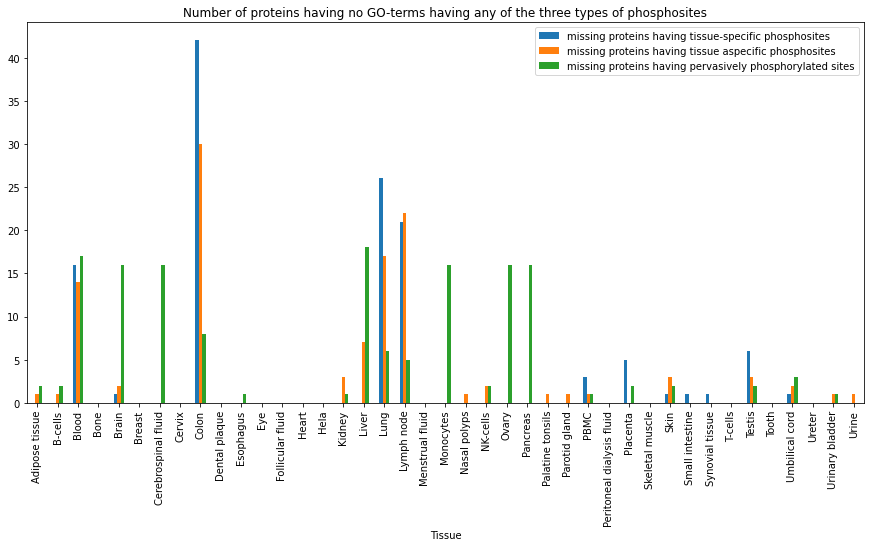

In [16]:
missing[["Tissue", "missing proteins having tissue-specific phosphosites", "missing proteins having tissue aspecific phosphosites", "missing proteins having pervasively phosphorylated sites"]].plot(x="Tissue", kind="bar", figsize=(15,7), title = "Number of proteins having no GO-terms having any of the three types of phosphosites")

In [17]:
missing

Tissue  number of tissue-specific proteins  \
0              Adipose tissue                                   0   
1                     B-cells                                   4   
2                       Blood                                 241   
3                        Bone                                   1   
4                       Brain                                  19   
5                      Breast                                   3   
6         Cerebrospinal fluid                                   1   
7                      Cervix                                   4   
8                       Colon                                 632   
9               Dental plaque                                   6   
10                  Esophagus                                   0   
11                        Eye                                   1   
12           Follicular fluid                                   0   
13                      Heart                                   3   
14                       Hela                                   0   
15                     Kidney                                   3   
16                      Liver                                  40   
17                       Lung                                 228   
18                 Lymph node                                 336   
19            Menstrual fluid                                   1   
20                  Monocytes                                   9   
21               Nasal polyps                                   0   
22                   NK-cells                                   5   
23                      Ovary                                   1   
24                   Pancreas                                  11   
25           Palatine tonsils                                   0   
26              Parotid gland                                   0   
27                       PBMC                                  95   
28  Peritoneal dialysis fluid                                   0   
29                   Placenta                                 131   
30            Skeletal muscle                                  33   
31                       Skin                                  91   
32            Small intestine                                  22   
33            Synovial tissue                                   2   
34                    T-cells                                   0   
35                     Testis                                  66   
36                      Tooth                                   0   
37             Umbilical cord                                  12   
38                     Ureter                                   1   
39            Urinary bladder                                   6   
40                      Urine                                  21   

    number of non tissue-specific proteins  \
0                                       39   
1                                       27   
2                                      966   
3                                        1   
4                                       56   
5                                       10   
6                                       11   
7                                        3   
8                                     1391   
9                                        3   
10                                       2   
11                                       1   
12                                       1   
13                                      15   
14                                      15   
15                                      84   
16                                     197   
17                                     717   
18                                    1113   
19                                       1   
20                                      11   
21                                      12   
22                                      27   
23                  

In [18]:
list_GO = data_protein_GO["Gene ontology IDs"].to_list()
print(list_GO[0:3])
split_list_GO=[]
for all_GO in list_GO:
    all_GO = str(all_GO)
    if ";" in all_GO:
        list_GO_sub = all_GO.split("; ")
        for GO in list_GO_sub:
            split_list_GO.append(GO)
    else:
        split_list_GO.append(all_GO)

uni_list_GO = []
split_list_GO_sorted = sorted(split_list_GO)
for i in range(len(split_list_GO_sorted)):
    if i == 0:
        uni_list_GO.append(split_list_GO_sorted[i])
    else:
        if split_list_GO_sorted[i-1] != split_list_GO_sorted[i]:
            uni_list_GO.append(split_list_GO_sorted[i])

['GO:0002250; GO:0005615; GO:0005886; GO:0006955; GO:0019814', 'GO:0002250; GO:0005615; GO:0005886; GO:0006955; GO:0019814', 'GO:0000777; GO:0000779; GO:0007060; GO:0010789; GO:0016321; GO:0045143; GO:0051754']


In [19]:
print(len(uni_list_GO))

12557


In [20]:
list_quick = GO_annot_map["GO_term"].to_list()
split_list_GO = []
for all_GO in list_quick:
    all_GO = str(all_GO)
    if ";" in all_GO:
        list_GO_sub = all_GO.split("; ")
        for GO in list_GO_sub:
            split_list_GO.append(GO)
    else:
        split_list_GO.append(all_GO)

uni_list_quick = []
split_list_GO_sorted = sorted(split_list_GO)
for i in range(len(split_list_GO_sorted)):
    if split_list_GO_sorted[i] not in uni_list_GO:
        if len(uni_list_quick)==0:
            uni_list_quick.append(split_list_GO_sorted[i])
        else:
            if uni_list_quick[-1]!=split_list_GO_sorted[i]:
                uni_list_quick.append(split_list_GO_sorted[i])

In [21]:
print(len(uni_list_quick))

6236


In [22]:
uni_list_all = []
for GO in uni_list_GO:
    uni_list_all.append(GO)
for GO in uni_list_quick:
    uni_list_all.append(GO)
uni_list_all = sorted(uni_list_all)

In [23]:
print(len(uni_list_all))

18793


In [24]:
list_GO_tspec = proteins_tspec_sites["Gene ontology IDs"].to_list()
print(list_GO_tspec[0:3])
split_list_GO_tspec=[]
for all_GO in list_GO_tspec:
    all_GO = str(all_GO)
    if ";" in all_GO:
        list_GO_sub_tspec = all_GO.split("; ")
        for GO in list_GO_sub_tspec:
            split_list_GO_tspec.append(GO)
    else:
        split_list_GO_tspec.append(all_GO)
uni_list_GO_tspec = []
split_list_GO_sorted_tspec = sorted(split_list_GO_tspec)
for i in range(len(split_list_GO_sorted_tspec)):
    if i == 0:
        uni_list_GO_tspec.append(split_list_GO_sorted_tspec[i])
    else:
        if split_list_GO_sorted_tspec[i-1] != split_list_GO_sorted_tspec[i]:
            uni_list_GO_tspec.append(split_list_GO_sorted_tspec[i])
print(len(uni_list_GO_tspec))

['GO:0002250; GO:0005615; GO:0005886; GO:0006955; GO:0019814', 'GO:0002250; GO:0005615; GO:0005886; GO:0006955; GO:0019814', 'GO:0000777; GO:0000779; GO:0007060; GO:0010789; GO:0016321; GO:0045143; GO:0051754']
11597


In [25]:
print(len(split_list_GO_tspec))

93602


In [26]:
list_GO_taspec = proteins_taspec_sites["Gene ontology IDs"].to_list()
print(list_GO_taspec[0:3])
split_list_GO_taspec=[]
for all_GO in list_GO_taspec:
    all_GO = str(all_GO)
    if ";" in all_GO:
        list_GO_sub_taspec = all_GO.split("; ")
        for GO in list_GO_sub_taspec:
            split_list_GO_taspec.append(GO)
    else:
        split_list_GO_taspec.append(all_GO)
uni_list_GO_taspec = []
split_list_GO_sorted_taspec = sorted(split_list_GO_taspec)
for i in range(len(split_list_GO_sorted_taspec)):
    if i == 0:
        uni_list_GO_taspec.append(split_list_GO_sorted_taspec[i])
    else:
        if split_list_GO_sorted_taspec[i-1] != split_list_GO_sorted_taspec[i]:
            uni_list_GO_taspec.append(split_list_GO_sorted_taspec[i])
print(len(uni_list_GO_taspec))

['GO:0003823; GO:0006910; GO:0006911; GO:0006958; GO:0009897; GO:0034987; GO:0042571; GO:0042742; GO:0045087; GO:0050853; GO:0050871', 'GO:0000122; GO:0000785; GO:0000978; GO:0000981; GO:0000987; GO:0001217; GO:0001227; GO:0001890; GO:0002040; GO:0003700; GO:0005654; GO:0005730; GO:0005829; GO:0006357; GO:0006977; GO:0008283; GO:0032466; GO:0032877; GO:0033301; GO:0042802; GO:0045944; GO:0060707; GO:0060718; GO:0070365; GO:0090575; GO:1990837', 'GO:0005509; GO:0005544; GO:0005789; GO:0005887; GO:0006687; GO:0006869; GO:0006897; GO:0008429; GO:0016020; GO:0031210; GO:0031227; GO:0031234; GO:0035091; GO:0042802; GO:0044232; GO:0045296; GO:0061817; GO:0140268']
9026


Before removing duplicates from the list of GO terms, there are 54 618 GO terms. After removing duplicates only 9026 pointing towards a high amount of returning GO terms.

In [27]:
print(len(split_list_GO_taspec))

54618


In [28]:
list_GO_gen = proteins_genP_sites["Gene ontology IDs"].to_list()
print(list_GO_gen[0:3])
split_list_GO_gen=[]
for all_GO in list_GO_gen:
    all_GO = str(all_GO)
    if ";" in all_GO:
        list_GO_sub_gen = all_GO.split("; ")
        for GO in list_GO_sub_gen:
            split_list_GO_gen.append(GO)
    else:
        split_list_GO_gen.append(all_GO)
uni_list_GO_gen = []
split_list_GO_sorted_gen = sorted(split_list_GO_gen)
for i in range(len(split_list_GO_sorted_gen)):
    if i == 0:
        uni_list_GO_tspec.append(split_list_GO_sorted_gen[i])
    else:
        if split_list_GO_sorted_gen[i-1] != split_list_GO_sorted_gen[i]:
            uni_list_GO_gen.append(split_list_GO_sorted_gen[i])
print(len(uni_list_GO_gen))

['GO:0003823; GO:0006910; GO:0006911; GO:0006958; GO:0009897; GO:0034987; GO:0042571; GO:0042742; GO:0045087; GO:0050853; GO:0050871', 'GO:0005769; GO:0005829; GO:0042803; GO:0062069', 'GO:0005102; GO:0005737; GO:0005789; GO:0008180; GO:0010387; GO:0033089; GO:0050862']
6565


In [29]:
print(len(split_list_GO_gen))

29388


In [30]:
print(len(uni_list_GO)+len(uni_list_quick))

18793


## all GO terms

For each protein, split in accordance to the categories of the P-sites they bear, we verify whether the protein is associated with a certain GO-term (1) or not (0). We also look at the amount of GO-terms associated with a protein.

In [31]:
for GO in uni_list_GO:
    proteins_tspec_sites[GO] = proteins_tspec_sites["Gene ontology IDs"].str.contains(GO)
for GO in uni_list_quick:
    proteins_tspec_sites[GO] = proteins_tspec_sites["GO_term"].str.contains(GO)
proteins_tspec_sites["nr GO terms_all"] = proteins_tspec_sites[uni_list_GO].sum(axis=1)
proteins_tspec_sites.replace({True: 1, False:0, np.nan: 0}, inplace=True)
proteins_tspec_sites.sort_values(by="nr GO terms_all", ascending=False)

C:\Users\hannedvo\AppData\Local\Temp\97/ipykernel_7836/4001985948.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  proteins_tspec_sites[GO] = proteins_tspec_sites["Gene ontology IDs"].str.contains(GO)
C:\Users\hannedvo\AppData\Local\Temp\97/ipykernel_7836/4001985948.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  proteins_tspec_sites[GO] = proteins_tspec_sites["GO_term"].str.contains(GO)


ACC_ID                                             tissue  \
700   P04637  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...   
957   P12931  Colon,Colon,Colon,Liver,Liver,Colon,Colon,Colo...   
654   P02649                                  Blood,Blood,Blood   
3613  Q96EB6                             Lymph node,Blood,Blood   
599   P00519  Lung,Lung,Lung,Lung,Colon,Colon,Colon,Lymph no...   
...      ...                                                ...   
2289  Q15032  Blood,Blood,Blood,Blood,Blood,Blood,Blood,Bloo...   
3013  Q86X02                                      Testis,Testis   
3003  Q86VY9                                               Lung   
2998  Q86VQ1  Blood,Lymph node,Colon,Colon,Blood,Blood,Colon...   
3216  Q8N9U0  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...   

      Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
700                0        0      0     0      0       0   
957                0        0      0     0      0       0   
654                0        0      1     0      0       0   
3613               0        0      1     0      0       0   
599                0        0      0     0      0       0   
...              ...      ...    ...   ...    ...     ...   
2289               0        0      1     0      0       0   
3013               0        0      0     0      0       0   
3003               0        0      0     0      0       0   
2998               0        0      1     0      0       0   
3216               0        0      0     0      0       0   

      Cerebrospinal fluid  Cervix  ...  GO:2001252  GO:2001257  GO:2001264  \
700                     0       0  ...           0           0           0   
957                     0       0  ...           0           0           0   
654                     0       0  ...           0           0           0   
3613                    0       0  ...           0           0           0   
599                     0       0  ...           0           0           0   
...                   ...     ...  ...         ...         ...         ...   
2289                    0       0  ...           0           0           0   
3013                    0       0  ...           0           0           0   
3003                    0       0  ...           0           0           0   
2998                    0       0  ...           0           0           0   
3216                    0       0  ...           0           0           0   

      GO:2001280  GO:2001294  GO:2001301  GO:2001303  GO:2001306  GO:2001311  \
700            0           0           0           0           0           0   
957            0           0           0           0           0           0   
654            0           0           0           0           0           0   
3613           0           0           0           0           0           0   
599            0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
2289           0           0           0           0           0           0   
3013           0           0           0           0           0           0   
3003           0           0           0           0           0           0   
2998           0           0           0           0           0           0   
3216           0           0           0           0           0           0   

      nr GO terms_all  
700               178  
957               168  
654               164  
3613              152  
599               143  
...               ...  
2289                1  
3013                1  
3003                1  
2998                1  
3216                1  

[4874 rows x 18839 columns]

In [32]:
for GO in uni_list_GO:
    proteins_taspec_sites[GO] = proteins_taspec_sites["Gene ontology IDs"].str.contains(GO)
for GO in uni_list_quick:
    proteins_taspec_sites[GO] = proteins_taspec_sites["GO_term"].str.contains(GO)
proteins_taspec_sites["nr GO terms_all"] = proteins_taspec_sites[uni_list_GO].sum(axis=1)
proteins_taspec_sites.replace({True: 1, False:0, np.nan: 0}, inplace=True)
proteins_taspec_sites.sort_values(by="nr GO terms_all", ascending=False)

C:\Users\hannedvo\AppData\Local\Temp\97/ipykernel_7836/1098631704.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  proteins_taspec_sites[GO] = proteins_taspec_sites["Gene ontology IDs"].str.contains(GO)
C:\Users\hannedvo\AppData\Local\Temp\97/ipykernel_7836/1098631704.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  proteins_taspec_sites[GO] = proteins_taspec_sites["GO_term"].str.contains(GO)


ACC_ID                                             tissue  \
712   P31749  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...   
373   P04637  Liver,Blood,Colon,Colon,Colon,Colon,Colon,Colo...   
506   P12931  Liver,Colon,Lymph node,Lymph node,Lymph node,L...   
1992  Q96EB6  Blood,Blood,Blood,Blood,Blood,Blood,Blood,Bloo...   
2100  Q99497  Testis,Testis,Small intestine,Small intestine,...   
...      ...                                                ...   
1995  Q96EV2  Blood,Blood,Blood,Blood,Blood,Lung,Blood,Colon...   
1539  Q6NUJ5              Urinary bladder, Colon, Kidney, Liver   
25    C9JLR9  Nasal polyps, Palatine tonsils, Parotid gland,...   
24    C9JI98                      Blood,Colon,Colon,Colon,Colon   
1614  Q7L4I2  Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...   

      Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
712                0        0      0     0      0       0   
373                0        0      1     0      0       0   
506                0        0      0     0      0       0   
1992               0        0      1     0      0       0   
2100               0        0      0     0      0       0   
...              ...      ...    ...   ...    ...     ...   
1995               0        0      1     0      0       0   
1539               0        0      0     0      0       0   
25                 0        0      0     0      0       0   
24                 0        0      1     0      0       0   
1614               0        0      0     0      0       0   

      Cerebrospinal fluid  Cervix  ...  GO:2001252  GO:2001257  GO:2001264  \
712                     0       0  ...           0           0           0   
373                     0       0  ...           0           0           0   
506                     0       0  ...           0           0           0   
1992                    0       0  ...           0           0           0   
2100                    0       0  ...           0           0           0   
...                   ...     ...  ...         ...         ...         ...   
1995                    0       0  ...           0           0           0   
1539                    0       0  ...           0           0           0   
25                      0       0  ...           0           0           0   
24                      0       0  ...           0           0           0   
1614                    0       0  ...           0           0           0   

      GO:2001280  GO:2001294  GO:2001301  GO:2001303  GO:2001306  GO:2001311  \
712            0           0           0           0           0           0   
373            0           0           0           0           0           0   
506            0           0           0           0           0           0   
1992           0           0           0           0           0           0   
2100           0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
1995           0           0           0           0           0           0   
1539           0           0           0           0           0           0   
25             0           0           0           0           0           0   
24             0           0           0           0           0           0   
1614           0           0           0           0           0           0   

      nr GO terms_all  
712               185  
373               178  
506               168  
1992              152  
2100              145  
...               ...  
1995                1  
1539                1  
25                  1  
24                  1  
1614                1  

[2681 rows x 18839 columns]

In [33]:
for GO in uni_list_GO:
    proteins_genP_sites[GO] = proteins_genP_sites["Gene ontology IDs"].str.contains(GO)
for GO in uni_list_quick:
    proteins_genP_sites[GO] = proteins_genP_sites["GO_term"].str.contains(GO)
proteins_genP_sites["nr GO terms_all"] = proteins_genP_sites[uni_list_GO].sum(axis=1)
proteins_genP_sites.replace({True: 1, False:0, np.nan: 0}, inplace=True)
proteins_genP_sites.sort_values(by="nr GO terms_all", ascending=False)

C:\Users\hannedvo\AppData\Local\Temp\97/ipykernel_7836/3130545752.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  proteins_genP_sites[GO] = proteins_genP_sites["Gene ontology IDs"].str.contains(GO)
C:\Users\hannedvo\AppData\Local\Temp\97/ipykernel_7836/3130545752.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  proteins_genP_sites[GO] = proteins_genP_sites["GO_term"].str.contains(GO)


ACC_ID                                             tissue  \
406   P31749  Testis,Blood, Cerebrospinal fluid, Liver, Ovar...   
782   Q5S007   Urinary bladder, Colon, Kidney, Liver,Lymph node   
594   Q03135  Breast,Umbilical cord,Skin,Skin,Lung,Lung,Colo...   
159   P00533  Liver,Liver,Lung,Lung,Colon,Colon,Colon,Colon,...   
231   P07948  PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,PBMC,P...   
...      ...                                                ...   
1031  Q96EV2  Blood,Blood,Lung,Colon,Colon,Colon,Colon,Colon...   
775   Q5HYJ3  Liver,Liver,Liver,Blood,Blood,Blood,Blood,Bloo...   
826   Q6P995  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
865   Q7Z309  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   
254   P0C2L3  Blood, Cerebrospinal fluid, Liver, Ovary, Panc...   

      Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
406                0        0      1     0      1       0   
782                0        0      0     0      0       0   
594                0        0      0     0      0       1   
159                0        0      0     0      0       0   
231                0        0      1     0      0       0   
...              ...      ...    ...   ...    ...     ...   
1031               0        0      1     0      0       0   
775                0        0      1     0      0       0   
826                0        0      1     0      1       0   
865                0        0      1     0      1       0   
254                0        0      1     0      1       0   

      Cerebrospinal fluid  Cervix  ...  GO:2001252  GO:2001257  GO:2001264  \
406                     1       0  ...           0           0           0   
782                     0       0  ...           0           0           0   
594                     0       0  ...           0           0           0   
159                     0       0  ...           0           0           0   
231                     0       0  ...           0           0           0   
...                   ...     ...  ...         ...         ...         ...   
1031                    0       0  ...           0           0           0   
775                     0       0  ...           0           0           0   
826                     1       0  ...           0           0           0   
865                     1       0  ...           0           0           0   
254                     1       0  ...           0           0           0   

      GO:2001280  GO:2001294  GO:2001301  GO:2001303  GO:2001306  GO:2001311  \
406            0           0           0           0           0           0   
782            0           0           0           0           0           0   
594            0           0           0           0           0           0   
159            0           0           0           0           0           0   
231            0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
1031           0           0           0           0           0           0   
775            0           0           0           0           0           0   
826            0           0           0           0           0           0   
865            0           0           0           0           0           0   
254            0           0           0           0           0           0   

      nr GO terms_all  
406               185  
782               168  
594               141  
159               139  
231               120  
...               ...  
1031                1  
775                 1  
826                 1  
865                 1  
254                 1  

[1350 rows x 18839 columns]

<Figure size 1080x504 with 0 Axes>

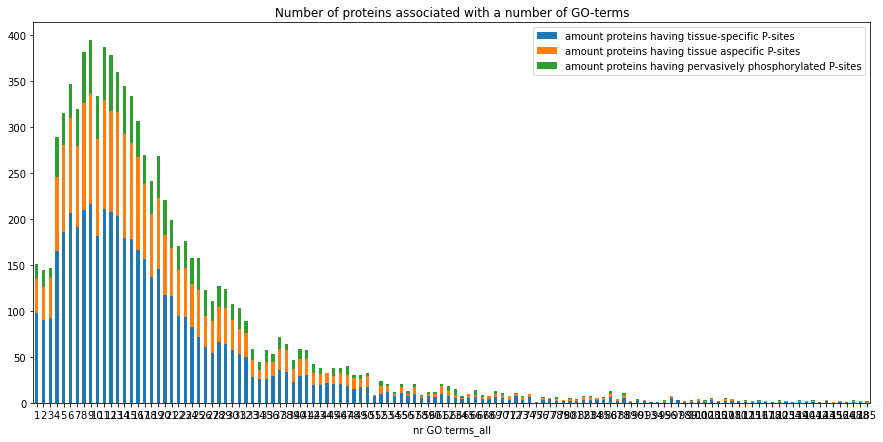

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                  1                                            98.0   
1                  2                                            90.0   
2                  3                                            92.0   
3                  4                                           165.0   
4                  5                                           186.0   
..               ...                                             ...   
118              152                                             1.0   
119              164                                             1.0   
120              168                                             1.0   
121              178                                             1.0   
123              185                                             NaN   

     amount proteins having tissue aspecific P-sites  \
0                                               37.0   
1                                               36.0   
2                                               44.0   
3                                               81.0   
4                                               94.0   
..                                               ...   
118                                              1.0   
119                                              NaN   
120                                              1.0   
121                                              1.0   
123                                              1.0   

     amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 16.0          151.0  
1                                                 19.0          145.0  
2                                                 11.0          147.0  
3                                                 43.0          289.0  
4                                                 35.0          315.0  
..                                                 ...            ...  
118                                                NaN            2.0  
119                                                NaN            1.0  
120                                                1.0            3.0  
121                                                NaN            2.0  
123                                                1.0            2.0  

[124 rows x 5 columns]

In [34]:
grouped_tspec_all = proteins_tspec_sites.groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_all = proteins_taspec_sites.groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_all = proteins_genP_sites.groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all = pd.merge(grouped_tspec_all, grouped_nontspec_all, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_all = pd.merge(grouped_all, grouped_general_all, how="outer", on=["nr GO terms_all"])
grouped_all_all.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_all.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_all.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0).set(title="Number of proteins associated with a number of GO-terms")
plt.show()
grouped_all_all["Total"] = grouped_all_all[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_all

In [35]:
for GO in uni_list_GO:
    data_protein_GO[GO] = data_protein_GO["Gene ontology IDs"].str.contains(GO)
for GO in uni_list_quick:
    data_protein_GO[GO] = data_protein_GO["GO_term"].str.contains(GO)
data_protein_GO.replace({True: 1, False:0}, inplace=True)
data_protein_GO.head()

C:\Users\hannedvo\AppData\Local\Temp\97/ipykernel_7836/1819600723.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_protein_GO[GO] = data_protein_GO["Gene ontology IDs"].str.contains(GO)
C:\Users\hannedvo\AppData\Local\Temp\97/ipykernel_7836/1819600723.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_protein_GO[GO] = data_protein_GO["GO_term"].str.contains(GO)


ACC_ID  Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
0  A0A075B6H7               0        0      0     0      0       0   
1  A0A075B6S5               0        0      0     0      0       0   
2  A0A087WXM9               0        0      0     0      0       0   
3  A0A0B4J2D5               0        0      0     0      0       0   
4  A0A0B4J2D9               0        0      1     0      0       0   

   Cerebrospinal fluid  Cervix  Colon  ...  GO:2001251  GO:2001252  \
0                    0       0      0  ...         NaN         NaN   
1                    0       0      0  ...         NaN         NaN   
2                    0       0      0  ...         0.0         0.0   
3                    0       0      0  ...         NaN         NaN   
4                    0       0      0  ...         NaN         NaN   

   GO:2001257  GO:2001264  GO:2001280  GO:2001294  GO:2001301  GO:2001303  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   GO:2001306  GO:2001311  
0         NaN         NaN  
1         NaN         NaN  
2         0.0         0.0  
3         NaN         NaN  
4         NaN         NaN  

[5 rows x 18838 columns]

In [36]:
Uniprot.shape[0]

19196

We loop over all proteins, and calculate the sum of the proteins that are associated with that GO term. This is similar to caluclating the proteins and sites in a certain tissue, as described previously. The numbers are then log transformed to scale, and the ratio of number of proteins in each of the three categories, divided by the amount of proteins in UniProtKB, per GO term. For this, we don't consider the QuickGO terms, as these are not available in Uniprot anyway.

In [37]:
dfGO_all = pd.DataFrame({"GO_term": uni_list_GO})
tspec_count = []
taspec_count = []
general_count = []
all_count = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites[GO].sum()
        tspec_count.append(count_tspec)
    else:
        tspec_count.append(0) 
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites[GO].sum()
        taspec_count.append(count_nontspec)
    else:
        taspec_count.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites[GO].sum()
        general_count.append(count_general)
    else:
        general_count.append(0)
    count_all = Uniprot["Gene ontology IDs"].str.contains(GO).sum()
    all_count.append(count_all)
dfGO_all["amount proteins having tissue-specific P-sites"] = tspec_count
dfGO_all["amount proteins having tissue aspecific P-sites"] = taspec_count
dfGO_all["amount proteins having pervasively phosphorylated P-sites"] = general_count
dfGO_all["all proteins"] = all_count
dfGO_all.head()

GO_term  amount proteins having tissue-specific P-sites  \
0  GO:0000002                                               5   
1  GO:0000003                                               1   
2  GO:0000012                                               5   
3  GO:0000014                                               3   
4  GO:0000015                                               3   

   amount proteins having tissue aspecific P-sites  \
0                                                2   
1                                                0   
2                                                2   
3                                                2   
4                                                1   

   amount proteins having pervasively phosphorylated P-sites  all proteins  
0                                                  0                    11  
1                                                  0                     4  
2                                                  1                    10  
3                                                  0                     7  
4                                                  3                     4

In [38]:
dfGO_all["log tspec"] = np.log10(dfGO_all["amount proteins having tissue-specific P-sites"]+1)
dfGO_all["log taspec"] =np.log10(dfGO_all["amount proteins having tissue aspecific P-sites"]+1)
dfGO_all["log gen P"] = np.log10(dfGO_all["amount proteins having pervasively phosphorylated P-sites"]+1)
dfGO_all["log all"] = np.log10(dfGO_all["all proteins"]+1)
dfGO_all["log all"] = -1*dfGO_all["log all"]
dfGO_all["ratio_tissue-specific_P-sites"] = dfGO_all["amount proteins having tissue-specific P-sites"]*100/dfGO_all["all proteins"]
dfGO_all["ratio_tissue aspecific_P-sites"] = dfGO_all["amount proteins having tissue aspecific P-sites"]*100/dfGO_all["all proteins"]
dfGO_all["ratio_pervasively_phosphorylated_P-sites"] = dfGO_all["amount proteins having pervasively phosphorylated P-sites"]*100/dfGO_all["all proteins"]
dfGO_all.head()

GO_term  amount proteins having tissue-specific P-sites  \
0  GO:0000002                                               5   
1  GO:0000003                                               1   
2  GO:0000012                                               5   
3  GO:0000014                                               3   
4  GO:0000015                                               3   

   amount proteins having tissue aspecific P-sites  \
0                                                2   
1                                                0   
2                                                2   
3                                                2   
4                                                1   

   amount proteins having pervasively phosphorylated P-sites  all proteins  \
0                                                  0                    11   
1                                                  0                     4   
2                                                  1                    10   
3                                                  0                     7   
4                                                  3                     4   

   log tspec  log taspec  log gen P   log all  ratio_tissue-specific_P-sites  \
0   0.778151    0.477121    0.00000 -1.079181                      45.454545   
1   0.301030    0.000000    0.00000 -0.698970                      25.000000   
2   0.778151    0.477121    0.30103 -1.041393                      50.000000   
3   0.602060    0.477121    0.00000 -0.903090                      42.857143   
4   0.602060    0.301030    0.60206 -0.698970                      75.000000   

   ratio_tissue aspecific_P-sites  ratio_pervasively_phosphorylated_P-sites  
0                       18.181818                                       0.0  
1                        0.000000                                       0.0  
2                       20.000000                                      10.0  
3                       28.571429                                       0.0  
4                       25.000000                                      75.0

In [39]:
dfGO_all[(dfGO_all["log tspec"]>1)|(dfGO_all["log taspec"]>1)|(dfGO_all["log gen P"]>1)]

GO_term  amount proteins having tissue-specific P-sites  \
9      GO:0000027                                              12   
14     GO:0000045                                              17   
16     GO:0000049                                              27   
24     GO:0000070                                              14   
26     GO:0000077                                              18   
...           ...                                             ...   
12530  GO:2001235                                              11   
12532  GO:2001237                                              17   
12533  GO:2001238                                              11   
12535  GO:2001240                                              11   
12539  GO:2001244                                              18   

       amount proteins having tissue aspecific P-sites  \
9                                                    9   
14                                                  12   
16                                                   9   
24                                                   7   
26                                                   9   
...                                                ...   
12530                                                5   
12532                                               12   
12533                                                8   
12535                                                9   
12539                                               10   

       amount proteins having pervasively phosphorylated P-sites  \
9                                                      4           
14                                                     5           
16                                                     7           
24                                                     3           
26                                                     4           
...                                                  ...           
12530                                                  3           
12532                                                  7           
12533                                                  5           
12535                                                  3           
12539                                                  6           

       all proteins  log tspec  log taspec  log gen P   log all  \
9                24   1.113943    1.000000   0.698970 -1.397940   
14               60   1.255273    1.113943   0.778151 -1.785330   
16               71   1.447158    1.000000   0.903090 -1.857332   
24               32   1.176091    0.903090   0.602060 -1.518514   
26               31   1.278754    1.000000   0.698970 -1.505150   
...             ...        ...         ...        ...       ...   
12530            21   1.079181    0.778151   0.602060 -1.342423   
12532            34   1.255273    1.113943   0.903090 -1.544068   
12533            27   1.079181    0.954243   0.778151 -1.447158   
12535            33   1.079181    1.000000   0.602060 -1.531479   
12539            38   1.278754    1.041393   0.845098 -1.591065   

       ratio_tissue-specific_P-sites  ratio_tissue aspecific_P-sites  \
9                          50.000000                       37.500000   
14                         28.333333                       20.000000   
16                         38.028169                       12.676056   
24                         43.750000                       21.875000   
26                         58.064516                       29.032258   
...                              ...                             ...   
12530                      52.380952                       23.809524   
12532                      50.000000                       35.294118   
12533                      40.740741                       29.629630   
12535                      33.333333                       27.272727   
12539                      47.368421                       26.315789  

We calculate the ratio tissue-specific proteins / UniprotKB proteins, and repeat this for the other two categories. This is roughly 10 percent. If the amount of proteins in any of the three categories exceeds this number, the GO term might be enriched.

In [40]:
print(proteins_tspec_sites.shape[0]/Uniprot.shape[0])
print(proteins_taspec_sites.shape[0]/Uniprot.shape[0])
print(proteins_genP_sites.shape[0]/Uniprot.shape[0])

0.25390706397166074
0.13966451344030006
0.07032715148989373


We now look at the distribution of the ratios and try to calculate the important descriptive statisstics. We then define the whisker as 1.5 times the InterQuartileRange (definition from statistics) to determine enriched GO terms.

<AxesSubplot:ylabel='Density'>

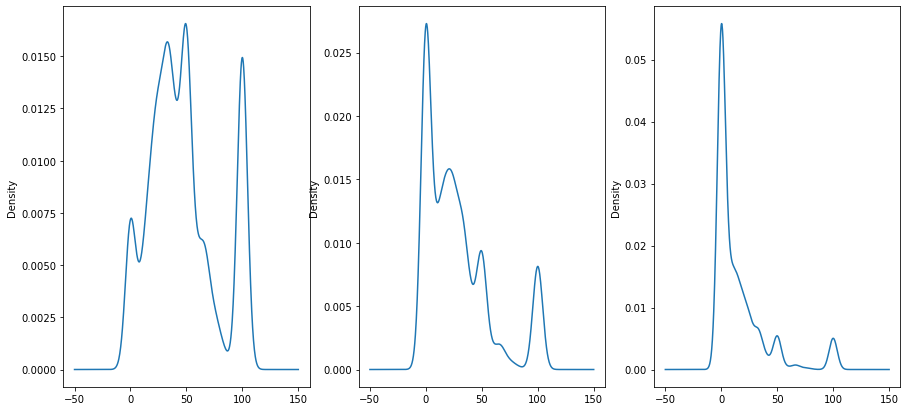

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3)

dfGO_all["ratio_tissue-specific_P-sites"].plot(x="GO_term", kind="kde", ax=axes[0], figsize=(15,7))
dfGO_all["ratio_tissue aspecific_P-sites"].plot(x="GO_term", kind="kde", ax=axes[1], figsize=(15,7))
dfGO_all["ratio_pervasively_phosphorylated_P-sites"].plot(x="GO_term", kind="kde", ax=axes[2], figsize=(15,7))

In [42]:
print(dfGO_all["ratio_tissue-specific_P-sites"].describe())
print(dfGO_all["ratio_tissue aspecific_P-sites"].describe())
print(dfGO_all["ratio_pervasively_phosphorylated_P-sites"].describe())

count    12557.000000
mean        47.043281
std         30.215006
min          0.000000
25%         25.000000
50%         42.682927
75%         66.071429
max        100.000000
Name: ratio_tissue-specific_P-sites, dtype: float64
count    12557.000000
mean        27.600299
std         29.278601
min          0.000000
25%          0.000000
50%         20.000000
75%         40.000000
max        100.000000
Name: ratio_tissue aspecific_P-sites, dtype: float64
count    12557.000000
mean        15.201533
std         23.991952
min          0.000000
25%          0.000000
50%          4.545455
75%         20.000000
max        100.000000
Name: ratio_pervasively_phosphorylated_P-sites, dtype: float64


In [43]:
whisker_tspec = 1.5*(66.071429-25.000000) #IQR = third quartile - first quartile
print(whisker_tspec)
whisker_nontspec = 1.5*40 # the first quartile is zero -> the IQR equals the third quartile
print(whisker_nontspec)
whisker_gen = 1.5*20 # the first quartile is zero -> the IQR equals the third quartile
print(whisker_gen)

61.60714349999999
60.0
30.0


We now select our outliers to plot later on. Also, we require that at least 10 proteins should be associated with the GO term in any of the thrree categories.

In [44]:
dfGO_all_plot = dfGO_all[(((dfGO_all["ratio_tissue-specific_P-sites"]>=(whisker_tspec+5))&(dfGO_all["amount proteins having tissue-specific P-sites"]>=20))|
                          ((dfGO_all["ratio_tissue aspecific_P-sites"]>=(whisker_nontspec+5))&(dfGO_all["amount proteins having tissue aspecific P-sites"]>=15))|
                          ((dfGO_all["ratio_pervasively_phosphorylated_P-sites"]>=(whisker_gen+5))&(dfGO_all["amount proteins having pervasively phosphorylated P-sites"]>=15)))
                         
                        ]

dfGO_all_plot

GO_term  amount proteins having tissue-specific P-sites  \
50     GO:0000146                                              23   
76     GO:0000226                                              76   
199    GO:0000786                                              51   
201    GO:0000792                                              31   
375    GO:0001725                                              40   
376    GO:0001726                                              64   
410    GO:0001784                                              31   
568    GO:0002102                                              22   
1426   GO:0005200                                              71   
1766   GO:0006096                                              21   
2559   GO:0008307                                              29   
3150   GO:0014704                                              20   
3412   GO:0016070                                              29   
3519   GO:0016459                                              24   
4014   GO:0021762                                              23   
4105   GO:0022627                                              29   
4445   GO:0030864                                              29   
4447   GO:0030866                                              20   
4589   GO:0031252                                              33   
4908   GO:0032212                                              24   
5703   GO:0035023                                              21   
6284   GO:0042169                                              29   
6525   GO:0043044                                              28   
7046   GO:0045296                                             217   
7124   GO:0045648                                              20   
7158   GO:0045727                                              49   
7598   GO:0048041                                              20   
7614   GO:0048156                                              26   
7801   GO:0048786                                              15   
8054   GO:0051056                                              92   
8219   GO:0051493                                              20   
8326   GO:0051893                                              17   
8367   GO:0051973                                              24   
9235   GO:0070527                                              25   
9686   GO:0071889                                              23   
9834   GO:0072562                                              96   
10057  GO:0090307                                              29   
10885  GO:1900034                                              52   
11756  GO:1904837                                              20   
12271  GO:2000300                                              14   

       amount proteins having tissue aspecific P-sites  \
50                                                   7   
76                                                  56   
199                                                 28   
201                                                 22   
375                                                 33   
376                                                 37   
410                                                 17   
568                                                 17   
1426                                                58   
1766                                                15   
2559                                                15   
3150                                                16   
3412                                                26   
3519                                                11   
4014                                                22   
4105                                                21   
4445                                                22   
4447                                                18   
4589                                                21   
4908                

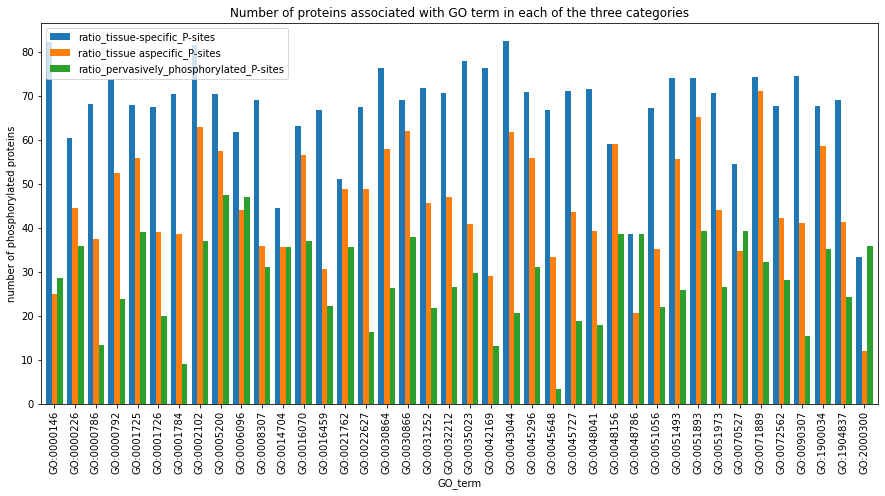

In [45]:
dfGO_all_plot[["GO_term", "ratio_tissue-specific_P-sites", "ratio_tissue aspecific_P-sites", "ratio_pervasively_phosphorylated_P-sites"]].plot(x="GO_term", kind="bar", width=0.8,figsize=(15,7), title="Number of proteins associated with GO term in each of the three categories", ylabel="number of phosphorylated proteins")
#plt.xticks([])
#plt.savefig("WP2 GO_phosphosites.png", format="png", bbox_inches="tight")

In [45]:
GO_annot_map_sub = GO_annot_map[["GO_term", "GO term name", "GO term definition"]]
GO_annot_map_sub.drop_duplicates(subset="GO_term", inplace=True)
print(dfGO_all_plot.shape[0])
dfGO_all_plot_annot = pd.merge(dfGO_all_plot, GO_annot_map_sub, how="left", on=["GO_term"])
print(dfGO_all_plot_annot.shape[0])
dfGO_all_plot_annot.shape[0]

40
40


C:\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


40

In [46]:
dfGO_all_plot_annot

GO_term  amount proteins having tissue-specific P-sites  \
0   GO:0000146                                              23   
1   GO:0000226                                              76   
2   GO:0000786                                              51   
3   GO:0000792                                              31   
4   GO:0001725                                              40   
5   GO:0001726                                              64   
6   GO:0001784                                              31   
7   GO:0002102                                              22   
8   GO:0005200                                              71   
9   GO:0006096                                              21   
10  GO:0008307                                              29   
11  GO:0014704                                              20   
12  GO:0016070                                              29   
13  GO:0016459                                              24   
14  GO:0021762                                              23   
15  GO:0022627                                              29   
16  GO:0030864                                              29   
17  GO:0030866                                              20   
18  GO:0031252                                              33   
19  GO:0032212                                              24   
20  GO:0035023                                              21   
21  GO:0042169                                              29   
22  GO:0043044                                              28   
23  GO:0045296                                             217   
24  GO:0045648                                              20   
25  GO:0045727                                              49   
26  GO:0048041                                              20   
27  GO:0048156                                              26   
28  GO:0048786                                              15   
29  GO:0051056                                              92   
30  GO:0051493                                              20   
31  GO:0051893                                              17   
32  GO:0051973                                              24   
33  GO:0070527                                              25   
34  GO:0071889                                              23   
35  GO:0072562                                              96   
36  GO:0090307                                              29   
37  GO:1900034                                              52   
38  GO:1904837                                              20   
39  GO:2000300                                              14   

    amount proteins having tissue aspecific P-sites  \
0                                                 7   
1                                                56   
2                                                28   
3                                                22   
4                                                33   
5                                                37   
6                                                17   
7                                                17   
8                                                58   
9                                                15   
10                                               15   
11                                               16   
12                                               26   
13                                               11   
14                                               22   
15                                               21   
16                                               22   
17                                               18   
18                                               21   
19                                               16   
20                                               11   
21                                               11   
22                                 

In [43]:
GO_annot_map_sub = GO_annot_map[["GO_term", "GO term name", "GO term definition"]]
GO_annot_map_sub.drop_duplicates(subset="GO_term", inplace=True)
print(dfGO_all.shape[0])
dfGO_all_sub = dfGO_all[(dfGO_all["amount proteins having tissue-specific P-sites"]!=0)|(dfGO_all["amount proteins having tissue aspecific P-sites"]!=0)
       |(dfGO_all["amount proteins having pervasively phosphorylated P-sites"]!=0)]
print(dfGO_all_sub.shape[0])
df_GO_all_annot = pd.merge(dfGO_all_sub, GO_annot_map_sub, how="left", on=["GO_term"])
df_GO_all_annot

12557
12557


C:\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


GO_term  amount proteins having tissue-specific P-sites  \
0      GO:0000002                                               5   
1      GO:0000003                                               1   
2      GO:0000012                                               5   
3      GO:0000014                                               3   
4      GO:0000015                                               3   
...           ...                                             ...   
12552  GO:2001286                                               1   
12553  GO:2001287                                               1   
12554  GO:2001288                                               3   
12555  GO:2001295                                               1   
12556  GO:2001302                                               0   

       amount proteins having tissue aspecific P-sites  \
0                                                    2   
1                                                    0   
2                                                    2   
3                                                    2   
4                                                    1   
...                                                ...   
12552                                                1   
12553                                                1   
12554                                                2   
12555                                                1   
12556                                                1   

       amount proteins having pervasively phosphorylated P-sites  \
0                                                      0           
1                                                      0           
2                                                      1           
3                                                      0           
4                                                      3           
...                                                  ...           
12552                                                  0           
12553                                                  0           
12554                                                  2           
12555                                                  0           
12556                                                  0           

       all proteins  log tspec  log taspec  log gen P   log all  \
0                11   0.778151    0.477121   0.000000 -1.079181   
1                 4   0.301030    0.000000   0.000000 -0.698970   
2                10   0.778151    0.477121   0.301030 -1.041393   
3                 7   0.602060    0.477121   0.000000 -0.903090   
4                 4   0.602060    0.301030   0.602060 -0.698970   
...             ...        ...         ...        ...       ...   
12552             1   0.301030    0.301030   0.000000 -0.301030   
12553             2   0.301030    0.301030   0.000000 -0.477121   
12554             4   0.602060    0.477121   0.477121 -0.698970   
12555             2   0.301030    0.301030   0.000000 -0.477121   
12556             1   0.000000    0.301030   0.000000 -0.301030   

       ratio_tissue-specific_P-sites  ratio_tissue aspecific_P-sites  \
0                          45.454545                       18.181818   
1                          25.000000                        0.000000   
2                          50.000000                       20.000000   
3                          42.857143                       28.571429   
4                          75.000000                       25.000000   
...                              ...                             ...   
12552                     100.000000                      100.000000   
12553                      50.000000                       50.000000   
12554                      75.000000                       50.000000   
12555                      50.000000                       50.000000   
12556                       0.000000                      100.000000  

In [44]:
df_GO_all_annot[["amount proteins having tissue-specific P-sites", "amount proteins having tissue aspecific P-sites", 
       "amount proteins having pervasively phosphorylated P-sites", "GO term name", "GO term definition"]].to_csv("sites_Uniprot_GO terms and number of three categories of proteins", sep="\t", index=False)
#all proteins = nr proteins associated with GO terms for all proteins in UniProt

### looking at Colon

We now repeat the same analysis for all of the tissues seperately, as well as for all tissues exculding colon.

In [34]:
df_count_all_tspec_colon = []
df_count_all_nontspec_colon = []
df_count_all_general_colon = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Colon"]==1, GO].sum()
        df_count_all_tspec_colon.append(count_tspec)
    else:
        df_count_all_tspec_colon.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_tspec_sites["Colon"]==1, GO].sum()
        df_count_all_nontspec_colon.append(count_nontspec)
    else:
         df_count_all_nontspec_colon.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_tspec_sites["Colon"]==1, GO].sum()
        df_count_all_general_colon.append(count_general)
    else:
        df_count_all_general_colon.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Colon"]==1, GO].sum()
    df_count_all_tspec_colon.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_tspec_sites["Colon"]==1, GO].sum()
    df_count_all_nontspec_colon.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_tspec_sites["Colon"]==1, GO].sum()
    df_count_all_general_colon.append(count_general)
df_count_all_colon = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_colon2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_colon = df_count_all_colon.append(df_count_all_colon2, ignore_index=True)
df_count_all_colon["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_colon
df_count_all_colon["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_colon
df_count_all_colon["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_colon

<Figure size 1080x504 with 0 Axes>

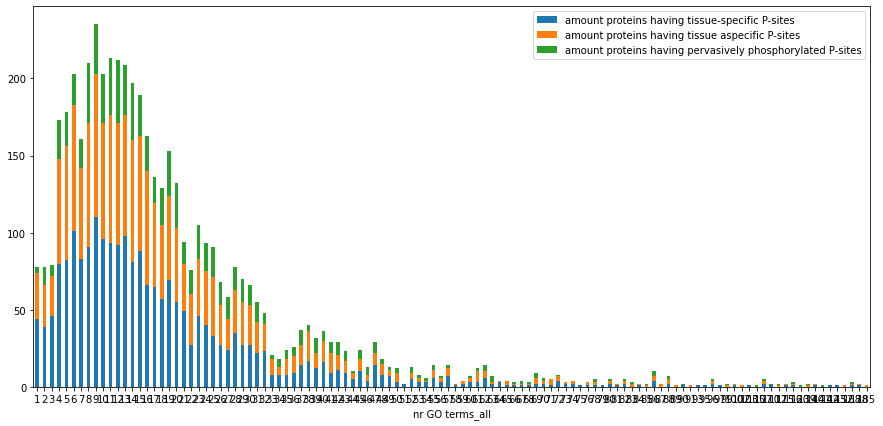

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                  1                                            44.0   
1                  2                                            39.0   
2                  3                                            46.0   
3                  4                                            80.0   
4                  5                                            82.0   
..               ...                                             ...   
97               143                                             1.0   
109              152                                             NaN   
98               168                                             1.0   
99               178                                             1.0   
110              185                                             NaN   

     amount proteins having tissue aspecific P-sites  \
0                                               30.0   
1                                               27.0   
2                                               26.0   
3                                               68.0   
4                                               74.0   
..                                               ...   
97                                               NaN   
109                                              1.0   
98                                               1.0   
99                                               1.0   
110                                              1.0   

     amount proteins having pervasively phosphorylated P-sites  Total  
0                                                  4.0           78.0  
1                                                 12.0           78.0  
2                                                  7.0           79.0  
3                                                 25.0          173.0  
4                                                 22.0          178.0  
..                                                 ...            ...  
97                                                 NaN            1.0  
109                                                NaN            1.0  
98                                                 1.0            3.0  
99                                                 NaN            2.0  
110                                                NaN            1.0  

[114 rows x 5 columns]

In [35]:
grouped_tspec_colon = proteins_tspec_sites.loc[proteins_tspec_sites["Colon"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_colon = proteins_taspec_sites.loc[proteins_taspec_sites["Colon"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_colon = proteins_genP_sites.loc[proteins_genP_sites["Colon"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_colon = pd.merge(grouped_tspec_colon, grouped_nontspec_colon, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_colon = pd.merge(grouped_all_colon, grouped_general_colon, how="outer", on=["nr GO terms_all"])
grouped_all_colon.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_colon.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_colon.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_colon["Total"] = grouped_all_colon[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_colon

([], [])

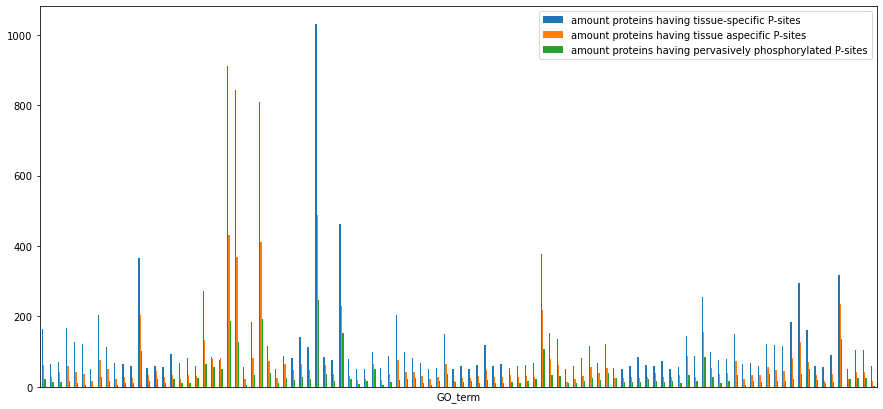

In [36]:
df_count_all_colon[(df_count_all_colon["amount proteins having tissue-specific P-sites"]>=50)|(df_count_all_colon["amount proteins having tissue aspecific P-sites"]>=50)
       |(df_count_all_colon["amount proteins having pervasively phosphorylated P-sites"]>=50)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])

## looking at all other tissues

In [37]:
df_count_all_tspec_noncolon = []
df_count_all_nontspec_noncolon = []
df_count_all_general_noncolon = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Colon"]==0, GO].sum()
        df_count_all_tspec_noncolon.append(count_tspec)
    else:
        df_count_all_tspec_noncolon.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Colon"]==0, GO].sum()
        df_count_all_nontspec_noncolon.append(count_nontspec)
    else:
         df_count_all_nontspec_noncolon.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Colon"]==0, GO].sum()
        df_count_all_general_noncolon.append(count_general)
    else:
        df_count_all_general_noncolon.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Colon"]==0, GO].sum()
    df_count_all_tspec_noncolon.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Colon"]==0, GO].sum()
    df_count_all_nontspec_noncolon.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Colon"]==0, GO].sum()
    df_count_all_general_noncolon.append(count_general)
df_count_all_noncolon = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_noncolon2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_noncolon = df_count_all_noncolon.append(df_count_all_noncolon2, ignore_index=True)
df_count_all_noncolon["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_noncolon
df_count_all_noncolon["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_noncolon
df_count_all_noncolon["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_noncolon

In [38]:
print(data_protein.shape[0]) #number of unique proteins
print(data_protein[data_protein["Colon"]==1].shape[0]) #number of proteins seen at least in Colon
print(data_protein[data_protein["Colon"]==0].shape[0]) #number of proteins not seen in Colon

5855
3297
2558


Despite the fact that the majority of the proteins has been seen at least once in Colon, the proteins not seen in Colon carry more tissue-specific phosphosites.

<Figure size 1080x504 with 0 Axes>

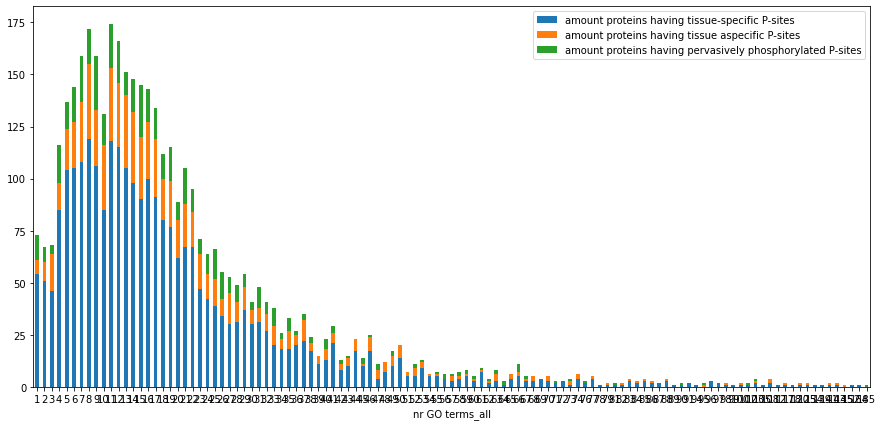

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                  1                                            54.0   
1                  2                                            51.0   
2                  3                                            46.0   
3                  4                                            85.0   
4                  5                                           104.0   
..               ...                                             ...   
107              143                                             1.0   
111              145                                             NaN   
108              152                                             1.0   
109              164                                             1.0   
112              185                                             NaN   

     amount proteins having tissue aspecific P-sites  \
0                                                7.0   
1                                                9.0   
2                                               18.0   
3                                               13.0   
4                                               20.0   
..                                               ...   
107                                              1.0   
111                                              1.0   
108                                              NaN   
109                                              NaN   
112                                              NaN   

     amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 12.0           73.0  
1                                                  7.0           67.0  
2                                                  4.0           68.0  
3                                                 18.0          116.0  
4                                                 13.0          137.0  
..                                                 ...            ...  
107                                                NaN            2.0  
111                                                NaN            1.0  
108                                                NaN            1.0  
109                                                NaN            1.0  
112                                                1.0            1.0  

[113 rows x 5 columns]

In [39]:
grouped_tspec_noncolon = proteins_tspec_sites.loc[proteins_tspec_sites["Colon"]==0, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_noncolon = proteins_taspec_sites.loc[proteins_taspec_sites["Colon"]==0, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_noncolon = proteins_genP_sites.loc[proteins_genP_sites["Colon"]==0, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_noncolon = pd.merge(grouped_tspec_noncolon, grouped_nontspec_noncolon, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_noncolon = pd.merge(grouped_all_noncolon, grouped_general_noncolon, how="outer", on=["nr GO terms_all"])
grouped_all_noncolon.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_noncolon.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_noncolon.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_noncolon["Total"] = grouped_all_noncolon[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_noncolon

([], [])

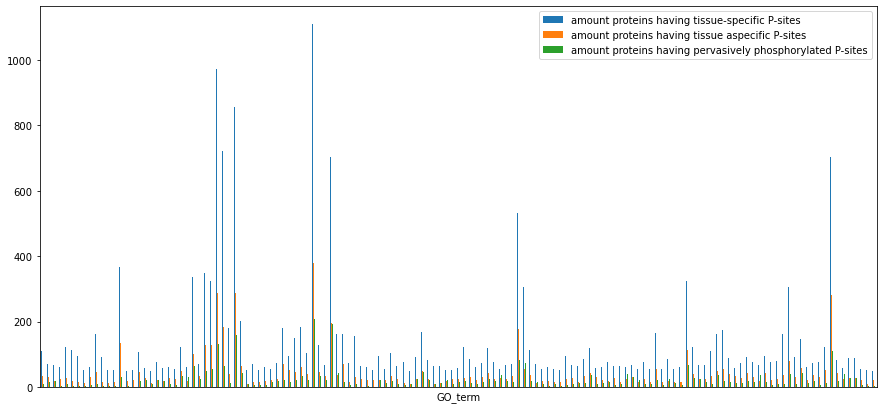

In [40]:
df_count_all_noncolon[(df_count_all_noncolon["amount proteins having tissue-specific P-sites"]>=50)|(df_count_all_noncolon["amount proteins having tissue aspecific P-sites"]>=50)
       |(df_count_all_noncolon["amount proteins having pervasively phosphorylated P-sites"]>=50)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])

### Adipose tissue

350


<Figure size 1080x504 with 0 Axes>

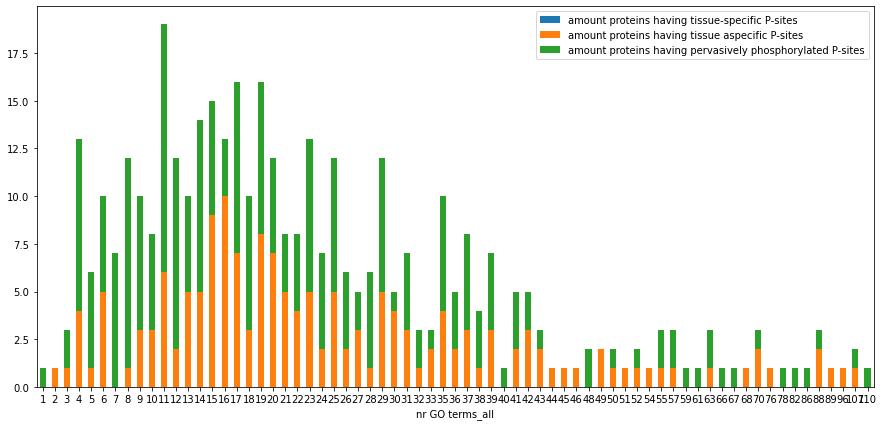

amount proteins having tissue-specific P-sites  nr GO terms_all  \
57                                             NaN                1   
0                                              NaN                2   
1                                              NaN                3   
2                                              NaN                4   
3                                              NaN                5   
..                                             ...              ...   
53                                             NaN               88   
54                                             NaN               89   
55                                             NaN               96   
56                                             NaN              107   
68                                             NaN              110   

    amount proteins having tissue aspecific P-sites  \
57                                              NaN   
0                                               1.0   
1                                               1.0   
2                                               4.0   
3                                               1.0   
..                                              ...   
53                                              2.0   
54                                              1.0   
55                                              1.0   
56                                              1.0   
68                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
57                                                1.0            1.0  
0                                                 NaN            1.0  
1                                                 2.0            3.0  
2                                                 9.0           13.0  
3                                                 5.0            6.0  
..                                                ...            ...  
53                                                1.0            3.0  
54                                                NaN            1.0  
55                                                NaN            1.0  
56                                                1.0            2.0  
68                                                1.0            1.0  

[69 rows x 5 columns]

In [41]:
print(data_protein[data_protein["Adipose tissue"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Adipose tissue"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Adipose tissue"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Adipose tissue"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
4      GO:0000015                                             0.0   
10     GO:0000028                                             0.0   
14     GO:0000045                                             0.0   
16     GO:0000049                                             0.0   
26     GO:0000077                                             0.0   
...           ...                                             ...   
17910  GO:1901135                                             0.0   
17912  GO:1901137                                             0.0   
18348  GO:1904796                                             0.0   
18609  GO:2000017                                             0.0   
18671  GO:2000384                                             0.0   

       amount proteins having tissue aspecific P-sites  \
4                                                  0.0   
10                                                 1.0   
14                                                 1.0   
16                                                 3.0   
26                                                 0.0   
...                                                ...   
17910                                              1.0   
17912                                              1.0   
18348                                              0.0   
18609                                              0.0   
18671                                              1.0   

       amount proteins having pervasively phosphorylated P-sites  
4                                                    1.0          
10                                                   1.0          
14                                                   0.0          
16                                                   1.0          
26                                                   1.0          
...                                                  ...          
17910                                                0.0          
17912                                                0.0          
18348                                                1.0          
18609                                                1.0          
18671                                                0.0          

[2849 rows x 4 columns]

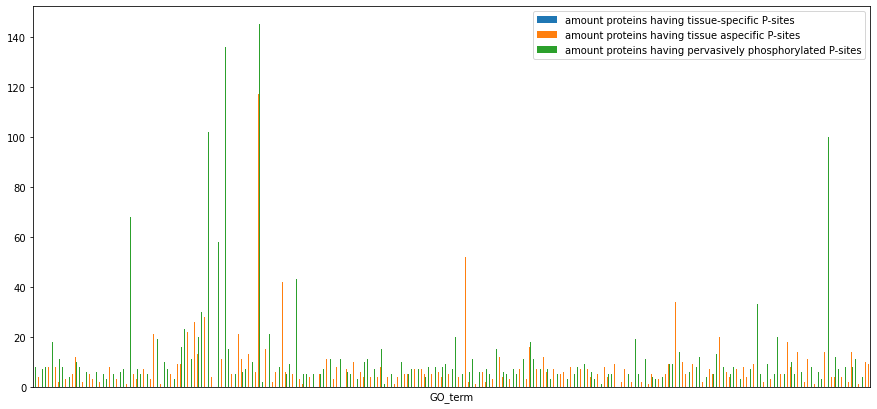

In [43]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Adipose tissue"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Adipose tissue"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Adipose tissue"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Adipose tissue"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Adipose tissue"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Adipose tissue"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=1)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=1)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=1)]

### B-cells

233


<Figure size 1080x504 with 0 Axes>

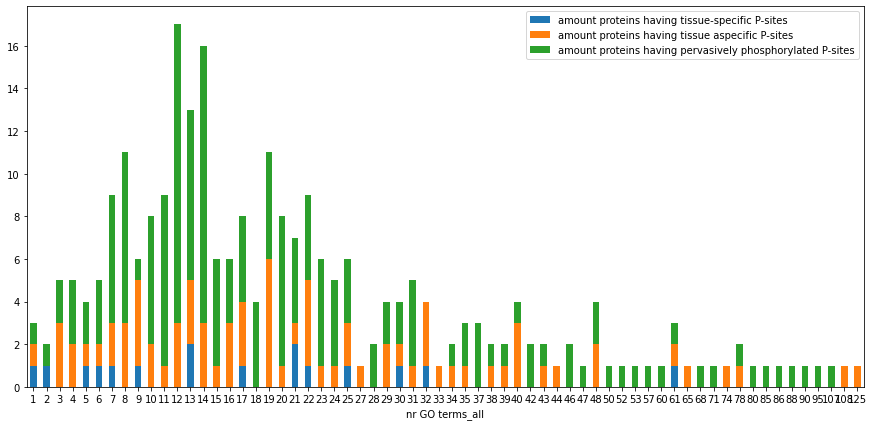

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 1                                             1.0   
1                 2                                             1.0   
14                3                                             NaN   
15                4                                             NaN   
2                 5                                             1.0   
..              ...                                             ...   
61               90                                             NaN   
62               95                                             NaN   
63              107                                             NaN   
42              108                                             NaN   
43              125                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               1.0   
1                                               NaN   
14                                              3.0   
15                                              2.0   
2                                               1.0   
..                                              ...   
61                                              NaN   
62                                              NaN   
63                                              NaN   
42                                              1.0   
43                                              1.0   

    amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 1.0            3.0  
1                                                 1.0            2.0  
14                                                2.0            5.0  
15                                                3.0            5.0  
2                                                 2.0            4.0  
..                                                ...            ...  
61                                                1.0            1.0  
62                                                1.0            1.0  
63                                                1.0            1.0  
42                                                NaN            1.0  
43                                                NaN            1.0  

[64 rows x 5 columns]

In [44]:
print(data_protein[data_protein["B-cells"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["B-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["B-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["B-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
39     GO:0000122                                             2.0   
48     GO:0000139                                             1.0   
76     GO:0000226                                             0.0   
93     GO:0000287                                             0.0   
121    GO:0000381                                             1.0   
...           ...                                             ...   
10426  GO:0098794                                             0.0   
10695  GO:0106310                                             0.0   
10696  GO:0106311                                             0.0   
11751  GO:1904813                                             0.0   
12161  GO:1990904                                             0.0   

       amount proteins having tissue aspecific P-sites  \
39                                                 5.0   
48                                                 2.0   
76                                                 6.0   
93                                                 5.0   
121                                                1.0   
...                                                ...   
10426                                              2.0   
10695                                              7.0   
10696                                              7.0   
11751                                              3.0   
12161                                              1.0   

       amount proteins having pervasively phosphorylated P-sites  
39                                                   9.0          
48                                                   5.0          
76                                                   2.0          
93                                                   3.0          
121                                                 11.0          
...                                                  ...          
10426                                                5.0          
10695                                               17.0          
10696                                               17.0          
11751                                                6.0          
12161                                               10.0          

[135 rows x 4 columns]

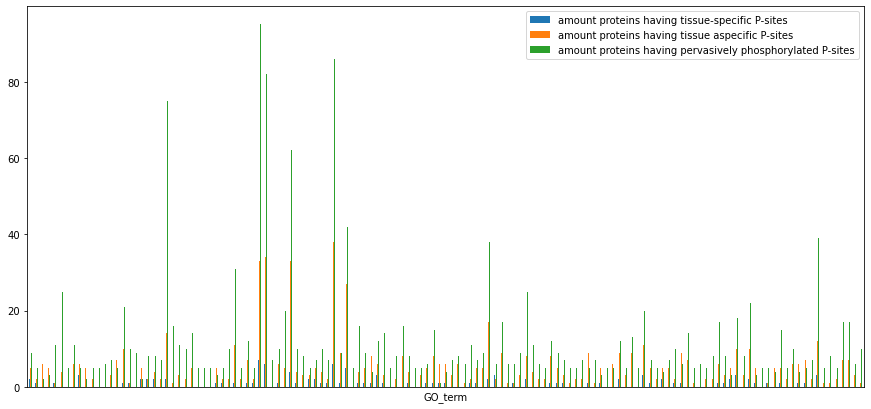

In [47]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["B-cells"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["B-cells"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["B-cells"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["B-cells"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["B-cells"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["B-cells"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Blood

2737


<Figure size 1080x504 with 0 Axes>

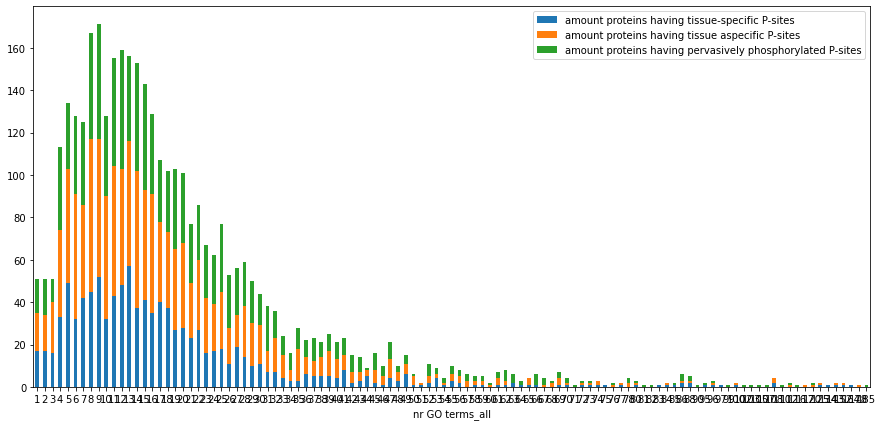

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                  1                                            17.0   
1                  2                                            17.0   
2                  3                                            16.0   
3                  4                                            33.0   
4                  5                                            49.0   
..               ...                                             ...   
84               143                                             1.0   
85               152                                             1.0   
86               164                                             1.0   
96               178                                             NaN   
108              185                                             NaN   

     amount proteins having tissue aspecific P-sites  \
0                                               18.0   
1                                               17.0   
2                                               24.0   
3                                               41.0   
4                                               54.0   
..                                               ...   
84                                               1.0   
85                                               1.0   
86                                               NaN   
96                                               1.0   
108                                              NaN   

     amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 16.0           51.0  
1                                                 17.0           51.0  
2                                                 11.0           51.0  
3                                                 39.0          113.0  
4                                                 31.0          134.0  
..                                                 ...            ...  
84                                                 NaN            2.0  
85                                                 NaN            2.0  
86                                                 NaN            1.0  
96                                                 NaN            1.0  
108                                                1.0            1.0  

[109 rows x 5 columns]

In [48]:
print(data_protein[data_protein["Blood"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Blood"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Blood"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Blood"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
30     GO:0000086                                            18.0   
39     GO:0000122                                            70.0   
48     GO:0000139                                            21.0   
56     GO:0000165                                            23.0   
65     GO:0000184                                             8.0   
...           ...                                             ...   
11078  GO:1901796                                            25.0   
11751  GO:1904813                                            16.0   
12148  GO:1990837                                            29.0   
12151  GO:1990841                                            14.0   
12161  GO:1990904                                            26.0   

       amount proteins having tissue aspecific P-sites  \
30                                                27.0   
39                                               105.0   
48                                                33.0   
56                                                27.0   
65                                                23.0   
...                                                ...   
11078                                             34.0   
11751                                             20.0   
12148                                             33.0   
12151                                             22.0   
12161                                             42.0   

       amount proteins having pervasively phosphorylated P-sites  
30                                                  28.0          
39                                                  50.0          
48                                                  35.0          
56                                                  38.0          
65                                                  10.0          
...                                                  ...          
11078                                               17.0          
11751                                               26.0          
12148                                                7.0          
12151                                               10.0          
12161                                               33.0          

[252 rows x 4 columns]

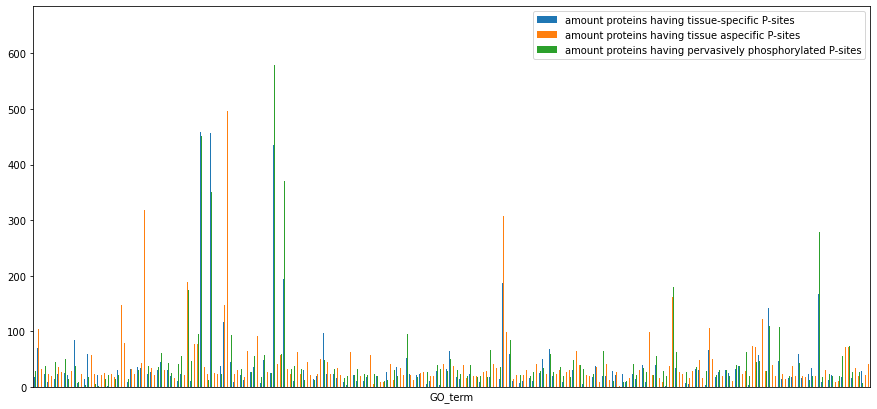

In [51]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Blood"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Blood"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Blood"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Blood"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Blood"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Blood"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=20)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=20)]

### Bone

11


<Figure size 1080x504 with 0 Axes>

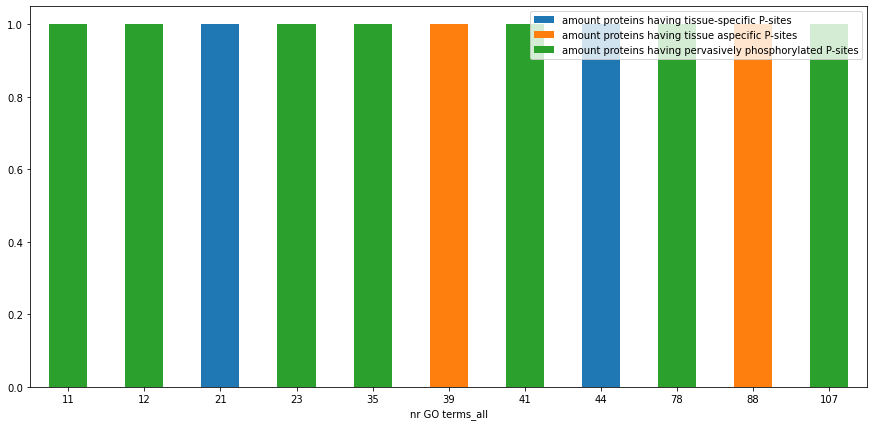

nr GO terms_all  amount proteins having tissue-specific P-sites  \
4                11                                             NaN   
5                12                                             NaN   
0                21                                             1.0   
6                23                                             NaN   
7                35                                             NaN   
2                39                                             NaN   
8                41                                             NaN   
1                44                                             1.0   
9                78                                             NaN   
3                88                                             NaN   
10              107                                             NaN   

    amount proteins having tissue aspecific P-sites  \
4                                               NaN   
5                                               NaN   
0                                               NaN   
6                                               NaN   
7                                               NaN   
2                                               1.0   
8                                               NaN   
1                                               NaN   
9                                               NaN   
3                                               1.0   
10                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
4                                                 1.0            1.0  
5                                                 1.0            1.0  
0                                                 NaN            1.0  
6                                                 1.0            1.0  
7                                                 1.0            1.0  
2                                                 NaN            1.0  
8                                                 1.0            1.0  
1                                                 NaN            1.0  
9                                                 1.0            1.0  
3                                                 NaN            1.0  
10                                                1.0            1.0

In [52]:
print(data_protein[data_protein["Bone"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Bone"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Bone"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Bone"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
1502  GO:0005524                                             0.0   
1541  GO:0005634                                             0.0   
1551  GO:0005654                                             0.0   
1639  GO:0005829                                             0.0   

      amount proteins having tissue aspecific P-sites  \
1502                                              0.0   
1541                                              1.0   
1551                                              0.0   
1639                                              2.0   

      amount proteins having pervasively phosphorylated P-sites  
1502                                                5.0          
1541                                                5.0          
1551                                                5.0          
1639                                                6.0

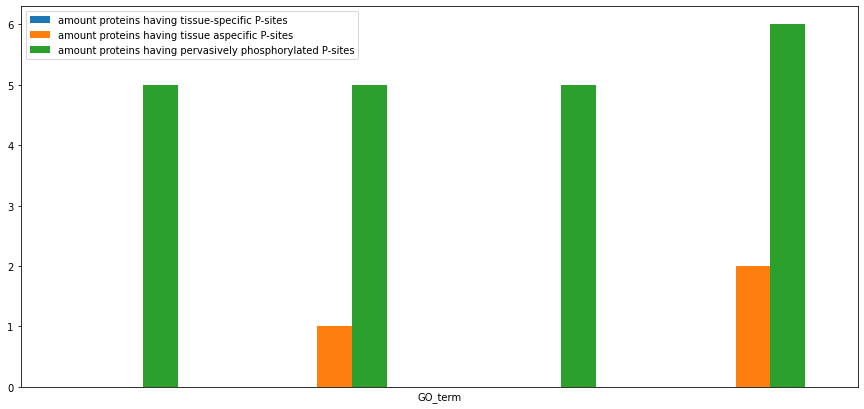

In [53]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Bone"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Bone"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Bone"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Bone"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Bone"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Bone"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Brain

1026


<Figure size 1080x504 with 0 Axes>

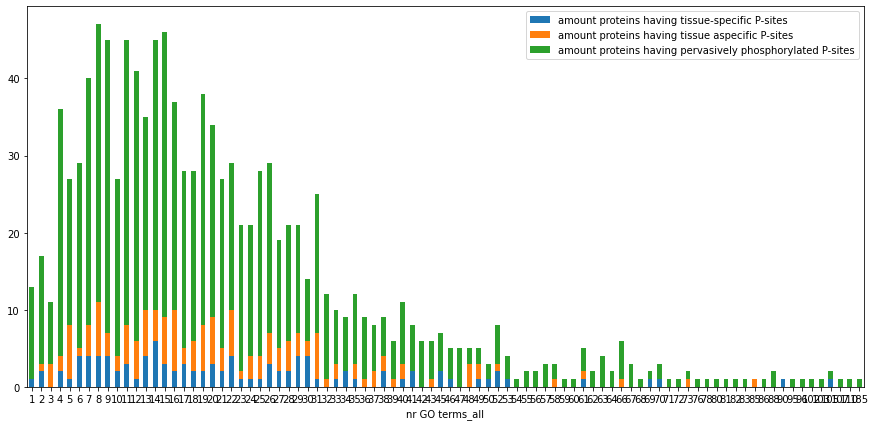

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 1                                             1.0   
1                 2                                             2.0   
47                3                                             NaN   
2                 4                                             2.0   
3                 5                                             1.0   
..              ...                                             ...   
84              103                                             NaN   
46              105                                             1.0   
85              107                                             NaN   
86              110                                             NaN   
87              185                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               NaN   
1                                               1.0   
47                                              3.0   
2                                               2.0   
3                                               7.0   
..                                              ...   
84                                              NaN   
46                                              NaN   
85                                              NaN   
86                                              NaN   
87                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
0                                                12.0           13.0  
1                                                14.0           17.0  
47                                                8.0           11.0  
2                                                32.0           36.0  
3                                                19.0           27.0  
..                                                ...            ...  
84                                                1.0            1.0  
46                                                1.0            2.0  
85                                                1.0            1.0  
86                                                1.0            1.0  
87                                                1.0            1.0  

[88 rows x 5 columns]

In [54]:
print(data_protein[data_protein["Brain"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Brain"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Brain"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Brain"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
30     GO:0000086                                             2.0   
39     GO:0000122                                             1.0   
48     GO:0000139                                             2.0   
56     GO:0000165                                             5.0   
76     GO:0000226                                            12.0   
...           ...                                             ...   
9852   GO:0072659                                             6.0   
10495  GO:0098978                                             4.0   
10695  GO:0106310                                             3.0   
10696  GO:0106311                                             3.0   
12161  GO:1990904                                             3.0   

       amount proteins having tissue aspecific P-sites  \
30                                                 6.0   
39                                                 4.0   
48                                                 3.0   
56                                                 4.0   
76                                                11.0   
...                                                ...   
9852                                               2.0   
10495                                              4.0   
10695                                              4.0   
10696                                              4.0   
12161                                              3.0   

       amount proteins having pervasively phosphorylated P-sites  
30                                                  25.0          
39                                                  20.0          
48                                                  25.0          
56                                                  30.0          
76                                                  39.0          
...                                                  ...          
9852                                                20.0          
10495                                               54.0          
10695                                               52.0          
10696                                               52.0          
12161                                               20.0          

[132 rows x 4 columns]

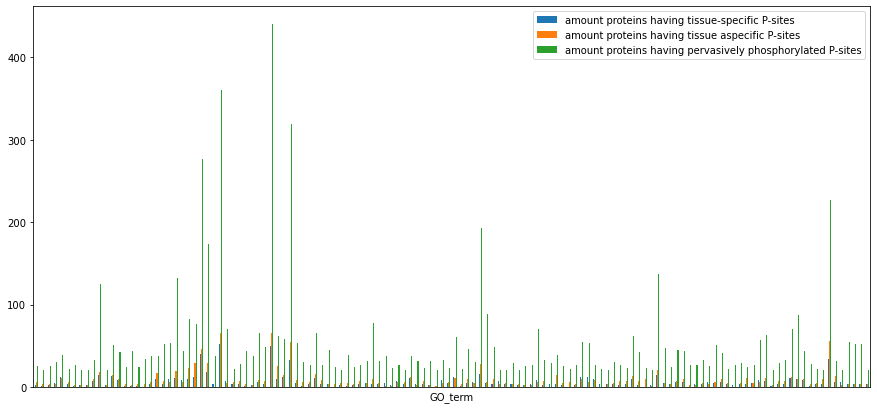

In [55]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Brain"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Brain"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Brain"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Brain"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Brain"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Brain"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=20)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=20)]

### Breast

87


<Figure size 1080x504 with 0 Axes>

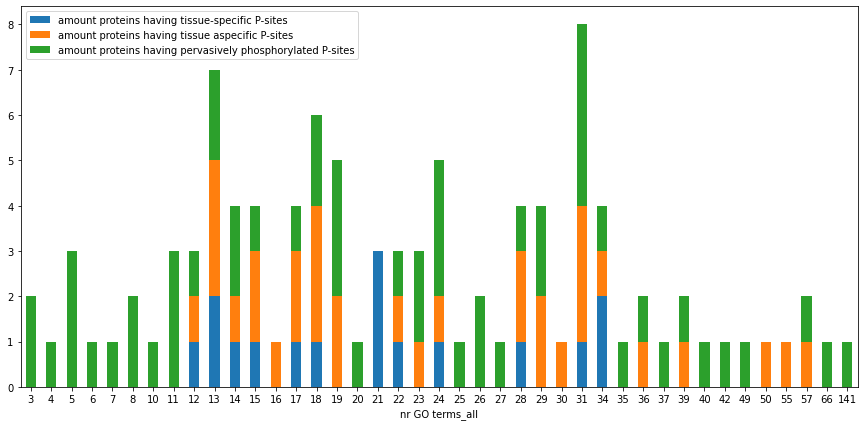

nr GO terms_all  amount proteins having tissue-specific P-sites  \
22                3                                             NaN   
23                4                                             NaN   
24                5                                             NaN   
25                6                                             NaN   
26                7                                             NaN   
27                8                                             NaN   
28               10                                             NaN   
29               11                                             NaN   
0                12                                             1.0   
1                13                                             2.0   
2                14                                             1.0   
3                15                                             1.0   
12               16                                             NaN   
4                17                                             1.0   
5                18                                             1.0   
13               19                                             NaN   
30               20                                             NaN   
6                21                                             3.0   
7                22                                             1.0   
14               23                                             NaN   
8                24                                             1.0   
31               25                                             NaN   
32               26                                             NaN   
33               27                                             NaN   
9                28                                             1.0   
15               29                                             NaN   
16               30                                             NaN   
10               31                                             1.0   
11               34                                             2.0   
34               35                                             NaN   
17               36                                             NaN   
35               37                                             NaN   
18               39                                             NaN   
36               40                                             NaN   
37               42                                             NaN   
38               49                                             NaN   
19               50                                             NaN   
20               55                                             NaN   
21               57                                             NaN   
39               66                                             NaN   
40              141                                             NaN   

    amount proteins having tissue aspecific P-sites  \
22                                              NaN   
23                                              NaN   
24                                              NaN   
25                                              NaN   
26                                              NaN   
27                                              NaN   
28                                              NaN   
29                                              NaN   
0                                               1.0   
1                                               3.0   
2                                               1.0   
3                                               2.0   
12                                              1.0   
4                                               2.0   
5                                               3.0   
13                                              2.0   
30                                              NaN   
6                              

In [56]:
print(data_protein[data_protein["Breast"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Breast"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Breast"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Breast"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
462    GO:0001895                                             2.0   
770    GO:0002862                                             0.0   
928    GO:0003723                                             0.0   
947    GO:0003823                                             0.0   
1426   GO:0005200                                             0.0   
...           ...                                             ...   
7990   GO:0050900                                             0.0   
9064   GO:0070062                                            12.0   
9235   GO:0070527                                             1.0   
9834   GO:0072562                                             7.0   
10449  GO:0098869                                             5.0   

       amount proteins having tissue aspecific P-sites  \
462                                                2.0   
770                                                1.0   
928                                                6.0   
947                                                1.0   
1426                                               2.0   
...                                                ...   
7990                                               2.0   
9064                                              25.0   
9235                                               2.0   
9834                                               9.0   
10449                                              6.0   

       amount proteins having pervasively phosphorylated P-sites  
462                                                 11.0          
770                                                  5.0          
928                                                  9.0          
947                                                  7.0          
1426                                                 5.0          
...                                                  ...          
7990                                                 8.0          
9064                                                33.0          
9235                                                 5.0          
9834                                                18.0          
10449                                                3.0          

[63 rows x 4 columns]

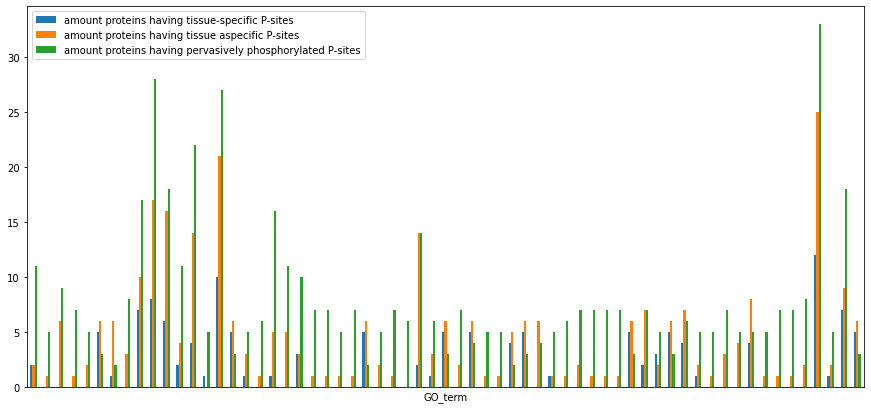

In [57]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Breast"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Breast"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Breast"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Breast"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Breast"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Breast"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Cerebrospinal fluid

884


<Figure size 1080x504 with 0 Axes>

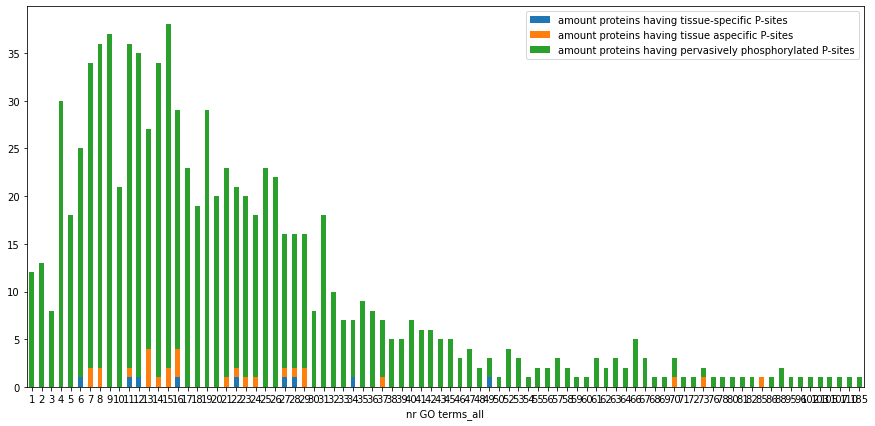

nr GO terms_all  amount proteins having tissue-specific P-sites  \
22                1                                             NaN   
23                2                                             NaN   
24                3                                             NaN   
25                4                                             NaN   
26                5                                             NaN   
..              ...                                             ...   
81              103                                             NaN   
82              105                                             NaN   
83              107                                             NaN   
84              110                                             NaN   
85              185                                             NaN   

    amount proteins having tissue aspecific P-sites  \
22                                              NaN   
23                                              NaN   
24                                              NaN   
25                                              NaN   
26                                              NaN   
..                                              ...   
81                                              NaN   
82                                              NaN   
83                                              NaN   
84                                              NaN   
85                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
22                                               12.0           12.0  
23                                               13.0           13.0  
24                                                8.0            8.0  
25                                               30.0           30.0  
26                                               18.0           18.0  
..                                                ...            ...  
81                                                1.0            1.0  
82                                                1.0            1.0  
83                                                1.0            1.0  
84                                                1.0            1.0  
85                                                1.0            1.0  

[86 rows x 5 columns]

In [58]:
print(data_protein[data_protein["Cerebrospinal fluid"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Cerebrospinal fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Cerebrospinal fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Cerebrospinal fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
30     GO:0000086                                             0.0   
39     GO:0000122                                             0.0   
48     GO:0000139                                             0.0   
51     GO:0000149                                             0.0   
56     GO:0000165                                             0.0   
...           ...                                             ...   
11514  GO:1903779                                             0.0   
11598  GO:1904115                                             0.0   
11751  GO:1904813                                             0.0   
12161  GO:1990904                                             0.0   
12271  GO:2000300                                             0.0   

       amount proteins having tissue aspecific P-sites  \
30                                                 0.0   
39                                                 0.0   
48                                                 1.0   
51                                                 0.0   
56                                                 0.0   
...                                                ...   
11514                                              1.0   
11598                                              1.0   
11751                                              1.0   
12161                                              0.0   
12271                                              0.0   

       amount proteins having pervasively phosphorylated P-sites  
30                                                  23.0          
39                                                  18.0          
48                                                  25.0          
51                                                  14.0          
56                                                  29.0          
...                                                  ...          
11514                                               13.0          
11598                                               11.0          
11751                                               18.0          
12161                                               18.0          
12271                                               12.0          

[323 rows x 4 columns]

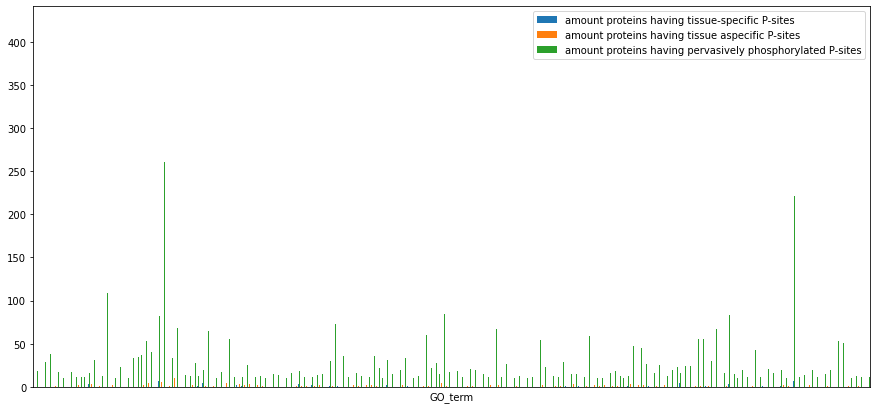

In [59]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Cerebrospinal fluid"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Cerebrospinal fluid"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Cerebrospinal fluid"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Cerebrospinal fluid"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Cerebrospinal fluid"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Cerebrospinal fluid"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Cervix

18


<Figure size 1080x504 with 0 Axes>

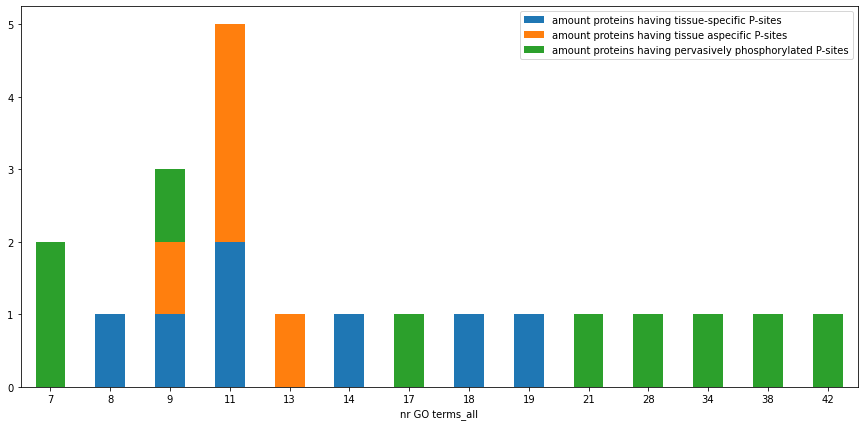

nr GO terms_all  amount proteins having tissue-specific P-sites  \
7                 7                                             NaN   
0                 8                                             1.0   
1                 9                                             1.0   
2                11                                             2.0   
6                13                                             NaN   
3                14                                             1.0   
8                17                                             NaN   
4                18                                             1.0   
5                19                                             1.0   
9                21                                             NaN   
10               28                                             NaN   
11               34                                             NaN   
12               38                                             NaN   
13               42                                             NaN   

    amount proteins having tissue aspecific P-sites  \
7                                               NaN   
0                                               NaN   
1                                               1.0   
2                                               3.0   
6                                               1.0   
3                                               NaN   
8                                               NaN   
4                                               NaN   
5                                               NaN   
9                                               NaN   
10                                              NaN   
11                                              NaN   
12                                              NaN   
13                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
7                                                 2.0            2.0  
0                                                 NaN            1.0  
1                                                 1.0            3.0  
2                                                 NaN            5.0  
6                                                 NaN            1.0  
3                                                 NaN            1.0  
8                                                 1.0            1.0  
4                                                 NaN            1.0  
5                                                 NaN            1.0  
9                                                 1.0            1.0  
10                                                1.0            1.0  
11                                                1.0            1.0  
12                                                1.0            1.0  
13                                                1.0            1.0

In [60]:
print(data_protein[data_protein["Cervix"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Cervix"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Cervix"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Cervix"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
1541  GO:0005634                                             2.0   
1639  GO:0005829                                             5.0   
9064  GO:0070062                                             3.0   

      amount proteins having tissue aspecific P-sites  \
1541                                              3.0   
1639                                              4.0   
9064                                              4.0   

      amount proteins having pervasively phosphorylated P-sites  
1541                                                5.0          
1639                                                7.0          
9064                                                8.0

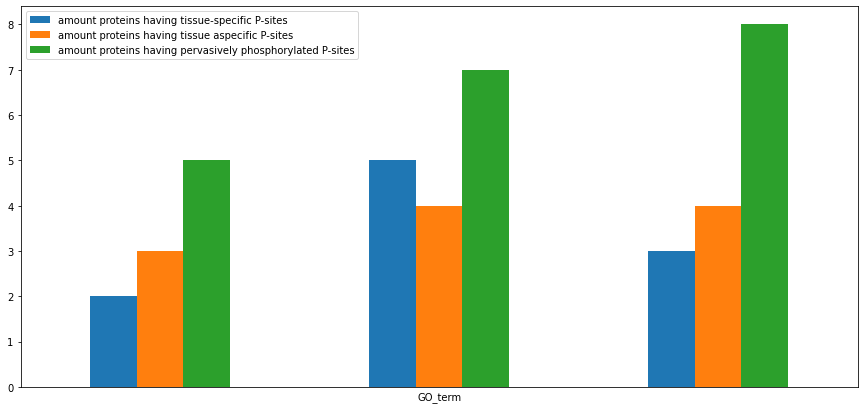

In [61]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Cervix"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Cervix"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Cervix"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Cervix"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Cervix"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Cervix"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Dental plaque

25


<Figure size 1080x504 with 0 Axes>

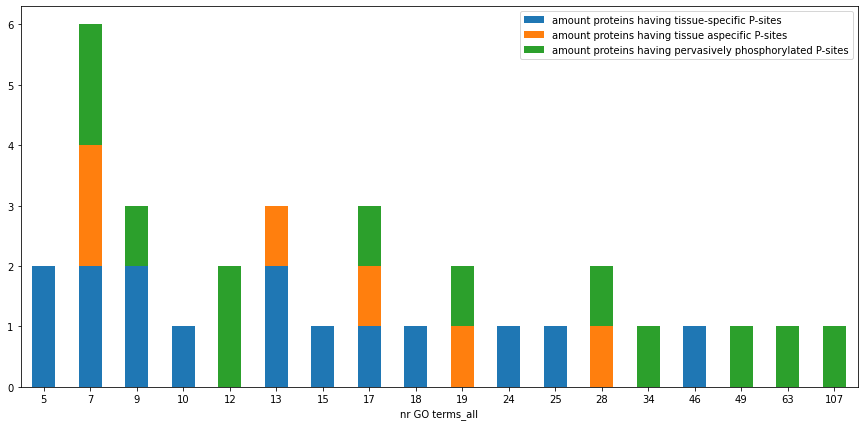

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 5                                             2.0   
1                 7                                             2.0   
2                 9                                             2.0   
3                10                                             1.0   
13               12                                             NaN   
4                13                                             2.0   
5                15                                             1.0   
6                17                                             1.0   
7                18                                             1.0   
11               19                                             NaN   
8                24                                             1.0   
9                25                                             1.0   
12               28                                             NaN   
14               34                                             NaN   
10               46                                             1.0   
15               49                                             NaN   
16               63                                             NaN   
17              107                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               NaN   
1                                               2.0   
2                                               NaN   
3                                               NaN   
13                                              NaN   
4                                               1.0   
5                                               NaN   
6                                               1.0   
7                                               NaN   
11                                              1.0   
8                                               NaN   
9                                               NaN   
12                                              1.0   
14                                              NaN   
10                                              NaN   
15                                              NaN   
16                                              NaN   
17                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 NaN            2.0  
1                                                 2.0            6.0  
2                                                 1.0            3.0  
3                                                 NaN            1.0  
13                                                2.0            2.0  
4                                                 NaN            3.0  
5                                                 NaN            1.0  
6                                                 1.0            3.0  
7                                                 NaN            1.0  
11                                                1.0            2.0  
8                                                 NaN            1.0  
9                                                 NaN            1.0  
12                                                1.0            2.0  
14                                                1.0            1.0  
10                                                NaN            1.0  
15                                                1.0            1.0  
16                                                1.0            1.0  
17                                                1.0            1.0

In [62]:
print(data_protein[data_protein["Dental plaque"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Dental plaque"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Dental plaque"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Dental plaque"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
1518  GO:0005576                                             7.0   
1539  GO:0005615                                             6.0   
1541  GO:0005634                                             5.0   
1639  GO:0005829                                             8.0   
3872  GO:0019730                                             5.0   
4655  GO:0031424                                             5.0   
6636  GO:0043312                                             5.0   
6980  GO:0045095                                             5.0   
9064  GO:0070062                                            12.0   
9141  GO:0070268                                             7.0   

      amount proteins having tissue aspecific P-sites  \
1518                                              1.0   
1539                                              1.0   
1541                                              3.0   
1639                                              5.0   
3872                                              0.0   
4655                                              5.0   
6636                                              0.0   
6980                                              5.0   
9064                                              6.0   
9141                                              5.0   

      amount proteins having pervasively phosphorylated P-sites  
1518                                                5.0          
1539                                                4.0          
1541                                                6.0          
1639                                                9.0          
3872                                                0.0          
4655                                                6.0          
6636                                                2.0          
6980                                                6.0          
9064                                               11.0          
9141                                                6.0

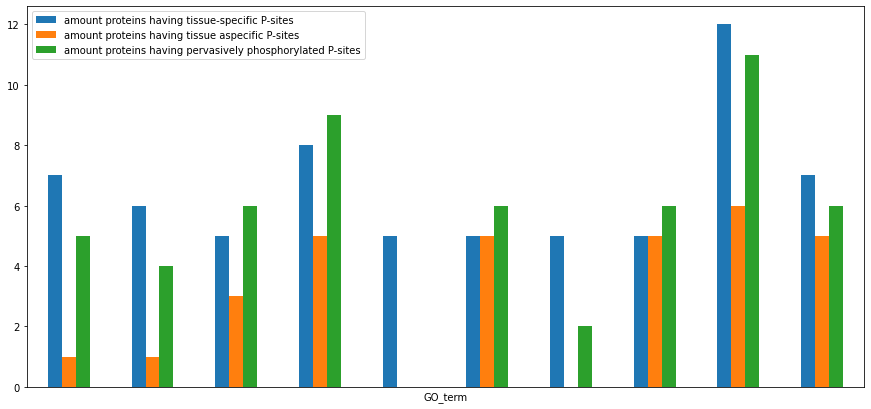

In [63]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Dental plaque"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Dental plaque"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Dental plaque"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Dental plaque"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Dental plaque"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Dental plaque"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Esophagus

51


<Figure size 1080x504 with 0 Axes>

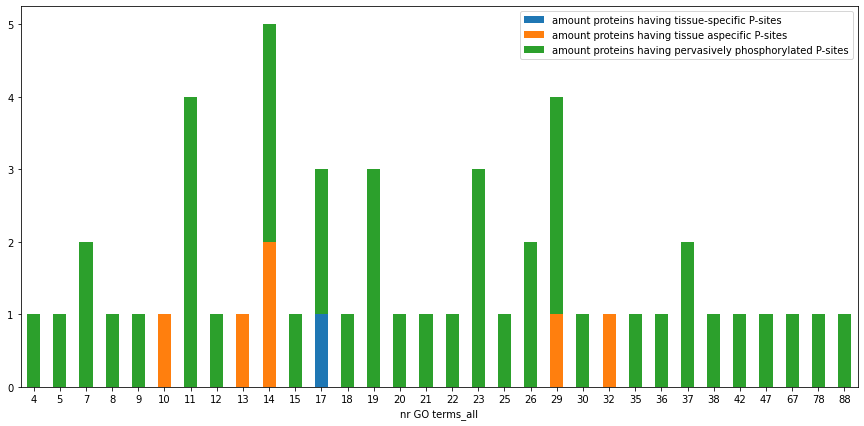

nr GO terms_all  amount proteins having tissue-specific P-sites  \
6                 4                                             NaN   
7                 5                                             NaN   
8                 7                                             NaN   
9                 8                                             NaN   
10                9                                             NaN   
1                10                                             NaN   
11               11                                             NaN   
12               12                                             NaN   
2                13                                             NaN   
3                14                                             NaN   
13               15                                             NaN   
0                17                                             1.0   
14               18                                             NaN   
15               19                                             NaN   
16               20                                             NaN   
17               21                                             NaN   
18               22                                             NaN   
19               23                                             NaN   
20               25                                             NaN   
21               26                                             NaN   
4                29                                             NaN   
22               30                                             NaN   
5                32                                             NaN   
23               35                                             NaN   
24               36                                             NaN   
25               37                                             NaN   
26               38                                             NaN   
27               42                                             NaN   
28               47                                             NaN   
29               67                                             NaN   
30               78                                             NaN   
31               88                                             NaN   

    amount proteins having tissue aspecific P-sites  \
6                                               NaN   
7                                               NaN   
8                                               NaN   
9                                               NaN   
10                                              NaN   
1                                               1.0   
11                                              NaN   
12                                              NaN   
2                                               1.0   
3                                               2.0   
13                                              NaN   
0                                               NaN   
14                                              NaN   
15                                              NaN   
16                                              NaN   
17                                              NaN   
18                                              NaN   
19                                              NaN   
20                                              NaN   
21                                              NaN   
4                                               1.0   
22                                              NaN   
5                                               1.0   
23                                              NaN   
24                                              NaN   
25                                              NaN   
26                                              NaN   
27                                              NaN   
28                                              NaN   
29        

In [64]:
print(data_protein[data_protein["Esophagus"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Esophagus"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Esophagus"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Esophagus"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
908   GO:0003677                                             0.0   
928   GO:0003723                                             0.0   
943   GO:0003779                                             0.0   
1425  GO:0005198                                             0.0   
1502  GO:0005524                                             0.0   
1518  GO:0005576                                             1.0   
1541  GO:0005634                                             0.0   
1551  GO:0005654                                             0.0   
1580  GO:0005730                                             0.0   
1583  GO:0005737                                             0.0   
1639  GO:0005829                                             0.0   
1656  GO:0005856                                             0.0   
1676  GO:0005886                                             0.0   
1697  GO:0005925                                             0.0   
3309  GO:0015629                                             0.0   
3395  GO:0016020                                             1.0   
6464  GO:0042802                                             0.0   
7046  GO:0045296                                             0.0   
7252  GO:0045944                                             0.0   
7687  GO:0048471                                             0.0   
8030  GO:0051015                                             0.0   
9064  GO:0070062                                             1.0   

      amount proteins having tissue aspecific P-sites  \
908                                               1.0   
928                                               1.0   
943                                               0.0   
1425                                              1.0   
1502                                              0.0   
1518                                              2.0   
1541                                              3.0   
1551                                              2.0   
1580                                              1.0   
1583                                              2.0   
1639                                              3.0   
1656                                              0.0   
1676                                              0.0   
1697                                              0.0   
3309                                              0.0   
3395                                              1.0   
6464                                              2.0   
7046                                              0.0   
7252                                              0.0   
7687                                              1.0   
8030                                              0.0   
9064                                              1.0   

      amount proteins having pervasively phosphorylated P-sites  
908                                                 7.0          
928                                                19.0          
943                                                 6.0          
1425                                                5.0          
1502                                                6.0          
1518                                                5.0          
1541                                               22.0          
1551                                               22.0          
1580                                                8.0          
1583                                               21.0          
1639                                               27.0          
1656                                                6.0          
1676                                               11.0          
1697                                                9.0          
3309                                                6.0          
3395                                               11.0          
6464      

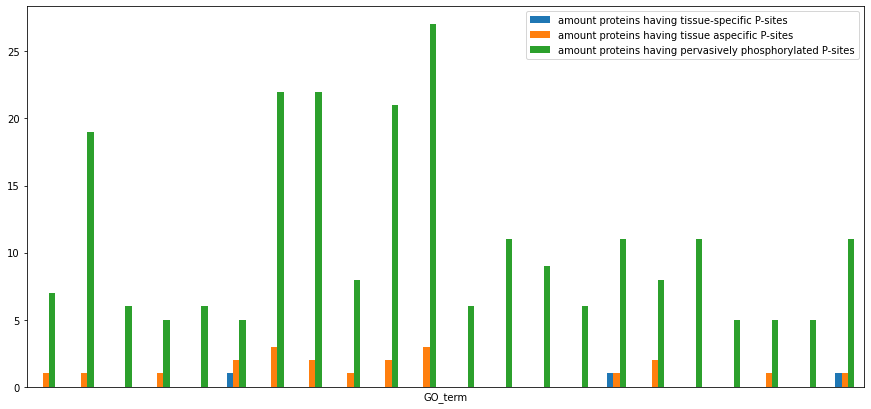

In [65]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Esophagus"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Esophagus"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Esophagus"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Esophagus"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Esophagus"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Esophagus"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Eye

17


<Figure size 1080x504 with 0 Axes>

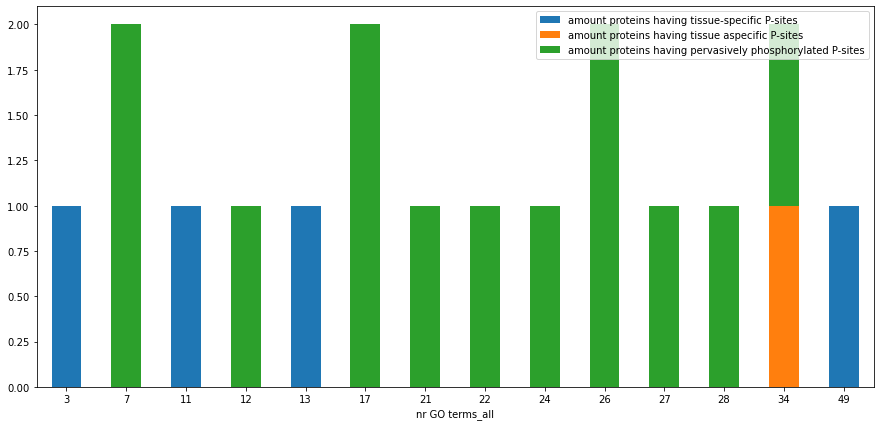

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 3                                             1.0   
5                 7                                             NaN   
1                11                                             1.0   
6                12                                             NaN   
2                13                                             1.0   
7                17                                             NaN   
8                21                                             NaN   
9                22                                             NaN   
10               24                                             NaN   
11               26                                             NaN   
12               27                                             NaN   
13               28                                             NaN   
4                34                                             NaN   
3                49                                             1.0   

    amount proteins having tissue aspecific P-sites  \
0                                               NaN   
5                                               NaN   
1                                               NaN   
6                                               NaN   
2                                               NaN   
7                                               NaN   
8                                               NaN   
9                                               NaN   
10                                              NaN   
11                                              NaN   
12                                              NaN   
13                                              NaN   
4                                               1.0   
3                                               NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 NaN            1.0  
5                                                 2.0            2.0  
1                                                 NaN            1.0  
6                                                 1.0            1.0  
2                                                 NaN            1.0  
7                                                 2.0            2.0  
8                                                 1.0            1.0  
9                                                 1.0            1.0  
10                                                1.0            1.0  
11                                                2.0            2.0  
12                                                1.0            1.0  
13                                                1.0            1.0  
4                                                 1.0            2.0  
3                                                 NaN            1.0

In [66]:
print(data_protein[data_protein["Eye"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Eye"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Eye"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Eye"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
770   GO:0002862                                             0.0   
947   GO:0003823                                             0.0   
1518  GO:0005576                                             3.0   
1539  GO:0005615                                             3.0   
1676  GO:0005886                                             1.0   
2153  GO:0006898                                             0.0   
2160  GO:0006910                                             0.0   
2161  GO:0006911                                             0.0   
2182  GO:0006956                                             0.0   
2184  GO:0006958                                             0.0   
2519  GO:0008228                                             0.0   
2801  GO:0009897                                             0.0   
3711  GO:0018149                                             0.0   
4331  GO:0030449                                             0.0   
5690  GO:0034987                                             0.0   
6164  GO:0038095                                             0.0   
6165  GO:0038096                                             0.0   
6383  GO:0042571                                             0.0   
6437  GO:0042742                                             0.0   
6977  GO:0045087                                             0.0   
7925  GO:0050776                                             0.0   
7963  GO:0050853                                             0.0   
7977  GO:0050871                                             0.0   
7990  GO:0050900                                             0.0   
9064  GO:0070062                                             1.0   
9834  GO:0072562                                             1.0   

      amount proteins having tissue aspecific P-sites  \
770                                               0.0   
947                                               0.0   
1518                                              1.0   
1539                                              1.0   
1676                                              0.0   
2153                                              1.0   
2160                                              0.0   
2161                                              0.0   
2182                                              0.0   
2184                                              0.0   
2519                                              0.0   
2801                                              0.0   
3711                                              0.0   
4331                                              0.0   
5690                                              0.0   
6164                                              0.0   
6165                                              0.0   
6383                                              0.0   
6437                                              0.0   
6977                                              0.0   
7925                                              0.0   
7963                                              0.0   
7977                                              0.0   
7990                                              0.0   
9064                                              1.0   
9834                                              1.0   

      amount proteins having pervasively phosphorylated P-sites  
770                                                 7.0          
947                                                 8.0          
1518                                                8.0          
1539                                                9.0          
1676                                                5.0          
2153                                                6.0          
2160                                                8.0          
2161                                                8.0          
2182                                  

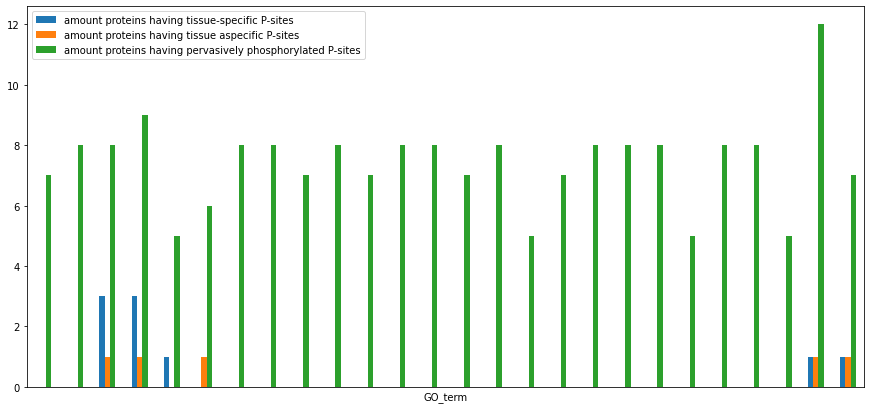

In [67]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Eye"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Eye"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Eye"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Eye"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Eye"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Eye"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Follicular fluid

In [68]:
print(data_protein[data_protein["Follicular fluid"]==1].shape[0])
data_protein_GO[data_protein_GO["Follicular fluid"]==1]
#proteins_tspec_sites[proteins_tspec_sites["Follicular fluid"]==1]
#proteins_taspec_sites[proteins_taspec_sites["Follicular fluid"]==1] -> the protein has a tissue-aspecific site but has been included with blood
#proteins_genP_sites[proteins_genP_sites["Follicular fluid"]==1]
#and it seems to be the one we don't have annotation for

1


ACC_ID  Adipose tissue  B-cells  Blood  Bone  Brain  Breast  \
2016  P59535               0        0      1     0      0       0   

      Cerebrospinal fluid  Cervix  Colon  ...  GO:2001251  GO:2001252  \
2016                    0       0      0  ...         NaN         NaN   

      GO:2001257  GO:2001264  GO:2001280  GO:2001294  GO:2001301  GO:2001303  \
2016         NaN         NaN         NaN         NaN         NaN         NaN   

      GO:2001306  GO:2001311  
2016         NaN         NaN  

[1 rows x 18838 columns]

In [ ]:
#https://www.uniprot.org/uniprot/P59535
#It's a taste receptor?

### Heart

89


<Figure size 1080x504 with 0 Axes>

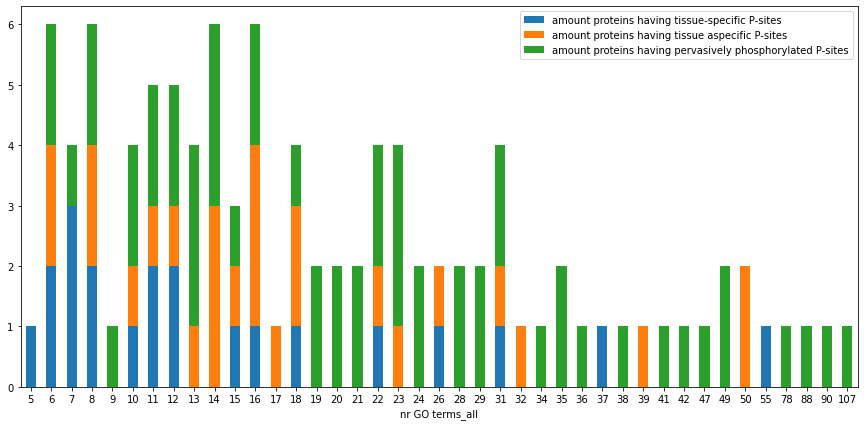

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 5                                             1.0   
1                 6                                             2.0   
2                 7                                             3.0   
3                 8                                             2.0   
22                9                                             NaN   
4                10                                             1.0   
5                11                                             2.0   
6                12                                             2.0   
15               13                                             NaN   
16               14                                             NaN   
7                15                                             1.0   
8                16                                             1.0   
17               17                                             NaN   
9                18                                             1.0   
23               19                                             NaN   
24               20                                             NaN   
25               21                                             NaN   
10               22                                             1.0   
18               23                                             NaN   
26               24                                             NaN   
11               26                                             1.0   
27               28                                             NaN   
28               29                                             NaN   
12               31                                             1.0   
19               32                                             NaN   
29               34                                             NaN   
30               35                                             NaN   
31               36                                             NaN   
13               37                                             1.0   
32               38                                             NaN   
20               39                                             NaN   
33               41                                             NaN   
34               42                                             NaN   
35               47                                             NaN   
36               49                                             NaN   
21               50                                             NaN   
14               55                                             1.0   
37               78                                             NaN   
38               88                                             NaN   
39               90                                             NaN   
40              107                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               NaN   
1                                               2.0   
2                                               NaN   
3                                               2.0   
22                                              NaN   
4                                               1.0   
5                                               1.0   
6                                               1.0   
15                                              1.0   
16                                              3.0   
7                                               1.0   
8                                               3.0   
17                                              1.0   
9                                               2.0   
23                                              NaN   
24                                              NaN   
25                                              NaN   
10                             

In [69]:
print(data_protein[data_protein["Heart"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Heart"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Heart"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Heart"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
708   GO:0002576                                             1.0   
928   GO:0003723                                             0.0   
943   GO:0003779                                             3.0   
1502  GO:0005524                                             6.0   
1518  GO:0005576                                             0.0   
1539  GO:0005615                                             1.0   
1541  GO:0005634                                             6.0   
1551  GO:0005654                                             1.0   
1580  GO:0005730                                             0.0   
1583  GO:0005737                                             2.0   
1584  GO:0005739                                             9.0   
1588  GO:0005743                                             3.0   
1599  GO:0005759                                             5.0   
1619  GO:0005788                                             1.0   
1639  GO:0005829                                             8.0   
1674  GO:0005884                                             0.0   
1676  GO:0005886                                             5.0   
1697  GO:0005925                                             1.0   
2172  GO:0006936                                             2.0   
2409  GO:0007596                                             0.0   
2818  GO:0009986                                             2.0   
2928  GO:0010628                                             1.0   
2968  GO:0010737                                             0.0   
3309  GO:0015629                                             1.0   
3395  GO:0016020                                             3.0   
3490  GO:0016324                                             1.0   
3925  GO:0019901                                             0.0   
4136  GO:0030027                                             0.0   
4219  GO:0030175                                             0.0   
5220  GO:0032991                                             0.0   
6464  GO:0042802                                             2.0   
6636  GO:0043312                                             0.0   
6772  GO:0043687                                             0.0   
6852  GO:0044297                                             0.0   
7024  GO:0045202                                             0.0   
7046  GO:0045296                                             1.0   
7453  GO:0046872                                             4.0   
7687  GO:0048471                                             1.0   
9064  GO:0070062                                             5.0   
9834  GO:0072562                                             0.0   

      amount proteins having tissue aspecific P-sites  \
708                                               2.0   
928                                               4.0   
943                                               5.0   
1502                                              5.0   
1518                                              2.0   
1539                                              3.0   
1541                                             12.0   
1551                                              3.0   
1580                                              1.0   
1583                                              9.0   
1584                                             10.0   
1588                                              4.0   
1599                                              7.0   
1619                                              0.0   
1639                                              6.0   
1674                                              1.0   
1676                                             12.0   
1697                                              5.0   
2172                                              2.0   
2409                                              0.0   
2818                   

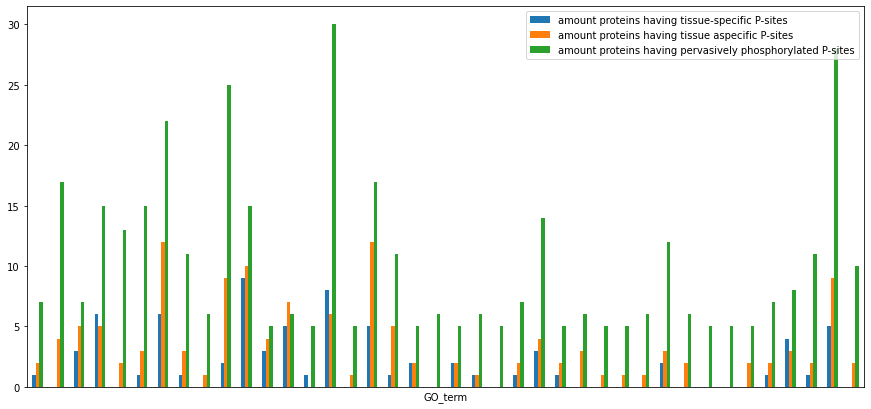

In [70]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Heart"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Heart"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Heart"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Heart"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Heart"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Heart"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### HeLa

66


<Figure size 1080x504 with 0 Axes>

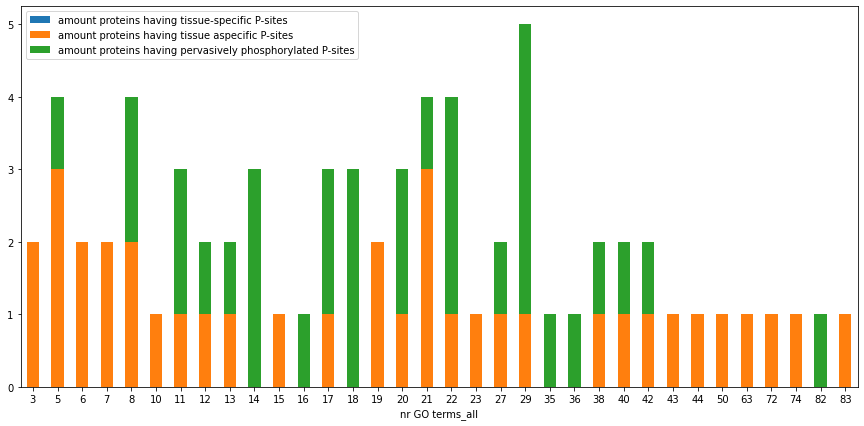

amount proteins having tissue-specific P-sites  nr GO terms_all  \
0                                              NaN                3   
1                                              NaN                5   
2                                              NaN                6   
3                                              NaN                7   
4                                              NaN                8   
5                                              NaN               10   
6                                              NaN               11   
7                                              NaN               12   
8                                              NaN               13   
28                                             NaN               14   
9                                              NaN               15   
29                                             NaN               16   
10                                             NaN               17   
30                                             NaN               18   
11                                             NaN               19   
12                                             NaN               20   
13                                             NaN               21   
14                                             NaN               22   
15                                             NaN               23   
16                                             NaN               27   
17                                             NaN               29   
31                                             NaN               35   
32                                             NaN               36   
18                                             NaN               38   
19                                             NaN               40   
20                                             NaN               42   
21                                             NaN               43   
22                                             NaN               44   
23                                             NaN               50   
24                                             NaN               63   
25                                             NaN               72   
26                                             NaN               74   
33                                             NaN               82   
27                                             NaN               83   

    amount proteins having tissue aspecific P-sites  \
0                                               2.0   
1                                               3.0   
2                                               2.0   
3                                               2.0   
4                                               2.0   
5                                               1.0   
6                                               1.0   
7                                               1.0   
8                                               1.0   
28                                              NaN   
9                                               1.0   
29                                              NaN   
10                                              1.0   
30                                              NaN   
11                                              2.0   
12                                              1.0   
13                                              3.0   
14                                              1.0   
15                                              1.0   
16                                              1.0   
17                                              1.0   
31                                              NaN   
32                                              NaN   
18                                              1.0   
19                                              1.0   
20                                              1.0   
21                               

In [71]:
print(data_protein[data_protein["Hela"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Hela"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Hela"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Hela"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
908    GO:0003677                                             0.0   
928    GO:0003723                                             0.0   
933    GO:0003729                                             0.0   
1074   GO:0004252                                             0.0   
1493   GO:0005509                                             0.0   
1518   GO:0005576                                             0.0   
1539   GO:0005615                                             0.0   
1541   GO:0005634                                             0.0   
1551   GO:0005654                                             0.0   
1580   GO:0005730                                             0.0   
1583   GO:0005737                                             0.0   
1639   GO:0005829                                             0.0   
1676   GO:0005886                                             0.0   
1697   GO:0005925                                             0.0   
1959   GO:0006508                                             0.0   
3395   GO:0016020                                             0.0   
3587   GO:0016607                                             0.0   
4131   GO:0030017                                             0.0   
4818   GO:0031982                                             0.0   
5220   GO:0032991                                             0.0   
6464   GO:0042802                                             0.0   
7046   GO:0045296                                             0.0   
9064   GO:0070062                                             0.0   
12161  GO:1990904                                             0.0   

       amount proteins having tissue aspecific P-sites  \
908                                                0.0   
928                                                7.0   
933                                                4.0   
1074                                               5.0   
1493                                               5.0   
1518                                               8.0   
1539                                              10.0   
1541                                              12.0   
1551                                               7.0   
1580                                               2.0   
1583                                              16.0   
1639                                              14.0   
1676                                               9.0   
1697                                               3.0   
1959                                               5.0   
3395                                               4.0   
3587                                               1.0   
4131                                               5.0   
4818                                               5.0   
5220                                               7.0   
6464                                               2.0   
7046                                               3.0   
9064                                              10.0   
12161                                              2.0   

       amount proteins having pervasively phosphorylated P-sites  
908                                                  6.0          
928                                                 18.0          
933                                                  5.0          
1074                                                 0.0          
1493                                                 1.0          
1518                                                 2.0          
1539                                                 4.0          
1541                                                20.0          
1551                                                13.0          
1580                                                 5.0          
1583                                                16.0          
1639                         

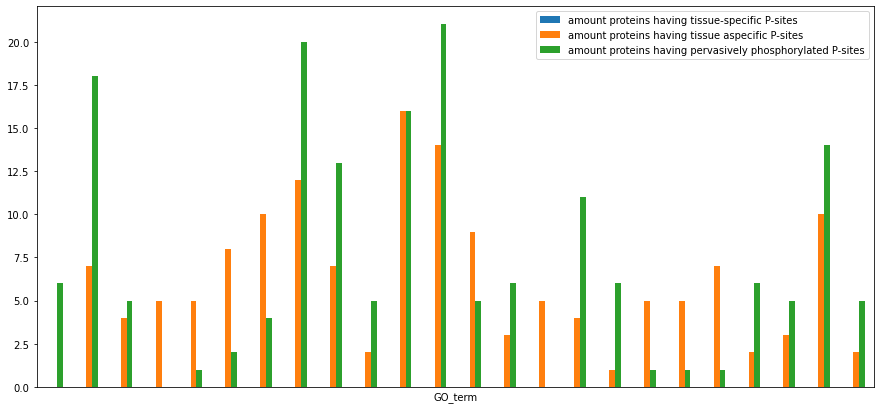

In [72]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Hela"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Hela"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Hela"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Hela"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Hela"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Hela"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Kidney

592


<Figure size 1080x504 with 0 Axes>

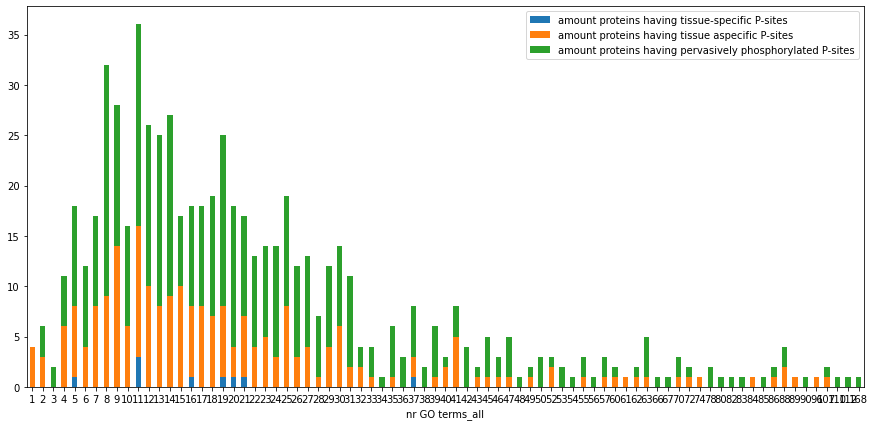

nr GO terms_all  amount proteins having tissue-specific P-sites  \
7                 1                                             NaN   
8                 2                                             NaN   
58                3                                             NaN   
9                 4                                             NaN   
0                 5                                             1.0   
..              ...                                             ...   
56               96                                             NaN   
57              107                                             NaN   
76              110                                             NaN   
77              112                                             NaN   
78              168                                             NaN   

    amount proteins having tissue aspecific P-sites  \
7                                               4.0   
8                                               3.0   
58                                              NaN   
9                                               6.0   
0                                               7.0   
..                                              ...   
56                                              1.0   
57                                              1.0   
76                                              NaN   
77                                              NaN   
78                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
7                                                 NaN            4.0  
8                                                 3.0            6.0  
58                                                2.0            2.0  
9                                                 5.0           11.0  
0                                                10.0           18.0  
..                                                ...            ...  
56                                                NaN            1.0  
57                                                1.0            2.0  
76                                                1.0            1.0  
77                                                1.0            1.0  
78                                                1.0            1.0  

[79 rows x 5 columns]

In [73]:
print(data_protein[data_protein["Kidney"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Kidney"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Kidney"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Kidney"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
908   GO:0003677                                             0.0   
928   GO:0003723                                             1.0   
943   GO:0003779                                             1.0   
1502  GO:0005524                                             0.0   
1518  GO:0005576                                             2.0   
1539  GO:0005615                                             2.0   
1541  GO:0005634                                             4.0   
1551  GO:0005654                                             1.0   
1580  GO:0005730                                             0.0   
1583  GO:0005737                                             1.0   
1584  GO:0005739                                             0.0   
1639  GO:0005829                                             2.0   
1656  GO:0005856                                             0.0   
1676  GO:0005886                                             1.0   
1697  GO:0005925                                             0.0   
2275  GO:0007165                                             0.0   
3395  GO:0016020                                             1.0   
3400  GO:0016032                                             0.0   
3925  GO:0019901                                             0.0   
5220  GO:0032991                                             0.0   
6464  GO:0042802                                             0.0   
7046  GO:0045296                                             0.0   
7453  GO:0046872                                             2.0   
7687  GO:0048471                                             0.0   
9064  GO:0070062                                             3.0   

      amount proteins having tissue aspecific P-sites  \
908                                               9.0   
928                                              43.0   
943                                              10.0   
1502                                             34.0   
1518                                             28.0   
1539                                             26.0   
1541                                             74.0   
1551                                             55.0   
1580                                             20.0   
1583                                             81.0   
1584                                             38.0   
1639                                            106.0   
1656                                             10.0   
1676                                             63.0   
1697                                             24.0   
2275                                             11.0   
3395                                             53.0   
3400                                             14.0   
3925                                             10.0   
5220                                             16.0   
6464                                             29.0   
7046                                             19.0   
7453                                             22.0   
7687                                             19.0   
9064                                             85.0   

      amount proteins having pervasively phosphorylated P-sites  
908                                                31.0          
928                                               130.0          
943                                                31.0          
1502                                               67.0          
1518                                               39.0          
1539                                               44.0          
1541                                              194.0          
1551                                              153.0          
1580                                               47.0          
1583                                              185.0          
1584                           

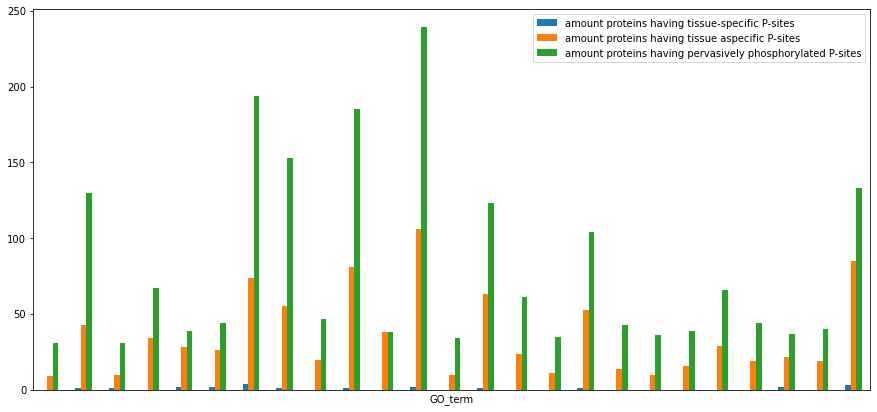

In [74]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Kidney"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Kidney"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Kidney"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Kidney"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Kidney"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Kidney"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)]

### Liver

1659


<Figure size 1080x504 with 0 Axes>

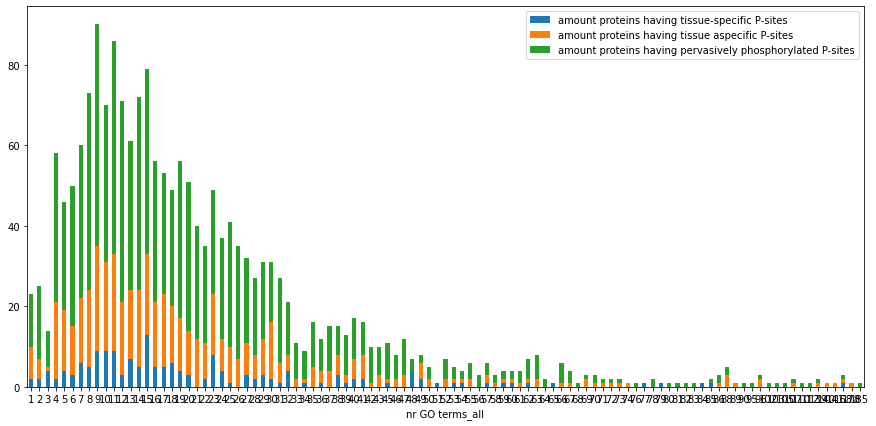

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                  1                                             2.0   
1                  2                                             2.0   
2                  3                                             4.0   
3                  4                                             2.0   
4                  5                                             4.0   
..               ...                                             ...   
81               140                                             NaN   
82               141                                             NaN   
51               168                                             1.0   
83               178                                             NaN   
100              185                                             NaN   

     amount proteins having tissue aspecific P-sites  \
0                                                8.0   
1                                                5.0   
2                                                1.0   
3                                               19.0   
4                                               15.0   
..                                               ...   
81                                               1.0   
82                                               1.0   
51                                               1.0   
83                                               1.0   
100                                              NaN   

     amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 13.0           23.0  
1                                                 18.0           25.0  
2                                                  9.0           14.0  
3                                                 37.0           58.0  
4                                                 27.0           46.0  
..                                                 ...            ...  
81                                                 NaN            1.0  
82                                                 NaN            1.0  
51                                                 1.0            3.0  
83                                                 NaN            1.0  
100                                                1.0            1.0  

[101 rows x 5 columns]

In [75]:
print(data_protein[data_protein["Liver"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Liver"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Liver"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Liver"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
39     GO:0000122                                             4.0   
48     GO:0000139                                             9.0   
56     GO:0000165                                             3.0   
76     GO:0000226                                             0.0   
93     GO:0000287                                             1.0   
...           ...                                             ...   
9834   GO:0072562                                            13.0   
10495  GO:0098978                                             5.0   
10695  GO:0106310                                             1.0   
10696  GO:0106311                                             1.0   
12161  GO:1990904                                             8.0   

       amount proteins having tissue aspecific P-sites  \
39                                                31.0   
48                                                21.0   
56                                                12.0   
76                                                15.0   
93                                                 7.0   
...                                                ...   
9834                                               8.0   
10495                                             17.0   
10695                                             21.0   
10696                                             21.0   
12161                                             20.0   

       amount proteins having pervasively phosphorylated P-sites  
39                                                  48.0          
48                                                  35.0          
56                                                  41.0          
76                                                  44.0          
93                                                  35.0          
...                                                  ...          
9834                                                35.0          
10495                                               57.0          
10695                                               71.0          
10696                                               71.0          
12161                                               37.0          

[115 rows x 4 columns]

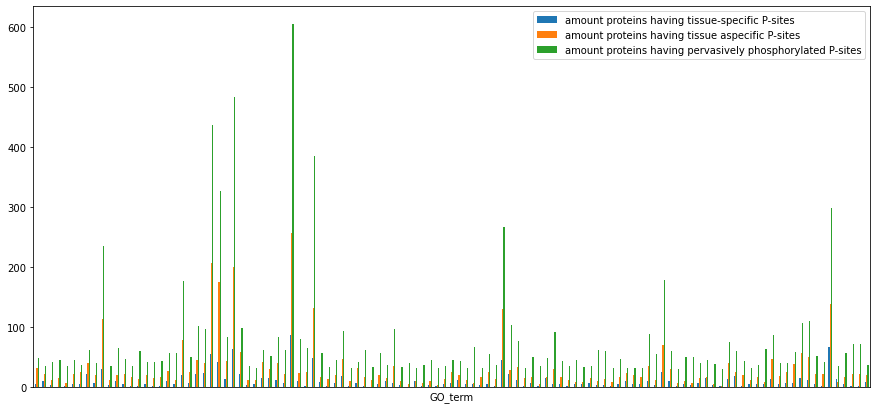

In [76]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Liver"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Liver"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Liver"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Liver"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Liver"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Liver"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)]

### Lung

2028


<Figure size 1080x504 with 0 Axes>

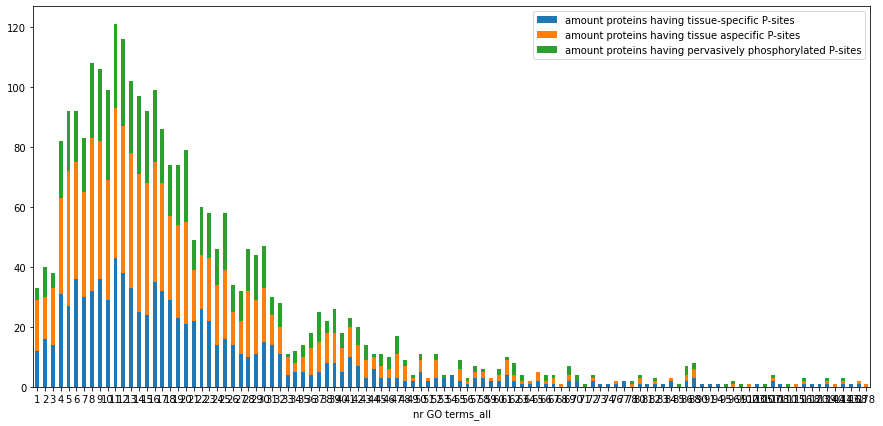

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                  1                                            12.0   
1                  2                                            16.0   
2                  3                                            14.0   
3                  4                                            31.0   
4                  5                                            27.0   
..               ...                                             ...   
99               140                                             NaN   
91               141                                             1.0   
92               143                                             1.0   
93               168                                             1.0   
100              178                                             NaN   

     amount proteins having tissue aspecific P-sites  \
0                                               17.0   
1                                               14.0   
2                                               19.0   
3                                               32.0   
4                                               45.0   
..                                               ...   
99                                               1.0   
91                                               1.0   
92                                               NaN   
93                                               1.0   
100                                              1.0   

     amount proteins having pervasively phosphorylated P-sites  Total  
0                                                  4.0           33.0  
1                                                 10.0           40.0  
2                                                  5.0           38.0  
3                                                 19.0           82.0  
4                                                 20.0           92.0  
..                                                 ...            ...  
99                                                 NaN            1.0  
91                                                 1.0            3.0  
92                                                 NaN            1.0  
93                                                 NaN            2.0  
100                                                NaN            1.0  

[107 rows x 5 columns]

In [77]:
print(data_protein[data_protein["Lung"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Lung"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Lung"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Lung"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
39     GO:0000122                                            53.0   
56     GO:0000165                                            32.0   
76     GO:0000226                                            27.0   
128    GO:0000398                                            35.0   
198    GO:0000785                                            53.0   
...           ...                                             ...   
9064   GO:0070062                                           179.0   
10495  GO:0098978                                            30.0   
10695  GO:0106310                                            61.0   
10696  GO:0106311                                            61.0   
12161  GO:1990904                                            22.0   

       amount proteins having tissue aspecific P-sites  \
39                                                70.0   
56                                                36.0   
76                                                29.0   
128                                               53.0   
198                                               67.0   
...                                                ...   
9064                                             206.0   
10495                                             20.0   
10695                                             76.0   
10696                                             76.0   
12161                                             29.0   

       amount proteins having pervasively phosphorylated P-sites  
39                                                  40.0          
56                                                  23.0          
76                                                  32.0          
128                                                 41.0          
198                                                 33.0          
...                                                  ...          
9064                                               165.0          
10495                                               15.0          
10695                                               42.0          
10696                                               42.0          
12161                                               31.0          

[104 rows x 4 columns]

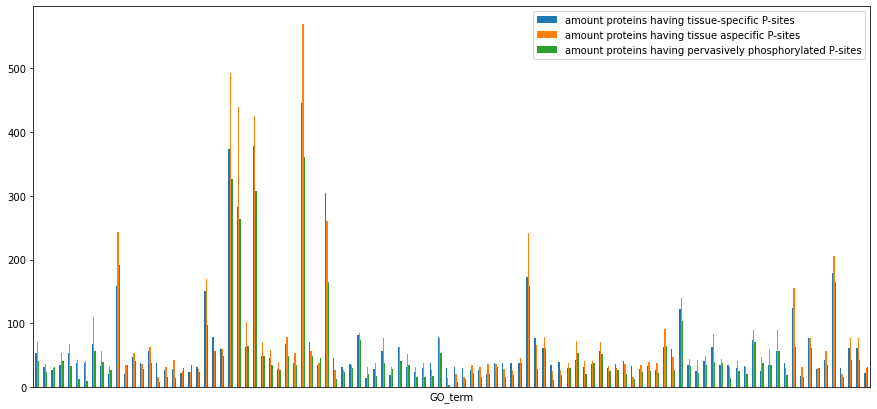

In [78]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Lung"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Lung"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Lung"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Lung"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Lung"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Lung"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)]

### Lymph node

2631


<Figure size 1080x504 with 0 Axes>

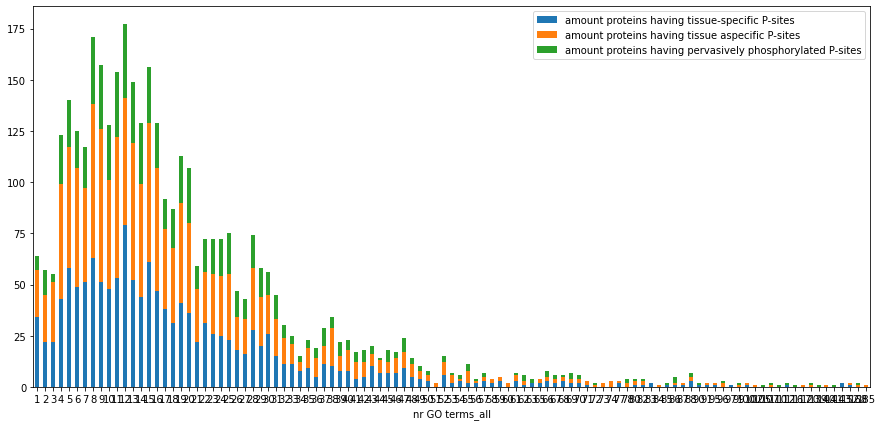

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                  1                                            34.0   
1                  2                                            22.0   
2                  3                                            22.0   
3                  4                                            43.0   
4                  5                                            58.0   
..               ...                                             ...   
104              141                                             NaN   
82               143                                             2.0   
83               152                                             1.0   
98               168                                             NaN   
99               185                                             NaN   

     amount proteins having tissue aspecific P-sites  \
0                                               23.0   
1                                               23.0   
2                                               29.0   
3                                               56.0   
4                                               59.0   
..                                               ...   
104                                              NaN   
82                                               NaN   
83                                               1.0   
98                                               1.0   
99                                               1.0   

     amount proteins having pervasively phosphorylated P-sites  Total  
0                                                  7.0           64.0  
1                                                 12.0           57.0  
2                                                  4.0           55.0  
3                                                 24.0          123.0  
4                                                 23.0          140.0  
..                                                 ...            ...  
104                                                1.0            1.0  
82                                                 NaN            2.0  
83                                                 NaN            2.0  
98                                                 1.0            2.0  
99                                                 NaN            1.0  

[105 rows x 5 columns]

In [79]:
print(data_protein[data_protein["Lymph node"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Lymph node"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Lymph node"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Lymph node"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
39     GO:0000122                                            87.0   
48     GO:0000139                                            45.0   
56     GO:0000165                                            30.0   
93     GO:0000287                                            22.0   
128    GO:0000398                                            40.0   
...           ...                                             ...   
10495  GO:0098978                                            26.0   
10695  GO:0106310                                            58.0   
10696  GO:0106311                                            58.0   
12148  GO:1990837                                            35.0   
12161  GO:1990904                                            23.0   

       amount proteins having tissue aspecific P-sites  \
39                                               112.0   
48                                                46.0   
56                                                34.0   
93                                                32.0   
128                                               68.0   
...                                                ...   
10495                                             33.0   
10695                                             82.0   
10696                                             82.0   
12148                                             26.0   
12161                                             35.0   

       amount proteins having pervasively phosphorylated P-sites  
39                                                  47.0          
48                                                  24.0          
56                                                  25.0          
93                                                  22.0          
128                                                 47.0          
...                                                  ...          
10495                                               15.0          
10695                                               49.0          
10696                                               49.0          
12148                                                5.0          
12161                                               32.0          

[146 rows x 4 columns]

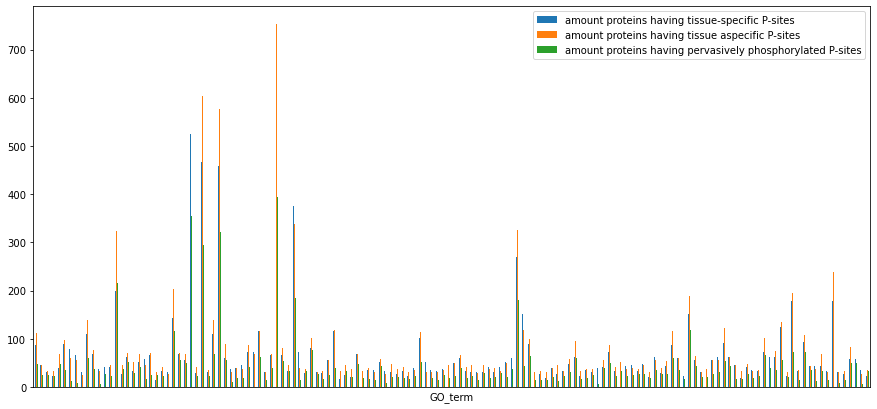

In [80]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Lymph node"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Lymph node"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Lymph node"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Lymph node"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Lymph node"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Lymph node"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)]

### Menstrual fluid

11


<Figure size 1080x504 with 0 Axes>

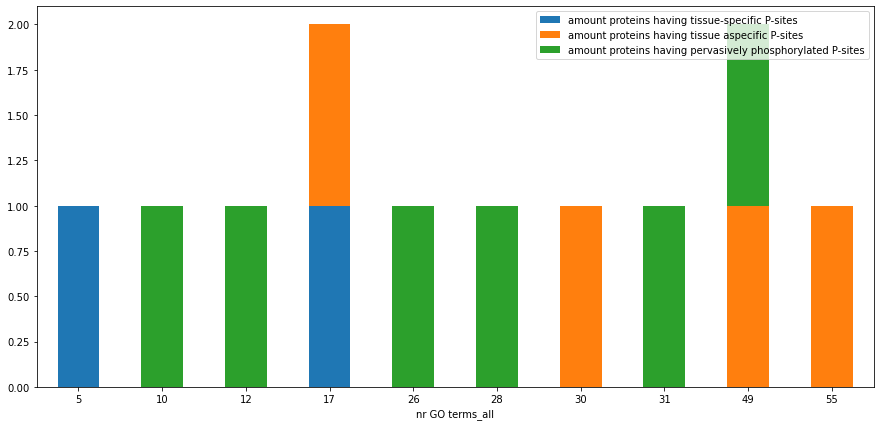

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                5                                             1.0   
5               10                                             NaN   
6               12                                             NaN   
1               17                                             1.0   
7               26                                             NaN   
8               28                                             NaN   
2               30                                             NaN   
9               31                                             NaN   
3               49                                             NaN   
4               55                                             NaN   

   amount proteins having tissue aspecific P-sites  \
0                                              NaN   
5                                              NaN   
6                                              NaN   
1                                              1.0   
7                                              NaN   
8                                              NaN   
2                                              1.0   
9                                              NaN   
3                                              1.0   
4                                              1.0   

   amount proteins having pervasively phosphorylated P-sites  Total  
0                                                NaN            1.0  
5                                                1.0            1.0  
6                                                1.0            1.0  
1                                                NaN            2.0  
7                                                1.0            1.0  
8                                                1.0            1.0  
2                                                NaN            1.0  
9                                                1.0            1.0  
3                                                1.0            2.0  
4                                                NaN            1.0

In [81]:
print(data_protein[data_protein["Menstrual fluid"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Menstrual fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Menstrual fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Menstrual fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
1518  GO:0005576                                             1.0   
1539  GO:0005615                                             1.0   
9064  GO:0070062                                             0.0   
9834  GO:0072562                                             0.0   

      amount proteins having tissue aspecific P-sites  \
1518                                              3.0   
1539                                              3.0   
9064                                              3.0   
9834                                              3.0   

      amount proteins having pervasively phosphorylated P-sites  
1518                                                6.0          
1539                                                5.0          
9064                                                6.0          
9834                                                5.0

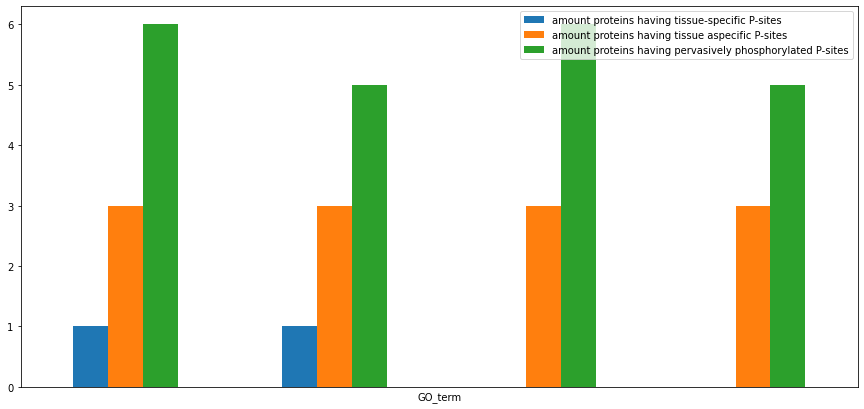

In [82]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Menstrual fluid"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Menstrual fluid"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Menstrual fluid"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Menstrual fluid"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Menstrual fluid"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Menstrual fluid"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Monocytes

890


<Figure size 1080x504 with 0 Axes>

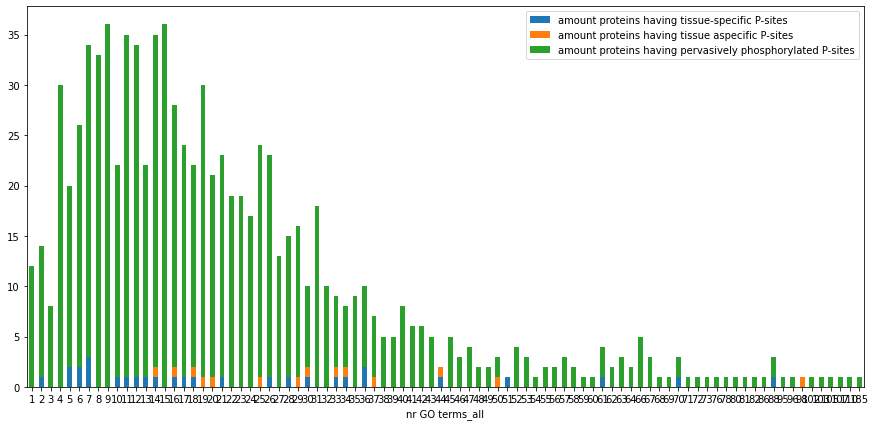

nr GO terms_all  amount proteins having tissue-specific P-sites  \
31                1                                             NaN   
0                 2                                             1.0   
32                3                                             NaN   
33                4                                             NaN   
1                 5                                             2.0   
..              ...                                             ...   
83              103                                             NaN   
84              105                                             NaN   
85              107                                             NaN   
86              110                                             NaN   
87              185                                             NaN   

    amount proteins having tissue aspecific P-sites  \
31                                              NaN   
0                                               NaN   
32                                              NaN   
33                                              NaN   
1                                               NaN   
..                                              ...   
83                                              NaN   
84                                              NaN   
85                                              NaN   
86                                              NaN   
87                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
31                                               12.0           12.0  
0                                                13.0           14.0  
32                                                8.0            8.0  
33                                               30.0           30.0  
1                                                18.0           20.0  
..                                                ...            ...  
83                                                1.0            1.0  
84                                                1.0            1.0  
85                                                1.0            1.0  
86                                                1.0            1.0  
87                                                1.0            1.0  

[88 rows x 5 columns]

In [83]:
print(data_protein[data_protein["Monocytes"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Monocytes"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Monocytes"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Monocytes"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
30     GO:0000086                                             0.0   
39     GO:0000122                                             1.0   
48     GO:0000139                                             2.0   
51     GO:0000149                                             0.0   
56     GO:0000165                                             1.0   
...           ...                                             ...   
11514  GO:1903779                                             0.0   
11598  GO:1904115                                             0.0   
11751  GO:1904813                                             5.0   
12161  GO:1990904                                             0.0   
12271  GO:2000300                                             0.0   

       amount proteins having tissue aspecific P-sites  \
30                                                 0.0   
39                                                 1.0   
48                                                 0.0   
51                                                 0.0   
56                                                 0.0   
...                                                ...   
11514                                              0.0   
11598                                              0.0   
11751                                              0.0   
12161                                              0.0   
12271                                              0.0   

       amount proteins having pervasively phosphorylated P-sites  
30                                                  22.0          
39                                                  18.0          
48                                                  25.0          
51                                                  14.0          
56                                                  30.0          
...                                                  ...          
11514                                               13.0          
11598                                               11.0          
11751                                               18.0          
12161                                               18.0          
12271                                               12.0          

[323 rows x 4 columns]

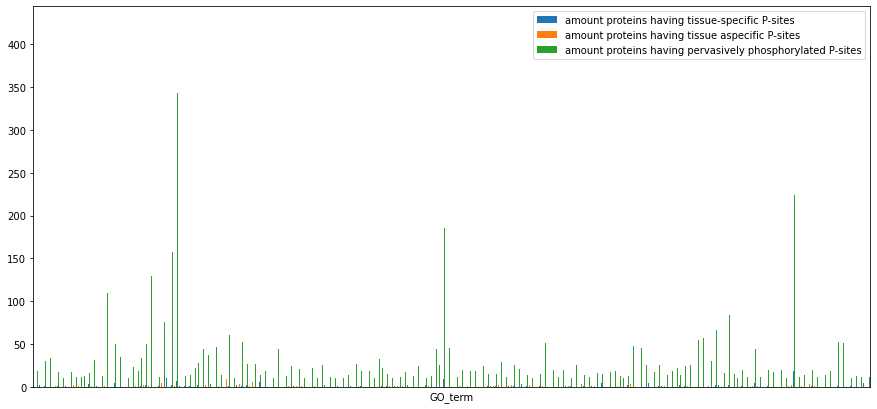

In [84]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Monocytes"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Monocytes"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Monocytes"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Monocytes"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Monocytes"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Monocytes"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Nasal polyps

108


<Figure size 1080x504 with 0 Axes>

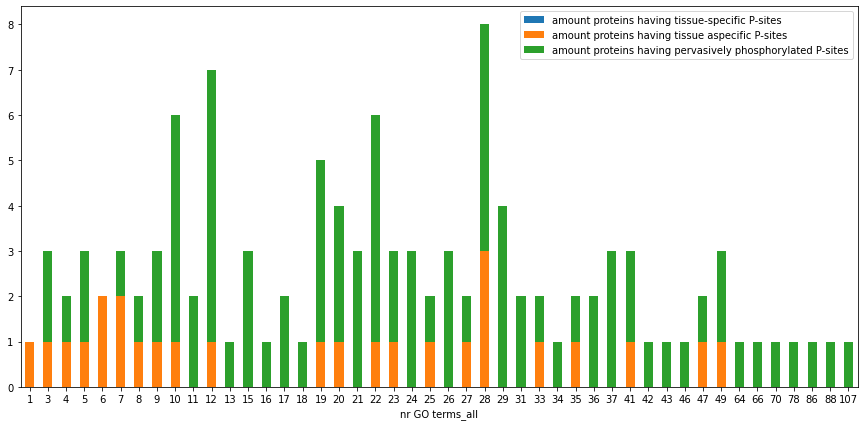

amount proteins having tissue-specific P-sites  nr GO terms_all  \
0                                              NaN                1   
1                                              NaN                3   
2                                              NaN                4   
3                                              NaN                5   
4                                              NaN                6   
5                                              NaN                7   
6                                              NaN                8   
7                                              NaN                9   
8                                              NaN               10   
22                                             NaN               11   
9                                              NaN               12   
23                                             NaN               13   
24                                             NaN               15   
25                                             NaN               16   
26                                             NaN               17   
27                                             NaN               18   
10                                             NaN               19   
11                                             NaN               20   
28                                             NaN               21   
12                                             NaN               22   
13                                             NaN               23   
29                                             NaN               24   
14                                             NaN               25   
30                                             NaN               26   
15                                             NaN               27   
16                                             NaN               28   
31                                             NaN               29   
32                                             NaN               31   
17                                             NaN               33   
33                                             NaN               34   
18                                             NaN               35   
34                                             NaN               36   
35                                             NaN               37   
19                                             NaN               41   
36                                             NaN               42   
37                                             NaN               43   
38                                             NaN               46   
20                                             NaN               47   
21                                             NaN               49   
39                                             NaN               64   
40                                             NaN               66   
41                                             NaN               70   
42                                             NaN               78   
43                                             NaN               86   
44                                             NaN               88   
45                                             NaN              107   

    amount proteins having tissue aspecific P-sites  \
0                                               1.0   
1                                               1.0   
2                                               1.0   
3                                               1.0   
4                                               2.0   
5                                               2.0   
6                                               1.0   
7                                               1.0   
8                                               1.0   
22                                              NaN   
9                                               1.0   
23    

In [85]:
print(data_protein[data_protein["Nasal polyps"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Nasal polyps"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Nasal polyps"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Nasal polyps"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
462   GO:0001895                                             0.0   
770   GO:0002862                                             0.0   
928   GO:0003723                                             0.0   
947   GO:0003823                                             0.0   
1425  GO:0005198                                             0.0   
1502  GO:0005524                                             0.0   
1518  GO:0005576                                             0.0   
1539  GO:0005615                                             0.0   
1541  GO:0005634                                             0.0   
1551  GO:0005654                                             0.0   
1583  GO:0005737                                             0.0   
1619  GO:0005788                                             0.0   
1639  GO:0005829                                             0.0   
1676  GO:0005886                                             0.0   
1697  GO:0005925                                             0.0   
2153  GO:0006898                                             0.0   
2160  GO:0006910                                             0.0   
2161  GO:0006911                                             0.0   
2184  GO:0006958                                             0.0   
2801  GO:0009897                                             0.0   
3309  GO:0015629                                             0.0   
3395  GO:0016020                                             0.0   
3711  GO:0018149                                             0.0   
5220  GO:0032991                                             0.0   
5690  GO:0034987                                             0.0   
6165  GO:0038096                                             0.0   
6383  GO:0042571                                             0.0   
6437  GO:0042742                                             0.0   
6464  GO:0042802                                             0.0   
6772  GO:0043687                                             0.0   
6846  GO:0044267                                             0.0   
6977  GO:0045087                                             0.0   
7046  GO:0045296                                             0.0   
7453  GO:0046872                                             0.0   
7687  GO:0048471                                             0.0   
7963  GO:0050853                                             0.0   
7977  GO:0050871                                             0.0   
9018  GO:0062023                                             0.0   
9064  GO:0070062                                             0.0   
9834  GO:0072562                                             0.0   

      amount proteins having tissue aspecific P-sites  \
462                                               1.0   
770                                               2.0   
928                                               1.0   
947                                               2.0   
1425                                              3.0   
1502                                              4.0   
1518                                             11.0   
1539                                             10.0   
1541                                              2.0   
1551                                              1.0   
1583                                              2.0   
1619                                              7.0   
1639                                              4.0   
1676                                              5.0   
1697                                              1.0   
2153                                              3.0   
2160                                              2.0   
2161                                              2.0   
2184                                              2.0   
2801                                              4.0   
3309                   

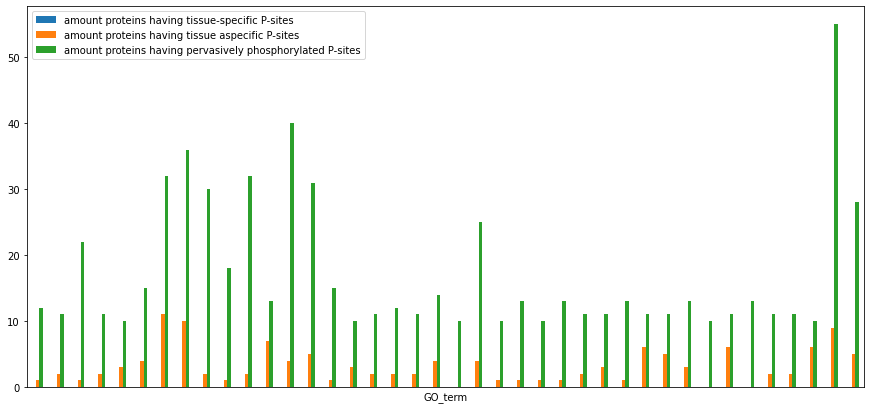

In [86]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Nasal polyps"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Nasal polyps"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Nasal polyps"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Nasal polyps"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Nasal polyps"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Nasal polyps"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### NK-cells

242


<Figure size 1080x504 with 0 Axes>

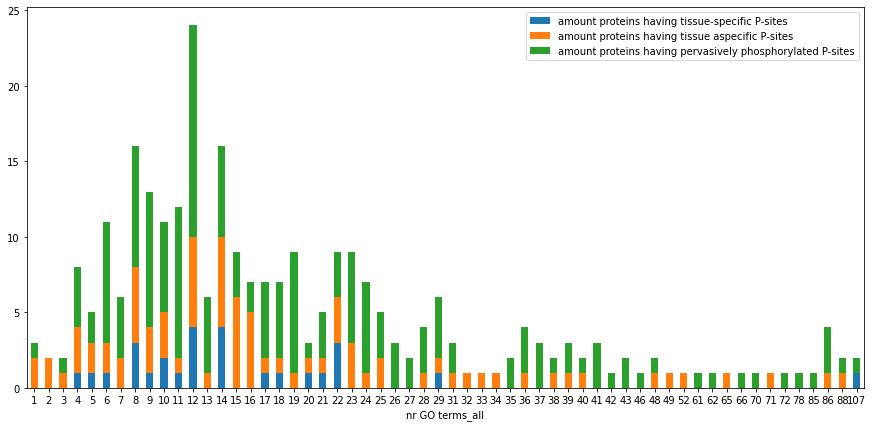

nr GO terms_all  amount proteins having tissue-specific P-sites  \
16                1                                             NaN   
17                2                                             NaN   
18                3                                             NaN   
0                 4                                             1.0   
1                 5                                             1.0   
2                 6                                             1.0   
19                7                                             NaN   
3                 8                                             3.0   
4                 9                                             1.0   
5                10                                             2.0   
6                11                                             1.0   
7                12                                             4.0   
20               13                                             NaN   
8                14                                             4.0   
21               15                                             NaN   
22               16                                             NaN   
9                17                                             1.0   
10               18                                             1.0   
23               19                                             NaN   
11               20                                             1.0   
12               21                                             1.0   
13               22                                             3.0   
24               23                                             NaN   
25               24                                             NaN   
26               25                                             NaN   
43               26                                             NaN   
44               27                                             NaN   
27               28                                             NaN   
14               29                                             1.0   
28               31                                             NaN   
29               32                                             NaN   
30               33                                             NaN   
31               34                                             NaN   
45               35                                             NaN   
32               36                                             NaN   
46               37                                             NaN   
33               38                                             NaN   
34               39                                             NaN   
35               40                                             NaN   
47               41                                             NaN   
48               42                                             NaN   
49               43                                             NaN   
50               46                                             NaN   
36               48                                             NaN   
37               49                                             NaN   
38               52                                             NaN   
51               61                                             NaN   
52               62                                             NaN   
39               65                                             NaN   
53               66                                             NaN   
54               70                                             NaN   
40               71                                             NaN   
55               72                                             NaN   
56               78                                             NaN   
57               85                                             NaN   
41               86         

In [87]:
print(data_protein[data_protein["NK-cells"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["NK-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["NK-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["NK-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
39     GO:0000122                                             2.0   
128    GO:0000398                                             1.0   
198    GO:0000785                                             3.0   
908    GO:0003677                                             1.0   
928    GO:0003723                                             4.0   
933    GO:0003729                                             1.0   
1502   GO:0005524                                             1.0   
1518   GO:0005576                                             4.0   
1541   GO:0005634                                             7.0   
1551   GO:0005654                                             6.0   
1580   GO:0005730                                             2.0   
1583   GO:0005737                                             8.0   
1584   GO:0005739                                             1.0   
1624   GO:0005794                                             2.0   
1639   GO:0005829                                             9.0   
1656   GO:0005856                                             3.0   
1676   GO:0005886                                             8.0   
1697   GO:0005925                                             2.0   
1874   GO:0006357                                             3.0   
1896   GO:0006397                                             1.0   
2275   GO:0007165                                             4.0   
2588   GO:0008380                                             1.0   
3309   GO:0015629                                             0.0   
3395   GO:0016020                                            10.0   
3400   GO:0016032                                             1.0   
3585   GO:0016604                                             0.0   
3587   GO:0016607                                             2.0   
4815   GO:0031965                                             0.0   
5220   GO:0032991                                             1.0   
6464   GO:0042802                                             3.0   
6465   GO:0042803                                             1.0   
6636   GO:0043312                                             4.0   
7046   GO:0045296                                             2.0   
7228   GO:0045892                                             1.0   
7252   GO:0045944                                             2.0   
7453   GO:0046872                                             4.0   
7687   GO:0048471                                             1.0   
8030   GO:0051015                                             1.0   
9064   GO:0070062                                             6.0   
12161  GO:1990904                                             0.0   

       amount proteins having tissue aspecific P-sites  \
39                                                 3.0   
128                                                9.0   
198                                                5.0   
908                                               11.0   
928                                               25.0   
933                                                4.0   
1502                                               7.0   
1518                                               9.0   
1541                                              42.0   
1551                                              28.0   
1580                                               7.0   
1583                                              34.0   
1584                                               3.0   
1624                                               3.0   
1639                                              33.0   
1656                                               4.0   
1676                                              20.0   
1697                                               7.0   
1874                                               7.0   
1896                

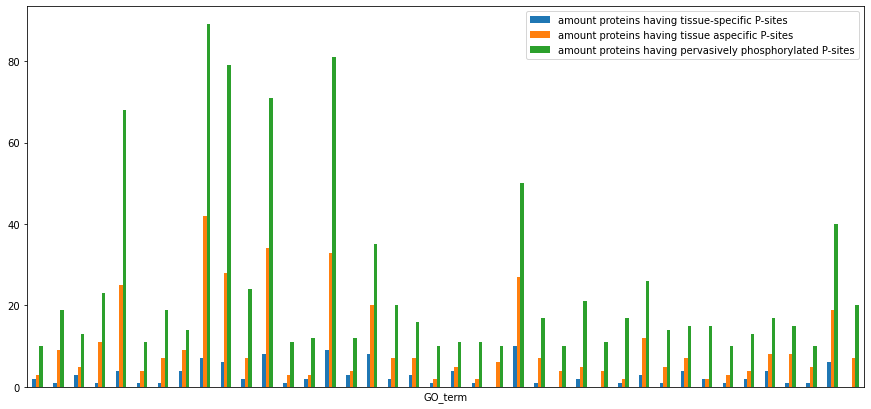

In [88]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["NK-cells"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["NK-cells"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["NK-cells"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["NK-cells"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["NK-cells"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["NK-cells"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Ovary

867


<Figure size 1080x504 with 0 Axes>

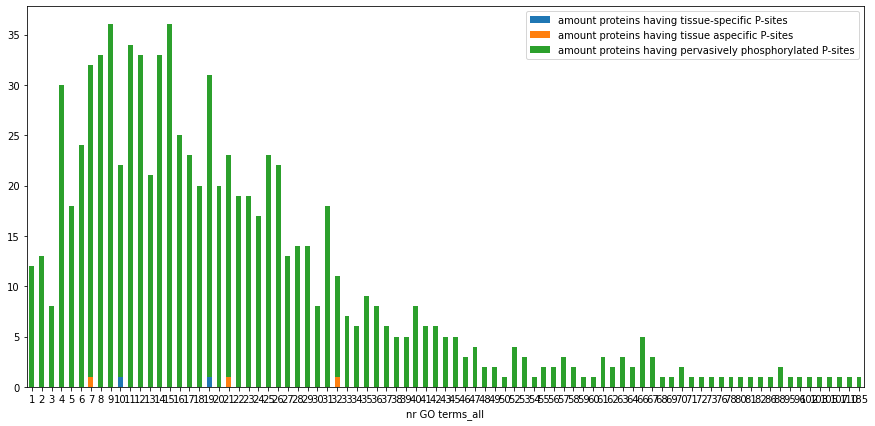

nr GO terms_all  amount proteins having tissue-specific P-sites  \
5                 1                                             NaN   
6                 2                                             NaN   
7                 3                                             NaN   
8                 4                                             NaN   
9                 5                                             NaN   
..              ...                                             ...   
80              103                                             NaN   
81              105                                             NaN   
82              107                                             NaN   
83              110                                             NaN   
84              185                                             NaN   

    amount proteins having tissue aspecific P-sites  \
5                                               NaN   
6                                               NaN   
7                                               NaN   
8                                               NaN   
9                                               NaN   
..                                              ...   
80                                              NaN   
81                                              NaN   
82                                              NaN   
83                                              NaN   
84                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
5                                                  12           12.0  
6                                                  13           13.0  
7                                                   8            8.0  
8                                                  30           30.0  
9                                                  18           18.0  
..                                                ...            ...  
80                                                  1            1.0  
81                                                  1            1.0  
82                                                  1            1.0  
83                                                  1            1.0  
84                                                  1            1.0  

[85 rows x 5 columns]

In [89]:
print(data_protein[data_protein["Ovary"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Ovary"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Ovary"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Ovary"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
30     GO:0000086                                             0.0   
39     GO:0000122                                             0.0   
48     GO:0000139                                             0.0   
51     GO:0000149                                             0.0   
56     GO:0000165                                             0.0   
...           ...                                             ...   
11514  GO:1903779                                             0.0   
11598  GO:1904115                                             0.0   
11751  GO:1904813                                             0.0   
12161  GO:1990904                                             0.0   
12271  GO:2000300                                             0.0   

       amount proteins having tissue aspecific P-sites  \
30                                                 0.0   
39                                                 0.0   
48                                                 0.0   
51                                                 0.0   
56                                                 0.0   
...                                                ...   
11514                                              0.0   
11598                                              0.0   
11751                                              0.0   
12161                                              0.0   
12271                                              0.0   

       amount proteins having pervasively phosphorylated P-sites  
30                                                  22.0          
39                                                  18.0          
48                                                  25.0          
51                                                  14.0          
56                                                  30.0          
...                                                  ...          
11514                                               13.0          
11598                                               11.0          
11751                                               18.0          
12161                                               18.0          
12271                                               12.0          

[323 rows x 4 columns]

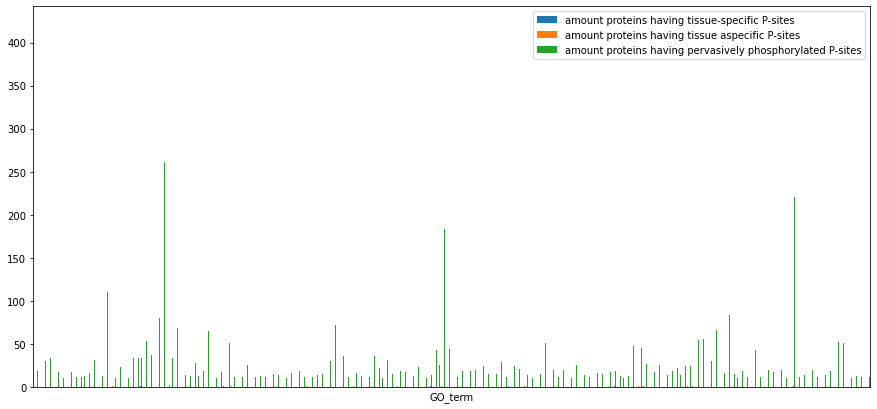

In [90]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Ovary"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Ovary"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Ovary"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Ovary"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Ovary"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Ovary"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Pancreas

977


<Figure size 1080x504 with 0 Axes>

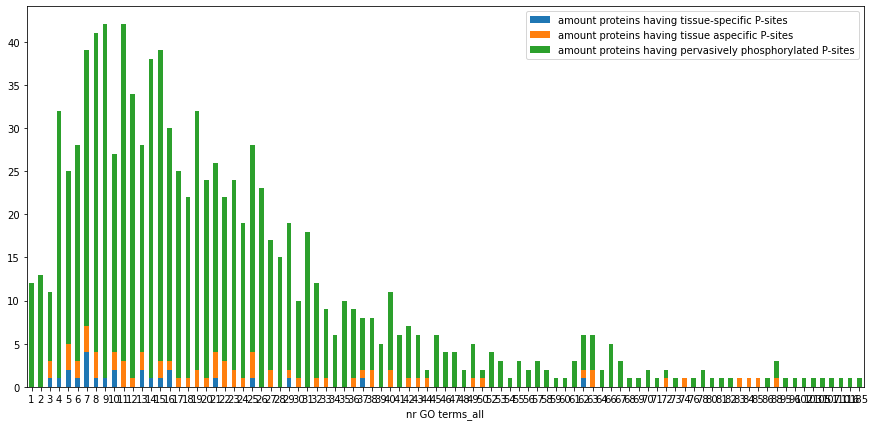

nr GO terms_all  amount proteins having tissue-specific P-sites  \
45                1                                             NaN   
46                2                                             NaN   
0                 3                                             1.0   
1                 4                                             1.0   
2                 5                                             2.0   
..              ...                                             ...   
86              105                                             NaN   
87              107                                             NaN   
88              110                                             NaN   
89              116                                             NaN   
90              185                                             NaN   

    amount proteins having tissue aspecific P-sites  \
45                                              NaN   
46                                              NaN   
0                                               2.0   
1                                               NaN   
2                                               3.0   
..                                              ...   
86                                              NaN   
87                                              NaN   
88                                              NaN   
89                                              NaN   
90                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
45                                               12.0           12.0  
46                                               13.0           13.0  
0                                                 8.0           11.0  
1                                                31.0           32.0  
2                                                20.0           25.0  
..                                                ...            ...  
86                                                1.0            1.0  
87                                                1.0            1.0  
88                                                1.0            1.0  
89                                                1.0            1.0  
90                                                1.0            1.0  

[91 rows x 5 columns]

In [91]:
print(data_protein[data_protein["Pancreas"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Pancreas"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Pancreas"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Pancreas"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
30     GO:0000086                                             0.0   
39     GO:0000122                                             0.0   
48     GO:0000139                                             0.0   
51     GO:0000149                                             0.0   
56     GO:0000165                                             1.0   
...           ...                                             ...   
11514  GO:1903779                                             0.0   
11598  GO:1904115                                             0.0   
11751  GO:1904813                                             0.0   
12161  GO:1990904                                             1.0   
12271  GO:2000300                                             0.0   

       amount proteins having tissue aspecific P-sites  \
30                                                 2.0   
39                                                 3.0   
48                                                 2.0   
51                                                 0.0   
56                                                 2.0   
...                                                ...   
11514                                              1.0   
11598                                              0.0   
11751                                              2.0   
12161                                              6.0   
12271                                              2.0   

       amount proteins having pervasively phosphorylated P-sites  
30                                                  25.0          
39                                                  25.0          
48                                                  28.0          
51                                                  14.0          
56                                                  31.0          
...                                                  ...          
11514                                               13.0          
11598                                               11.0          
11751                                               19.0          
12161                                               25.0          
12271                                               12.0          

[355 rows x 4 columns]

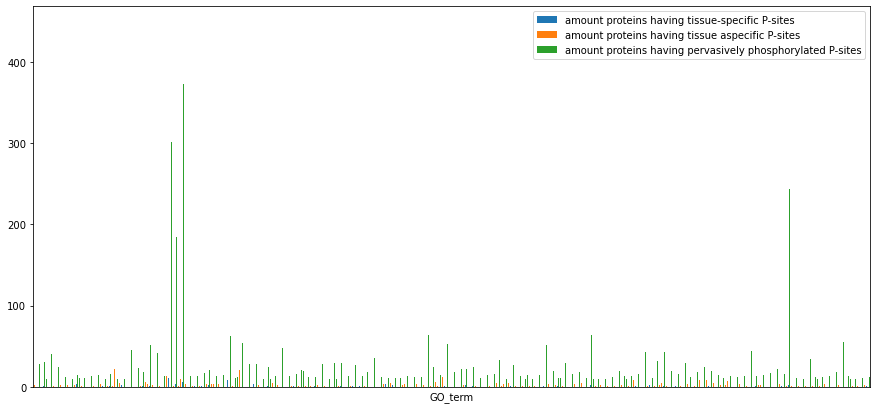

In [92]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Pancreas"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Pancreas"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Pancreas"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Pancreas"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Pancreas"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Pancreas"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Palatine tonsils

108


<Figure size 1080x504 with 0 Axes>

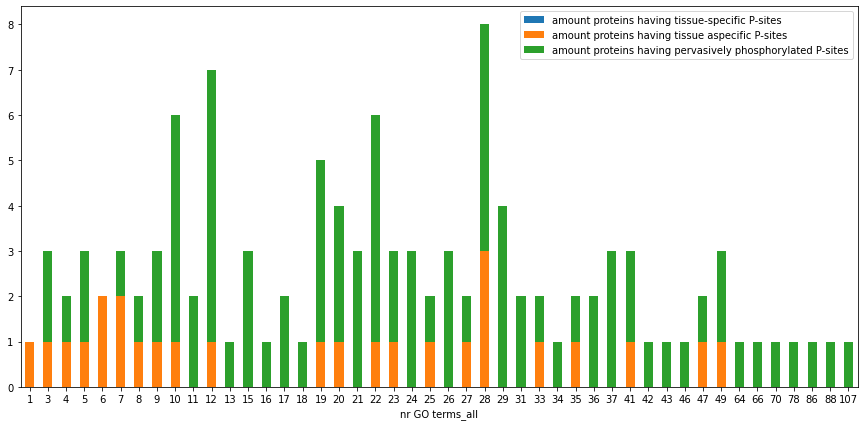

amount proteins having tissue-specific P-sites  nr GO terms_all  \
0                                              NaN                1   
1                                              NaN                3   
2                                              NaN                4   
3                                              NaN                5   
4                                              NaN                6   
5                                              NaN                7   
6                                              NaN                8   
7                                              NaN                9   
8                                              NaN               10   
22                                             NaN               11   
9                                              NaN               12   
23                                             NaN               13   
24                                             NaN               15   
25                                             NaN               16   
26                                             NaN               17   
27                                             NaN               18   
10                                             NaN               19   
11                                             NaN               20   
28                                             NaN               21   
12                                             NaN               22   
13                                             NaN               23   
29                                             NaN               24   
14                                             NaN               25   
30                                             NaN               26   
15                                             NaN               27   
16                                             NaN               28   
31                                             NaN               29   
32                                             NaN               31   
17                                             NaN               33   
33                                             NaN               34   
18                                             NaN               35   
34                                             NaN               36   
35                                             NaN               37   
19                                             NaN               41   
36                                             NaN               42   
37                                             NaN               43   
38                                             NaN               46   
20                                             NaN               47   
21                                             NaN               49   
39                                             NaN               64   
40                                             NaN               66   
41                                             NaN               70   
42                                             NaN               78   
43                                             NaN               86   
44                                             NaN               88   
45                                             NaN              107   

    amount proteins having tissue aspecific P-sites  \
0                                               1.0   
1                                               1.0   
2                                               1.0   
3                                               1.0   
4                                               2.0   
5                                               2.0   
6                                               1.0   
7                                               1.0   
8                                               1.0   
22                                              NaN   
9                                               1.0   
23    

In [93]:
print(data_protein[data_protein["Palatine tonsils"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Palatine tonsils"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Palatine tonsils"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Palatine tonsils"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
462   GO:0001895                                             0.0   
770   GO:0002862                                             0.0   
928   GO:0003723                                             0.0   
947   GO:0003823                                             0.0   
1425  GO:0005198                                             0.0   
1502  GO:0005524                                             0.0   
1518  GO:0005576                                             0.0   
1539  GO:0005615                                             0.0   
1541  GO:0005634                                             0.0   
1551  GO:0005654                                             0.0   
1583  GO:0005737                                             0.0   
1619  GO:0005788                                             0.0   
1639  GO:0005829                                             0.0   
1676  GO:0005886                                             0.0   
1697  GO:0005925                                             0.0   
2153  GO:0006898                                             0.0   
2160  GO:0006910                                             0.0   
2161  GO:0006911                                             0.0   
2184  GO:0006958                                             0.0   
2801  GO:0009897                                             0.0   
3309  GO:0015629                                             0.0   
3395  GO:0016020                                             0.0   
3711  GO:0018149                                             0.0   
5220  GO:0032991                                             0.0   
5690  GO:0034987                                             0.0   
6165  GO:0038096                                             0.0   
6383  GO:0042571                                             0.0   
6437  GO:0042742                                             0.0   
6464  GO:0042802                                             0.0   
6772  GO:0043687                                             0.0   
6846  GO:0044267                                             0.0   
6977  GO:0045087                                             0.0   
7046  GO:0045296                                             0.0   
7453  GO:0046872                                             0.0   
7687  GO:0048471                                             0.0   
7963  GO:0050853                                             0.0   
7977  GO:0050871                                             0.0   
9018  GO:0062023                                             0.0   
9064  GO:0070062                                             0.0   
9834  GO:0072562                                             0.0   

      amount proteins having tissue aspecific P-sites  \
462                                               1.0   
770                                               2.0   
928                                               1.0   
947                                               2.0   
1425                                              3.0   
1502                                              4.0   
1518                                             11.0   
1539                                             10.0   
1541                                              2.0   
1551                                              1.0   
1583                                              2.0   
1619                                              7.0   
1639                                              4.0   
1676                                              5.0   
1697                                              1.0   
2153                                              3.0   
2160                                              2.0   
2161                                              2.0   
2184                                              2.0   
2801                                              4.0   
3309                   

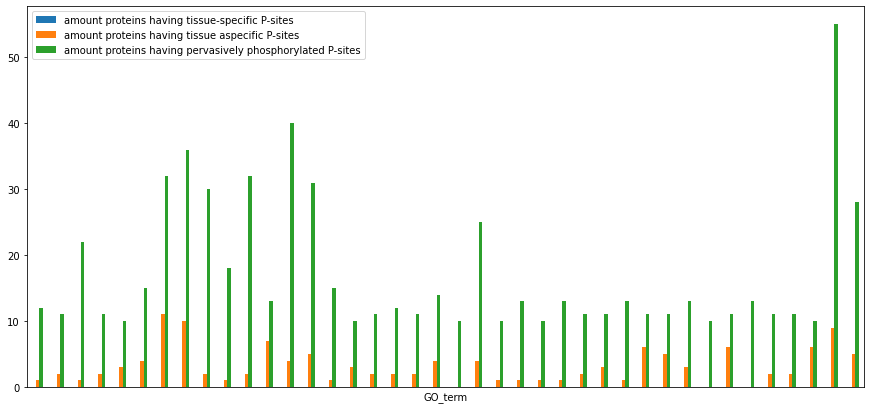

In [94]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Palatine tonsils"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Palatine tonsils"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Palatine tonsils"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Palatine tonsils"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Palatine tonsils"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Palatine tonsils"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Parotid gland

108


<Figure size 1080x504 with 0 Axes>

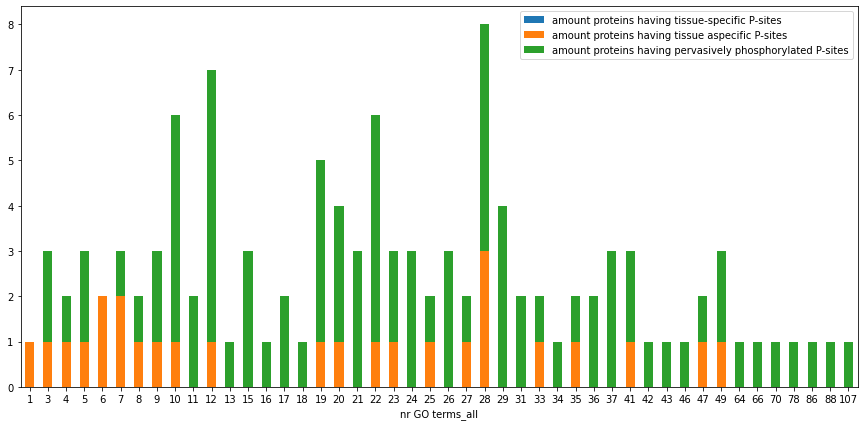

amount proteins having tissue-specific P-sites  nr GO terms_all  \
0                                              NaN                1   
1                                              NaN                3   
2                                              NaN                4   
3                                              NaN                5   
4                                              NaN                6   
5                                              NaN                7   
6                                              NaN                8   
7                                              NaN                9   
8                                              NaN               10   
22                                             NaN               11   
9                                              NaN               12   
23                                             NaN               13   
24                                             NaN               15   
25                                             NaN               16   
26                                             NaN               17   
27                                             NaN               18   
10                                             NaN               19   
11                                             NaN               20   
28                                             NaN               21   
12                                             NaN               22   
13                                             NaN               23   
29                                             NaN               24   
14                                             NaN               25   
30                                             NaN               26   
15                                             NaN               27   
16                                             NaN               28   
31                                             NaN               29   
32                                             NaN               31   
17                                             NaN               33   
33                                             NaN               34   
18                                             NaN               35   
34                                             NaN               36   
35                                             NaN               37   
19                                             NaN               41   
36                                             NaN               42   
37                                             NaN               43   
38                                             NaN               46   
20                                             NaN               47   
21                                             NaN               49   
39                                             NaN               64   
40                                             NaN               66   
41                                             NaN               70   
42                                             NaN               78   
43                                             NaN               86   
44                                             NaN               88   
45                                             NaN              107   

    amount proteins having tissue aspecific P-sites  \
0                                               1.0   
1                                               1.0   
2                                               1.0   
3                                               1.0   
4                                               2.0   
5                                               2.0   
6                                               1.0   
7                                               1.0   
8                                               1.0   
22                                              NaN   
9                                               1.0   
23    

In [95]:
print(data_protein[data_protein["Parotid gland"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Parotid gland"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Parotid gland"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Parotid gland"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
462   GO:0001895                                             0.0   
770   GO:0002862                                             0.0   
928   GO:0003723                                             0.0   
947   GO:0003823                                             0.0   
1425  GO:0005198                                             0.0   
1502  GO:0005524                                             0.0   
1518  GO:0005576                                             0.0   
1539  GO:0005615                                             0.0   
1541  GO:0005634                                             0.0   
1551  GO:0005654                                             0.0   
1583  GO:0005737                                             0.0   
1619  GO:0005788                                             0.0   
1639  GO:0005829                                             0.0   
1676  GO:0005886                                             0.0   
1697  GO:0005925                                             0.0   
2153  GO:0006898                                             0.0   
2160  GO:0006910                                             0.0   
2161  GO:0006911                                             0.0   
2184  GO:0006958                                             0.0   
2801  GO:0009897                                             0.0   
3309  GO:0015629                                             0.0   
3395  GO:0016020                                             0.0   
3711  GO:0018149                                             0.0   
5220  GO:0032991                                             0.0   
5690  GO:0034987                                             0.0   
6165  GO:0038096                                             0.0   
6383  GO:0042571                                             0.0   
6437  GO:0042742                                             0.0   
6464  GO:0042802                                             0.0   
6772  GO:0043687                                             0.0   
6846  GO:0044267                                             0.0   
6977  GO:0045087                                             0.0   
7046  GO:0045296                                             0.0   
7453  GO:0046872                                             0.0   
7687  GO:0048471                                             0.0   
7963  GO:0050853                                             0.0   
7977  GO:0050871                                             0.0   
9018  GO:0062023                                             0.0   
9064  GO:0070062                                             0.0   
9834  GO:0072562                                             0.0   

      amount proteins having tissue aspecific P-sites  \
462                                               1.0   
770                                               2.0   
928                                               1.0   
947                                               2.0   
1425                                              3.0   
1502                                              4.0   
1518                                             11.0   
1539                                             10.0   
1541                                              2.0   
1551                                              1.0   
1583                                              2.0   
1619                                              7.0   
1639                                              4.0   
1676                                              5.0   
1697                                              1.0   
2153                                              3.0   
2160                                              2.0   
2161                                              2.0   
2184                                              2.0   
2801                                              4.0   
3309                   

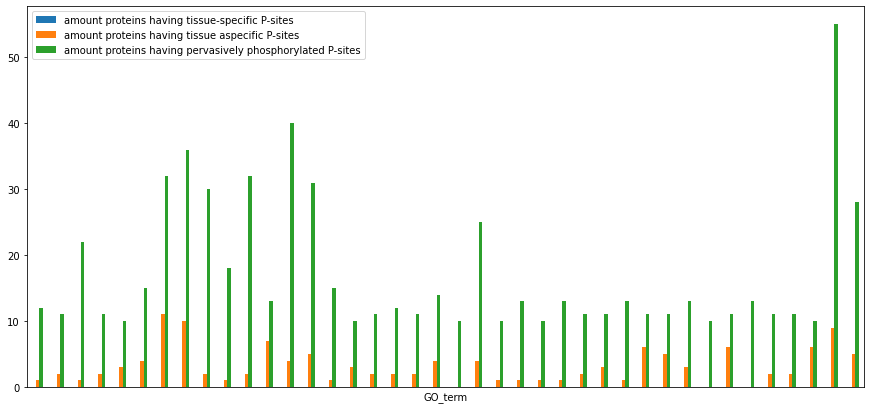

In [96]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Parotid gland"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Parotid gland"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Parotid gland"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Parotid gland"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Parotid gland"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Parotid gland"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### PBMC

866


<Figure size 1080x504 with 0 Axes>

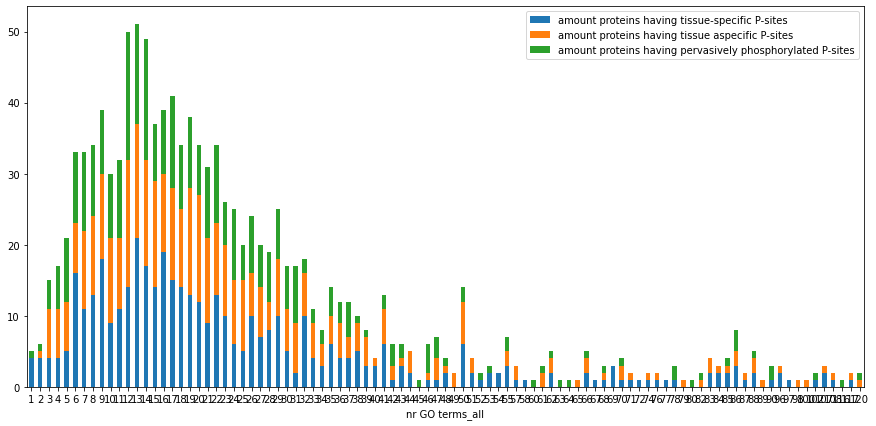

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 1                                             4.0   
1                 2                                             4.0   
2                 3                                             4.0   
3                 4                                             4.0   
4                 5                                             5.0   
..              ...                                             ...   
77              107                                             2.0   
78              108                                             1.0   
94              116                                             NaN   
79              117                                             1.0   
88              120                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               NaN   
1                                               1.0   
2                                               7.0   
3                                               7.0   
4                                               7.0   
..                                              ...   
77                                              1.0   
78                                              1.0   
94                                              NaN   
79                                              1.0   
88                                              1.0   

    amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 1.0            5.0  
1                                                 1.0            6.0  
2                                                 4.0           15.0  
3                                                 6.0           17.0  
4                                                 9.0           21.0  
..                                                ...            ...  
77                                                NaN            3.0  
78                                                NaN            2.0  
94                                                1.0            1.0  
79                                                NaN            2.0  
88                                                1.0            2.0  

[95 rows x 5 columns]

In [97]:
print(data_protein[data_protein["PBMC"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["PBMC"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["PBMC"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["PBMC"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
128    GO:0000398                                            29.0   
199    GO:0000786                                            37.0   
908    GO:0003677                                            57.0   
928    GO:0003723                                           134.0   
943    GO:0003779                                            38.0   
978    GO:0003924                                            21.0   
1493   GO:0005509                                            34.0   
1502   GO:0005524                                            55.0   
1503   GO:0005525                                            24.0   
1518   GO:0005576                                            87.0   
1539   GO:0005615                                            75.0   
1541   GO:0005634                                           251.0   
1551   GO:0005654                                           151.0   
1580   GO:0005730                                            39.0   
1583   GO:0005737                                           186.0   
1584   GO:0005739                                            53.0   
1639   GO:0005829                                           233.0   
1656   GO:0005856                                            28.0   
1676   GO:0005886                                           115.0   
1697   GO:0005925                                            57.0   
2275   GO:0007165                                            21.0   
2818   GO:0009986                                            33.0   
3395   GO:0016020                                           136.0   
3400   GO:0016032                                            35.0   
3923   GO:0019899                                            30.0   
5220   GO:0032991                                            47.0   
5677   GO:0034774                                            34.0   
6464   GO:0042802                                            73.0   
6465   GO:0042803                                            36.0   
6636   GO:0043312                                            72.0   
6977   GO:0045087                                            31.0   
7046   GO:0045296                                            42.0   
7252   GO:0045944                                            32.0   
7453   GO:0046872                                            30.0   
7505   GO:0046982                                            43.0   
7687   GO:0048471                                            26.0   
9064   GO:0070062                                           241.0   
9834   GO:0072562                                            17.0   
11751  GO:1904813                                            32.0   
12161  GO:1990904                                            24.0   

       amount proteins having tissue aspecific P-sites  \
128                                               40.0   
199                                               23.0   
908                                               40.0   
928                                              130.0   
943                                               34.0   
978                                               30.0   
1493                                              24.0   
1502                                              64.0   
1503                                              34.0   
1518                                              68.0   
1539                                              72.0   
1541                                             213.0   
1551                                             143.0   
1580                                              31.0   
1583                                             194.0   
1584                                              32.0   
1639                                             229.0   
1656                                              31.0   
1676                                             101.0   
1697                

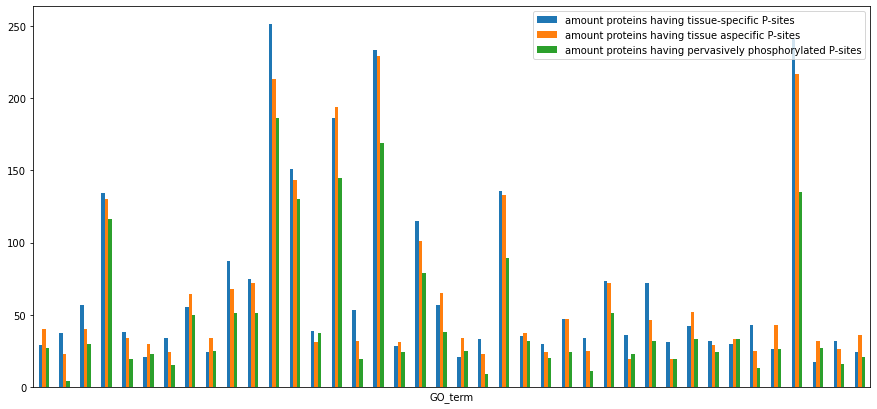

In [98]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["PBMC"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["PBMC"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["PBMC"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["PBMC"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["PBMC"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["PBMC"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=30)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=30)]

### Peritoneal dialysis fluid

2


<Figure size 1080x504 with 0 Axes>

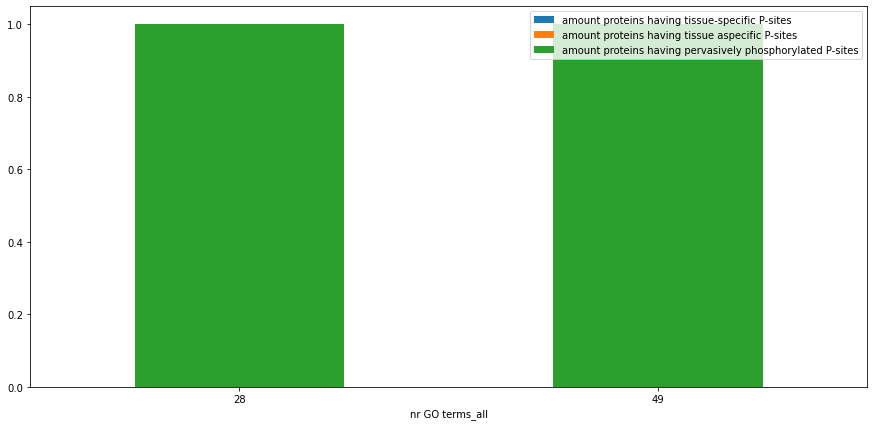

amount proteins having tissue-specific P-sites  \
0                                             NaN   
1                                             NaN   

   amount proteins having tissue aspecific P-sites  nr GO terms_all  \
0                                              NaN               28   
1                                              NaN               49   

   amount proteins having pervasively phosphorylated P-sites  Total  
0                                                  1            1.0  
1                                                  1            1.0

In [99]:
print(data_protein[data_protein["Peritoneal dialysis fluid"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Peritoneal dialysis fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Peritoneal dialysis fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Peritoneal dialysis fluid"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
310    GO:0001533                                             0.0   
446    GO:0001867                                             0.0   
462    GO:0001895                                             0.0   
607    GO:0002224                                             0.0   
614    GO:0002250                                             0.0   
...           ...                                             ...   
11457  GO:1903561                                             0.0   
11751  GO:1904813                                             0.0   
11973  GO:1990000                                             0.0   
12252  GO:2000261                                             0.0   
12294  GO:2000352                                             0.0   

       amount proteins having tissue aspecific P-sites  \
310                                                0.0   
446                                                0.0   
462                                                0.0   
607                                                0.0   
614                                                0.0   
...                                                ...   
11457                                              0.0   
11751                                              0.0   
11973                                              0.0   
12252                                              0.0   
12294                                              0.0   

       amount proteins having pervasively phosphorylated P-sites  
310                                                  1.0          
446                                                  1.0          
462                                                  1.0          
607                                                  1.0          
614                                                  1.0          
...                                                  ...          
11457                                                1.0          
11751                                                1.0          
11973                                                1.0          
12252                                                1.0          
12294                                                1.0          

[71 rows x 4 columns]

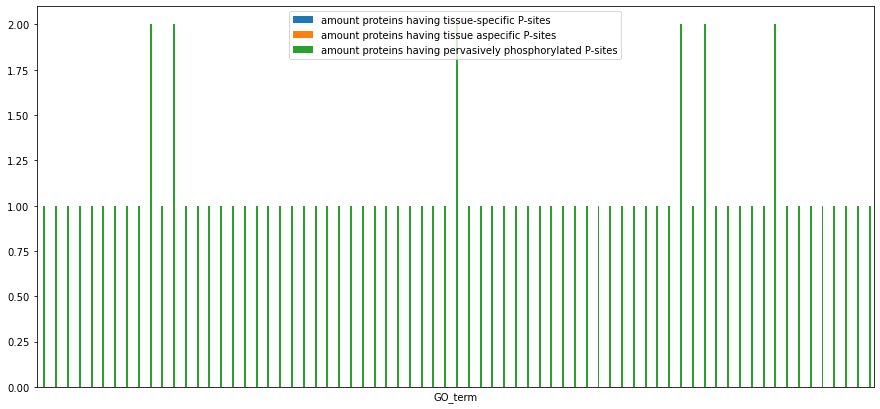

In [100]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Peritoneal dialysis fluid"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Peritoneal dialysis fluid"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Peritoneal dialysis fluid"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Peritoneal dialysis fluid"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Peritoneal dialysis fluid"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Peritoneal dialysis fluid"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=1)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=1)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=1)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=1)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=1)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=1)]

### Placenta

1014


<Figure size 1080x504 with 0 Axes>

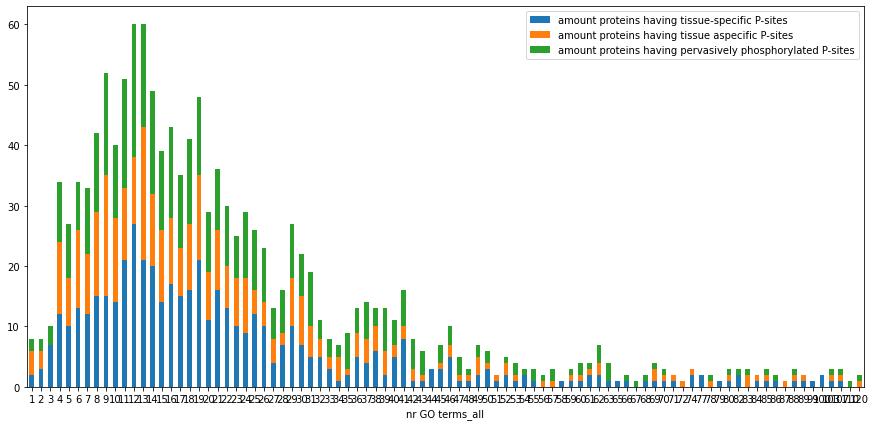

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 1                                             2.0   
1                 2                                             3.0   
2                 3                                             7.0   
3                 4                                            12.0   
4                 5                                            10.0   
..              ...                                             ...   
78              100                                             2.0   
79              103                                             1.0   
80              107                                             1.0   
89              110                                             NaN   
87              120                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               4.0   
1                                               3.0   
2                                               NaN   
3                                              12.0   
4                                               8.0   
..                                              ...   
78                                              NaN   
79                                              1.0   
80                                              1.0   
89                                              NaN   
87                                              1.0   

    amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 2.0            8.0  
1                                                 2.0            8.0  
2                                                 3.0           10.0  
3                                                10.0           34.0  
4                                                 9.0           27.0  
..                                                ...            ...  
78                                                NaN            2.0  
79                                                1.0            3.0  
80                                                1.0            3.0  
89                                                1.0            1.0  
87                                                1.0            2.0  

[90 rows x 5 columns]

In [101]:
print(data_protein[data_protein["Placenta"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Placenta"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Placenta"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Placenta"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
30     GO:0000086                                            12.0   
39     GO:0000122                                            17.0   
48     GO:0000139                                            14.0   
56     GO:0000165                                            13.0   
65     GO:0000184                                            11.0   
...           ...                                             ...   
10885  GO:1900034                                            11.0   
11078  GO:1901796                                            10.0   
11109  GO:1901990                                            10.0   
11751  GO:1904813                                            22.0   
12161  GO:1990904                                            25.0   

       amount proteins having tissue aspecific P-sites  \
30                                                 7.0   
39                                                19.0   
48                                                10.0   
56                                                 2.0   
65                                                13.0   
...                                                ...   
10885                                              8.0   
11078                                              6.0   
11109                                              2.0   
11751                                              7.0   
12161                                             17.0   

       amount proteins having pervasively phosphorylated P-sites  
30                                                  12.0          
39                                                  23.0          
48                                                   8.0          
56                                                   9.0          
65                                                  15.0          
...                                                  ...          
10885                                                8.0          
11078                                                8.0          
11109                                                5.0          
11751                                               13.0          
12161                                               26.0          

[217 rows x 4 columns]

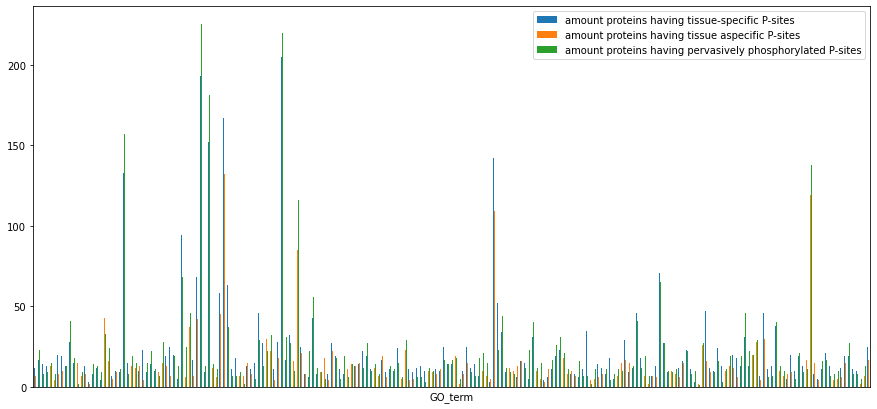

In [102]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Placenta"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Placenta"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Placenta"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Placenta"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Placenta"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Placenta"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Skeletal muscle

157


<Figure size 1080x504 with 0 Axes>

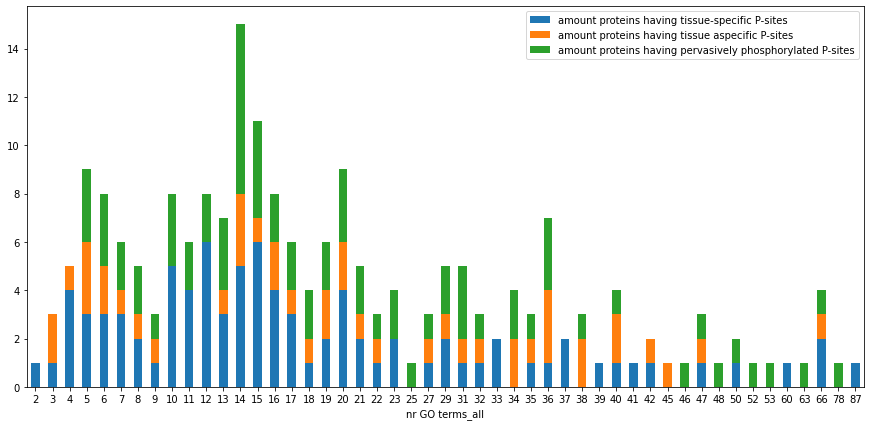

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 2                                             1.0   
1                 3                                             1.0   
2                 4                                             4.0   
3                 5                                             3.0   
4                 6                                             3.0   
5                 7                                             3.0   
6                 8                                             2.0   
7                 9                                             1.0   
8                10                                             5.0   
9                11                                             4.0   
10               12                                             6.0   
11               13                                             3.0   
12               14                                             5.0   
13               15                                             6.0   
14               16                                             4.0   
15               17                                             3.0   
16               18                                             1.0   
17               19                                             2.0   
18               20                                             4.0   
19               21                                             2.0   
20               22                                             1.0   
21               23                                             2.0   
42               25                                             NaN   
22               27                                             1.0   
23               29                                             2.0   
24               31                                             1.0   
25               32                                             1.0   
26               33                                             2.0   
39               34                                             NaN   
27               35                                             1.0   
28               36                                             1.0   
29               37                                             2.0   
40               38                                             NaN   
30               39                                             1.0   
31               40                                             1.0   
32               41                                             1.0   
33               42                                             1.0   
41               45                                             NaN   
43               46                                             NaN   
34               47                                             1.0   
44               48                                             NaN   
35               50                                             1.0   
45               52                                             NaN   
46               53                                             NaN   
36               60                                             1.0   
47               63                                             NaN   
37               66                                             2.0   
48               78                                             NaN   
38               87                                             1.0   

    amount proteins having tissue aspecific P-sites  \
0                                               NaN   
1                                               2.0   
2                                               1.0   
3                                               3.0   
4                                               2.0   
5                                               1.0   
6                                               1.0   
7            

In [103]:
print(data_protein[data_protein["Skeletal muscle"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Skeletal muscle"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Skeletal muscle"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Skeletal muscle"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
928   GO:0003723                                             2.0   
943   GO:0003779                                            12.0   
1493  GO:0005509                                            11.0   
1495  GO:0005516                                            12.0   
1502  GO:0005524                                            28.0   
1539  GO:0005615                                            16.0   
1541  GO:0005634                                            19.0   
1551  GO:0005654                                             9.0   
1583  GO:0005737                                            27.0   
1584  GO:0005739                                             9.0   
1639  GO:0005829                                            57.0   
1656  GO:0005856                                            12.0   
1658  GO:0005859                                            11.0   
1674  GO:0005884                                            10.0   
1676  GO:0005886                                            18.0   
1697  GO:0005925                                             5.0   
2172  GO:0006936                                            24.0   
2559  GO:0008307                                            16.0   
3395  GO:0016020                                            15.0   
4131  GO:0030017                                            13.0   
4132  GO:0030018                                            19.0   
4152  GO:0030049                                            20.0   
5216  GO:0032982                                            11.0   
6464  GO:0042802                                            19.0   
7029  GO:0045214                                            11.0   
8030  GO:0051015                                            19.0   
8482  GO:0060048                                            10.0   
9064  GO:0070062                                            37.0   
9834  GO:0072562                                             7.0   

      amount proteins having tissue aspecific P-sites  \
928                                               9.0   
943                                               4.0   
1493                                              3.0   
1495                                              4.0   
1502                                             17.0   
1539                                             14.0   
1541                                             19.0   
1551                                              8.0   
1583                                             19.0   
1584                                              3.0   
1639                                             26.0   
1656                                              3.0   
1658                                              2.0   
1674                                              6.0   
1676                                              9.0   
1697                                              7.0   
2172                                              7.0   
2559                                              2.0   
3395                                             10.0   
4131                                              4.0   
4132                                              7.0   
4152                                              6.0   
5216                                              3.0   
6464                                              9.0   
7029                                              4.0   
8030                                              3.0   
8482                                              4.0   
9064                                             23.0   
9834                                              8.0   

      amount proteins having pervasively phosphorylated P-sites  
928                                                10.0          
943                                                 7.0          
1493                                                5.0    

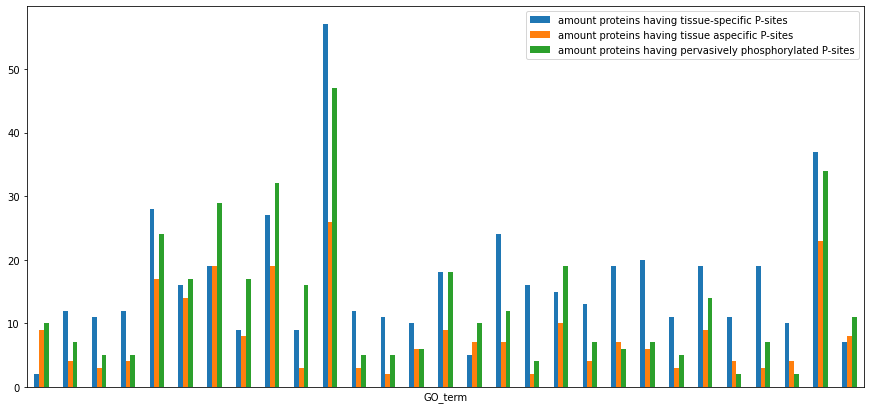

In [104]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Skeletal muscle"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Skeletal muscle"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Skeletal muscle"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Skeletal muscle"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Skeletal muscle"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Skeletal muscle"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Skin

775


<Figure size 1080x504 with 0 Axes>

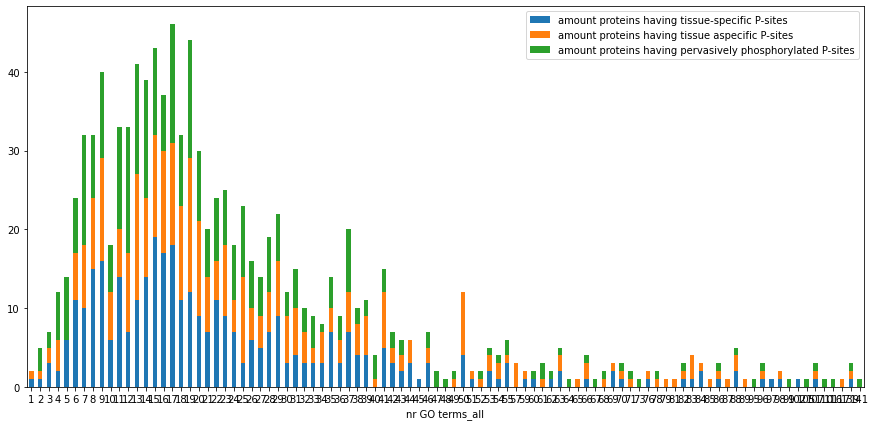

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 1                                             1.0   
1                 2                                             1.0   
2                 3                                             3.0   
3                 4                                             2.0   
4                 5                                             6.0   
..              ...                                             ...   
92              110                                             NaN   
93              116                                             NaN   
83              117                                             NaN   
68              139                                             1.0   
94              141                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               1.0   
1                                               1.0   
2                                               2.0   
3                                               4.0   
4                                               NaN   
..                                              ...   
92                                              NaN   
93                                              NaN   
83                                              1.0   
68                                              1.0   
94                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 NaN            2.0  
1                                                 3.0            5.0  
2                                                 2.0            7.0  
3                                                 6.0           12.0  
4                                                 8.0           14.0  
..                                                ...            ...  
92                                                1.0            1.0  
93                                                1.0            1.0  
83                                                NaN            1.0  
68                                                1.0            3.0  
94                                                1.0            1.0  

[95 rows x 5 columns]

In [105]:
print(data_protein[data_protein["Skin"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Skin"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Skin"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Skin"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
30     GO:0000086                                             7.0   
39     GO:0000122                                            10.0   
48     GO:0000139                                            11.0   
56     GO:0000165                                            12.0   
65     GO:0000184                                            34.0   
...           ...                                             ...   
10695  GO:0106310                                             3.0   
10696  GO:0106311                                             3.0   
10885  GO:1900034                                             1.0   
11751  GO:1904813                                            19.0   
12161  GO:1990904                                            20.0   

       amount proteins having tissue aspecific P-sites  \
30                                                12.0   
39                                                18.0   
48                                                 9.0   
56                                                 9.0   
65                                                23.0   
...                                                ...   
10695                                             10.0   
10696                                             10.0   
10885                                             10.0   
11751                                             25.0   
12161                                             25.0   

       amount proteins having pervasively phosphorylated P-sites  
30                                                   8.0          
39                                                  12.0          
48                                                  11.0          
56                                                   8.0          
65                                                   9.0          
...                                                  ...          
10695                                                9.0          
10696                                                9.0          
10885                                                9.0          
11751                                               14.0          
12161                                               23.0          

[196 rows x 4 columns]

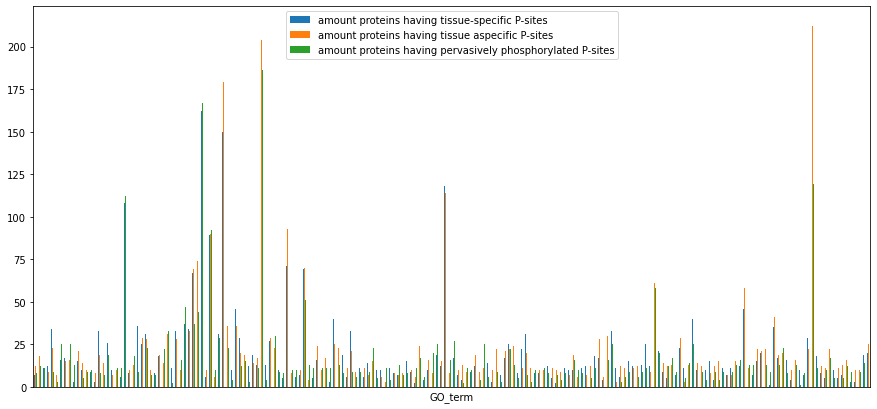

In [106]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Skin"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Skin"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Skin"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Skin"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Skin"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Skin"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Small intestine

214


<Figure size 1080x504 with 0 Axes>

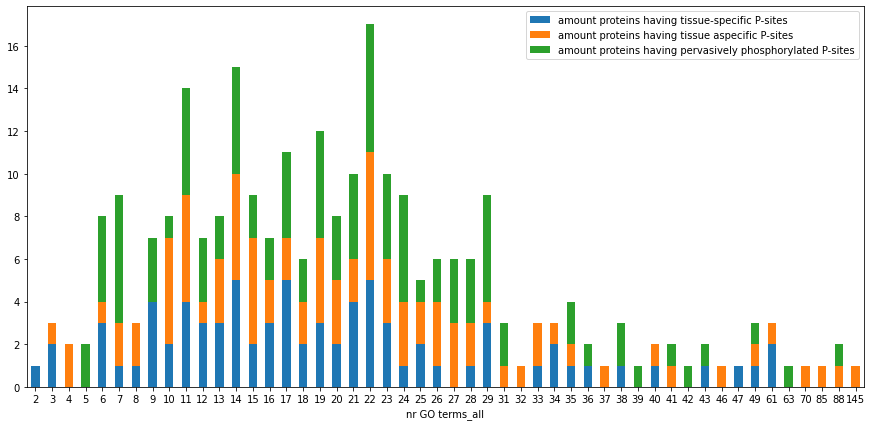

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 2                                             1.0   
1                 3                                             2.0   
35                4                                             NaN   
46                5                                             NaN   
2                 6                                             3.0   
3                 7                                             1.0   
4                 8                                             1.0   
5                 9                                             4.0   
6                10                                             2.0   
7                11                                             4.0   
8                12                                             3.0   
9                13                                             3.0   
10               14                                             5.0   
11               15                                             2.0   
12               16                                             3.0   
13               17                                             5.0   
14               18                                             2.0   
15               19                                             3.0   
16               20                                             2.0   
17               21                                             4.0   
18               22                                             5.0   
19               23                                             3.0   
20               24                                             1.0   
21               25                                             2.0   
22               26                                             1.0   
36               27                                             NaN   
23               28                                             1.0   
24               29                                             3.0   
37               31                                             NaN   
38               32                                             NaN   
25               33                                             1.0   
26               34                                             2.0   
27               35                                             1.0   
28               36                                             1.0   
39               37                                             NaN   
29               38                                             1.0   
47               39                                             NaN   
30               40                                             1.0   
40               41                                             NaN   
48               42                                             NaN   
31               43                                             1.0   
41               46                                             NaN   
32               47                                             1.0   
33               49                                             1.0   
34               61                                             2.0   
49               63                                             NaN   
42               70                                             NaN   
43               85                                             NaN   
44               88                                             NaN   
45              145                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               NaN   
1                                               1.0   
35                                              2.0   
46                                              NaN   
2                                               1.0   
3                                               2.0 

In [107]:
print(data_protein[data_protein["Small intestine"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Small intestine"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Small intestine"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Small intestine"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
928   GO:0003723                                            11.0   
947   GO:0003823                                             5.0   
1426  GO:0005200                                             5.0   
1502  GO:0005524                                            14.0   
1518  GO:0005576                                            21.0   
1539  GO:0005615                                            27.0   
1541  GO:0005634                                            22.0   
1551  GO:0005654                                             6.0   
1583  GO:0005737                                            24.0   
1639  GO:0005829                                            36.0   
1656  GO:0005856                                             4.0   
1676  GO:0005886                                            24.0   
1697  GO:0005925                                             7.0   
2160  GO:0006910                                             4.0   
2161  GO:0006911                                             4.0   
2184  GO:0006958                                             5.0   
2801  GO:0009897                                             4.0   
3395  GO:0016020                                            17.0   
3711  GO:0018149                                             3.0   
5690  GO:0034987                                             3.0   
6383  GO:0042571                                             4.0   
6437  GO:0042742                                             4.0   
6464  GO:0042802                                            13.0   
6636  GO:0043312                                             6.0   
6977  GO:0045087                                             7.0   
7046  GO:0045296                                             4.0   
7963  GO:0050853                                             4.0   
7977  GO:0050871                                             4.0   
9018  GO:0062023                                             9.0   
9064  GO:0070062                                            43.0   
9834  GO:0072562                                             9.0   

      amount proteins having tissue aspecific P-sites  \
928                                              20.0   
947                                              10.0   
1426                                             10.0   
1502                                             11.0   
1518                                             29.0   
1539                                             28.0   
1541                                             33.0   
1551                                             14.0   
1583                                             34.0   
1639                                             50.0   
1656                                              6.0   
1676                                             25.0   
1697                                             16.0   
2160                                             10.0   
2161                                             11.0   
2184                                             10.0   
2801                                             12.0   
3395                                             28.0   
3711                                              9.0   
5690                                              8.0   
6383                                             10.0   
6437                                             10.0   
6464                                             11.0   
6636                                             10.0   
6977                                             14.0   
7046                                              8.0   
7963                                             10.0   
7977                                             10.0   
9018                                             13.0   
9064                                             60.0   
9834                                             13.0   

      a

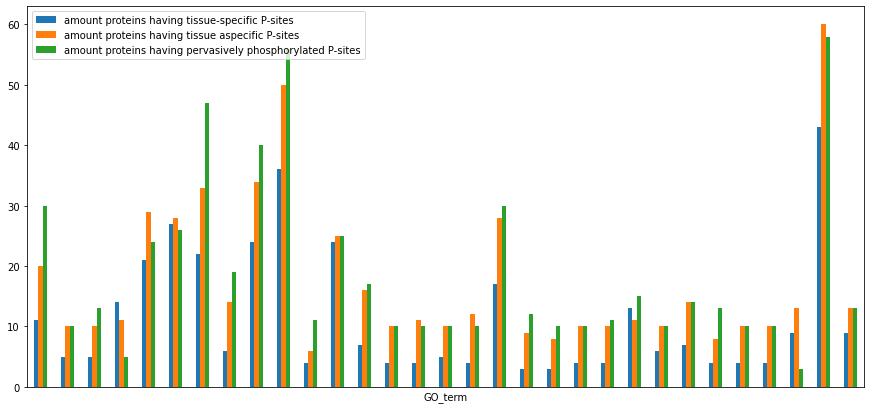

In [108]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Small intestine"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Small intestine"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Small intestine"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Small intestine"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Small intestine"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Small intestine"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Synovial tissue

11


<Figure size 1080x504 with 0 Axes>

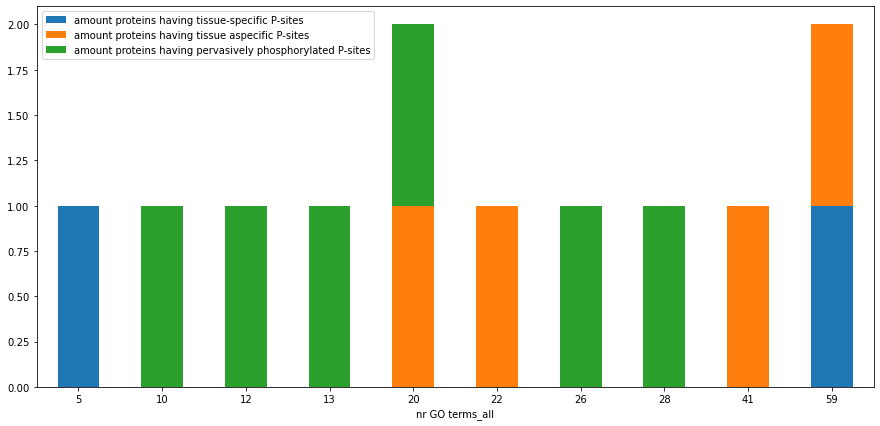

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                5                                             1.0   
5               10                                             NaN   
6               12                                             NaN   
7               13                                             NaN   
2               20                                             NaN   
3               22                                             NaN   
8               26                                             NaN   
9               28                                             NaN   
4               41                                             NaN   
1               59                                             1.0   

   amount proteins having tissue aspecific P-sites  \
0                                              NaN   
5                                              NaN   
6                                              NaN   
7                                              NaN   
2                                              1.0   
3                                              1.0   
8                                              NaN   
9                                              NaN   
4                                              1.0   
1                                              1.0   

   amount proteins having pervasively phosphorylated P-sites  Total  
0                                                NaN            1.0  
5                                                1.0            1.0  
6                                                1.0            1.0  
7                                                1.0            1.0  
2                                                1.0            2.0  
3                                                NaN            1.0  
8                                                1.0            1.0  
9                                                1.0            1.0  
4                                                NaN            1.0  
1                                                NaN            2.0

In [109]:
print(data_protein[data_protein["Synovial tissue"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Synovial tissue"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Synovial tissue"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Synovial tissue"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
1322  GO:0004866                                             0.0   
1518  GO:0005576                                             2.0   
1539  GO:0005615                                             1.0   
1619  GO:0005788                                             1.0   
6772  GO:0043687                                             1.0   
6846  GO:0044267                                             1.0   
9064  GO:0070062                                             1.0   

      amount proteins having tissue aspecific P-sites  \
1322                                              1.0   
1518                                              3.0   
1539                                              4.0   
1619                                              3.0   
6772                                              3.0   
6846                                              3.0   
9064                                              4.0   

      amount proteins having pervasively phosphorylated P-sites  
1322                                                5.0          
1518                                                6.0          
1539                                                5.0          
1619                                                6.0          
6772                                                6.0          
6846                                                6.0          
9064                                                5.0

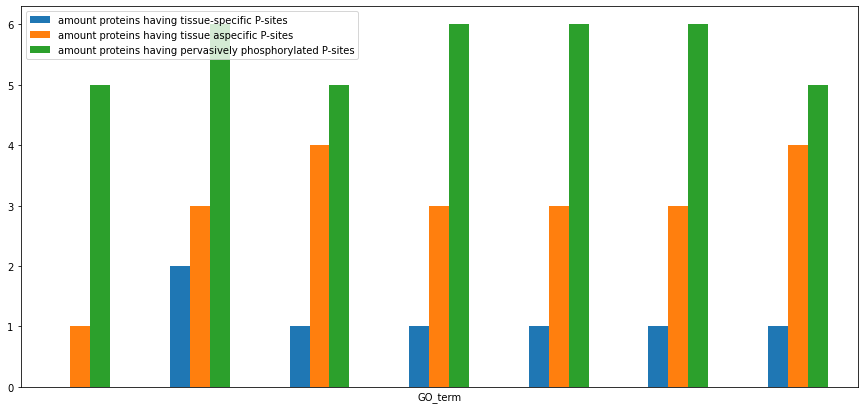

In [112]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Synovial tissue"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Synovial tissue"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Synovial tissue"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Synovial tissue"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Synovial tissue"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Synovial tissue"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### T-cells

10


<Figure size 1080x504 with 0 Axes>

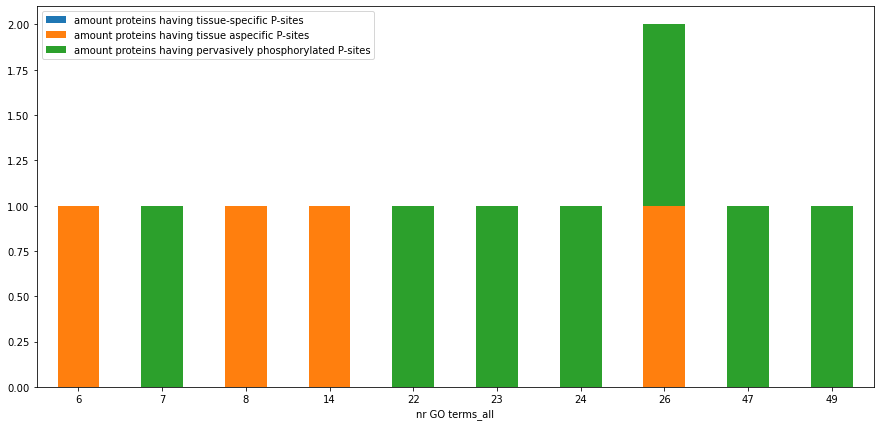

amount proteins having tissue-specific P-sites  nr GO terms_all  \
0                                             NaN                6   
4                                             NaN                7   
1                                             NaN                8   
2                                             NaN               14   
5                                             NaN               22   
6                                             NaN               23   
7                                             NaN               24   
3                                             NaN               26   
8                                             NaN               47   
9                                             NaN               49   

   amount proteins having tissue aspecific P-sites  \
0                                              1.0   
4                                              NaN   
1                                              1.0   
2                                              1.0   
5                                              NaN   
6                                              NaN   
7                                              NaN   
3                                              1.0   
8                                              NaN   
9                                              NaN   

   amount proteins having pervasively phosphorylated P-sites  Total  
0                                                NaN            1.0  
4                                                1.0            1.0  
1                                                NaN            1.0  
2                                                NaN            1.0  
5                                                1.0            1.0  
6                                                1.0            1.0  
7                                                1.0            1.0  
3                                                1.0            2.0  
8                                                1.0            1.0  
9                                                1.0            1.0

In [113]:
print(data_protein[data_protein["T-cells"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["T-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["T-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["T-cells"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
708    GO:0002576                                             0.0   
928    GO:0003723                                             0.0   
1425   GO:0005198                                             0.0   
1426   GO:0005200                                             0.0   
1518   GO:0005576                                             0.0   
1539   GO:0005615                                             0.0   
1541   GO:0005634                                             0.0   
1583   GO:0005737                                             0.0   
1619   GO:0005788                                             0.0   
1639   GO:0005829                                             0.0   
1676   GO:0005886                                             0.0   
1690   GO:0005912                                             0.0   
1697   GO:0005925                                             0.0   
2433   GO:0008013                                             0.0   
2801   GO:0009897                                             0.0   
3309   GO:0015629                                             0.0   
3497   GO:0016342                                             0.0   
3526   GO:0016477                                             0.0   
4502   GO:0031012                                             0.0   
4535   GO:0031093                                             0.0   
6772   GO:0043687                                             0.0   
6846   GO:0044267                                             0.0   
6977   GO:0045087                                             0.0   
7046   GO:0045296                                             0.0   
8030   GO:0051015                                             0.0   
8092   GO:0051149                                             0.0   
9018   GO:0062023                                             0.0   
9064   GO:0070062                                             0.0   
9834   GO:0072562                                             0.0   
10385  GO:0098609                                             0.0   

       amount proteins having tissue aspecific P-sites  \
708                                                1.0   
928                                                1.0   
1425                                               0.0   
1426                                               0.0   
1518                                               2.0   
1539                                               3.0   
1541                                               1.0   
1583                                               2.0   
1619                                               1.0   
1639                                               0.0   
1676                                               1.0   
1690                                               0.0   
1697                                               1.0   
2433                                               0.0   
2801                                               0.0   
3309                                               0.0   
3497                                               0.0   
3526                                               0.0   
4502                                               2.0   
4535                                               1.0   
6772                                               1.0   
6846                                               1.0   
6977                                               0.0   
7046                                               0.0   
8030                                               0.0   
8092                                               0.0   
9018                                               2.0   
9064                                               2.0   
9834                                               1.0   
10385                                              0.0   

       amount proteins having pervasively phosphorylated P-sites  
708 

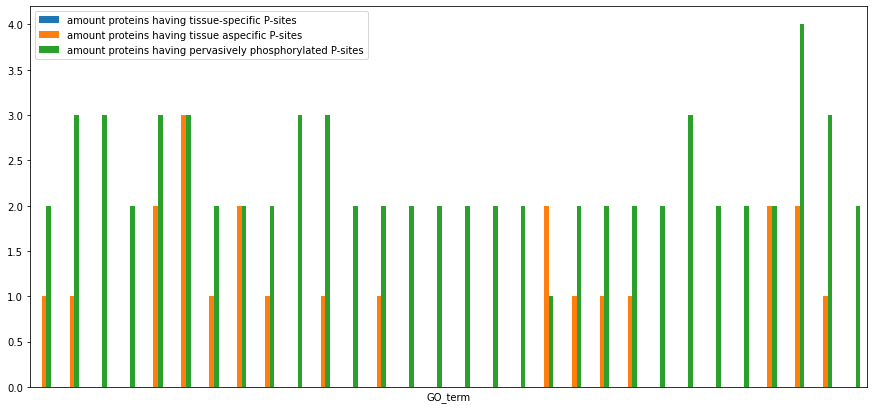

In [111]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["T-cells"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["T-cells"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["T-cells"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["T-cells"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["T-cells"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["T-cells"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=2)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=2)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=2)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=2)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=2)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=2)]

### Testis

689


<Figure size 1080x504 with 0 Axes>

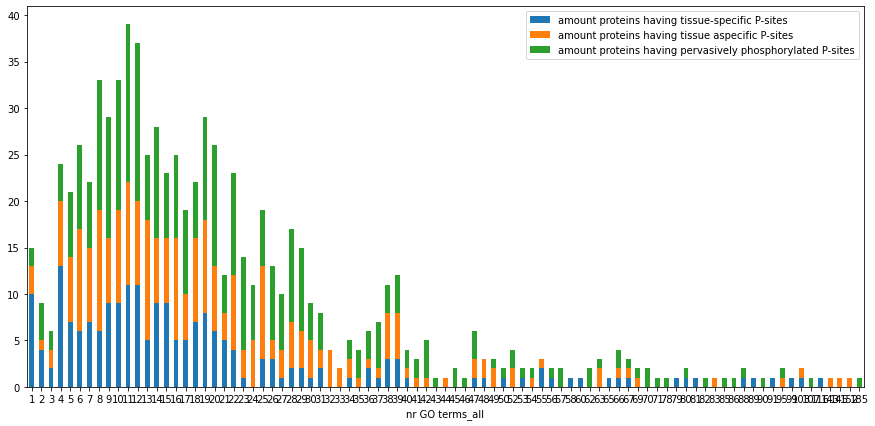

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0                 1                                            10.0   
1                 2                                             4.0   
2                 3                                             2.0   
3                 4                                            13.0   
4                 5                                             7.0   
..              ...                                             ...   
55              116                                             1.0   
70              143                                             NaN   
71              145                                             NaN   
72              152                                             NaN   
86              185                                             NaN   

    amount proteins having tissue aspecific P-sites  \
0                                               3.0   
1                                               1.0   
2                                               2.0   
3                                               7.0   
4                                               7.0   
..                                              ...   
55                                              NaN   
70                                              1.0   
71                                              1.0   
72                                              1.0   
86                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
0                                                 2.0           15.0  
1                                                 4.0            9.0  
2                                                 2.0            6.0  
3                                                 4.0           24.0  
4                                                 7.0           21.0  
..                                                ...            ...  
55                                                NaN            1.0  
70                                                NaN            1.0  
71                                                NaN            1.0  
72                                                NaN            1.0  
86                                                1.0            1.0  

[87 rows x 5 columns]

In [114]:
print(data_protein[data_protein["Testis"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Testis"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Testis"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Testis"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
928   GO:0003723                                            30.0   
1502  GO:0005524                                            24.0   
1541  GO:0005634                                            80.0   
1551  GO:0005654                                            61.0   
1583  GO:0005737                                            90.0   
1639  GO:0005829                                            85.0   
1676  GO:0005886                                            54.0   
3395  GO:0016020                                            30.0   
6464  GO:0042802                                            28.0   
9064  GO:0070062                                            34.0   

      amount proteins having tissue aspecific P-sites  \
928                                              52.0   
1502                                             40.0   
1541                                            115.0   
1551                                             92.0   
1583                                            114.0   
1639                                            130.0   
1676                                             68.0   
3395                                             50.0   
6464                                             36.0   
9064                                             43.0   

      amount proteins having pervasively phosphorylated P-sites  
928                                                89.0          
1502                                               51.0          
1541                                              146.0          
1551                                              120.0          
1583                                              158.0          
1639                                              179.0          
1676                                               90.0          
3395                                               72.0          
6464                                               54.0          
9064                                               98.0

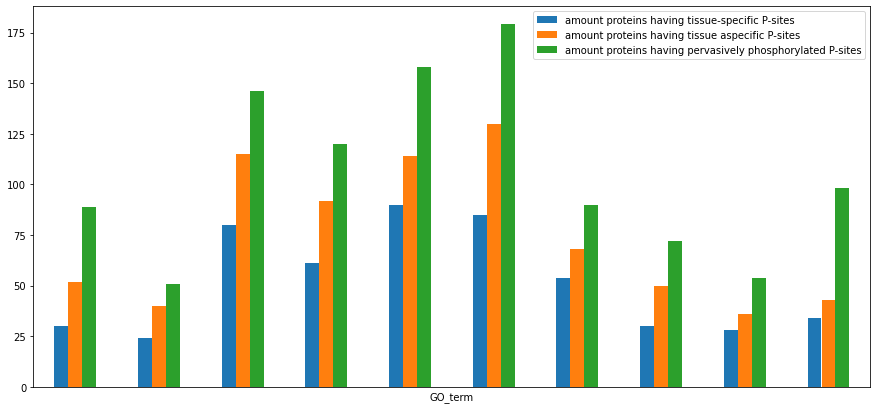

In [115]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Testis"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Testis"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Testis"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Testis"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Testis"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Testis"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=50)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=50)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=50)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=50)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=50)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=50)]

### Tooth

1


<Figure size 1080x504 with 0 Axes>

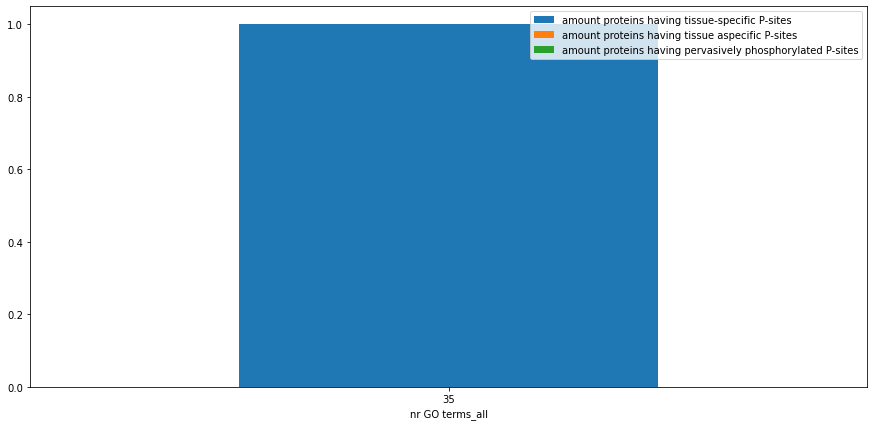

nr GO terms_all  amount proteins having tissue-specific P-sites  \
0               35                                               1   

   amount proteins having tissue aspecific P-sites  \
0                                              NaN   

   amount proteins having pervasively phosphorylated P-sites  Total  
0                                                NaN            1.0

In [116]:
print(data_protein[data_protein["Tooth"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Tooth"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Tooth"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Tooth"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

### Umbilical cord

640


<Figure size 1080x504 with 0 Axes>

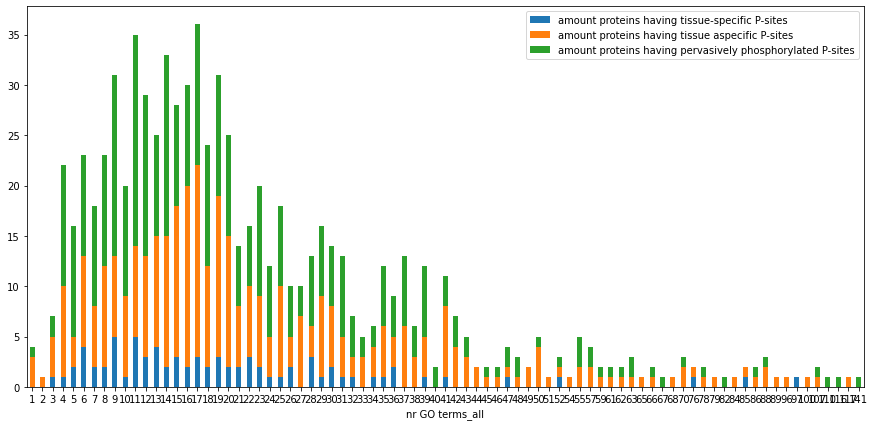

nr GO terms_all  amount proteins having tissue-specific P-sites  \
39                1                                             NaN   
40                2                                             NaN   
0                 3                                             1.0   
1                 4                                             1.0   
2                 5                                             2.0   
..              ...                                             ...   
73              107                                             NaN   
78              110                                             NaN   
79              116                                             NaN   
74              117                                             NaN   
80              141                                             NaN   

    amount proteins having tissue aspecific P-sites  \
39                                              3.0   
40                                              1.0   
0                                               4.0   
1                                               9.0   
2                                               3.0   
..                                              ...   
73                                              1.0   
78                                              NaN   
79                                              NaN   
74                                              1.0   
80                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
39                                                1.0            4.0  
40                                                NaN            1.0  
0                                                 2.0            7.0  
1                                                12.0           22.0  
2                                                11.0           16.0  
..                                                ...            ...  
73                                                1.0            2.0  
78                                                1.0            1.0  
79                                                1.0            1.0  
74                                                NaN            1.0  
80                                                1.0            1.0  

[81 rows x 5 columns]

In [117]:
print(data_protein[data_protein["Umbilical cord"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Umbilical cord"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Umbilical cord"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Umbilical cord"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
65     GO:0000184                                             9.0   
76     GO:0000226                                             4.0   
128    GO:0000398                                             5.0   
908    GO:0003677                                             3.0   
928    GO:0003723                                            29.0   
933    GO:0003729                                             8.0   
935    GO:0003735                                            11.0   
943    GO:0003779                                             7.0   
978    GO:0003924                                             5.0   
1426   GO:0005200                                             7.0   
1493   GO:0005509                                             5.0   
1502   GO:0005524                                            11.0   
1503   GO:0005525                                             5.0   
1518   GO:0005576                                            10.0   
1539   GO:0005615                                             6.0   
1541   GO:0005634                                            36.0   
1551   GO:0005654                                            28.0   
1580   GO:0005730                                            10.0   
1583   GO:0005737                                            25.0   
1584   GO:0005739                                             3.0   
1616   GO:0005783                                             8.0   
1624   GO:0005794                                             4.0   
1639   GO:0005829                                            50.0   
1656   GO:0005856                                             5.0   
1666   GO:0005874                                             6.0   
1676   GO:0005886                                            21.0   
1697   GO:0005925                                            15.0   
1909   GO:0006412                                            11.0   
1910   GO:0006413                                             9.0   
2020   GO:0006614                                            10.0   
2275   GO:0007165                                             3.0   
2588   GO:0008380                                             4.0   
3309   GO:0015629                                             5.0   
3395   GO:0016020                                            22.0   
3400   GO:0016032                                             2.0   
3587   GO:0016607                                             5.0   
3625   GO:0016887                                             7.0   
3772   GO:0019083                                             9.0   
3923   GO:0019899                                             5.0   
3925   GO:0019901                                             1.0   
3928   GO:0019904                                             2.0   
4104   GO:0022626                                             7.0   
4136   GO:0030027                                             3.0   
4725   GO:0031625                                             2.0   
4818   GO:0031982                                             2.0   
5220   GO:0032991                                             2.0   
6464   GO:0042802                                             7.0   
6465   GO:0042803                                             2.0   
6532   GO:0043066                                             4.0   
6595   GO:0043231                                             3.0   
6636   GO:0043312                                             8.0   
7046   GO:0045296                                             9.0   
7252   GO:0045944                                             2.0   
7453   GO:0046872                                             6.0   
7687   GO:0048471                                             7.0   
8030   GO:0051015                                             2.0   
8060   GO:0051082                                             6.0   
9064   G

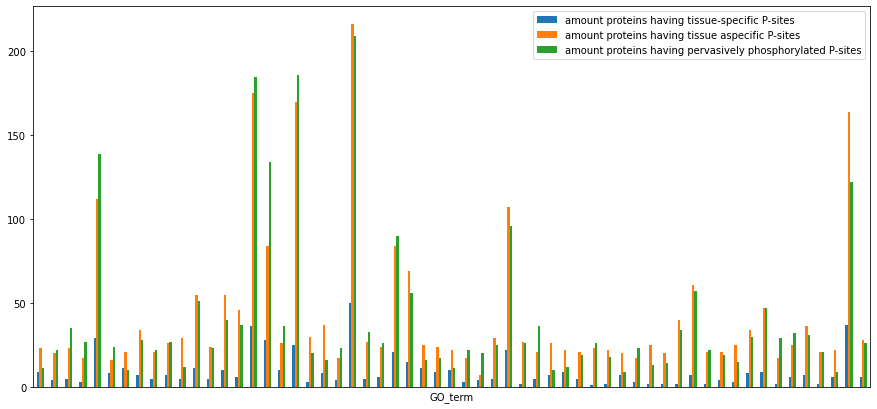

In [118]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Umbilical cord"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Umbilical cord"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Umbilical cord"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Umbilical cord"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Umbilical cord"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Umbilical cord"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=20)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=20)]

### Ureter

28


<Figure size 1080x504 with 0 Axes>

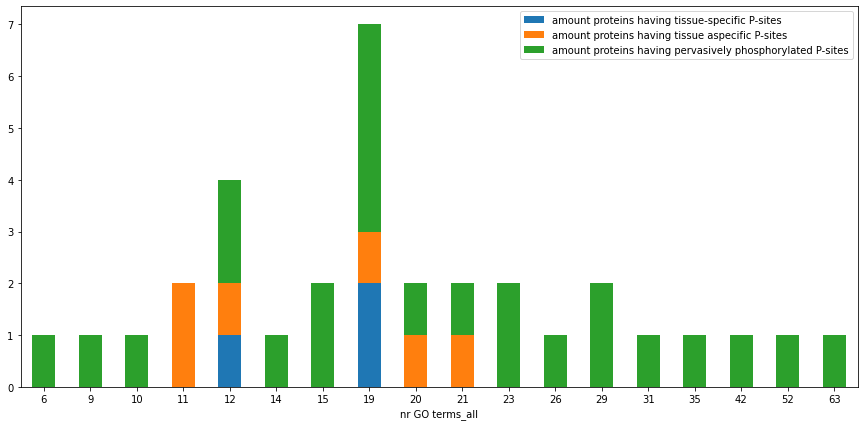

nr GO terms_all  amount proteins having tissue-specific P-sites  \
5                 6                                             NaN   
6                 9                                             NaN   
7                10                                             NaN   
2                11                                             NaN   
0                12                                             1.0   
8                14                                             NaN   
9                15                                             NaN   
1                19                                             2.0   
3                20                                             NaN   
4                21                                             NaN   
10               23                                             NaN   
11               26                                             NaN   
12               29                                             NaN   
13               31                                             NaN   
14               35                                             NaN   
15               42                                             NaN   
16               52                                             NaN   
17               63                                             NaN   

    amount proteins having tissue aspecific P-sites  \
5                                               NaN   
6                                               NaN   
7                                               NaN   
2                                               2.0   
0                                               1.0   
8                                               NaN   
9                                               NaN   
1                                               1.0   
3                                               1.0   
4                                               1.0   
10                                              NaN   
11                                              NaN   
12                                              NaN   
13                                              NaN   
14                                              NaN   
15                                              NaN   
16                                              NaN   
17                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
5                                                 1.0            1.0  
6                                                 1.0            1.0  
7                                                 1.0            1.0  
2                                                 NaN            2.0  
0                                                 2.0            4.0  
8                                                 1.0            1.0  
9                                                 2.0            2.0  
1                                                 4.0            7.0  
3                                                 1.0            2.0  
4                                                 1.0            2.0  
10                                                2.0            2.0  
11                                                1.0            1.0  
12                                                2.0            2.0  
13                                                1.0            1.0  
14                                                1.0            1.0  
15                                                1.0            1.0  
16                                                1.0            1.0  
17                                                1.0            1.0

In [119]:
print(data_protein[data_protein["Ureter"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Ureter"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Ureter"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Ureter"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
928   GO:0003723                                             0.0   
943   GO:0003779                                             0.0   
1518  GO:0005576                                             0.0   
1541  GO:0005634                                             3.0   
1551  GO:0005654                                             1.0   
1583  GO:0005737                                             2.0   
1639  GO:0005829                                             3.0   
1656  GO:0005856                                             0.0   
1676  GO:0005886                                             1.0   
1697  GO:0005925                                             1.0   
2172  GO:0006936                                             1.0   
3309  GO:0015629                                             1.0   
6464  GO:0042802                                             2.0   
9064  GO:0070062                                             1.0   

      amount proteins having tissue aspecific P-sites  \
928                                               0.0   
943                                               1.0   
1518                                              1.0   
1541                                              4.0   
1551                                              1.0   
1583                                              2.0   
1639                                              3.0   
1656                                              0.0   
1676                                              0.0   
1697                                              1.0   
2172                                              1.0   
3309                                              1.0   
6464                                              1.0   
9064                                              3.0   

      amount proteins having pervasively phosphorylated P-sites  
928                                                 5.0          
943                                                 9.0          
1518                                                5.0          
1541                                               11.0          
1551                                                6.0          
1583                                               14.0          
1639                                               16.0          
1656                                                6.0          
1676                                               11.0          
1697                                                8.0          
2172                                                5.0          
3309                                                6.0          
6464                                                8.0          
9064                                                9.0

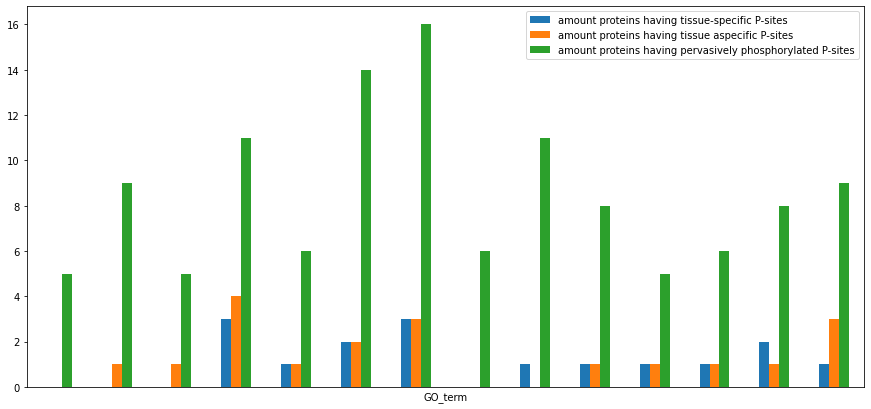

In [120]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Ureter"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Ureter"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Ureter"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Ureter"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Ureter"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Ureter"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=5)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=5)]

### Urinary bladder

578


<Figure size 1080x504 with 0 Axes>

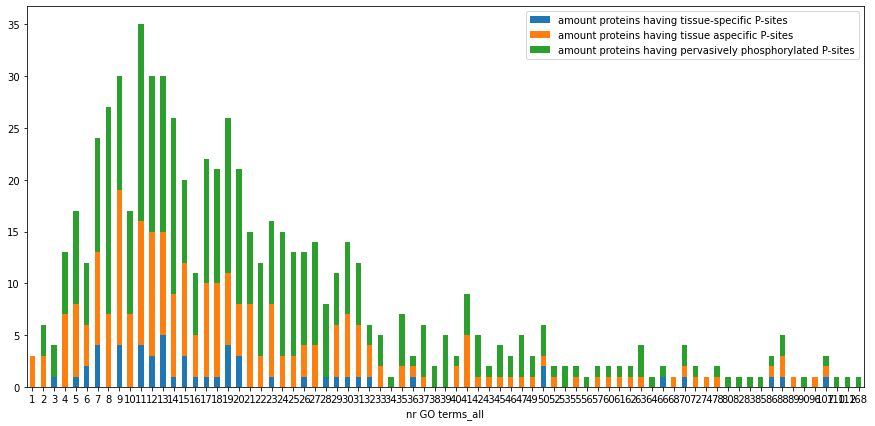

nr GO terms_all  amount proteins having tissue-specific P-sites  \
29                1                                             NaN   
30                2                                             NaN   
0                 3                                             1.0   
31                4                                             NaN   
1                 5                                             1.0   
..              ...                                             ...   
62               96                                             NaN   
28              107                                             1.0   
74              110                                             NaN   
75              112                                             NaN   
76              168                                             NaN   

    amount proteins having tissue aspecific P-sites  \
29                                              3.0   
30                                              3.0   
0                                               NaN   
31                                              7.0   
1                                               7.0   
..                                              ...   
62                                              1.0   
28                                              1.0   
74                                              NaN   
75                                              NaN   
76                                              NaN   

    amount proteins having pervasively phosphorylated P-sites  Total  
29                                                NaN            3.0  
30                                                3.0            6.0  
0                                                 3.0            4.0  
31                                                6.0           13.0  
1                                                 9.0           17.0  
..                                                ...            ...  
62                                                NaN            1.0  
28                                                1.0            3.0  
74                                                1.0            1.0  
75                                                1.0            1.0  
76                                                1.0            1.0  

[77 rows x 5 columns]

In [121]:
print(data_protein[data_protein["Urinary bladder"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Urinary bladder"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Urinary bladder"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Urinary bladder"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
39     GO:0000122                                             1.0   
128    GO:0000398                                             2.0   
908    GO:0003677                                             3.0   
928    GO:0003723                                             8.0   
943    GO:0003779                                             7.0   
1226   GO:0004674                                             0.0   
1425   GO:0005198                                             1.0   
1426   GO:0005200                                             7.0   
1502   GO:0005524                                            10.0   
1503   GO:0005525                                             3.0   
1518   GO:0005576                                            14.0   
1539   GO:0005615                                             6.0   
1541   GO:0005634                                            24.0   
1551   GO:0005654                                             9.0   
1580   GO:0005730                                             1.0   
1583   GO:0005737                                            17.0   
1584   GO:0005739                                             8.0   
1599   GO:0005759                                             2.0   
1616   GO:0005783                                             1.0   
1624   GO:0005794                                             1.0   
1639   GO:0005829                                            36.0   
1656   GO:0005856                                             7.0   
1676   GO:0005886                                            20.0   
1690   GO:0005912                                             3.0   
1697   GO:0005925                                            11.0   
1941   GO:0006468                                             1.0   
2164   GO:0006915                                             2.0   
2275   GO:0007165                                             2.0   
3309   GO:0015629                                             5.0   
3395   GO:0016020                                            10.0   
3400   GO:0016032                                             4.0   
3587   GO:0016607                                             2.0   
3925   GO:0019901                                             3.0   
5220   GO:0032991                                             5.0   
6464   GO:0042802                                            10.0   
6465   GO:0042803                                             5.0   
6595   GO:0043231                                             4.0   
6636   GO:0043312                                             3.0   
7024   GO:0045202                                             1.0   
7046   GO:0045296                                             6.0   
7252   GO:0045944                                             1.0   
7453   GO:0046872                                             3.0   
7687   GO:0048471                                             6.0   
8030   GO:0051015                                             4.0   
9064   GO:0070062                                            33.0   
9834   GO:0072562                                             5.0   
10695  GO:0106310                                             0.0   
10696  GO:0106311                                             0.0   
12161  GO:1990904                                             2.0   

       amount proteins having tissue aspecific P-sites  \
39                                                 6.0   
128                                                8.0   
908                                                9.0   
928                                               44.0   
943                                                8.0   
1226                                               2.0   
1425                                              13.0   
1426                                              14.0   
1502                                 

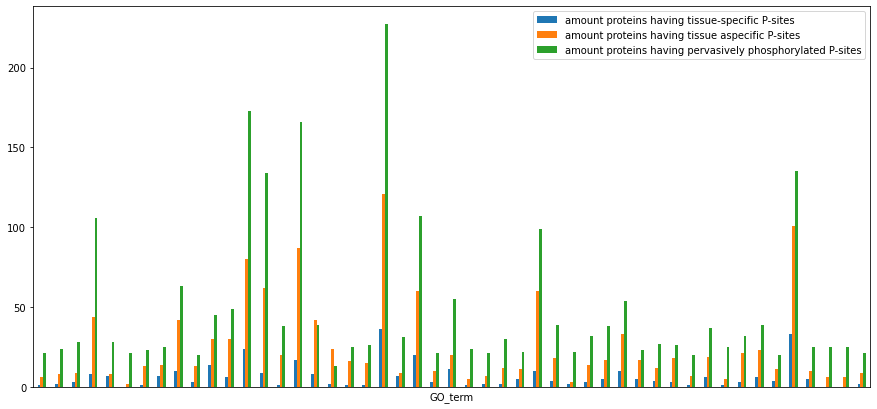

In [122]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Urinary bladder"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Urinary bladder"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Urinary bladder"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Urinary bladder"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Urinary bladder"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Urinary bladder"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=20)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=20)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=20)]

### Urine

81


<Figure size 1080x504 with 0 Axes>

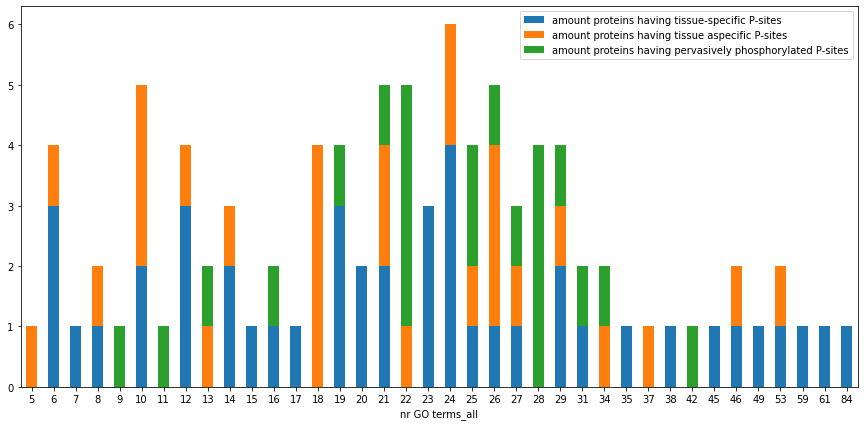

nr GO terms_all  amount proteins having tissue-specific P-sites  \
28                5                                             NaN   
0                 6                                             3.0   
1                 7                                             1.0   
2                 8                                             1.0   
34                9                                             NaN   
3                10                                             2.0   
35               11                                             NaN   
4                12                                             3.0   
29               13                                             NaN   
5                14                                             2.0   
6                15                                             1.0   
7                16                                             1.0   
8                17                                             1.0   
30               18                                             NaN   
9                19                                             3.0   
10               20                                             2.0   
11               21                                             2.0   
31               22                                             NaN   
12               23                                             3.0   
13               24                                             4.0   
14               25                                             1.0   
15               26                                             1.0   
16               27                                             1.0   
36               28                                             NaN   
17               29                                             2.0   
18               31                                             1.0   
32               34                                             NaN   
19               35                                             1.0   
33               37                                             NaN   
20               38                                             1.0   
37               42                                             NaN   
21               45                                             1.0   
22               46                                             1.0   
23               49                                             1.0   
24               53                                             1.0   
25               59                                             1.0   
26               61                                             1.0   
27               84                                             1.0   

    amount proteins having tissue aspecific P-sites  \
28                                              1.0   
0                                               1.0   
1                                               NaN   
2                                               1.0   
34                                              NaN   
3                                               3.0   
35                                              NaN   
4                                               1.0   
29                                              1.0   
5                                               1.0   
6                                               NaN   
7                                               NaN   
8                                               NaN   
30                                              4.0   
9                                               NaN   
10                                              NaN   
11                                              2.0   
31                                              1.0   
12                                              NaN   
13                                              2.0   
14                                              1.0   
15                      

In [123]:
print(data_protein[data_protein["Urine"]==1].shape[0])
grouped_tspec_tissue = proteins_tspec_sites.loc[proteins_tspec_sites["Urine"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_nontspec_tissue = proteins_taspec_sites.loc[proteins_taspec_sites["Urine"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()
grouped_general_tissue = proteins_genP_sites.loc[proteins_genP_sites["Urine"]==1, :].groupby(["nr GO terms_all"], as_index=False)["ACC_ID"].nunique()

grouped_all_tissue = pd.merge(grouped_tspec_tissue, grouped_nontspec_tissue, how="outer", on=["nr GO terms_all"], suffixes=("_tspec", "_nontspec"))
grouped_all_tissue = pd.merge(grouped_all_tissue, grouped_general_tissue, how="outer", on=["nr GO terms_all"])
grouped_all_tissue.rename(columns={"ACC_ID_tspec": "amount proteins having tissue-specific P-sites",
                                "ACC_ID_nontspec": "amount proteins having tissue aspecific P-sites",
                                "ACC_ID": "amount proteins having pervasively phosphorylated P-sites"}, inplace=True)
grouped_all_tissue.sort_values(by="nr GO terms_all", inplace=True)
plt.figure(figsize=(15,7))
grouped_all_tissue.set_index("nr GO terms_all").plot(kind="bar", stacked=True, figsize=(15,7), rot=0)
plt.show()
grouped_all_tissue["Total"] = grouped_all_tissue[["amount proteins having tissue-specific P-sites",
                                            "amount proteins having tissue aspecific P-sites",
                                            "amount proteins having pervasively phosphorylated P-sites"]].sum(axis=1)
grouped_all_tissue

GO_term  amount proteins having tissue-specific P-sites  \
1493  GO:0005509                                            10.0   
1518  GO:0005576                                            18.0   
1539  GO:0005615                                            19.0   
1639  GO:0005829                                            13.0   
1676  GO:0005886                                            23.0   
3395  GO:0016020                                            11.0   
9064  GO:0070062                                            33.0   
9834  GO:0072562                                             7.0   

      amount proteins having tissue aspecific P-sites  \
1493                                              2.0   
1518                                              9.0   
1539                                             13.0   
1639                                             10.0   
1676                                             10.0   
3395                                              6.0   
9064                                             25.0   
9834                                              7.0   

      amount proteins having pervasively phosphorylated P-sites  
1493                                                2.0          
1518                                               15.0          
1539                                               15.0          
1639                                                8.0          
1676                                                6.0          
3395                                                2.0          
9064                                               19.0          
9834                                               11.0

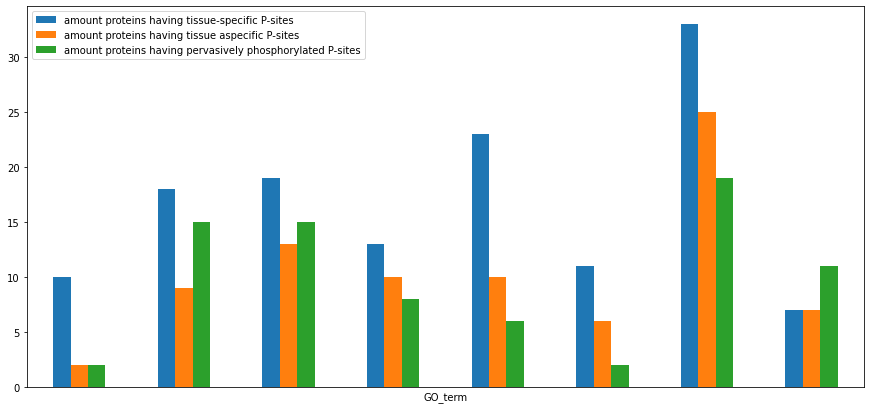

In [124]:
df_count_all_tspec_tissue = []
df_count_all_nontspec_tissue = []
df_count_all_general_tissue = []
for GO in uni_list_GO:
    if GO in uni_list_GO_tspec:
        count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Urine"]==1, GO].sum()
        df_count_all_tspec_tissue.append(count_tspec)
    else:
        df_count_all_tspec_tissue.append(0)
    if GO in uni_list_GO_taspec:
        count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Urine"]==1, GO].sum()
        df_count_all_nontspec_tissue.append(count_nontspec)
    else:
         df_count_all_nontspec_tissue.append(0)
    if GO in uni_list_GO_gen:
        count_general = proteins_genP_sites.loc[proteins_genP_sites["Urine"]==1, GO].sum()
        df_count_all_general_tissue.append(count_general)
    else:
        df_count_all_general_tissue.append(0)
for GO in uni_list_quick:
    count_tspec = proteins_tspec_sites.loc[proteins_tspec_sites["Urine"]==1, GO].sum()
    df_count_all_tspec_tissue.append(count_tspec)
    count_nontspec = proteins_taspec_sites.loc[proteins_taspec_sites["Urine"]==1, GO].sum()
    df_count_all_nontspec_tissue.append(count_nontspec)
    count_general = proteins_genP_sites.loc[proteins_genP_sites["Urine"]==1, GO].sum()
    df_count_all_general_tissue.append(count_general)
df_count_all_tissue = pd.DataFrame({"GO_term": uni_list_GO})
df_count_all_tissue2 = pd.DataFrame({"GO_term": uni_list_quick})
df_count_all_tissue = df_count_all_tissue.append(df_count_all_tissue2, ignore_index=True)
df_count_all_tissue["amount proteins having tissue-specific P-sites"] = df_count_all_tspec_tissue
df_count_all_tissue["amount proteins having tissue aspecific P-sites"] = df_count_all_nontspec_tissue
df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"] = df_count_all_general_tissue
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)].plot(x="GO_term", kind="bar", figsize=(15,7))
plt.xticks([])
df_count_all_tissue[(df_count_all_tissue["amount proteins having tissue-specific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having tissue aspecific P-sites"]>=10)|
                    (df_count_all_tissue["amount proteins having pervasively phosphorylated P-sites"]>=10)]

### Heatmap

We now represent each protein's GO-terms in a heatmap, indicating association (white) or not (black), split based on the categories of P-sites they bear.

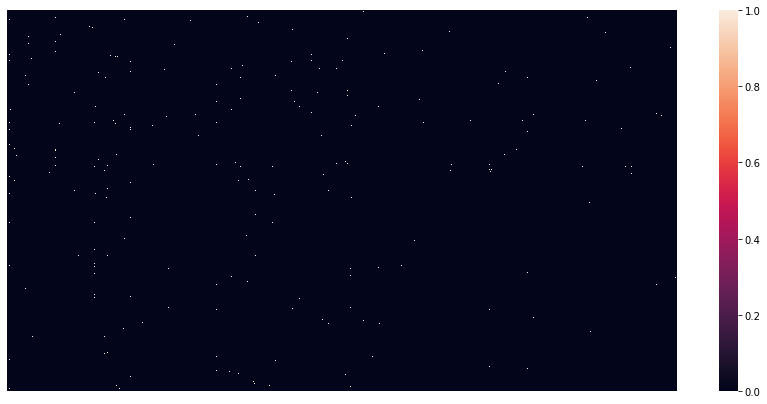

In [34]:
GO_annot_map_sub = GO_annot_map[["GO_term", "GO term name", "GO term definition"]]
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[uni_list_all]
#heatmap = heatmap.loc[:,(heatmap!=0).any(axis=0)]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [296]:
counts_all = pd.DataFrame({"GO_term":uni_list_GO})
counts_all2 = pd.DataFrame({"GO_term": uni_list_quick})
counts_all = counts_all.append(counts_all2, ignore_index=True)
list_counts_all = []
for GO in uni_list_GO:
    count = data_protein_GO[GO].sum()
    list_counts_all.append(count)
for GO in uni_list_quick:
    count = data_protein_GO[GO].sum()
    list_counts_all.append(count)

counts_all["count_all_groups"] = list_counts_all
counts_all.sort_values("count_all_groups", ascending=False).head(10)

GO_term  count_all_groups
1639  GO:0005829            2492.0
1541  GO:0005634            2160.0
1583  GO:0005737            1955.0
1551  GO:0005654            1781.0
1676  GO:0005886            1400.0
9064  GO:0070062            1155.0
3395  GO:0016020            1059.0
928   GO:0003723             851.0
1502  GO:0005524             710.0
6464  GO:0042802             690.0

In [297]:
counts_tspec = pd.DataFrame({"GO_term":uni_list_GO})
counts_tspec2 = pd.DataFrame({"GO_term": uni_list_quick})
counts_tspec = counts_tspec.append(counts_tspec2, ignore_index=True)

list_counts_tspec = []
for GO in uni_list_GO:
    count = proteins_tspec_sites[GO].sum()
    list_counts_tspec.append(count)
for GO in uni_list_quick:
    count= proteins_tspec_sites[GO].sum()
    list_counts_tspec.append(count)
counts_tspec["count_all_tspec"] = list_counts_tspec
counts_tspec.sort_values("count_all_tspec", ascending=False).head(10)

GO_term  count_all_tspec
1639  GO:0005829           2138.0
1541  GO:0005634           1884.0
1583  GO:0005737           1665.0
1551  GO:0005654           1565.0
1676  GO:0005886           1167.0
9064  GO:0070062           1019.0
3395  GO:0016020            907.0
928   GO:0003723            731.0
1502  GO:0005524            607.0
7453  GO:0046872            599.0

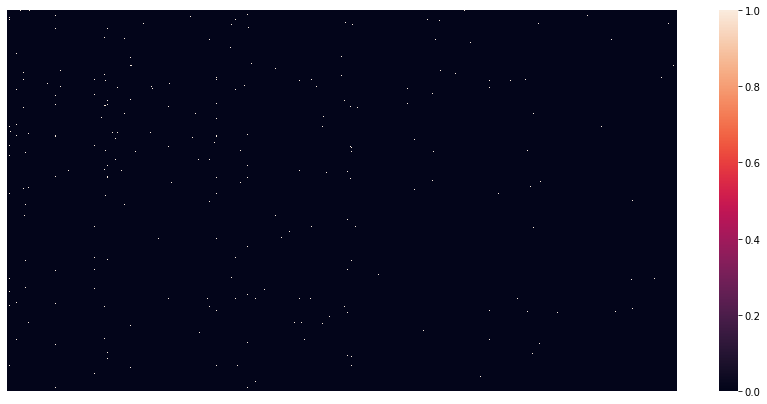

In [35]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[uni_list_all]
#heatmap = heatmap.loc[:,(heatmap!=0).any(axis=0)]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [234]:
counts_taspec = pd.DataFrame({"GO_term":uni_list_GO})
counts_taspec2 = pd.DataFrame({"GO_term": uni_list_quick})
counts_taspec = counts_taspec.append(counts_taspec2, ignore_index=True)

list_counts_taspec = []
for GO in uni_list_GO:
    count = proteins_taspec_sites[GO].sum()
    list_counts_taspec.append(count)
for GO in uni_list_quick:
    count= proteins_taspec_sites[GO].sum()
    list_counts_taspec.append(count)
counts_taspec["count_all_taspec"] = list_counts_taspec
counts_taspec.sort_values("count_all_taspec", ascending=False).head(10)

GO_term  count_all_taspec
1639  GO:0005829            1306.0
1541  GO:0005634            1123.0
1583  GO:0005737            1024.0
1551  GO:0005654             964.0
1676  GO:0005886             610.0
9064  GO:0070062             603.0
3395  GO:0016020             582.0
928   GO:0003723             538.0
1502  GO:0005524             381.0
6464  GO:0042802             350.0

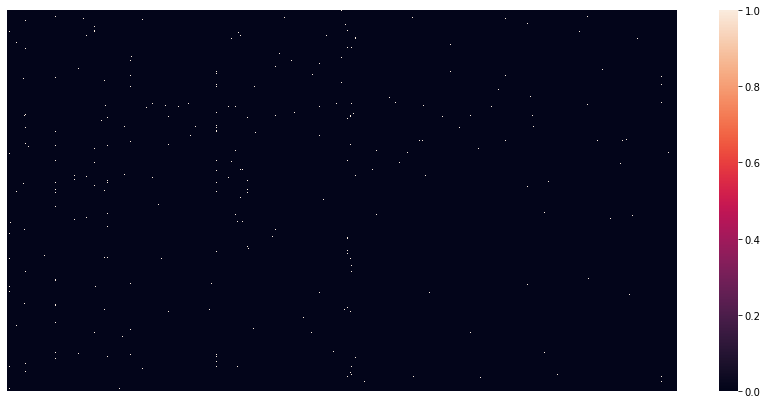

In [36]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[uni_list_all]
#heatmap = heatmap.loc[:,(heatmap!=0).any(axis=0)]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [366]:
counts_gen = pd.DataFrame({"GO_term":uni_list_GO})
counts_gen2 = pd.DataFrame({"GO_term": uni_list_quick})
counts_gen = counts_gen.append(counts_gen2, ignore_index=True)

list_counts_gen = []
for GO in uni_list_GO:
    count = proteins_genP_sites[GO].sum()
    list_counts_gen.append(count)
for GO in uni_list_quick:
    count= proteins_genP_sites[GO].sum()
    list_counts_gen.append(count)
counts_gen["count_all_pervasivelyP"] = list_counts_gen
counts_gen.sort_values("count_all_pervasivelyP", ascending=False).head(10)

GO_term  count_all_pervasivelyP
1639  GO:0005829                   657.0
1583  GO:0005737                   534.0
1541  GO:0005634                   512.0
1676  GO:0005886                   405.0
1551  GO:0005654                   390.0
9064  GO:0070062                   325.0
3395  GO:0016020                   300.0
928   GO:0003723                   271.0
6464  GO:0042802                   203.0
1502  GO:0005524                   188.0

## Colon

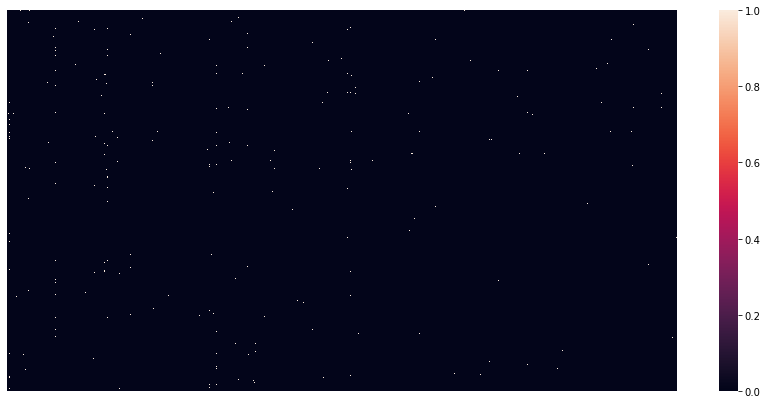

In [37]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Colon"]==1] 
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [298]:
GO_annot_map_sub = GO_annot_map[["GO_term", "GO term name", "GO term definition"]]
GO_annot_map_sub.set_index(["GO_term"], inplace=True)
GO_annot_map_sub

GO term name  \
GO_term                                                         
GO:0016020                                           membrane   
GO:0055114                        oxidation-reduction process   
GO:0016021                     integral component of membrane   
GO:0005743                       mitochondrial inner membrane   
GO:0005739                                      mitochondrion   
...                                                       ...   
GO:0140253                                   cell-cell fusion   
GO:0008747                 N-acetylneuraminate lyase activity   
GO:0140292               ADP-ribosylserine hydrolase activity   
GO:0140290                 peptidyl-serine ADP-deribosylation   
GO:0047276  N-acetyllactosaminide 3-alpha-galactosyltransf...   

                                           GO term definition  
GO_term                                                        
GO:0016020  A lipid bilayer along with all the proteins an...  
GO:0055114  A metabolic process that results in the remova...  
GO:0016021  The component of a membrane consisting of the ...  
GO:0005743  The inner, i.e. lumen-facing, lipid bilayer of...  
GO:0005739  A semiautonomous, self replicating organelle t...  
...                                                       ...  
GO:0140253  A cellular process in which two or more cells ...  
GO:0008747  Catalysis of the reaction: N-acetylneuraminate...  
GO:0140292  Catalysis of the reaction: (ADP-D-ribosyl)-L-s...  
GO:0140290  The removal of ADP-ribose from ADP-ribosylserine.  
GO:0047276  Catalysis of the reaction: beta-D-galactosyl-(...  

[18779 rows x 2 columns]

In [299]:
list_counts_tspeccolon = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Colon"]==1,GO].sum()
    list_counts_tspeccolon.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Colon"]==1,GO].sum()
    list_counts_tspeccolon.append(count)
counts_tspec["count_all"] = list_counts_all
counts_tspec["percentage a/w tspec"] = counts_tspec["count_all_tspec"]*100/proteins_tspec_sites.shape[0]
counts_tspec.drop(["count_all"], inplace=True, axis=1)
counts_tspec["count_Colon"] = list_counts_tspeccolon
counts_tspec.set_index(["GO_term"], inplace=True)
counts_tspec["percentage a/w_Colon_tspec"] = counts_tspec["count_Colon"]*100/(proteins_tspec_sites[proteins_tspec_sites["Colon"]==1].shape[0])
counts_tspec.sort_values("count_Colon", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005829           2138.0             43.865408       1029.0   
GO:0005634           1884.0             38.654083        912.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0046872            599.0             12.289700        294.0   
GO:0005524            607.0             12.453837        272.0   

            percentage a/w_Colon_tspec  
GO_term                                 
GO:0005829                   47.029250  
GO:0005634                   41.681901  
GO:0005654                   38.574040  
GO:0005737                   36.928702  
GO:0005886                   21.160878  
GO:0016020                   17.184644  
GO:0003723                   16.681901  
GO:0070062                   14.488117  
GO:0046872                   13.436929  
GO:0005524                   12.431444

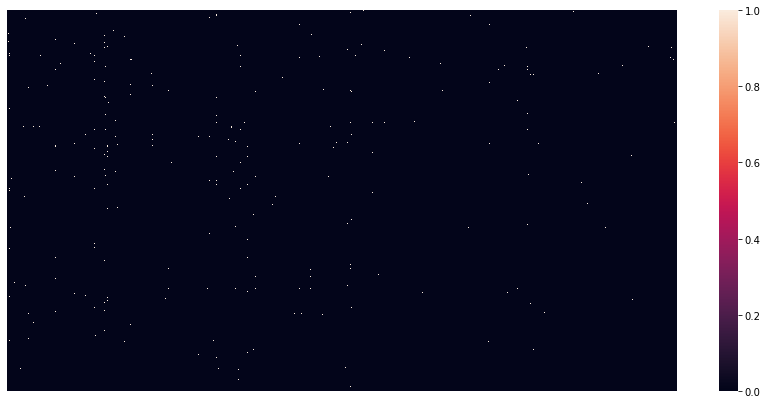

In [38]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Colon"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [235]:
list_counts_nontspeccolon = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Colon"]==1,GO].sum()
    list_counts_nontspeccolon.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Colon"]==1,GO].sum()
    list_counts_nontspeccolon.append(count)
counts_taspec["count_all"] = list_counts_all
counts_taspec["percentage a/w taspec"] = counts_taspec["count_all_taspec"]*100/proteins_taspec_sites.shape[0]
counts_taspec.drop(["count_all"], inplace=True, axis=1)
counts_taspec["count_Colon"] = list_counts_nontspeccolon
counts_taspec["percentage a/w_Colon_taspec"] = counts_taspec["count_Colon"]*100/proteins_taspec_sites[proteins_taspec_sites["Colon"]==1].shape[0]
counts_taspec.set_index(["GO_term"], inplace=True)
counts_taspec.sort_values("count_Colon", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005886             610.0              22.752704        413.0   
GO:0016020             582.0              21.708318        405.0   
GO:0003723             538.0              20.067139        405.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005524             381.0              14.211115        280.0   
GO:0046872             317.0              11.823946        238.0   

            percentage a/w_Colon_taspec  
GO_term                                  
GO:0005829                    48.995772  
GO:0005634                    44.133192  
GO:0005654                    41.331924  
GO:0005737                    38.900634  
GO:0005886                    21.828753  
GO:0016020                    21.405920  
GO:0003723                    21.405920  
GO:0070062                    17.071882  
GO:0005524                    14.799154  
GO:0046872                    12.579281

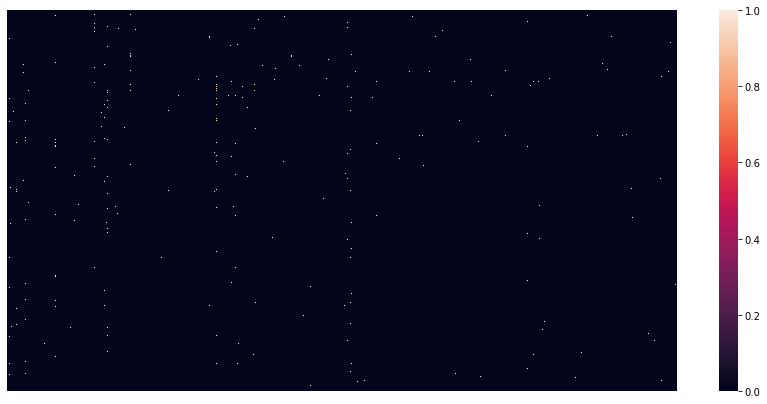

In [39]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Colon"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [367]:
list_counts_gencolon = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Colon"]==1,GO].sum()
    list_counts_gencolon.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Colon"]==1,GO].sum()
    list_counts_gencolon.append(count)
counts_gen["count_all"] = list_counts_all
counts_gen["percentage a/w pervasivelyP"] = counts_gen["count_all_pervasivelyP"]*100/proteins_genP_sites.shape[0]
counts_gen.drop(["count_all"], inplace=True, axis=1)
counts_gen["count_Colon"] = list_counts_gencolon
counts_gen["percentage a/w_Colon_pervasivelyP"] = counts_gen["count_Colon"]*100/proteins_genP_sites[proteins_genP_sites["Colon"]==1].shape[0]
counts_gen.set_index(["GO_term"], inplace=True)
counts_gen.sort_values("count_Colon", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005524                   188.0                    13.925926        124.0   

            percentage a/w_Colon_pervasivelyP  
GO_term                                        
GO:0005829                          52.955083  
GO:0005634                          44.917258  
GO:0005737                          44.326241  
GO:0005654                          38.416076  
GO:0003723                          28.368794  
GO:0016020                          25.650118  
GO:0070062                          25.413712  
GO:0005886                          25.177305  
GO:0042802                          15.957447  
GO:0005524                          14.657210

In [232]:
list_all_colon = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_colon = pd.concat(list_all_colon, axis=1)
all_colon[(((all_colon["percentage a/w_Colon_tspec"]>=7)&(all_colon["percentage a/w tspec"]<=7))|
           ((all_colon["percentage a/w_Colon_taspec"]>=7)&(all_colon["percentage a/w taspec"]<=7))|
         ((all_colon["percentage a/w_Colon_pervasivelyP"]>=7)&((all_colon["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0000122            273.0              5.601149        163.0   
GO:0000785            288.0              5.908904        166.0   
GO:0003677            366.0              7.509233        205.0   
GO:0006357            359.0              7.365613        203.0   
GO:0016607            210.0              4.308576        115.0   
GO:0043231            313.0              6.421830        151.0   
GO:0045944            346.0              7.098892        184.0   
GO:0048471            310.0              6.360279        162.0   

            percentage a/w_Colon_tspec  count_all_taspec  \
GO_term                                                    
GO:0000122                    7.449726             161.0   
GO:0000785                    7.586837             147.0   
GO:0003677                    9.369287             222.0   
GO:0006357                    9.277879             178.0   
GO:0016607                    5.255941             135.0   
GO:0043231                    6.901280             185.0   
GO:0045944                    8.409506             206.0   
GO:0048471                    7.404022             192.0   

            percentage a/w taspec  count_Colon  percentage a/w_Colon_taspec  \
GO_term                                                                       
GO:0000122               6.005222        129.0                     6.818182   
GO:0000785               5.483029        119.0                     6.289641   
GO:0003677               8.280492        176.0                     9.302326   
GO:0006357               6.639314        149.0                     7.875264   
GO:0016607               5.035435        111.0                     5.866808   
GO:0043231               6.900410        137.0                     7.241015   
GO:0045944               7.683700        169.0                     8.932347   
GO:0048471               7.161507        133.0                     7.029598   

            count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0000122                    60.0                     4.444444         52.0   
GO:0000785                    46.0                     3.407407         38.0   
GO:0003677                    75.0                     5.555556         65.0   
GO:0006357                    51.0                     3.777778         43.0   
GO:0016607                    65.0                     4.814815         60.0   
GO:0043231                    86.0                     6.370370         51.0   
GO:0045944                    70.0                     5.185185         62.0   
GO:0048471                   120.0                     8.888889         78.0   

            percentage a/w_Colon_pervasivelyP  \
GO_term                                         
GO:0000122                           6.146572   
GO:0000785                           4.491726   
GO:0003677                           7.683215   
GO:0006357                           5.082742   
GO:0016607                           7.092199   
GO:0043231                           6.028369   
GO:0045944                           7.328605   
GO:0048471                           9.219858   

                                                 GO term name  \
GO_term                                                         
GO:0000122  negative regulation of transcription by RNA po...   
GO:0000785                                          chromatin   
GO:0003677                                        DNA binding   
GO:0006357   regulation of transcription by RNA polymerase II   
GO:0016607                                      nuclear speck   
GO:0043231           intracellular membrane-bounded organelle   
GO:0045944  positive regulation of transcription by RNA po...   
GO:0048471                    perinuclear region of cytoplasm   

                

## Adipose tissue

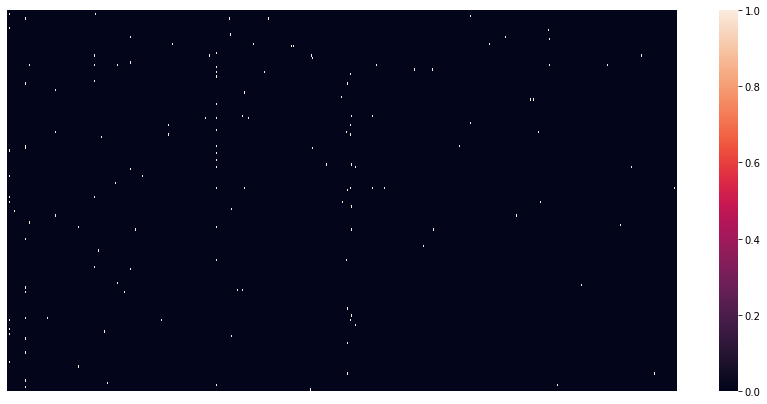

In [40]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Adipose tissue"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [236]:
list_counts_nontspec_ad = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Adipose tissue"]==1,GO].sum()
    list_counts_nontspec_ad.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Adipose tissue"]==1,GO].sum()
    list_counts_nontspec_ad.append(count)
counts_taspec["count_Adipose_tissue"] = list_counts_nontspec_ad
counts_taspec["percentage a/w_Adipose_tissue_taspec"] = counts_taspec["count_Adipose_tissue"]*100/proteins_taspec_sites[proteins_taspec_sites["Adipose tissue"]==1].shape[0]
counts_taspec.sort_values("count_Adipose_tissue", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0016020             582.0              21.708318        405.0   
GO:0003723             538.0              20.067139        405.0   
GO:0005886             610.0              22.752704        413.0   
GO:0005925             185.0               6.900410        114.0   
GO:0042802             350.0              13.054830        238.0   
GO:0005576             203.0               7.571802         76.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0005737                    38.900634                  91.0   
GO:0070062                    17.071882                  89.0   
GO:0005634                    44.133192                  73.0   
GO:0016020                    21.405920                  52.0   
GO:0003723                    21.405920                  43.0   
GO:0005886                    21.828753                  42.0   
GO:0005925                     6.025370                  40.0   
GO:0042802                    12.579281                  34.0   
GO:0005576                     4.016913                  33.0   

            percentage a/w_Adipose_tissue_taspec  
GO_term                                           
GO:0005829                             71.341463  
GO:0005737                             55.487805  
GO:0070062                             54.268293  
GO:0005634                             44.512195  
GO:0016020                             31.707317  
GO:0003723                             26.219512  
GO:0005886                             25.609756  
GO:0005925                             24.390244  
GO:0042802                             20.731707  
GO:0005576                             20.121951

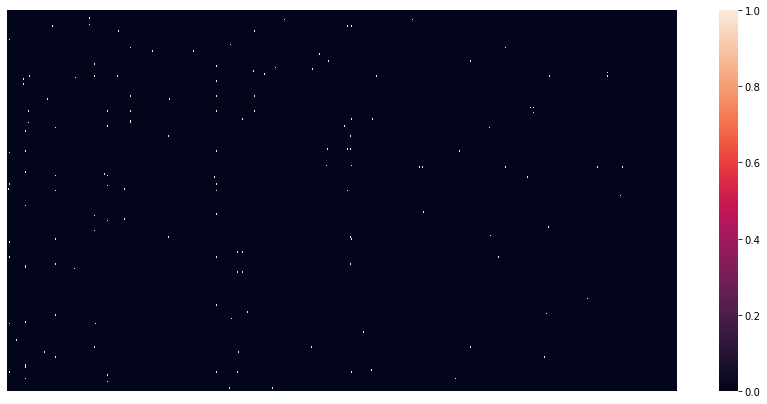

In [41]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Adipose tissue"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [368]:
list_counts_gen_ad = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Adipose tissue"]==1,GO].sum()
    list_counts_gen_ad.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Adipose tissue"]==1,GO].sum()
    list_counts_gen_ad.append(count)
counts_gen["count_Adipose_tissue"] = list_counts_gen_ad
counts_gen["percentage a/w_Adipose_tissue_pervasivelyP"] = counts_gen["count_Adipose_tissue"]*100/proteins_genP_sites[proteins_genP_sites["Adipose tissue"]==1].shape[0]
counts_gen.sort_values("count_Adipose_tissue", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0005925                   106.0                     7.851852         91.0   
GO:0042802                   203.0                    15.037037        135.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005634                          44.917258                 102.0   
GO:0070062                          25.413712                 100.0   
GO:0005886                          25.177305                  70.0   
GO:0016020                          25.650118                  68.0   
GO:0003723                          28.368794                  68.0   
GO:0005654                          38.416076                  58.0   
GO:0005925                          10.756501                  43.0   
GO:0042802                          15.957447                  38.0   

            percentage a/w_Adipose_tissue_pervasivelyP  
GO_term                                                 
GO:0005829                                   63.318777  
GO:0005737                                   59.388646  
GO:0005634                                   44.541485  
GO:0070062                                   43.668122  
GO:0005886                                   30.567686  
GO:0016020                                   29.694323  
GO:0003723                                   29.694323  
GO:0005654                                   25.327511  
GO:0005925                                   18.777293  
GO:0042802                                   16.593886

## B-cells

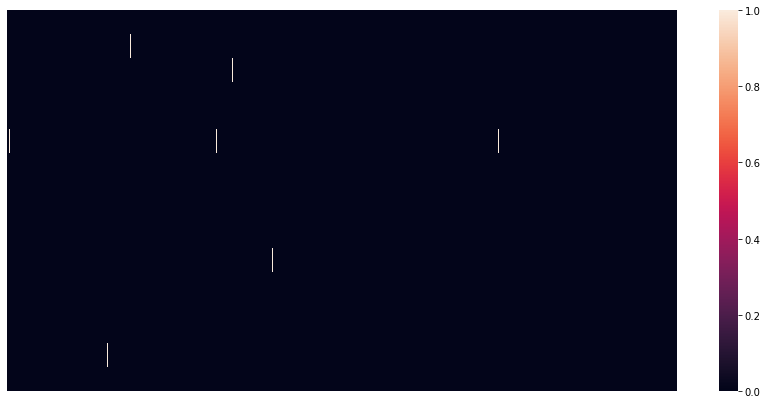

In [42]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["B-cells"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [300]:
list_counts_tspec_B_cells = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["B-cells"]==1,GO].sum()
    list_counts_tspec_B_cells.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["B-cells"]==1,GO].sum()
    list_counts_tspec_B_cells.append(count)
counts_tspec["count_B_cells"] = list_counts_tspec_B_cells
counts_tspec["percentage a/w_B_cells_tspec"] = counts_tspec["count_B_cells"]*100/(proteins_tspec_sites[proteins_tspec_sites["B-cells"]==1].shape[0])
counts_tspec.sort_values("count_B_cells", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005634           1884.0             38.654083        912.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0005829           2138.0             43.865408       1029.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0006357            359.0              7.365613        203.0   
GO:0000978            240.0              4.924087        128.0   
GO:0016021            458.0              9.396799        153.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0045944            346.0              7.098892        184.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005634                   41.681901            7.0   
GO:0005654                   38.574040            6.0   
GO:0005829                   47.029250            6.0   
GO:0005886                   21.160878            5.0   
GO:0005737                   36.928702            4.0   
GO:0006357                    9.277879            3.0   
GO:0000978                    5.850091            3.0   
GO:0016021                    6.992687            3.0   
GO:0070062                   14.488117            3.0   
GO:0045944                    8.409506            3.0   

            percentage a/w_B_cells_tspec  
GO_term                                   
GO:0005634                         43.75  
GO:0005654                         37.50  
GO:0005829                         37.50  
GO:0005886                         31.25  
GO:0005737                         25.00  
GO:0006357                         18.75  
GO:0000978                         18.75  
GO:0016021                         18.75  
GO:0070062                         18.75  
GO:0045944                         18.75

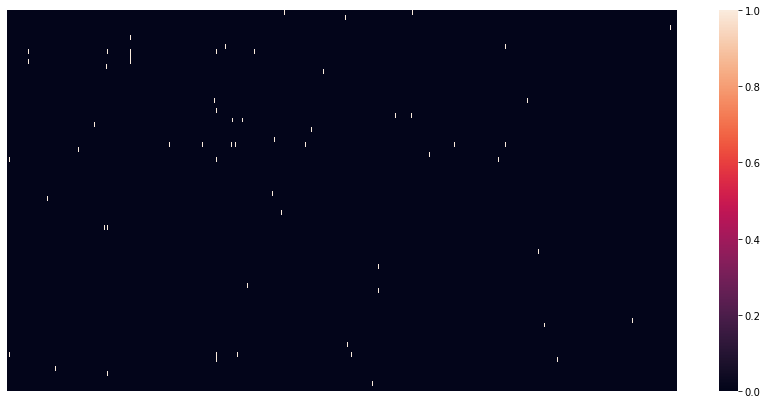

In [43]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["B-cells"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [237]:
list_counts_nontspec_B_cells = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["B-cells"]==1,GO].sum()
    list_counts_nontspec_B_cells.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["B-cells"]==1,GO].sum()
    list_counts_nontspec_B_cells.append(count)
counts_taspec["count_B_cells"] = list_counts_nontspec_B_cells
counts_taspec["percentage a/w_B_cells"] = counts_taspec["count_B_cells"]*100/proteins_taspec_sites[proteins_taspec_sites["B-cells"]==1].shape[0]
counts_taspec.sort_values("count_B_cells", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005886             610.0              22.752704        413.0   
GO:0016020             582.0              21.708318        405.0   
GO:0003723             538.0              20.067139        405.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005524             381.0              14.211115        280.0   
GO:0042802             350.0              13.054830        238.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0005654                    41.331924                  26.0   
GO:0005737                    38.900634                  91.0   
GO:0005634                    44.133192                  73.0   
GO:0005886                    21.828753                  42.0   
GO:0016020                    21.405920                  52.0   
GO:0003723                    21.405920                  43.0   
GO:0070062                    17.071882                  89.0   
GO:0005524                    14.799154                  26.0   
GO:0042802                    12.579281                  34.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0005654                             15.853659           34.0   
GO:0005737                             55.487805           33.0   
GO:0005634                             44.512195           33.0   
GO:0005886                             25.609756           27.0   
GO:0016020                             31.707317           17.0   
GO:0003723                             26.219512           14.0   
GO:0070062                             54.268293           12.0   
GO:0005524                             15.853659           11.0   
GO:0042802                             20.731707           11.0   

            percentage a/w_B_cells  
GO_term                             
GO:0005829               48.717949  
GO:0005654               43.589744  
GO:0005737               42.307692  
GO:0005634               42.307692  
GO:0005886               34.615385  
GO:0016020               21.794872  
GO:0003723               17.948718  
GO:0070062               15.384615  
GO:0005524               14.102564  
GO:0042802               14.102564

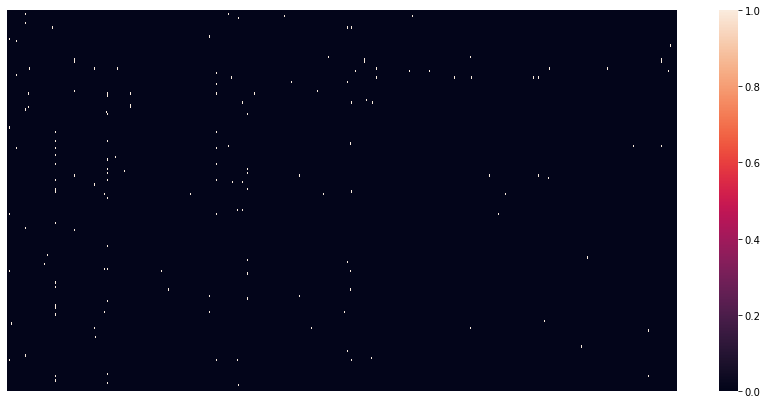

In [44]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["B-cells"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [369]:
list_counts_gen_B_cells = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["B-cells"]==1,GO].sum()
    list_counts_gen_B_cells.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["B-cells"]==1,GO].sum()
    list_counts_gen_B_cells.append(count)
counts_gen["count_B_cells"] = list_counts_gen_B_cells
counts_gen["percentage a/w_B_cells_pervasivelyP"] = counts_gen["count_B_cells"]*100/proteins_genP_sites[proteins_genP_sites["B-cells"]==1].shape[0]
counts_gen.sort_values("count_B_cells", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005634                   512.0                    37.925926        380.0   
GO:0005829                   657.0                    48.666667        448.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005524                   188.0                    13.925926        124.0   
GO:0000398                    53.0                     3.925926         49.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005634                          44.917258                 102.0   
GO:0005829                          52.955083                 145.0   
GO:0005654                          38.416076                  58.0   
GO:0003723                          28.368794                  68.0   
GO:0005737                          44.326241                 136.0   
GO:0005886                          25.177305                  70.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0005524                          14.657210                  36.0   
GO:0000398                           5.791962                  11.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005634                                   44.541485           95.0   
GO:0005829                                   63.318777           86.0   
GO:0005654                                   25.327511           82.0   
GO:0003723                                   29.694323           75.0   
GO:0005737                                   59.388646           62.0   
GO:0005886                                   30.567686           42.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0005524                                   15.720524           31.0   
GO:0000398                                    4.803493           25.0   

            percentage a/w_B_cells_pervasivelyP  
GO_term                                          
GO:0005634                            56.886228  
GO:0005829                            51.497006  
GO:0005654                            49.101796  
GO:0003723                            44.910180  
GO:0005737                            37.125749  
GO:0005886                            25.149701  
GO:0070062                            23.353293  
GO:0016020                            22.754491  
GO:0005524                            18.562874  
GO:0000398                            14.970060

## Blood

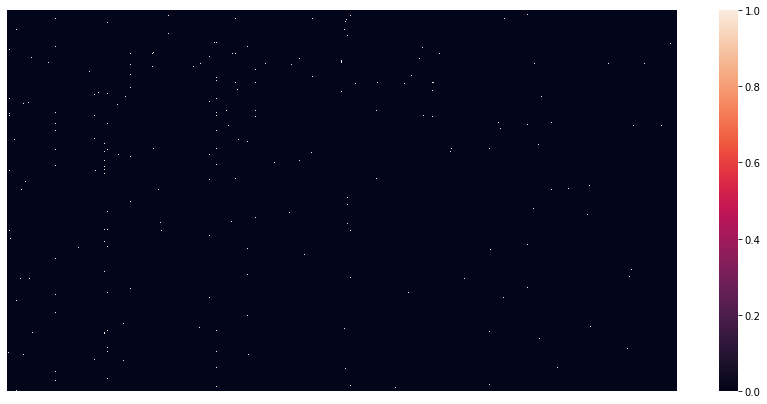

In [45]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Blood"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [301]:
list_counts_tspec_Blood = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Blood"]==1,GO].sum()
    list_counts_tspec_Blood.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Blood"]==1,GO].sum()
    list_counts_tspec_Blood.append(count)
counts_tspec["count_Blood"] = list_counts_tspec_Blood
counts_tspec["percentage a/w_Blood_tspec"] = counts_tspec["count_Blood"]*100/(proteins_tspec_sites[proteins_tspec_sites["Blood"]==1].shape[0])
counts_tspec.sort_values("count_Blood", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005634           1884.0             38.654083        912.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0005829           2138.0             43.865408       1029.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0046872            599.0             12.289700        294.0   
GO:0005524            607.0             12.453837        272.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005634                   41.681901            7.0   
GO:0005654                   38.574040            6.0   
GO:0005829                   47.029250            6.0   
GO:0005737                   36.928702            4.0   
GO:0005886                   21.160878            5.0   
GO:0016020                   17.184644            2.0   
GO:0003723                   16.681901            2.0   
GO:0070062                   14.488117            3.0   
GO:0046872                   13.436929            2.0   
GO:0005524                   12.431444            1.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005634                         43.75        459.0   
GO:0005654                         37.50        456.0   
GO:0005829                         37.50        435.0   
GO:0005737                         25.00        329.0   
GO:0005886                         31.25        194.0   
GO:0016020                         12.50        187.0   
GO:0003723                         12.50        167.0   
GO:0070062                         18.75        167.0   
GO:0046872                         12.50        142.0   
GO:0005524                          6.25        122.0   

            percentage a/w_Blood_tspec  
GO_term                                 
GO:0005634                   44.736842  
GO:0005654                   44.444444  
GO:0005829                   42.397661  
GO:0005737                   32.066277  
GO:0005886                   18.908382  
GO:0016020                   18.226121  
GO:0003723                   16.276803  
GO:0070062                   16.276803  
GO:0046872                   13.840156  
GO:0005524                   11.890838

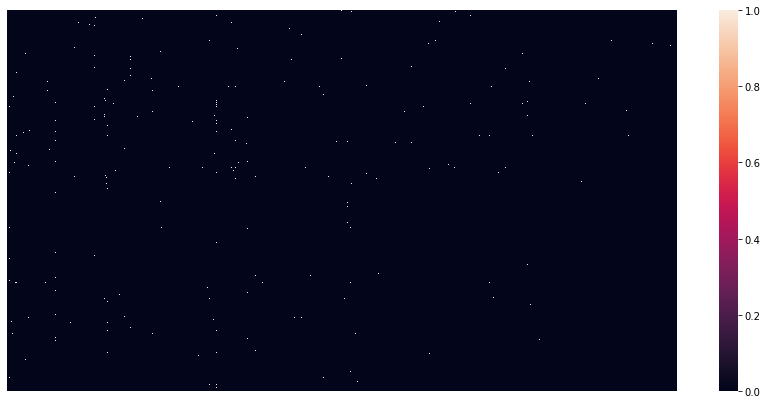

In [46]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Blood"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [238]:
list_counts_nontspec_Blood = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Blood"]==1,GO].sum()
    list_counts_nontspec_Blood.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Blood"]==1,GO].sum()
    list_counts_nontspec_Blood.append(count)
counts_taspec["count_Blood"] = list_counts_nontspec_Blood
counts_taspec["percentage a/w_Blood_taspec"] = counts_taspec["count_Blood"]*100/proteins_taspec_sites[proteins_taspec_sites["Blood"]==1].shape[0]
counts_taspec.sort_values("count_Blood", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005634            1123.0              41.887355        835.0   
GO:0005829            1306.0              48.713167        927.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0003723             538.0              20.067139        405.0   
GO:0016020             582.0              21.708318        405.0   
GO:0005886             610.0              22.752704        413.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005524             381.0              14.211115        280.0   
GO:0046872             317.0              11.823946        238.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005634                    44.133192                  73.0   
GO:0005829                    48.995772                 117.0   
GO:0005654                    41.331924                  26.0   
GO:0005737                    38.900634                  91.0   
GO:0003723                    21.405920                  43.0   
GO:0016020                    21.405920                  52.0   
GO:0005886                    21.828753                  42.0   
GO:0070062                    17.071882                  89.0   
GO:0005524                    14.799154                  26.0   
GO:0046872                    12.579281                  18.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005634                             44.512195           33.0   
GO:0005829                             71.341463           38.0   
GO:0005654                             15.853659           34.0   
GO:0005737                             55.487805           33.0   
GO:0003723                             26.219512           14.0   
GO:0016020                             31.707317           17.0   
GO:0005886                             25.609756           27.0   
GO:0070062                             54.268293           12.0   
GO:0005524                             15.853659           11.0   
GO:0046872                             10.975610           10.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  
GO_term                                                                       
GO:0005634               42.307692        652.0                    46.839080  
GO:0005829               48.717949        630.0                    45.258621  
GO:0005654               43.589744        626.0                    44.971264  
GO:0005737               42.307692        496.0                    35.632184  
GO:0003723               17.948718        318.0                    22.844828  
GO:0016020               21.794872        307.0                    22.054598  
GO:0005886               34.615385        268.0                    19.252874  
GO:0070062               15.384615        218.0                    15.660920  
GO:0005524               14.102564        189.0                    13.577586  
GO:0046872               12.820513        183.0                    13.146552

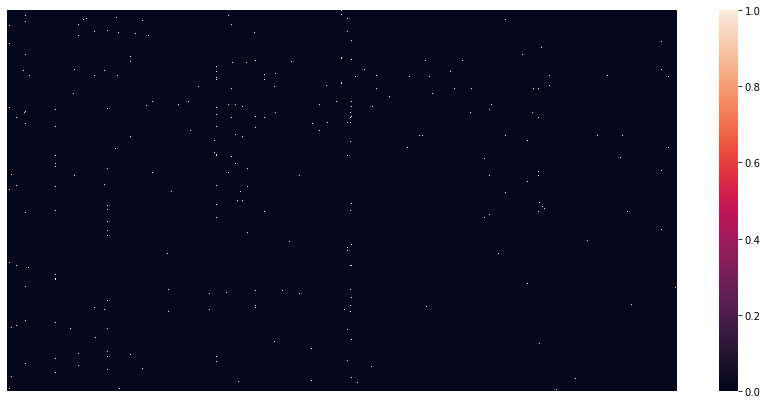

In [47]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Blood"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [370]:
list_counts_gen_Blood = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Blood"]==1,GO].sum()
    list_counts_gen_Blood.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Blood"]==1,GO].sum()
    list_counts_gen_Blood.append(count)
counts_gen["count_Blood"] = list_counts_gen_Blood
counts_gen["percentage a/w_Blood_pervasivelyP"] = counts_gen["count_Blood"]*100/proteins_genP_sites[proteins_genP_sites["Blood"]==1].shape[0]
counts_gen.sort_values("count_Blood", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005524                   188.0                    13.925926        124.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005634                          44.917258                 102.0   
GO:0005886                          25.177305                  70.0   
GO:0005654                          38.416076                  58.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0003723                          28.368794                  68.0   
GO:0042802                          15.957447                  38.0   
GO:0005524                          14.657210                  36.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005634                                   44.541485           95.0   
GO:0005886                                   30.567686           42.0   
GO:0005654                                   25.327511           82.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0003723                                   29.694323           75.0   
GO:0042802                                   16.593886           20.0   
GO:0005524                                   15.720524           31.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005634                            56.886228        452.0   
GO:0005886                            25.149701        370.0   
GO:0005654                            49.101796        351.0   
GO:0070062                            23.353293        279.0   
GO:0016020                            22.754491        266.0   
GO:0003723                            44.910180        235.0   
GO:0042802                            11.976048        180.0   
GO:0005524                            18.562874        175.0   

            percentage a/w_Blood_pervasivelyP  
GO_term                                        
GO:0005829                          47.463175  
GO:0005737                          39.525368  
GO:0005634                          36.988543  
GO:0005886                          30.278232  
GO:0005654                          28.723404  
GO:0070062                          22.831424  
GO:0016020                          21.767594  
GO:0003723                          19.230769  
GO:0042802                          14.729951  
GO:0005524              

The comparison on the tissue level seems less efficient, probably because of overlapping proteins across the three groups

In [241]:
list_all_Blood = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_Blood = pd.concat(list_all_Blood, axis=1)
all_Blood[(((all_Blood["percentage a/w_Blood_tspec"]>=7)&(all_Blood["percentage a/w tspec"]<=7))|
           ((all_Blood["percentage a/w_Blood_taspec"]>=7)&(all_Blood["percentage a/w taspec"]<=7))|
         ((all_Blood["percentage a/w_Blood_pervasivelyP"]>=7)&((all_Blood["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0000122            273.0              5.601149        163.0   
GO:0000785            288.0              5.908904        166.0   
GO:0006357            359.0              7.365613        203.0   
GO:0032991            311.0              6.380796        145.0   
GO:0043231            313.0              6.421830        151.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0000122                    7.449726            2.0   
GO:0000785                    7.586837            0.0   
GO:0006357                    9.277879            3.0   
GO:0032991                    6.627057            2.0   
GO:0043231                    6.901280            1.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0000122                         12.50         70.0   
GO:0000785                          0.00         84.0   
GO:0006357                         18.75         97.0   
GO:0032991                         12.50         78.0   
GO:0043231                          6.25         67.0   

            percentage a/w_Blood_tspec  count_all_taspec  \
GO_term                                                    
GO:0000122                    6.822612             161.0   
GO:0000785                    8.187135             147.0   
GO:0006357                    9.454191             178.0   
GO:0032991                    7.602339             202.0   
GO:0043231                    6.530214             185.0   

            percentage a/w taspec  ...  count_Colon  \
GO_term                            ...                
GO:0000122               6.005222  ...         52.0   
GO:0000785               5.483029  ...         38.0   
GO:0006357               6.639314  ...         43.0   
GO:0032991               7.534502  ...         77.0   
GO:0043231               6.900410  ...         51.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0000122                           6.146572                   8.0   
GO:0000785                           4.491726                   8.0   
GO:0006357                           5.082742                   6.0   
GO:0032991                           9.101655                  19.0   
GO:0043231                           6.028369                  13.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0000122                                    3.493450            9.0   
GO:0000785                                    3.493450           11.0   
GO:0006357                                    2.620087           12.0   
GO:0032991                                    8.296943           12.0   
GO:0043231                                    5.676856            6.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0000122                             5.389222         50.0   
GO:0000785                             6.586826         38.0   
GO:0006357                             7.185629         48.0   
GO:0032991                             7.185629         85.0   
GO:0043231                             3.592814         76.0   

            percentage a/w_Blood_pervasivelyP  \
GO_term                                         
GO:0000122                           4.091653   
GO:0000785                           3.109656   
GO:0006357                           3.927987   
GO:0032991                           6.955810   
GO:0043231                           6.219313   

                                                 GO term name  \
GO_term                                                         
GO:000012

## Bone

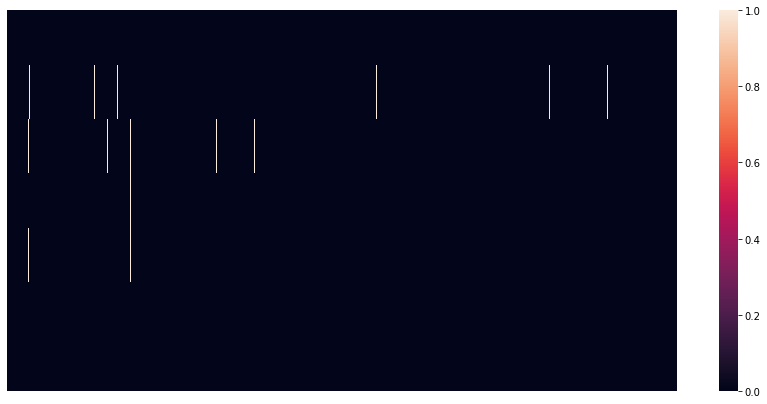

In [48]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Bone"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Brain

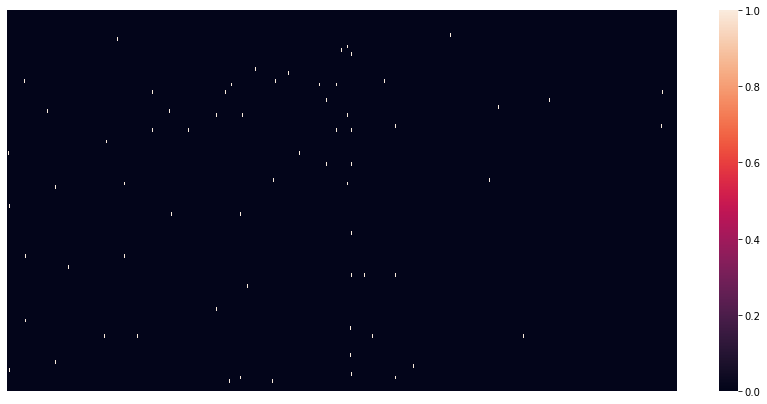

In [49]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Brain"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [302]:
list_counts_tspec_Brain = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Brain"]==1,GO].sum()
    list_counts_tspec_Brain.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Brain"]==1,GO].sum()
    list_counts_tspec_Brain.append(count)
counts_tspec["count_Brain"] = list_counts_tspec_Brain
counts_tspec["percentage a/w_Brain_tspec"] = counts_tspec["count_Brain"]*100/(proteins_tspec_sites[proteins_tspec_sites["Brain"]==1].shape[0])
counts_tspec.sort_values("count_Brain", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005737           1665.0             34.160854        808.0   
GO:0005829           2138.0             43.865408       1029.0   
GO:0005634           1884.0             38.654083        912.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0042802            580.0             11.899877        256.0   
GO:0003779            165.0              3.385310         59.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005737                   36.928702            4.0   
GO:0005829                   47.029250            6.0   
GO:0005634                   41.681901            7.0   
GO:0070062                   14.488117            3.0   
GO:0005886                   21.160878            5.0   
GO:0005654                   38.574040            6.0   
GO:0016020                   17.184644            2.0   
GO:0003723                   16.681901            2.0   
GO:0042802                   11.700183            3.0   
GO:0003779                    2.696527            0.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005737                         25.00        329.0   
GO:0005829                         37.50        435.0   
GO:0005634                         43.75        459.0   
GO:0070062                         18.75        167.0   
GO:0005886                         31.25        194.0   
GO:0005654                         37.50        456.0   
GO:0016020                         12.50        187.0   
GO:0003723                         12.50        167.0   
GO:0042802                         18.75        103.0   
GO:0003779                          0.00         27.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005737                   32.066277         52.0   
GO:0005829                   42.397661         50.0   
GO:0005634                   44.736842         40.0   
GO:0070062                   16.276803         34.0   
GO:0005886                   18.908382         33.0   
GO:0005654                   44.444444         18.0   
GO:0016020                   18.226121         16.0   
GO:0003723                   16.276803         15.0   
GO:0042802                   10.038986         15.0   
GO:0003779                    2.631579         13.0   

            percentage a/w_Brain_tspec  
GO_term                                 
GO:0005737                        52.0  
GO:0005829                        50.0  
GO:0005634                        40.0  
GO:0070062                        34.0  
GO:0005886                        33.0  
GO:0005654                        18.0  
GO:0016020                        16.0  
GO:0003723                        15.0  
GO:0042802                        15.0  
GO:0003779                        13.0

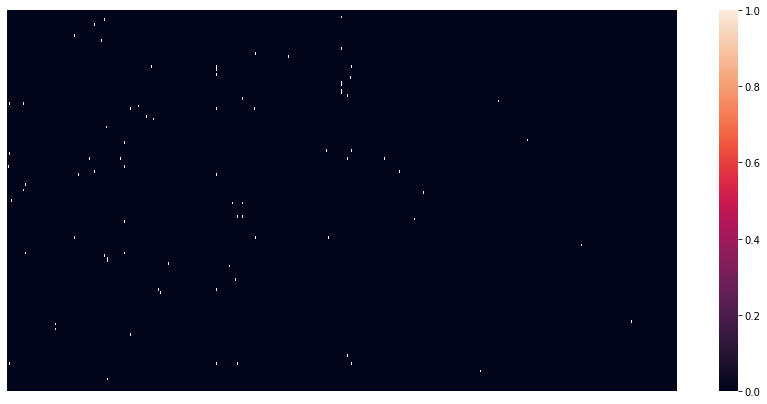

In [50]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Brain"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [239]:
list_counts_nontspec_Brain = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Brain"]==1,GO].sum()
    list_counts_nontspec_Brain.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Brain"]==1,GO].sum()
    list_counts_nontspec_Brain.append(count)
counts_taspec["count_Brain"] = list_counts_nontspec_Brain
counts_taspec["percentage a/w_Brain_taspec"] = counts_taspec["count_Brain"]*100/proteins_taspec_sites[proteins_taspec_sites["Brain"]==1].shape[0]
counts_taspec.sort_values("count_Brain", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005886             610.0              22.752704        413.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005615             200.0               7.459903         71.0   
GO:0005654             964.0              35.956733        782.0   
GO:0016020             582.0              21.708318        405.0   
GO:0005856             131.0               4.886236         84.0   
GO:0005576             203.0               7.571802         76.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0005737                    38.900634                  91.0   
GO:0070062                    17.071882                  89.0   
GO:0005886                    21.828753                  42.0   
GO:0005634                    44.133192                  73.0   
GO:0005615                     3.752643                  28.0   
GO:0005654                    41.331924                  26.0   
GO:0016020                    21.405920                  52.0   
GO:0005856                     4.439746                  15.0   
GO:0005576                     4.016913                  33.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0005737                             55.487805           33.0   
GO:0070062                             54.268293           12.0   
GO:0005886                             25.609756           27.0   
GO:0005634                             44.512195           33.0   
GO:0005615                             17.073171            2.0   
GO:0005654                             15.853659           34.0   
GO:0016020                             31.707317           17.0   
GO:0005856                              9.146341            9.0   
GO:0005576                             20.121951            7.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0005737               42.307692        496.0                    35.632184   
GO:0070062               15.384615        218.0                    15.660920   
GO:0005886               34.615385        268.0                    19.252874   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005615                2.564103         77.0                     5.531609   
GO:0005654               43.589744        626.0                    44.971264   
GO:0016020               21.794872        307.0                    22.054598   
GO:0005856               11.538462         42.0                     3.017241   
GO:0005576                8.974359         77.0                     5.531609   

            count_Brain  percentage a/w_Brain_taspec  
GO_term                                               
GO:0005829         65.0                    44.827586  
GO:0005737         65.0                    44.827586  
GO:0070062         56.0                    38.620690  
GO:0005886         54.0                    37.241379  
GO:0005634         46.0                    31.724138  
GO:0005615         29.0                    20.000000  
GO:0005654         29.0                    20.000000  
GO:0016020         28.0                    19.310345  
GO:0005856         25.0                    17.241379  
GO:0005576         23.0                    

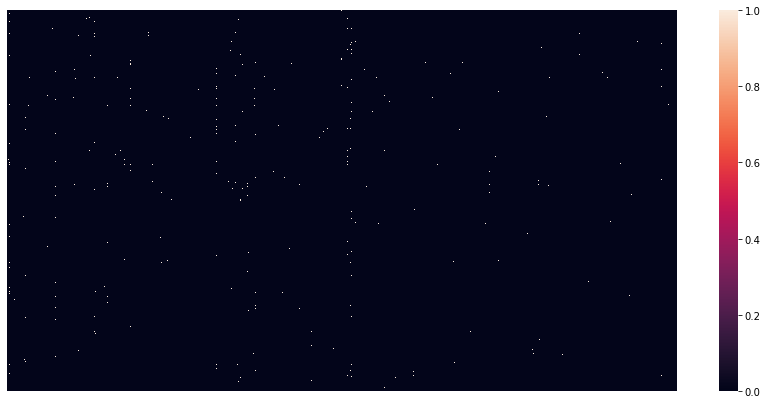

In [51]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Brain"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [371]:
list_counts_gen_Brain = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Brain"]==1,GO].sum()
    list_counts_gen_Brain.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Brain"]==1,GO].sum()
    list_counts_gen_Brain.append(count)
counts_gen["count_Brain"] = list_counts_gen_Brain
counts_gen["percentage a/w_Brain_pervasivelyP"] = counts_gen["count_Brain"]*100/proteins_genP_sites[proteins_genP_sites["Brain"]==1].shape[0]
counts_gen.sort_values("count_Brain", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005524                   188.0                    13.925926        124.0   
GO:0003723                   271.0                    20.074074        240.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005886                          25.177305                  70.0   
GO:0005634                          44.917258                 102.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0005654                          38.416076                  58.0   
GO:0042802                          15.957447                  38.0   
GO:0005524                          14.657210                  36.0   
GO:0003723                          28.368794                  68.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005886                                   30.567686           42.0   
GO:0005634                                   44.541485           95.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0005654                                   25.327511           82.0   
GO:0042802                                   16.593886           20.0   
GO:0005524                                   15.720524           31.0   
GO:0003723                                   29.694323           75.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005886                            25.149701        370.0   
GO:0005634                            56.886228        452.0   
GO:0070062                            23.353293        279.0   
GO:0016020                            22.754491        266.0   
GO:0005654                            49.101796        351.0   
GO:0042802                            11.976048        180.0   
GO:0005524                            18.562874        175.0   
GO:0003723                            44.910180        235.0   

            percentage a/w_Blood_pervasivelyP  count_Brain  \
GO_term                                                      
GO:0005829                          47.463175        440.0   
GO:0005737                          39.525368        360.0   
GO:0005886                          30.278232        319.0   
GO:0005634                          36.988543        277.0   
GO:0070062                          22.831424        227.0   
GO:0016020                          21.767594        193.0   
GO:0005654                          28.723404        174

## Breast

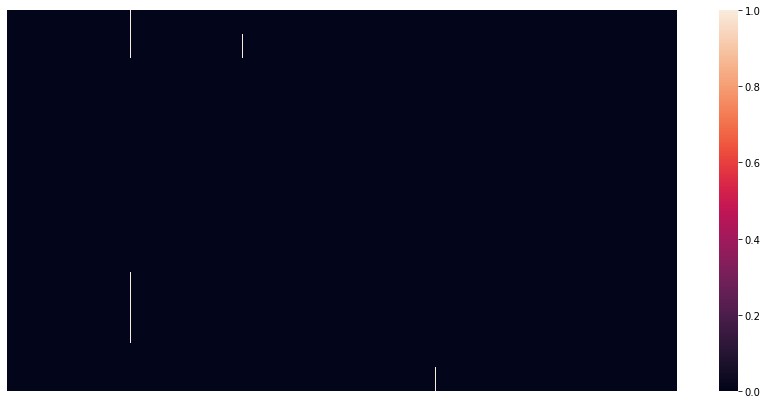

In [52]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Breast"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

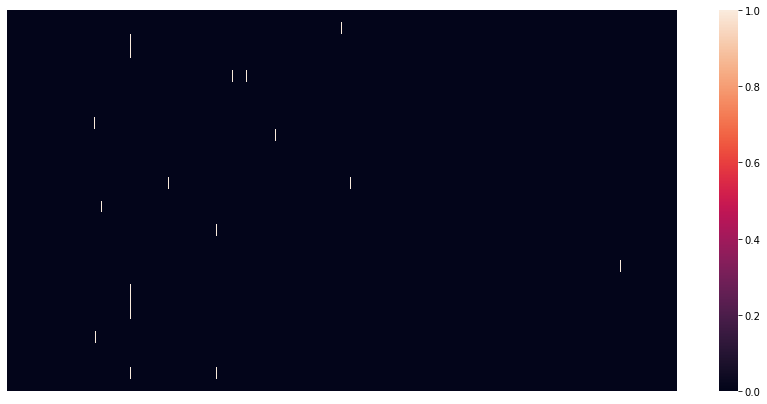

In [53]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Breast"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

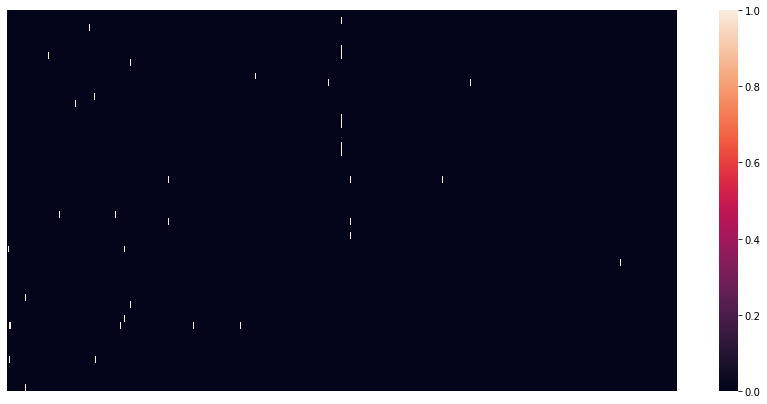

In [54]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Breast"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Cerebrospinal fluid

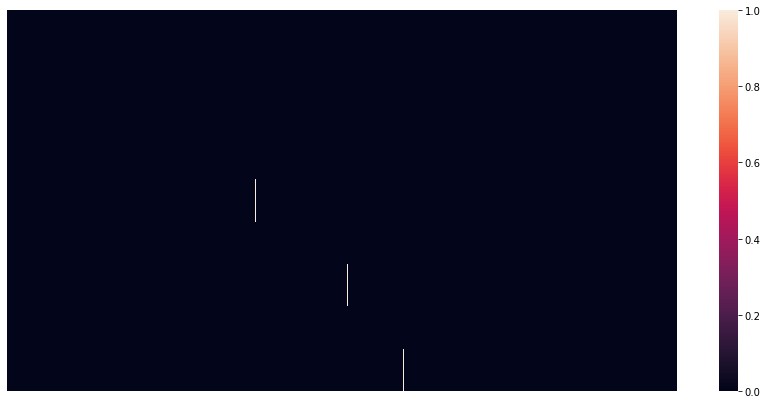

In [55]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Cerebrospinal fluid"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

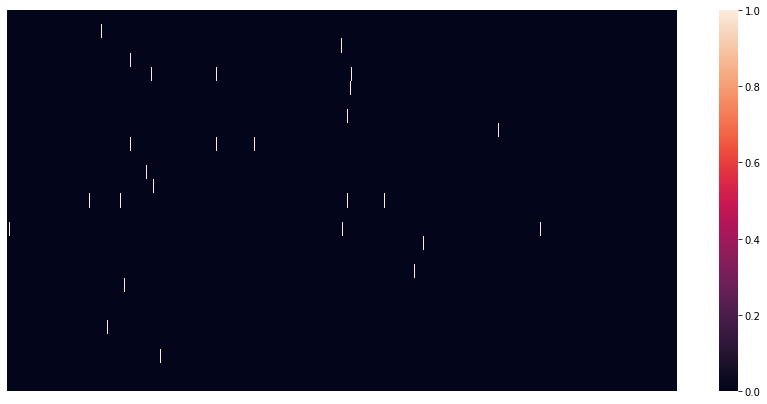

In [56]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Cerebrospinal fluid"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

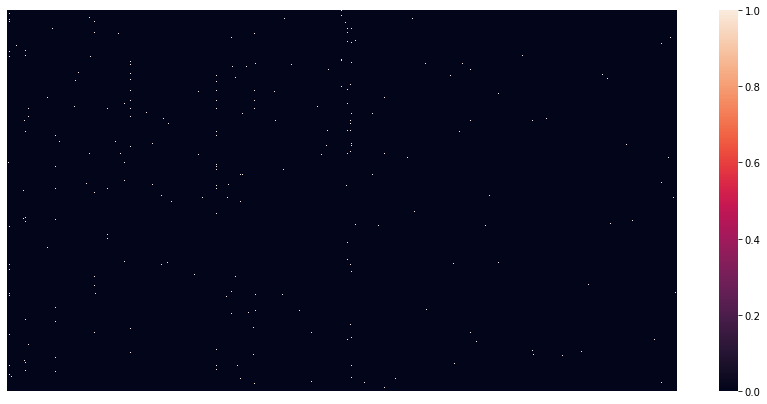

In [57]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Cerebrospinal fluid"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [372]:
list_counts_gen_Cerebrospinal_fluid = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Cerebrospinal fluid"]==1,GO].sum()
    list_counts_gen_Cerebrospinal_fluid.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Cerebrospinal fluid"]==1,GO].sum()
    list_counts_gen_Cerebrospinal_fluid.append(count)
counts_gen["count_Cerebrospinal_fluid"] = list_counts_gen_Cerebrospinal_fluid
counts_gen["percentage a/w_Cerebrospinal_fluid_pervasivelyP"] = counts_gen["count_Cerebrospinal_fluid"]*100/proteins_genP_sites[proteins_genP_sites["Cerebrospinal fluid"]==1].shape[0]
counts_gen.sort_values("count_Cerebrospinal_fluid", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0005524                   188.0                    13.925926        124.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0003723                   271.0                    20.074074        240.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005886                          25.177305                  70.0   
GO:0005634                          44.917258                 102.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0005654                          38.416076                  58.0   
GO:0005524                          14.657210                  36.0   
GO:0042802                          15.957447                  38.0   
GO:0003723                          28.368794                  68.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005886                                   30.567686           42.0   
GO:0005634                                   44.541485           95.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0005654                                   25.327511           82.0   
GO:0005524                                   15.720524           31.0   
GO:0042802                                   16.593886           20.0   
GO:0003723                                   29.694323           75.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005886                            25.149701        370.0   
GO:0005634                            56.886228        452.0   
GO:0070062                            23.353293        279.0   
GO:0016020                            22.754491        266.0   
GO:0005654                            49.101796        351.0   
GO:0005524                            18.562874        175.0   
GO:0042802                            11.976048        180.0   
GO:0003723                            44.910180        235.0   

            percentage a/w_Blood_pervasivelyP  count_Brain  \
GO_term                                                      
GO:0005829                          47.463175        440.0   
GO:0005737                          39.525368        360.0   
GO:0005886                          30.278232        319.0   
GO:0005634                          36.988543        277.0   
GO:0070062                          22.831424        227.0   
GO:0016020                          21.767594        193.0   
GO:0005654                          28.723404        174

## Cervix

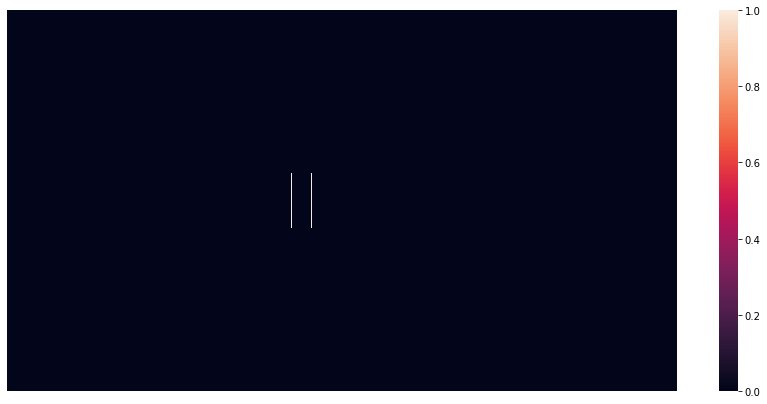

In [58]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Cervix"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

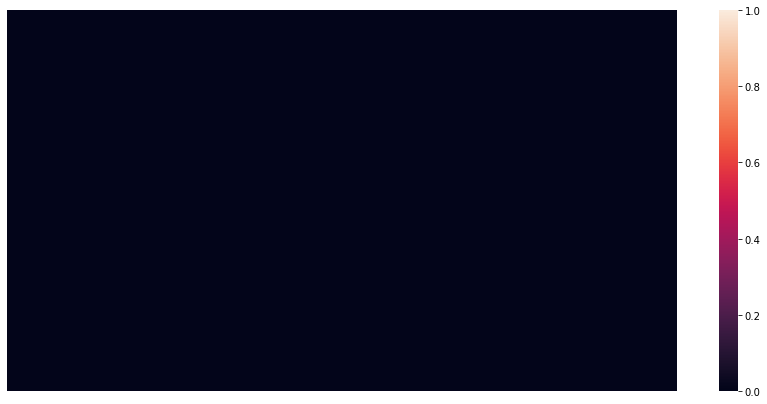

In [59]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Cervix"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

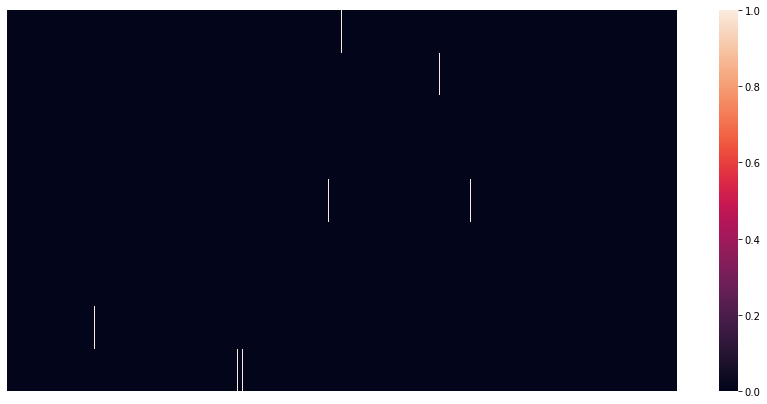

In [60]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Cervix"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Dental plaque

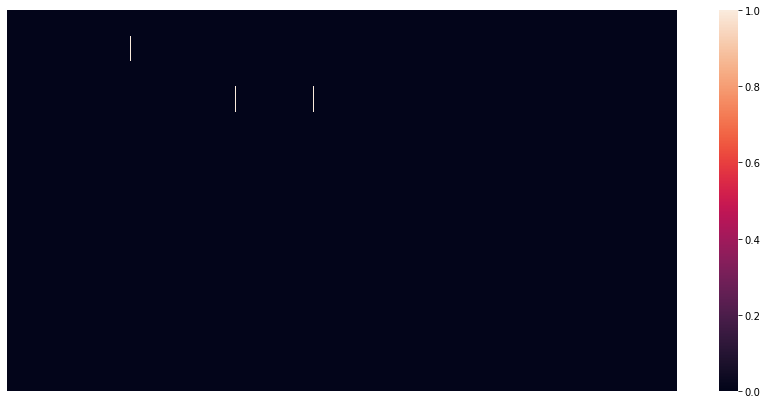

In [61]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Dental plaque"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

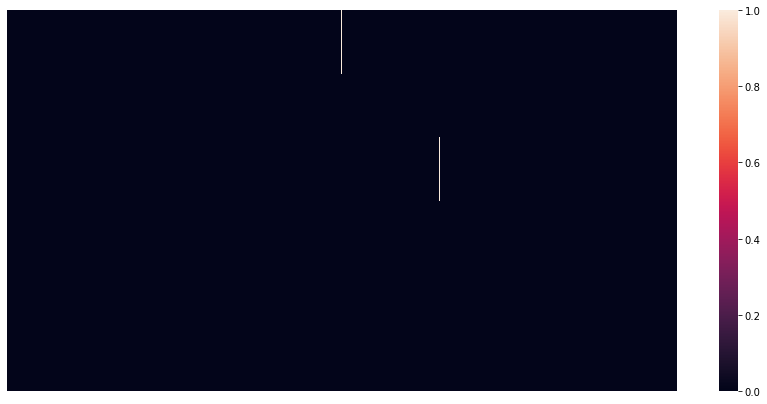

In [62]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Dental plaque"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

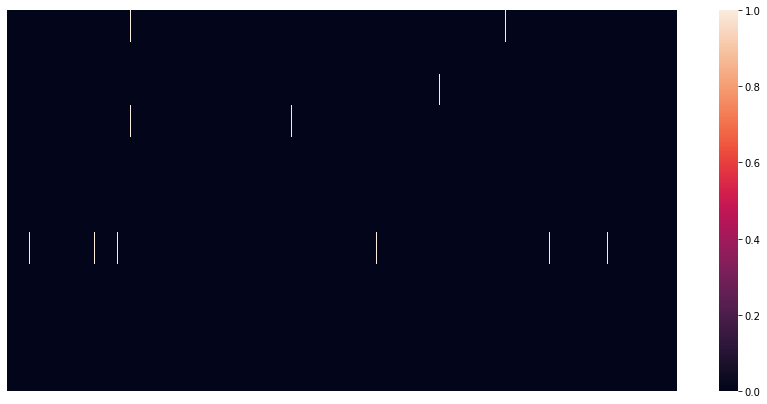

In [63]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Dental plaque"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Esophagus

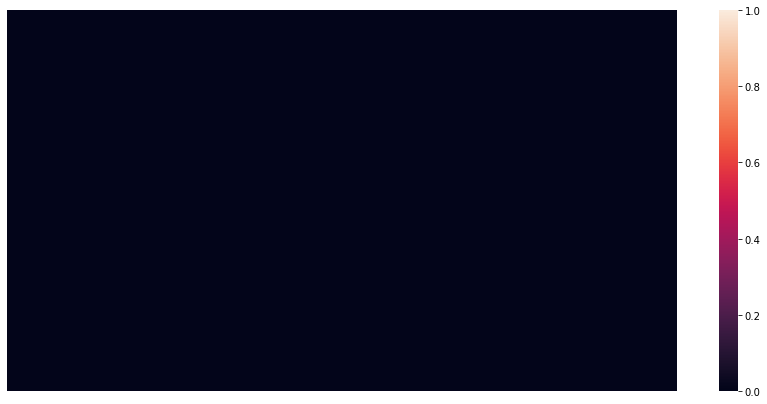

In [64]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Esophagus"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

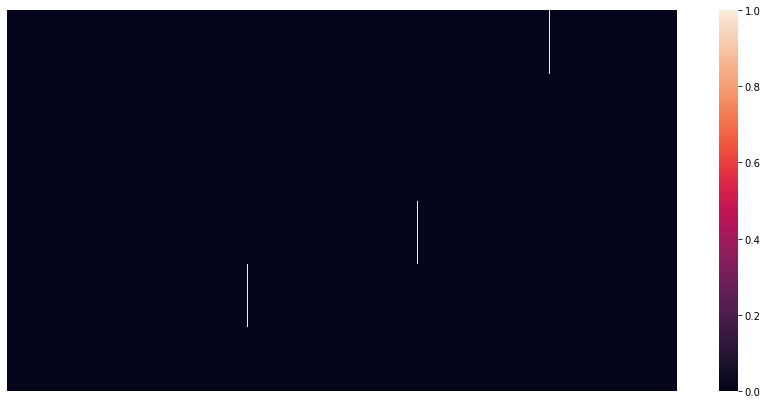

In [65]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Esophagus"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

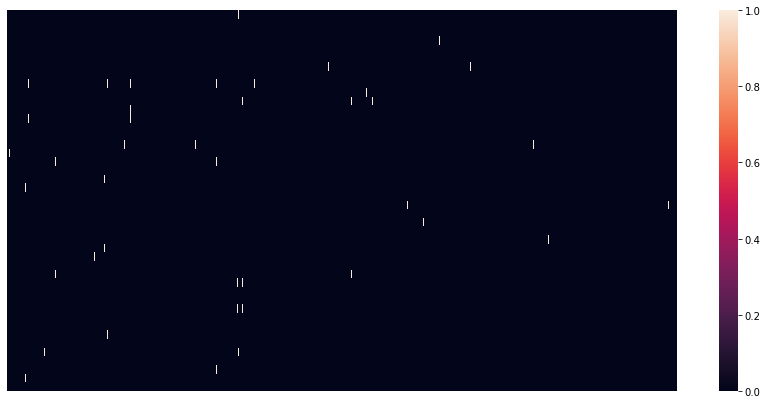

In [66]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Esophagus"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Eye

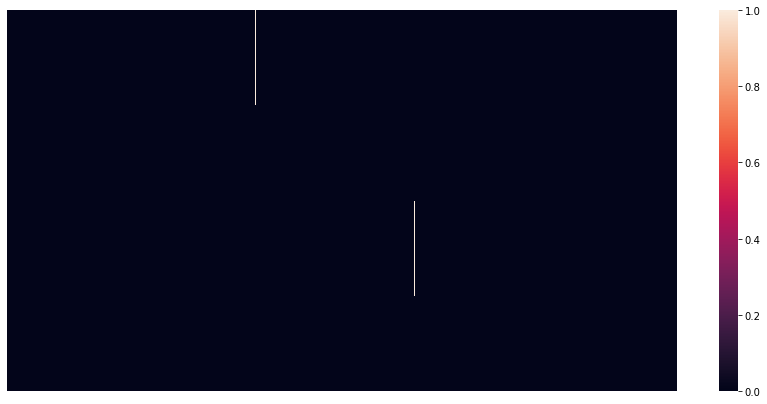

In [67]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Eye"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

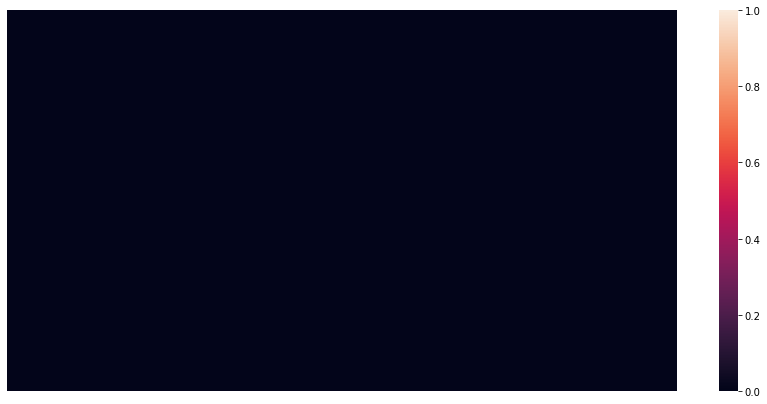

In [68]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Eye"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

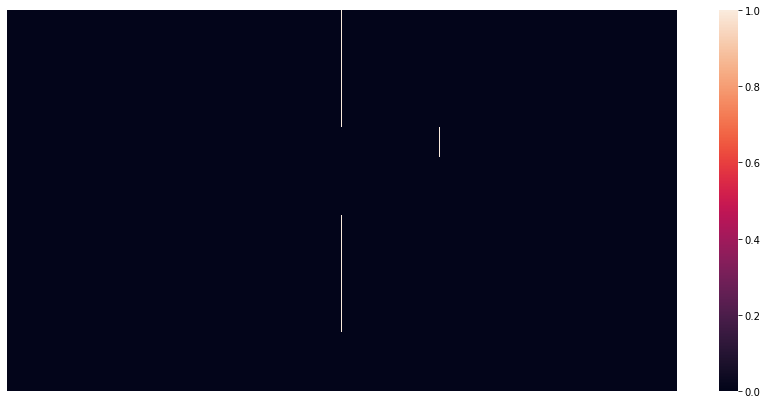

In [69]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Eye"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Heart

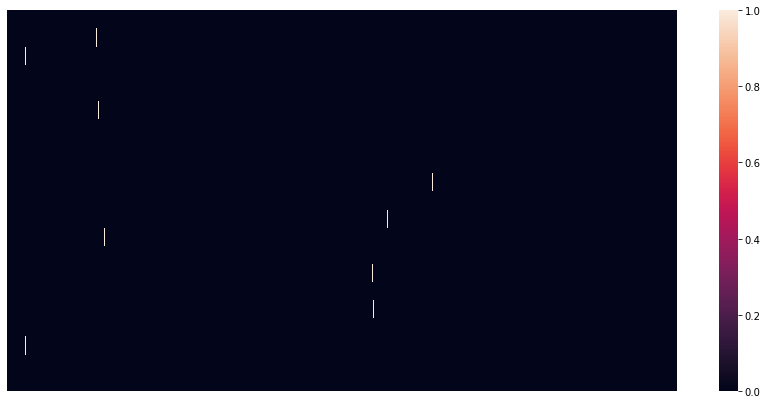

In [70]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Heart"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

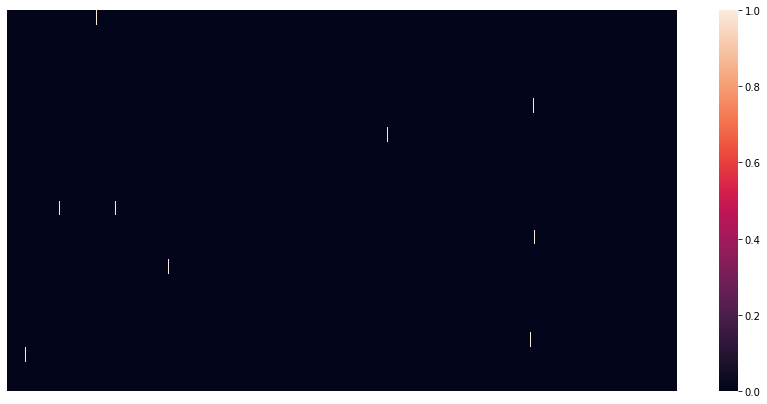

In [71]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Heart"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

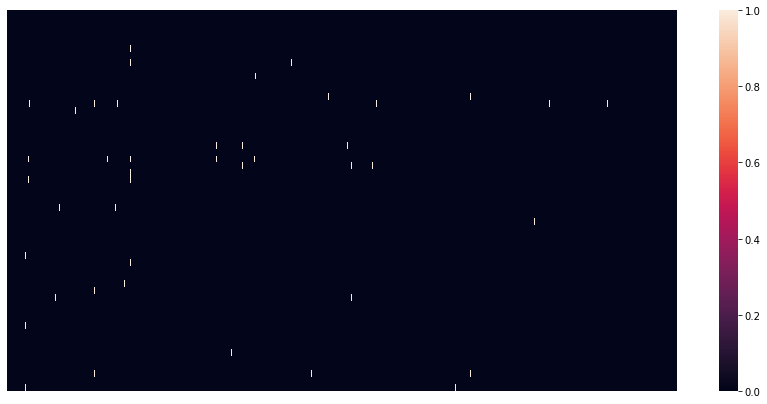

In [72]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Heart"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## HeLa cells

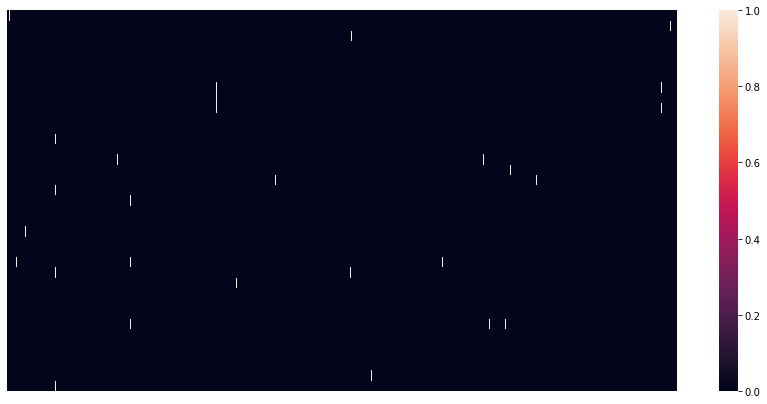

In [73]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Hela"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

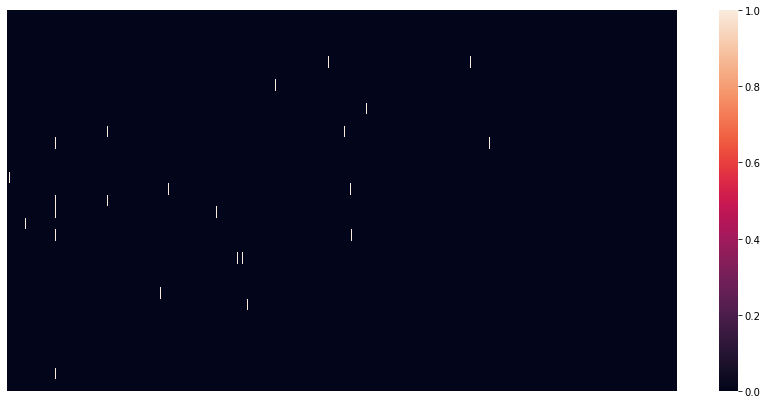

In [74]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Hela"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Kidney

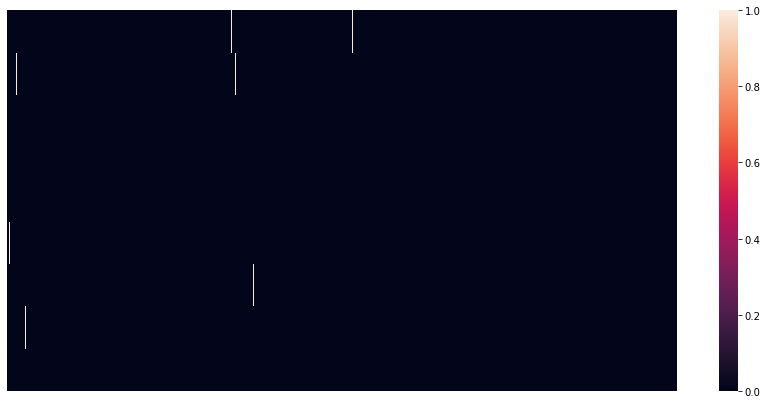

In [75]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Kidney"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

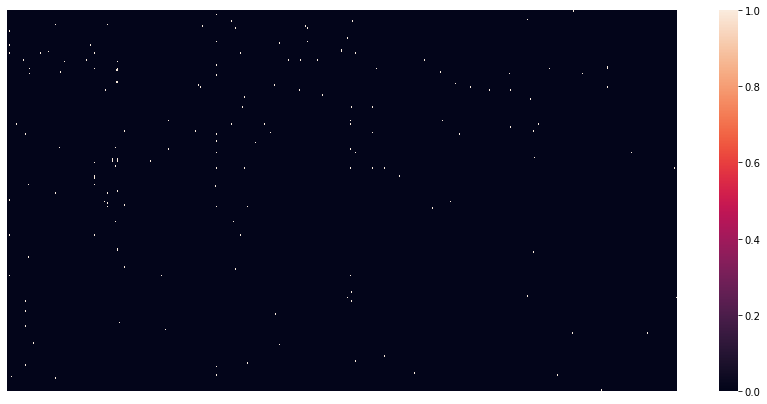

In [76]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Kidney"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [240]:
list_counts_nontspec_Kidney = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Kidney"]==1,GO].sum()
    list_counts_nontspec_Kidney.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Kidney"]==1,GO].sum()
    list_counts_nontspec_Kidney.append(count)
counts_taspec["count_Kidney"] = list_counts_nontspec_Kidney
counts_taspec["percentage a/w_Kidney_taspec"] = counts_taspec["count_Kidney"]*100/proteins_taspec_sites[proteins_taspec_sites["Kidney"]==1].shape[0]
counts_taspec.sort_values("count_Kidney", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005886             610.0              22.752704        413.0   
GO:0005654             964.0              35.956733        782.0   
GO:0016020             582.0              21.708318        405.0   
GO:0003723             538.0              20.067139        405.0   
GO:0005739             207.0               7.721000        142.0   
GO:0005524             381.0              14.211115        280.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0070062                    17.071882                  89.0   
GO:0005737                    38.900634                  91.0   
GO:0005634                    44.133192                  73.0   
GO:0005886                    21.828753                  42.0   
GO:0005654                    41.331924                  26.0   
GO:0016020                    21.405920                  52.0   
GO:0003723                    21.405920                  43.0   
GO:0005739                     7.505285                  14.0   
GO:0005524                    14.799154                  26.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0070062                             54.268293           12.0   
GO:0005737                             55.487805           33.0   
GO:0005634                             44.512195           33.0   
GO:0005886                             25.609756           27.0   
GO:0005654                             15.853659           34.0   
GO:0016020                             31.707317           17.0   
GO:0003723                             26.219512           14.0   
GO:0005739                              8.536585            4.0   
GO:0005524                             15.853659           11.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0070062               15.384615        218.0                    15.660920   
GO:0005737               42.307692        496.0                    35.632184   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005886               34.615385        268.0                    19.252874   
GO:0005654               43.589744        626.0                    44.971264   
GO:0016020               21.794872        307.0                    22.054598   
GO:0003723               17.948718        318.0                    22.844828   
GO:0005739                5.128205         83.0                     5.962644   
GO:0005524               14.102564        189.0                    13.577586   

            count_Brain  percentage a/w_Brain_taspec  count_Kidney  \
GO_term                                                              
GO:0005829         65.0                    44.827586         106.0   
GO:0070062         56.0                    38.620690          85.0   
GO:0005737         65.0                    44.827586          81.0   
GO:0005634         46.0                    31.724138          74.0   
GO:0005886         54.0                    37.241379          63.0   
GO:0005654         29.0                    20.000000          55.0   
GO:0016020         28.0                    19.310345          53.0   
GO:0003723        

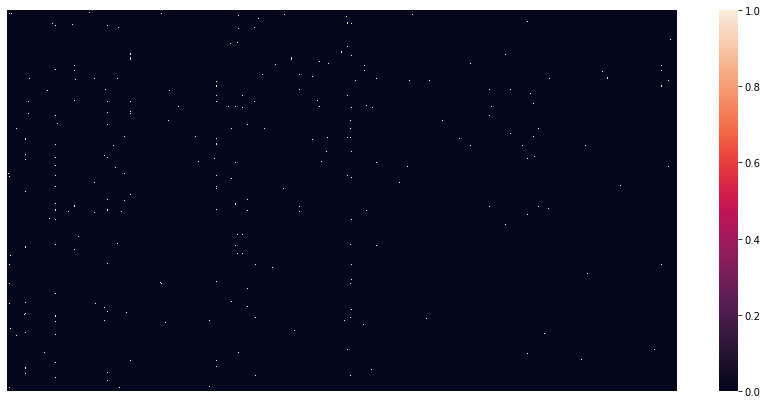

In [77]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Kidney"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [373]:
list_counts_gen_Kidney = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Kidney"]==1,GO].sum()
    list_counts_gen_Kidney.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Kidney"]==1,GO].sum()
    list_counts_gen_Kidney.append(count)
counts_gen["count_Kidney"] = list_counts_gen_Kidney
counts_gen["percentage a/w_Kidney_pervasivelyP"] = counts_gen["count_Kidney"]*100/proteins_genP_sites[proteins_genP_sites["Kidney"]==1].shape[0]
counts_gen.sort_values("count_Kidney", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005524                   188.0                    13.925926        124.0   
GO:0042802                   203.0                    15.037037        135.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005634                          44.917258                 102.0   
GO:0005737                          44.326241                 136.0   
GO:0005654                          38.416076                  58.0   
GO:0070062                          25.413712                 100.0   
GO:0003723                          28.368794                  68.0   
GO:0005886                          25.177305                  70.0   
GO:0016020                          25.650118                  68.0   
GO:0005524                          14.657210                  36.0   
GO:0042802                          15.957447                  38.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005634                                   44.541485           95.0   
GO:0005737                                   59.388646           62.0   
GO:0005654                                   25.327511           82.0   
GO:0070062                                   43.668122           39.0   
GO:0003723                                   29.694323           75.0   
GO:0005886                                   30.567686           42.0   
GO:0016020                                   29.694323           38.0   
GO:0005524                                   15.720524           31.0   
GO:0042802                                   16.593886           20.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005634                            56.886228        452.0   
GO:0005737                            37.125749        483.0   
GO:0005654                            49.101796        351.0   
GO:0070062                            23.353293        279.0   
GO:0003723                            44.910180        235.0   
GO:0005886                            25.149701        370.0   
GO:0016020                            22.754491        266.0   
GO:0005524                            18.562874        175.0   
GO:0042802                            11.976048        180.0   

            percentage a/w_Blood_pervasivelyP  count_Brain  \
GO_term                                                      
GO:0005829                          47.463175        440.0   
GO:0005634                          36.988543        277.0   
GO:0005737                          39.525368        360.0   
GO:0005654                          28.723404        174.0   
GO:0070062                          22.831424        227.0   
GO:0003723                          19.230769        125.0   
GO:0005886                          30.278232        319

## Liver

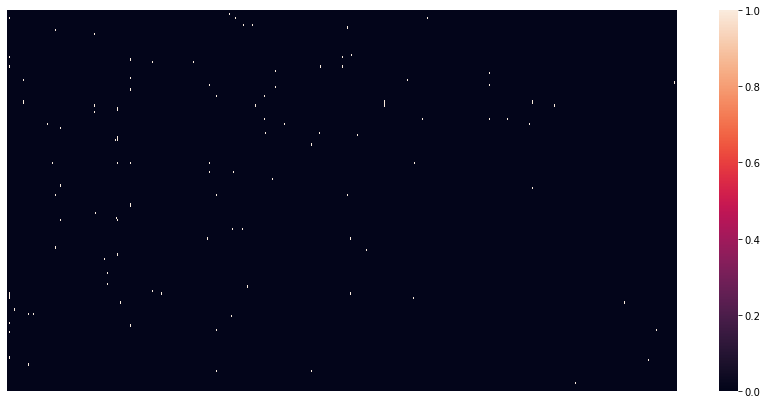

In [78]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Liver"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [305]:
list_counts_tspec_Liver = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Liver"]==1,GO].sum()
    list_counts_tspec_Liver.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Liver"]==1,GO].sum()
    list_counts_tspec_Liver.append(count)
counts_tspec["count_Liver"] = list_counts_tspec_Liver
counts_tspec["percentage a/w_Liver_tspec"] = counts_tspec["count_Liver"]*100/(proteins_tspec_sites[proteins_tspec_sites["Liver"]==1].shape[0])
counts_tspec.sort_values("count_Liver", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005829           2138.0             43.865408       1029.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0005634           1884.0             38.654083        912.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0016020            907.0             18.608945        376.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0003723            731.0             14.997948        365.0   
GO:0042802            580.0             11.899877        256.0   
GO:0005615            399.0              8.186295         76.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005829                   47.029250            6.0   
GO:0070062                   14.488117            3.0   
GO:0005737                   36.928702            4.0   
GO:0005634                   41.681901            7.0   
GO:0005886                   21.160878            5.0   
GO:0016020                   17.184644            2.0   
GO:0005654                   38.574040            6.0   
GO:0003723                   16.681901            2.0   
GO:0042802                   11.700183            3.0   
GO:0005615                    3.473492            1.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005829                         37.50        435.0   
GO:0070062                         18.75        167.0   
GO:0005737                         25.00        329.0   
GO:0005634                         43.75        459.0   
GO:0005886                         31.25        194.0   
GO:0016020                         12.50        187.0   
GO:0005654                         37.50        456.0   
GO:0003723                         12.50        167.0   
GO:0042802                         18.75        103.0   
GO:0005615                          6.25        102.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005829                   42.397661         50.0   
GO:0070062                   16.276803         34.0   
GO:0005737                   32.066277         52.0   
GO:0005634                   44.736842         40.0   
GO:0005886                   18.908382         33.0   
GO:0016020                   18.226121         16.0   
GO:0005654                   44.444444         18.0   
GO:0003723                   16.276803         15.0   
GO:0042802                   10.038986         15.0   
GO:0005615                    9.941520         12.0   

            percentage a/w_Brain_tspec  count_Liver  \
GO_term                                               
GO:0005829                        50.0         86.0   
GO:0070062                        34.0         67.0   
GO:0005737                        52.0         63.0   
GO:0005634                        40.0         55.0   
GO:0005886                        33.0         48.0   
GO:0016020                        16.0         44.0   
GO:0005654                        18.0         41.0   
GO:0003723                        15.0         29.0   
GO:0042802                        15.0         24.0   
GO:0005615                        12.0         23.0   

            percentage a/w_Liver_tspec  
GO_term                                 
GO:0005829                   51.807229  
GO:0070062                   40.361446  
GO:0005737                   37.951807  
GO:0005634                   33.132530  
GO:0005886                   28.915663  
GO:0016020                   26.506024  
GO:0005654                   24.698795  
GO:0003723                   17.469880  
GO:0042802                   14.457831  
GO:0005615                   13.855422

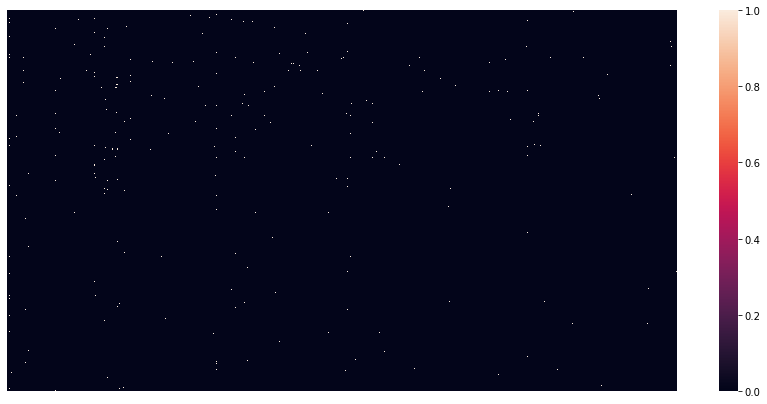

In [79]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Liver"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [284]:
list_counts_nontspec_Liver = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Liver"]==1,GO].sum()
    list_counts_nontspec_Liver.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Liver"]==1,GO].sum()
    list_counts_nontspec_Liver.append(count)
counts_taspec["count_Liver"] = list_counts_nontspec_Liver
counts_taspec["percentage a/w_Liver_taspec"] = counts_taspec["count_Liver"]*100/proteins_taspec_sites[proteins_taspec_sites["Liver"]==1].shape[0]
counts_taspec.sort_values("count_Liver", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005654             964.0              35.956733        782.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005886             610.0              22.752704        413.0   
GO:0016020             582.0              21.708318        405.0   
GO:0003723             538.0              20.067139        405.0   
GO:0005524             381.0              14.211115        280.0   
GO:0042802             350.0              13.054830        238.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0005634                    44.133192                  73.0   
GO:0005737                    38.900634                  91.0   
GO:0005654                    41.331924                  26.0   
GO:0070062                    17.071882                  89.0   
GO:0005886                    21.828753                  42.0   
GO:0016020                    21.405920                  52.0   
GO:0003723                    21.405920                  43.0   
GO:0005524                    14.799154                  26.0   
GO:0042802                    12.579281                  34.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0005634                             44.512195           33.0   
GO:0005737                             55.487805           33.0   
GO:0005654                             15.853659           34.0   
GO:0070062                             54.268293           12.0   
GO:0005886                             25.609756           27.0   
GO:0016020                             31.707317           17.0   
GO:0003723                             26.219512           14.0   
GO:0005524                             15.853659           11.0   
GO:0042802                             20.731707           11.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005737               42.307692        496.0                    35.632184   
GO:0005654               43.589744        626.0                    44.971264   
GO:0070062               15.384615        218.0                    15.660920   
GO:0005886               34.615385        268.0                    19.252874   
GO:0016020               21.794872        307.0                    22.054598   
GO:0003723               17.948718        318.0                    22.844828   
GO:0005524               14.102564        189.0                    13.577586   
GO:0042802               14.102564        161.0                    11.566092   

            count_Brain  percentage a/w_Brain_taspec  count_Kidney  \
GO_term                                                              
GO:0005829         65.0                    44.827586         106.0   
GO:0005634         46.0                    31.724138          74.0   
GO:0005737         65.0                    44.827586          81.0   
GO:0005654         29.0                    20.000000          55.0   
GO:0070062         56.0                    38.620690          85.0   
GO:0005886         54.0                    37.241379          63.0   
GO:0016020         28.0                    19.310345          53.0   
GO:0003723        

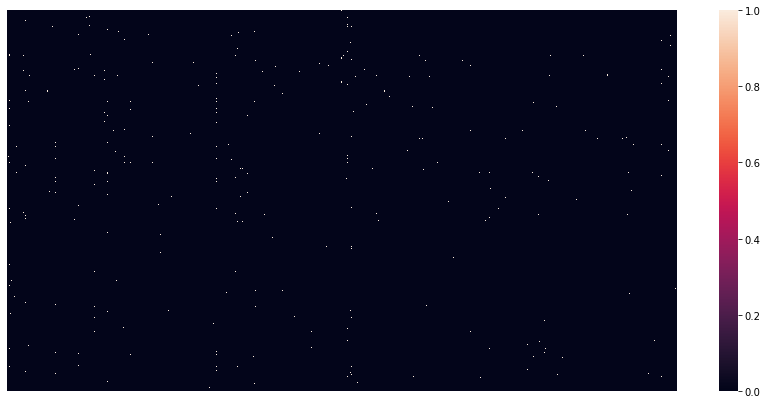

In [80]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Liver"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [374]:
list_counts_gen_Liver = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Liver"]==1,GO].sum()
    list_counts_gen_Liver.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Liver"]==1,GO].sum()
    list_counts_gen_Liver.append(count)
counts_gen["count_Liver"] = list_counts_gen_Liver
counts_gen["percentage a/w_Liver_pervasivelyP"] = counts_gen["count_Liver"]*100/proteins_genP_sites[proteins_genP_sites["Liver"]==1].shape[0]
counts_gen.sort_values("count_Liver", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005524                   188.0                    13.925926        124.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005634                          44.917258                 102.0   
GO:0005886                          25.177305                  70.0   
GO:0005654                          38.416076                  58.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0003723                          28.368794                  68.0   
GO:0042802                          15.957447                  38.0   
GO:0005524                          14.657210                  36.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005634                                   44.541485           95.0   
GO:0005886                                   30.567686           42.0   
GO:0005654                                   25.327511           82.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0003723                                   29.694323           75.0   
GO:0042802                                   16.593886           20.0   
GO:0005524                                   15.720524           31.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005634                            56.886228        452.0   
GO:0005886                            25.149701        370.0   
GO:0005654                            49.101796        351.0   
GO:0070062                            23.353293        279.0   
GO:0016020                            22.754491        266.0   
GO:0003723                            44.910180        235.0   
GO:0042802                            11.976048        180.0   
GO:0005524                            18.562874        175.0   

            percentage a/w_Blood_pervasivelyP  count_Brain  \
GO_term                                                      
GO:0005829                          47.463175        440.0   
GO:0005737                          39.525368        360.0   
GO:0005634                          36.988543        277.0   
GO:0005886                          30.278232        319.0   
GO:0005654                          28.723404        174.0   
GO:0070062                          22.831424        227.0   
GO:0016020                          21.767594        193

In [287]:
list_all_Liver = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_Liver = pd.concat(list_all_Liver, axis=1)
all_Liver[(((all_Liver["percentage a/w_Liver_tspec"]>=7)&(all_Liver["percentage a/w tspec"]<=7))|
           ((all_Liver["percentage a/w_Liver_taspec"]>=7)&(all_Liver["percentage a/w taspec"]<=7))|
         ((all_Liver["percentage a/w_Liver_pervasivelyP"]>=7)&((all_Liver["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005102             81.0              1.661879         21.0   
GO:0005739            319.0              6.544932        117.0   
GO:0005783            266.0              5.457530         87.0   
GO:0005789            232.0              4.759951         82.0   
GO:0005794            327.0              6.709069        143.0   
GO:0005925            261.0              5.354945         98.0   
GO:0009986            173.0              3.549446         53.0   
GO:0019899            154.0              3.159622         69.0   
GO:0043066            188.0              3.857201         78.0   
GO:0043231            313.0              6.421830        151.0   
GO:0043312            224.0              4.595815         49.0   
GO:0045296            217.0              4.452195        122.0   
GO:0046982            132.0              2.708248         41.0   
GO:0048471            310.0              6.360279        162.0   
GO:0072562             96.0              1.969635         14.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005102                    0.959781            0.0   
GO:0005739                    5.347349            1.0   
GO:0005783                    3.976234            0.0   
GO:0005789                    3.747715            2.0   
GO:0005794                    6.535649            2.0   
GO:0005925                    4.478976            1.0   
GO:0009986                    2.422303            1.0   
GO:0019899                    3.153565            0.0   
GO:0043066                    3.564899            1.0   
GO:0043231                    6.901280            1.0   
GO:0043312                    2.239488            0.0   
GO:0045296                    5.575868            1.0   
GO:0046982                    1.873857            1.0   
GO:0048471                    7.404022            1.0   
GO:0072562                    0.639854            0.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005102                          0.00         20.0   
GO:0005739                          6.25         44.0   
GO:0005783                          0.00         43.0   
GO:0005789                         12.50         35.0   
GO:0005794                         12.50         70.0   
GO:0005925                          6.25         34.0   
GO:0009986                          6.25         23.0   
GO:0019899                          0.00         31.0   
GO:0043066                          6.25         30.0   
GO:0043231                          6.25         67.0   
GO:0043312                          0.00         36.0   
GO:0045296                          6.25         41.0   
GO:0046982                          6.25         26.0   
GO:0048471                          6.25         46.0   
GO:0072562                          0.00         55.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005102                    1.949318          1.0   
GO:0005739                    4.288499          7.0   
GO:0005783                    4.191033          1.0   
GO:0005789                    3.411306          2.0   
GO:0005794                    6.822612          6.0   
GO:0005925                    3.313840         11.0   
GO:0009986                    2.241715          8.0   
GO:0019899                    3.021442          3.0   
GO:0043066                    2.923977          4.0   
GO:0043231                    6.530214          5.0   
GO:0043312                    3.508772          6.0   
GO:0045296                    3.996101          7.0   
GO:0046982                    2.534113          4.0   
GO:0048471                    4.483431         10.0   
GO:0072562                    5.360624          6.0   

            p

## Lung

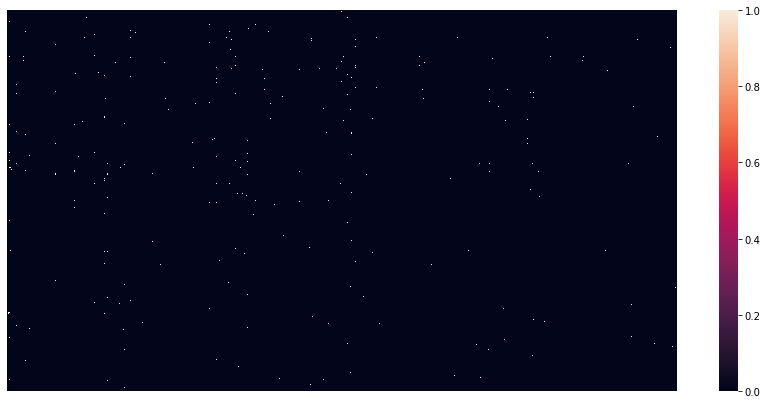

In [81]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Lung"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [311]:
list_counts_tspec_Lung = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Lung"]==1,GO].sum()
    list_counts_tspec_Lung.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Lung"]==1,GO].sum()
    list_counts_tspec_Lung.append(count)
counts_tspec["count_Lung"] = list_counts_tspec_Lung
counts_tspec["percentage a/w_Lung_tspec"] = counts_tspec["count_Lung"]*100/(proteins_tspec_sites[proteins_tspec_sites["Lung"]==1].shape[0])
counts_tspec.sort_values("count_Lung", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005829           2138.0             43.865408       1029.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0005634           1884.0             38.654083        912.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0005524            607.0             12.453837        272.0   
GO:0046872            599.0             12.289700        294.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005829                   47.029250            6.0   
GO:0005737                   36.928702            4.0   
GO:0005634                   41.681901            7.0   
GO:0005886                   21.160878            5.0   
GO:0005654                   38.574040            6.0   
GO:0070062                   14.488117            3.0   
GO:0016020                   17.184644            2.0   
GO:0003723                   16.681901            2.0   
GO:0005524                   12.431444            1.0   
GO:0046872                   13.436929            2.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005829                         37.50        435.0   
GO:0005737                         25.00        329.0   
GO:0005634                         43.75        459.0   
GO:0005886                         31.25        194.0   
GO:0005654                         37.50        456.0   
GO:0070062                         18.75        167.0   
GO:0016020                         12.50        187.0   
GO:0003723                         12.50        167.0   
GO:0005524                          6.25        122.0   
GO:0046872                         12.50        142.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005829                   42.397661         50.0   
GO:0005737                   32.066277         52.0   
GO:0005634                   44.736842         40.0   
GO:0005886                   18.908382         33.0   
GO:0005654                   44.444444         18.0   
GO:0070062                   16.276803         34.0   
GO:0016020                   18.226121         16.0   
GO:0003723                   16.276803         15.0   
GO:0005524                   11.890838         11.0   
GO:0046872                   13.840156         11.0   

            percentage a/w_Brain_tspec  count_Liver  \
GO_term                                               
GO:0005829                        50.0         86.0   
GO:0005737                        52.0         63.0   
GO:0005634                        40.0         55.0   
GO:0005886                        33.0         48.0   
GO:0005654                        18.0         41.0   
GO:0070062                        34.0         67.0   
GO:0016020                        16.0         44.0   
GO:0003723                        15.0         29.0   
GO:0005524                        11.0         19.0   
GO:0046872                        11.0         14.0   

            percentage a/w_Liver_tspec  count_Lung  percentage a/w_Lung_tspec  
GO_term                                                                        
GO:0005829                   51.807229       445.0                  48.740416  
GO:0005737                   37.951807       379.0                  41.511501  
GO:0005634                   33.132530       374.0                  40.963855  
GO:0005886                   28.915663       305.0                  33.406353  
GO:0005654                   24.698795       28

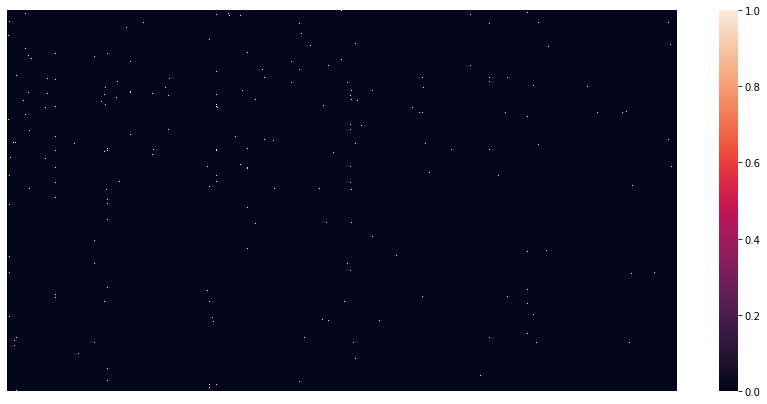

In [82]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Lung"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [291]:
list_counts_nontspec_Lung = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Lung"]==1,GO].sum()
    list_counts_nontspec_Lung.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Lung"]==1,GO].sum()
    list_counts_nontspec_Lung.append(count)
counts_taspec["count_Lung"] = list_counts_nontspec_Lung
counts_taspec["percentage a/w_Lung_taspec"] = counts_taspec["count_Lung"]*100/proteins_taspec_sites[proteins_taspec_sites["Lung"]==1].shape[0]
counts_taspec.sort_values("count_Lung", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005886             610.0              22.752704        413.0   
GO:0003723             538.0              20.067139        405.0   
GO:0016020             582.0              21.708318        405.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005524             381.0              14.211115        280.0   
GO:0046872             317.0              11.823946        238.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0005634                    44.133192                  73.0   
GO:0005654                    41.331924                  26.0   
GO:0005737                    38.900634                  91.0   
GO:0005886                    21.828753                  42.0   
GO:0003723                    21.405920                  43.0   
GO:0016020                    21.405920                  52.0   
GO:0070062                    17.071882                  89.0   
GO:0005524                    14.799154                  26.0   
GO:0046872                    12.579281                  18.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0005634                             44.512195           33.0   
GO:0005654                             15.853659           34.0   
GO:0005737                             55.487805           33.0   
GO:0005886                             25.609756           27.0   
GO:0003723                             26.219512           14.0   
GO:0016020                             31.707317           17.0   
GO:0070062                             54.268293           12.0   
GO:0005524                             15.853659           11.0   
GO:0046872                             10.975610           10.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005654               43.589744        626.0                    44.971264   
GO:0005737               42.307692        496.0                    35.632184   
GO:0005886               34.615385        268.0                    19.252874   
GO:0003723               17.948718        318.0                    22.844828   
GO:0016020               21.794872        307.0                    22.054598   
GO:0070062               15.384615        218.0                    15.660920   
GO:0005524               14.102564        189.0                    13.577586   
GO:0046872               12.820513        183.0                    13.146552   

            count_Brain  percentage a/w_Brain_taspec  count_Kidney  \
GO_term                                                              
GO:0005829         65.0                    44.827586         106.0   
GO:0005634         46.0                    31.724138          74.0   
GO:0005654         29.0                    20.000000          55.0   
GO:0005737         65.0                    44.827586          81.0   
GO:0005886         54.0                    37.241379          63.0   
GO:0003723         18.0                    12.413793          43.0   
GO:0016020         28.0                    19.310345          53.0   
GO:0070062        

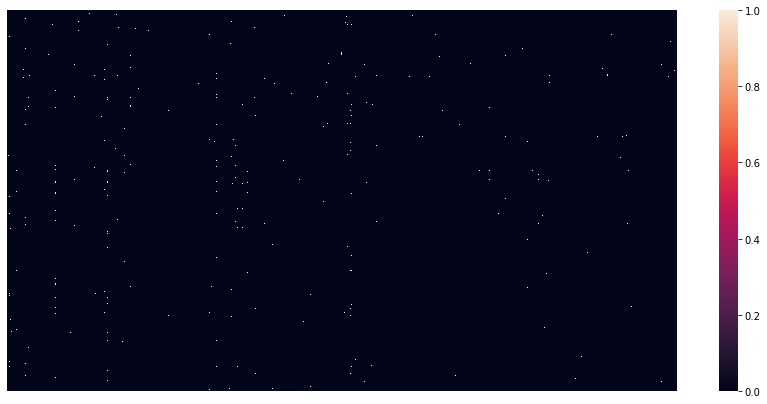

In [83]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Lung"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [375]:
list_counts_gen_Lung = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Lung"]==1,GO].sum()
    list_counts_gen_Lung.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Lung"]==1,GO].sum()
    list_counts_gen_Lung.append(count)
counts_gen["count_Lung"] = list_counts_gen_Lung
counts_gen["percentage a/w_Lung_pervasivelyP"] = counts_gen["count_Lung"]*100/proteins_genP_sites[proteins_genP_sites["Lung"]==1].shape[0]
counts_gen.sort_values("count_Lung", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005524                   188.0                    13.925926        124.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005634                          44.917258                 102.0   
GO:0005737                          44.326241                 136.0   
GO:0005654                          38.416076                  58.0   
GO:0003723                          28.368794                  68.0   
GO:0070062                          25.413712                 100.0   
GO:0005886                          25.177305                  70.0   
GO:0016020                          25.650118                  68.0   
GO:0042802                          15.957447                  38.0   
GO:0005524                          14.657210                  36.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005634                                   44.541485           95.0   
GO:0005737                                   59.388646           62.0   
GO:0005654                                   25.327511           82.0   
GO:0003723                                   29.694323           75.0   
GO:0070062                                   43.668122           39.0   
GO:0005886                                   30.567686           42.0   
GO:0016020                                   29.694323           38.0   
GO:0042802                                   16.593886           20.0   
GO:0005524                                   15.720524           31.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005634                            56.886228        452.0   
GO:0005737                            37.125749        483.0   
GO:0005654                            49.101796        351.0   
GO:0003723                            44.910180        235.0   
GO:0070062                            23.353293        279.0   
GO:0005886                            25.149701        370.0   
GO:0016020                            22.754491        266.0   
GO:0042802                            11.976048        180.0   
GO:0005524                            18.562874        175.0   

            percentage a/w_Blood_pervasivelyP  count_Brain  \
GO_term                                                      
GO:0005829                          47.463175        440.0   
GO:0005634                          36.988543        277.0   
GO:0005737                          39.525368        360.0   
GO:0005654                          28.723404        174.0   
GO:0003723                          19.230769        125.0   
GO:0070062                          22.831424        227.0   
GO:0005886                          30.278232        319

In [295]:
list_all_Lung = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_Lung = pd.concat(list_all_Lung, axis=1)
all_Lung[(((all_Lung["percentage a/w_Lung_tspec"]>=7)&(all_Lung["percentage a/w tspec"]<=7))|
           ((all_Lung["percentage a/w_Lung_taspec"]>=7)&(all_Lung["percentage a/w taspec"]<=7))|
         ((all_Lung["percentage a/w_Lung_pervasivelyP"]>=7)&((all_Lung["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0003677            366.0              7.509233        205.0   
GO:0005794            327.0              6.709069        143.0   
GO:0005856            214.0              4.390644         85.0   
GO:0005925            261.0              5.354945         98.0   
GO:0007165            319.0              6.544932        150.0   
GO:0016032            249.0              5.108740        136.0   
GO:0016607            210.0              4.308576        115.0   
GO:0043231            313.0              6.421830        151.0   
GO:0045296            217.0              4.452195        122.0   
GO:0045944            346.0              7.098892        184.0   
GO:0048471            310.0              6.360279        162.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0003677                    9.369287            1.0   
GO:0005794                    6.535649            2.0   
GO:0005856                    3.884826            1.0   
GO:0005925                    4.478976            1.0   
GO:0007165                    6.855576            1.0   
GO:0016032                    6.215722            0.0   
GO:0016607                    5.255941            2.0   
GO:0043231                    6.901280            1.0   
GO:0045296                    5.575868            1.0   
GO:0045944                    8.409506            3.0   
GO:0048471                    7.404022            1.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0003677                          6.25        112.0   
GO:0005794                         12.50         70.0   
GO:0005856                          6.25         31.0   
GO:0005925                          6.25         34.0   
GO:0007165                          6.25         52.0   
GO:0016032                          0.00         59.0   
GO:0016607                         12.50         69.0   
GO:0043231                          6.25         67.0   
GO:0045296                          6.25         41.0   
GO:0045944                         18.75        102.0   
GO:0048471                          6.25         46.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0003677                   10.916179          7.0   
GO:0005794                    6.822612          6.0   
GO:0005856                    3.021442         10.0   
GO:0005925                    3.313840         11.0   
GO:0007165                    5.068226          4.0   
GO:0016032                    5.750487          4.0   
GO:0016607                    6.725146          4.0   
GO:0043231                    6.530214          5.0   
GO:0045296                    3.996101          7.0   
GO:0045944                    9.941520          4.0   
GO:0048471                    4.483431         10.0   

            percentage a/w_Brain_tspec  ...  count_Cerebrospinal_fluid  \
GO_term                                 ...                              
GO:0003677                         7.0  ...                       31.0   
GO:0005794                         6.0  ...                       65.0   
GO:0005856                        10.0  ...                       59.0   
GO:0005925                        11.0  ...                       61.0   
GO:0007165                         4.0  ...                       73.0   
GO:0016032                         4.0  ...                       43.0   
GO:0016607                         4.0  ...                       21.0   
GO:0043231                         5.0  ...                       50.0   
GO:0045296                         7.0  ...                       56.0   
GO:0045944                         4.0  ...                       30.0   
GO:0048471                        10.0  ...                      

## Lymph node

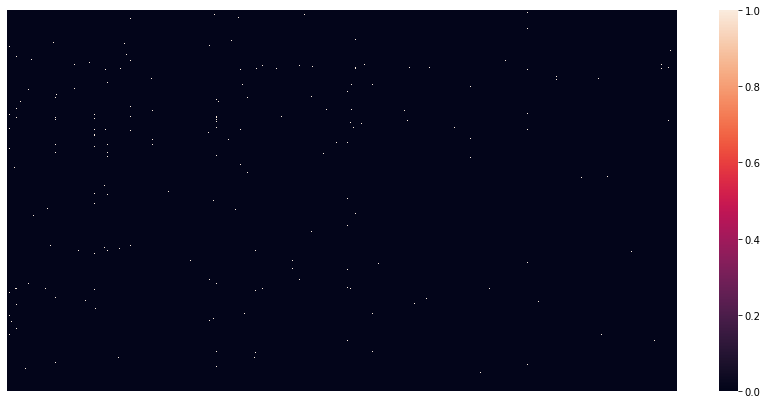

In [84]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Lymph node"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [313]:
list_counts_tspec_Lymph_node = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Lymph node"]==1,GO].sum()
    list_counts_tspec_Lymph_node.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Lymph node"]==1,GO].sum()
    list_counts_tspec_Lymph_node.append(count)
counts_tspec["count_Lymph_node"] = list_counts_tspec_Lymph_node
counts_tspec["percentage a/w_Lymph_node_tspec"] = counts_tspec["count_Lymph_node"]*100/(proteins_tspec_sites[proteins_tspec_sites["Lymph node"]==1].shape[0])
counts_tspec.sort_values("count_Lymph_node", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005829           2138.0             43.865408       1029.0   
GO:0005634           1884.0             38.654083        912.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0046872            599.0             12.289700        294.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0016021            458.0              9.396799        153.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005829                   47.029250            6.0   
GO:0005634                   41.681901            7.0   
GO:0005654                   38.574040            6.0   
GO:0005737                   36.928702            4.0   
GO:0005886                   21.160878            5.0   
GO:0016020                   17.184644            2.0   
GO:0003723                   16.681901            2.0   
GO:0046872                   13.436929            2.0   
GO:0070062                   14.488117            3.0   
GO:0016021                    6.992687            3.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005829                         37.50        435.0   
GO:0005634                         43.75        459.0   
GO:0005654                         37.50        456.0   
GO:0005737                         25.00        329.0   
GO:0005886                         31.25        194.0   
GO:0016020                         12.50        187.0   
GO:0003723                         12.50        167.0   
GO:0046872                         12.50        142.0   
GO:0070062                         18.75        167.0   
GO:0016021                         18.75         64.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005829                   42.397661         50.0   
GO:0005634                   44.736842         40.0   
GO:0005654                   44.444444         18.0   
GO:0005737                   32.066277         52.0   
GO:0005886                   18.908382         33.0   
GO:0016020                   18.226121         16.0   
GO:0003723                   16.276803         15.0   
GO:0046872                   13.840156         11.0   
GO:0070062                   16.276803         34.0   
GO:0016021                    6.237817          5.0   

            percentage a/w_Brain_tspec  count_Liver  \
GO_term                                               
GO:0005829                        50.0         86.0   
GO:0005634                        40.0         55.0   
GO:0005654                        18.0         41.0   
GO:0005737                        52.0         63.0   
GO:0005886                        33.0         48.0   
GO:0016020                        16.0         44.0   
GO:0003723                        15.0         29.0   
GO:0046872                        11.0         14.0   
GO:0070062                        34.0         67.0   
GO:0016021                         5.0         21.0   

            percentage a/w_Liver_tspec  count_Lung  percentage a/w_Lung_tspec  \
GO_term                                                                         
GO:0005829                   51.807229       445.0                  48.740416   
GO:0005634                   33.132530       374.0                  40.963855   
GO:0005654                   24.698795       282.0                  30.887185   
GO:0005737                   37.951807       379.0                  41.511501   
GO:0005886                   28.915663   

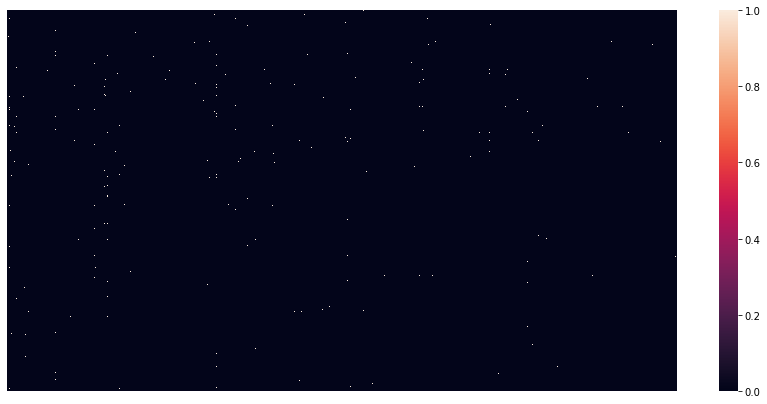

In [85]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Lymph node"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [302]:
list_counts_nontspec_Lymph_node = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Lymph node"]==1,GO].sum()
    list_counts_nontspec_Lymph_node.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Lymph node"]==1,GO].sum()
    list_counts_nontspec_Lymph_node.append(count)
counts_taspec["count_Lymph_node"] = list_counts_nontspec_Lymph_node
counts_taspec["percentage a/w_Lymph_node_taspec"] = counts_taspec["count_Lymph_node"]*100/proteins_taspec_sites[proteins_taspec_sites["Lymph node"]==1].shape[0]
counts_taspec.sort_values("count_Lymph_node", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005886             610.0              22.752704        413.0   
GO:0016020             582.0              21.708318        405.0   
GO:0003723             538.0              20.067139        405.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005524             381.0              14.211115        280.0   
GO:0046872             317.0              11.823946        238.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0005634                    44.133192                  73.0   
GO:0005654                    41.331924                  26.0   
GO:0005737                    38.900634                  91.0   
GO:0005886                    21.828753                  42.0   
GO:0016020                    21.405920                  52.0   
GO:0003723                    21.405920                  43.0   
GO:0070062                    17.071882                  89.0   
GO:0005524                    14.799154                  26.0   
GO:0046872                    12.579281                  18.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0005634                             44.512195           33.0   
GO:0005654                             15.853659           34.0   
GO:0005737                             55.487805           33.0   
GO:0005886                             25.609756           27.0   
GO:0016020                             31.707317           17.0   
GO:0003723                             26.219512           14.0   
GO:0070062                             54.268293           12.0   
GO:0005524                             15.853659           11.0   
GO:0046872                             10.975610           10.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005654               43.589744        626.0                    44.971264   
GO:0005737               42.307692        496.0                    35.632184   
GO:0005886               34.615385        268.0                    19.252874   
GO:0016020               21.794872        307.0                    22.054598   
GO:0003723               17.948718        318.0                    22.844828   
GO:0070062               15.384615        218.0                    15.660920   
GO:0005524               14.102564        189.0                    13.577586   
GO:0046872               12.820513        183.0                    13.146552   

            count_Brain  percentage a/w_Brain_taspec  count_Kidney  \
GO_term                                                              
GO:0005829         65.0                    44.827586         106.0   
GO:0005634         46.0                    31.724138          74.0   
GO:0005654         29.0                    20.000000          55.0   
GO:0005737         65.0                    44.827586          81.0   
GO:0005886         54.0                    37.241379          63.0   
GO:0016020         28.0                    19.310345          53.0   
GO:0003723         18.0                    12.413793          43.0   
GO:0070062        

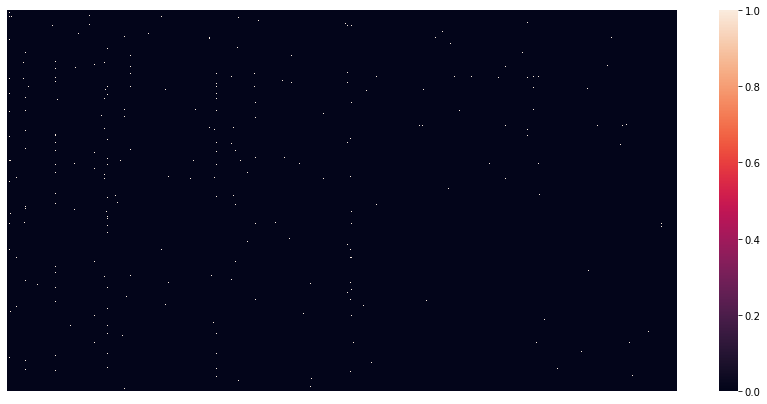

In [86]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Lymph node"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [376]:
list_counts_gen_Lymph_node = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Lymph node"]==1,GO].sum()
    list_counts_gen_Lymph_node.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Lymph node"]==1,GO].sum()
    list_counts_gen_Lymph_node.append(count)
counts_gen["count_Lymph_node"] = list_counts_gen_Lymph_node
counts_gen["percentage a/w_Lymph_node_pervasivelyP"] = counts_gen["count_Lymph_node"]*100/proteins_genP_sites[proteins_genP_sites["Lymph node"]==1].shape[0]
counts_gen.sort_values("count_Lymph_node", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005524                   188.0                    13.925926        124.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005634                          44.917258                 102.0   
GO:0005737                          44.326241                 136.0   
GO:0005654                          38.416076                  58.0   
GO:0003723                          28.368794                  68.0   
GO:0005886                          25.177305                  70.0   
GO:0016020                          25.650118                  68.0   
GO:0070062                          25.413712                 100.0   
GO:0042802                          15.957447                  38.0   
GO:0005524                          14.657210                  36.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005634                                   44.541485           95.0   
GO:0005737                                   59.388646           62.0   
GO:0005654                                   25.327511           82.0   
GO:0003723                                   29.694323           75.0   
GO:0005886                                   30.567686           42.0   
GO:0016020                                   29.694323           38.0   
GO:0070062                                   43.668122           39.0   
GO:0042802                                   16.593886           20.0   
GO:0005524                                   15.720524           31.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005634                            56.886228        452.0   
GO:0005737                            37.125749        483.0   
GO:0005654                            49.101796        351.0   
GO:0003723                            44.910180        235.0   
GO:0005886                            25.149701        370.0   
GO:0016020                            22.754491        266.0   
GO:0070062                            23.353293        279.0   
GO:0042802                            11.976048        180.0   
GO:0005524                            18.562874        175.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Cerebrospinal_fluid  \
GO_term                                        ...                              
GO:0005829                          47.463175  ...                      420.0   
GO:0005634                          36.988543  ...                      261.0   
GO:0005737                          39.525368  ...                      344.0   
GO:0005654                          28.723404  ...                      156.0   
GO:0003723                          19.230769  ...                

In [308]:
list_all_Lymph_node = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_Lymph_node = pd.concat(list_all_Lymph_node, axis=1)
all_Lymph_node[(((all_Lymph_node["percentage a/w_Lymph_node_tspec"]>=7)&(all_Lymph_node["percentage a/w tspec"]<=7))|
           ((all_Lymph_node["percentage a/w_Lymph_node_taspec"]>=7)&(all_Lymph_node["percentage a/w taspec"]<=7))|
         ((all_Lymph_node["percentage a/w_Lymph_node_pervasivelyP"]>=7)&((all_Lymph_node["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0000122            273.0              5.601149        163.0   
GO:0003677            366.0              7.509233        205.0   
GO:0005794            327.0              6.709069        143.0   
GO:0005856            214.0              4.390644         85.0   
GO:0006357            359.0              7.365613        203.0   
GO:0007165            319.0              6.544932        150.0   
GO:0016607            210.0              4.308576        115.0   
GO:0043231            313.0              6.421830        151.0   
GO:0045944            346.0              7.098892        184.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0000122                    7.449726            2.0   
GO:0003677                    9.369287            1.0   
GO:0005794                    6.535649            2.0   
GO:0005856                    3.884826            1.0   
GO:0006357                    9.277879            3.0   
GO:0007165                    6.855576            1.0   
GO:0016607                    5.255941            2.0   
GO:0043231                    6.901280            1.0   
GO:0045944                    8.409506            3.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0000122                         12.50         70.0   
GO:0003677                          6.25        112.0   
GO:0005794                         12.50         70.0   
GO:0005856                          6.25         31.0   
GO:0006357                         18.75         97.0   
GO:0007165                          6.25         52.0   
GO:0016607                         12.50         69.0   
GO:0043231                          6.25         67.0   
GO:0045944                         18.75        102.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0000122                    6.822612          1.0   
GO:0003677                   10.916179          7.0   
GO:0005794                    6.822612          6.0   
GO:0005856                    3.021442         10.0   
GO:0006357                    9.454191          6.0   
GO:0007165                    5.068226          4.0   
GO:0016607                    6.725146          4.0   
GO:0043231                    6.530214          5.0   
GO:0045944                    9.941520          4.0   

            percentage a/w_Brain_tspec  ...  count_Kidney  \
GO_term                                 ...                 
GO:0000122                         1.0  ...          24.0   
GO:0003677                         7.0  ...          31.0   
GO:0005794                         6.0  ...          25.0   
GO:0005856                        10.0  ...          34.0   
GO:0006357                         6.0  ...          17.0   
GO:0007165                         4.0  ...          35.0   
GO:0016607                         4.0  ...          25.0   
GO:0043231                         5.0  ...          29.0   
GO:0045944                         4.0  ...          29.0   

            percentage a/w_Kidney_pervasivelyP  count_Liver  \
GO_term                                                       
GO:0000122                            5.882353         48.0   
GO:0003677                            7.598039         62.0   
GO:0005794                            6.127451         83.0   
GO:0005856                            8.333333         80.0   
GO:0006357                            4.166667         41.0   
GO:0007165                            8.578431         96.0   
GO:0016607                            6.127451         50.0   
GO:0043231                            7.107843         74.0   
GO:0045944                            7.107843         58.0   

            percentage a/w_Liver_pervasivelyP  count_Lung

## Monocytes

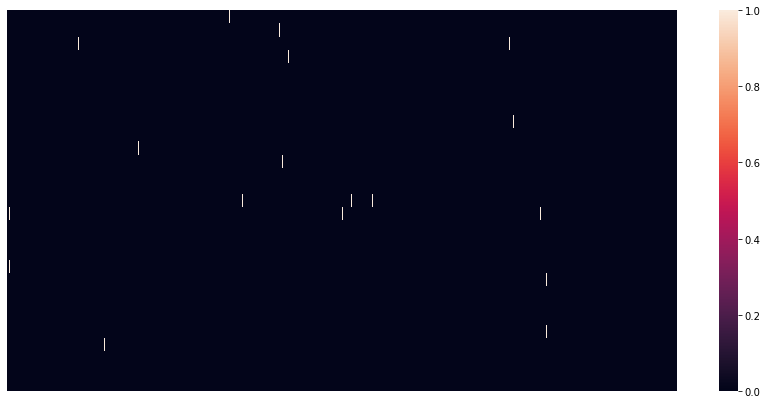

In [87]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Monocytes"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

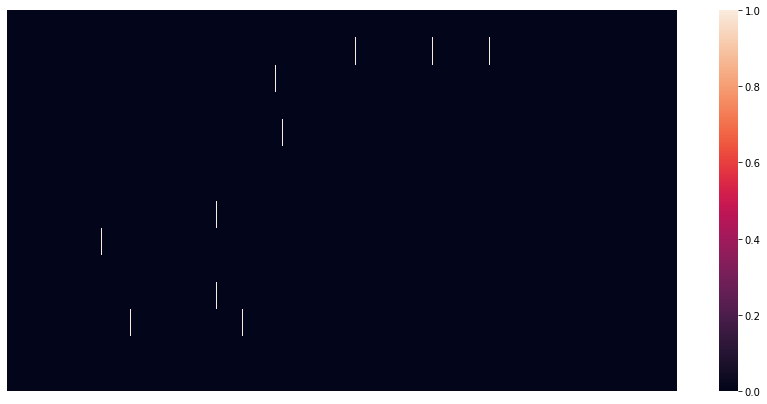

In [88]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Monocytes"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

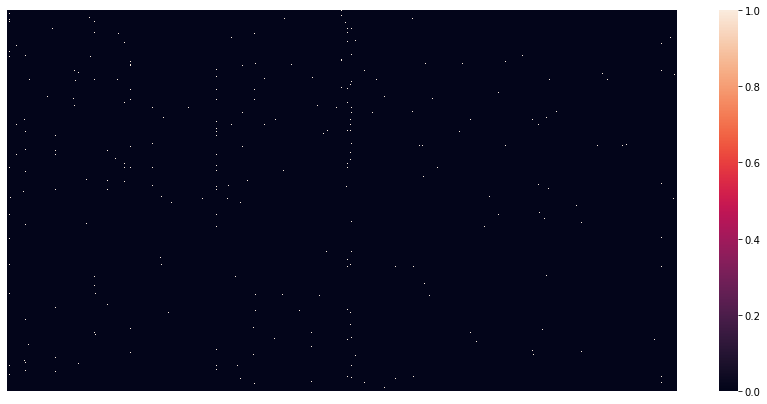

In [89]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Monocytes"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Nasal polyps

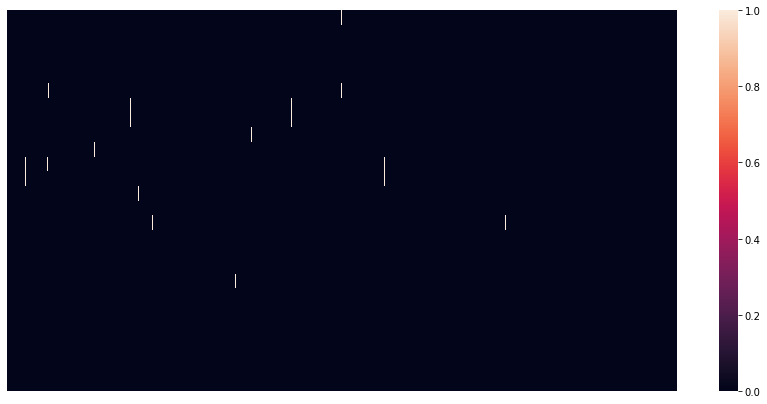

In [90]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Nasal polyps"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

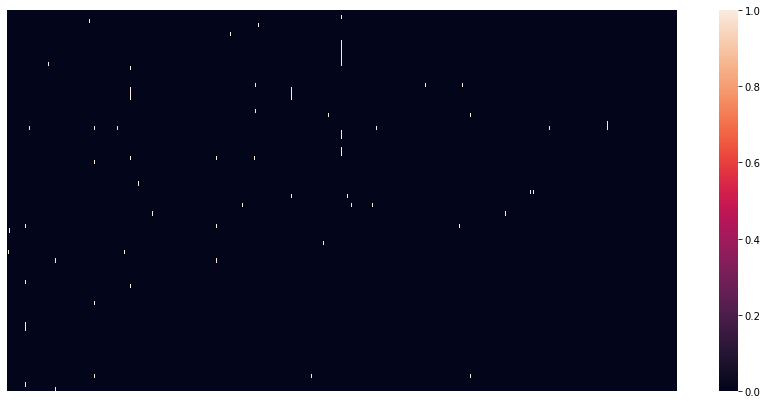

In [91]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Nasal polyps"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## NK-cells

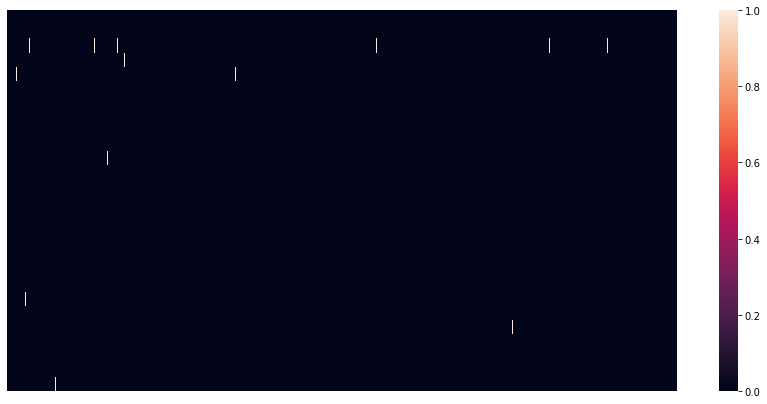

In [92]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["NK-cells"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

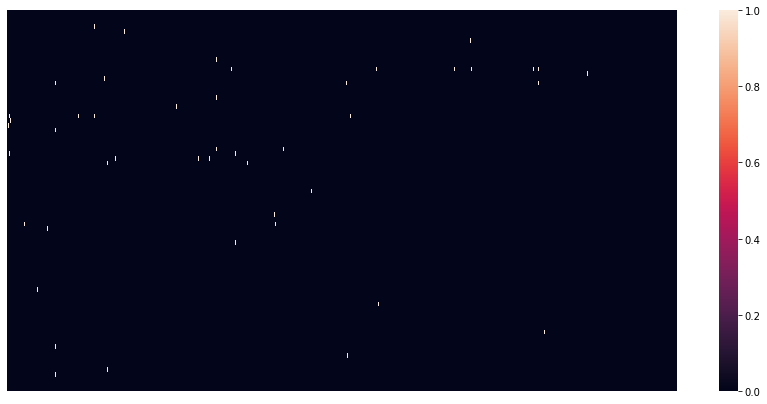

In [93]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["NK-cells"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

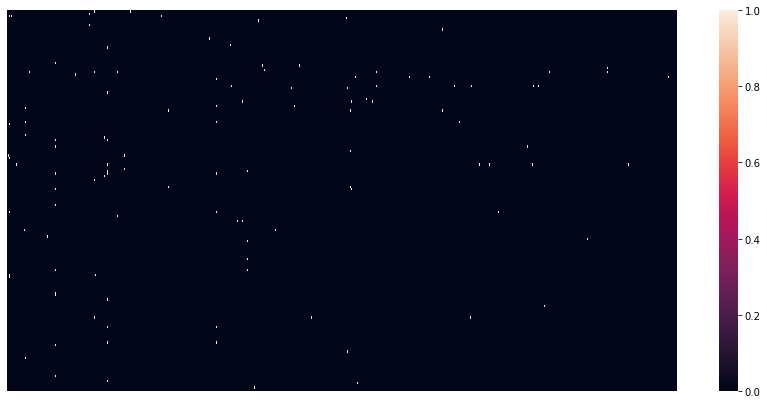

In [94]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["NK-cells"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [377]:
list_counts_gen_NK_cells = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["NK-cells"]==1,GO].sum()
    list_counts_gen_NK_cells.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["NK-cells"]==1,GO].sum()
    list_counts_gen_NK_cells.append(count)
counts_gen["count_NK-cells"] = list_counts_gen_NK_cells
counts_gen["percentage a/w_NK-cells_pervasivelyP"] = counts_gen["count_NK-cells"]*100/proteins_genP_sites[proteins_genP_sites["NK-cells"]==1].shape[0]
counts_gen.sort_values("count_NK-cells", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005634                   512.0                    37.925926        380.0   
GO:0005829                   657.0                    48.666667        448.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005730                    96.0                     7.111111         83.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005634                          44.917258                 102.0   
GO:0005829                          52.955083                 145.0   
GO:0005654                          38.416076                  58.0   
GO:0005737                          44.326241                 136.0   
GO:0003723                          28.368794                  68.0   
GO:0016020                          25.650118                  68.0   
GO:0070062                          25.413712                 100.0   
GO:0005886                          25.177305                  70.0   
GO:0042802                          15.957447                  38.0   
GO:0005730                           9.810875                  13.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005634                                   44.541485           95.0   
GO:0005829                                   63.318777           86.0   
GO:0005654                                   25.327511           82.0   
GO:0005737                                   59.388646           62.0   
GO:0003723                                   29.694323           75.0   
GO:0016020                                   29.694323           38.0   
GO:0070062                                   43.668122           39.0   
GO:0005886                                   30.567686           42.0   
GO:0042802                                   16.593886           20.0   
GO:0005730                                    5.676856           20.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005634                            56.886228        452.0   
GO:0005829                            51.497006        580.0   
GO:0005654                            49.101796        351.0   
GO:0005737                            37.125749        483.0   
GO:0003723                            44.910180        235.0   
GO:0016020                            22.754491        266.0   
GO:0070062                            23.353293        279.0   
GO:0005886                            25.149701        370.0   
GO:0042802                            11.976048        180.0   
GO:0005730                            11.976048         87.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Kidney  \
GO_term                                        ...                 
GO:0005634                          36.988543  ...         194.0   
GO:0005829                          47.463175  ...         239.0   
GO:0005654                          28.723404  ...         153.0   
GO:0005737                          39.525368  ...         185.0   
GO:0003723                          19.230769  ...         130.0   
GO:0016020                          21.767594  ...         104.0   
GO:00700

## Ovary

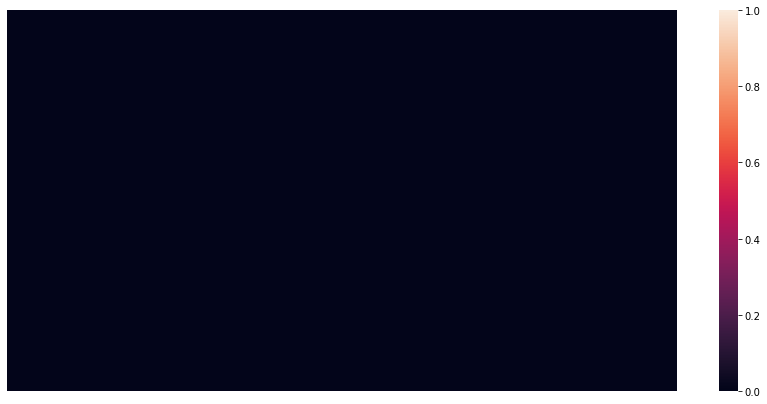

In [95]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Ovary"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

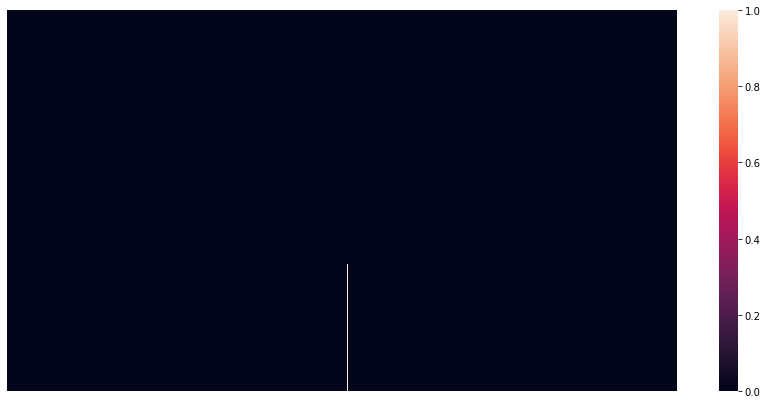

In [96]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Ovary"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

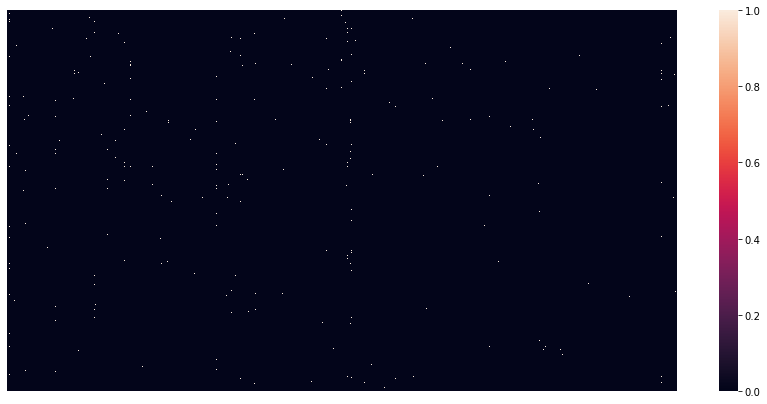

In [97]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Ovary"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [330]:
list_counts_gen_Ovary = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Ovary"]==1,GO].sum()
    list_counts_gen_Ovary.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Ovary"]==1,GO].sum()
    list_counts_gen_Ovary.append(count)
counts_gen["count_Ovary"] = list_counts_gen_Ovary
counts_gen["percentage a/w_Ovary_pervasivelyP"] = counts_gen["count_Ovary"]*100/proteins_genP_sites[proteins_genP_sites["Ovary"]==1].shape[0]
counts_gen.sort_values("count_Ovary", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0005524                   188.0                    13.925926        124.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0003723                   271.0                    20.074074        240.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005886                          25.177305                  70.0   
GO:0005634                          44.917258                 102.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0005654                          38.416076                  58.0   
GO:0005524                          14.657210                  36.0   
GO:0042802                          15.957447                  38.0   
GO:0003723                          28.368794                  68.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005886                                   30.567686           42.0   
GO:0005634                                   44.541485           95.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0005654                                   25.327511           82.0   
GO:0005524                                   15.720524           31.0   
GO:0042802                                   16.593886           20.0   
GO:0003723                                   29.694323           75.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005886                            25.149701        370.0   
GO:0005634                            56.886228        452.0   
GO:0070062                            23.353293        279.0   
GO:0016020                            22.754491        266.0   
GO:0005654                            49.101796        351.0   
GO:0005524                            18.562874        175.0   
GO:0042802                            11.976048        180.0   
GO:0003723                            44.910180        235.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Liver  \
GO_term                                        ...                
GO:0005829                          47.463175  ...        604.0   
GO:0005737                          39.525368  ...        483.0   
GO:0005886                          30.278232  ...        385.0   
GO:0005634                          36.988543  ...        437.0   
GO:0070062                          22.831424  ...        298.0   
GO:0016020                          21.767594  ...        266.0   
GO:0005654      

## Pancreas

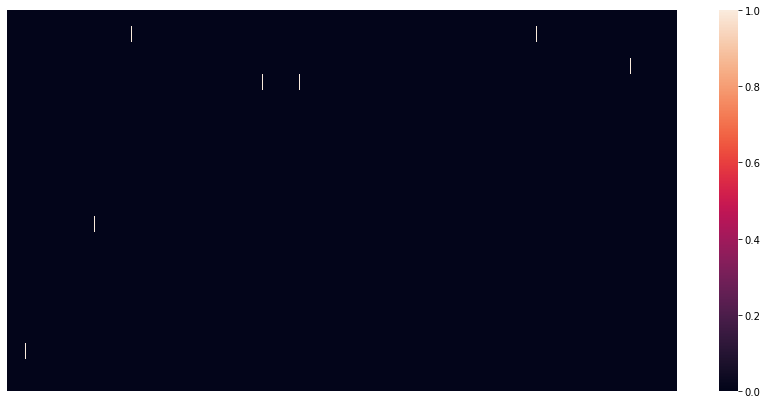

In [98]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Pancreas"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

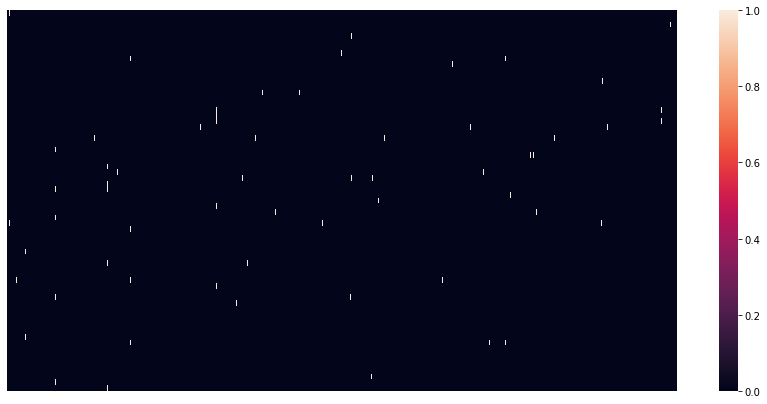

In [99]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Pancreas"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

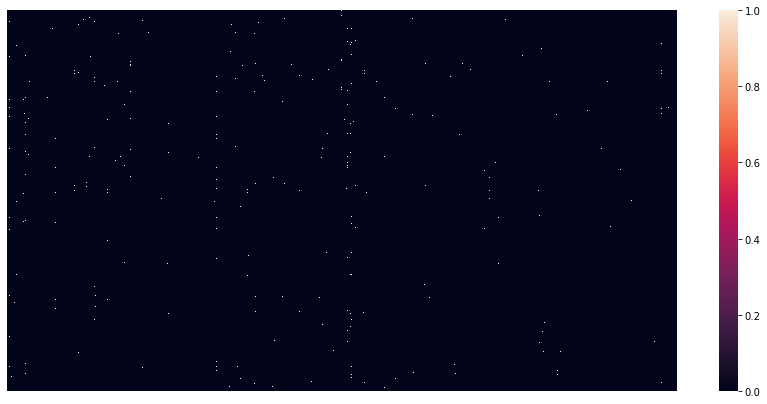

In [100]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Pancreas"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [378]:
list_counts_gen_Pancreas = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Pancreas"]==1,GO].sum()
    list_counts_gen_Pancreas.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Pancreas"]==1,GO].sum()
    list_counts_gen_Pancreas.append(count)
counts_gen["count_Pancreas"] = list_counts_gen_Pancreas
counts_gen["percentage a/w_Pancreas_pervasivelyP"] = counts_gen["count_Pancreas"]*100/proteins_genP_sites[proteins_genP_sites["Pancreas"]==1].shape[0]
counts_gen.sort_values("count_Pancreas", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005524                   188.0                    13.925926        124.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005886                          25.177305                  70.0   
GO:0005634                          44.917258                 102.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0005654                          38.416076                  58.0   
GO:0003723                          28.368794                  68.0   
GO:0042802                          15.957447                  38.0   
GO:0005524                          14.657210                  36.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005886                                   30.567686           42.0   
GO:0005634                                   44.541485           95.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0005654                                   25.327511           82.0   
GO:0003723                                   29.694323           75.0   
GO:0042802                                   16.593886           20.0   
GO:0005524                                   15.720524           31.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005886                            25.149701        370.0   
GO:0005634                            56.886228        452.0   
GO:0070062                            23.353293        279.0   
GO:0016020                            22.754491        266.0   
GO:0005654                            49.101796        351.0   
GO:0003723                            44.910180        235.0   
GO:0042802                            11.976048        180.0   
GO:0005524                            18.562874        175.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Liver  \
GO_term                                        ...                
GO:0005829                          47.463175  ...        604.0   
GO:0005737                          39.525368  ...        483.0   
GO:0005886                          30.278232  ...        385.0   
GO:0005634                          36.988543  ...        437.0   
GO:0070062                          22.831424  ...        298.0   
GO:0016020                          21.767594  ...        266.0   
GO:0005654      

## Palatine tonsils

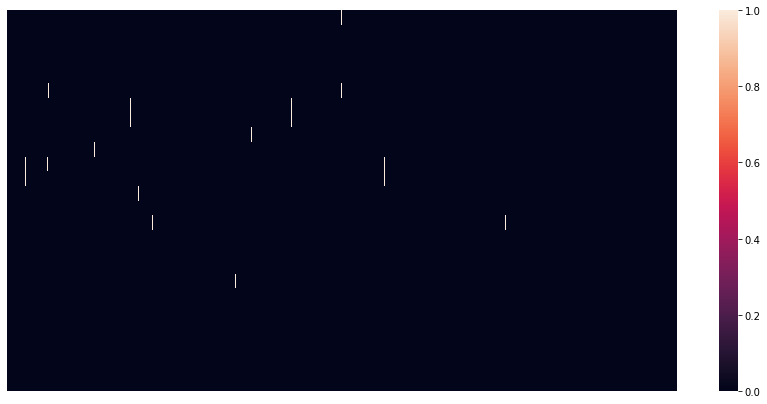

In [101]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Palatine tonsils"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

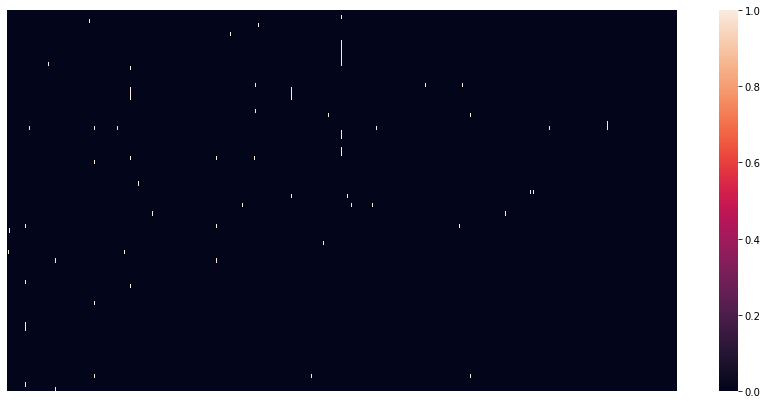

In [102]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Palatine tonsils"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## PBMC

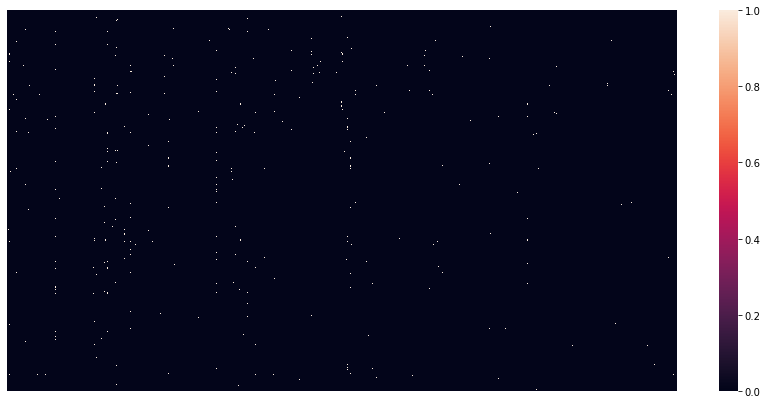

In [103]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["PBMC"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [333]:
list_counts_tspec_PBMC = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["PBMC"]==1,GO].sum()
    list_counts_tspec_PBMC.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["PBMC"]==1,GO].sum()
    list_counts_tspec_PBMC.append(count)
counts_tspec["count_PBMC"] = list_counts_tspec_PBMC
counts_tspec["percentage a/w_PBMC_tspec"] = counts_tspec["count_PBMC"]*100/(proteins_tspec_sites[proteins_tspec_sites["PBMC"]==1].shape[0])
counts_tspec.sort_values("count_PBMC", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005634           1884.0             38.654083        912.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0005829           2138.0             43.865408       1029.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0005576            433.0              8.883874         84.0   
GO:0005615            399.0              8.186295         76.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005634                   41.681901            7.0   
GO:0070062                   14.488117            3.0   
GO:0005829                   47.029250            6.0   
GO:0005737                   36.928702            4.0   
GO:0005654                   38.574040            6.0   
GO:0016020                   17.184644            2.0   
GO:0003723                   16.681901            2.0   
GO:0005886                   21.160878            5.0   
GO:0005576                    3.839122            1.0   
GO:0005615                    3.473492            1.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005634                         43.75        459.0   
GO:0070062                         18.75        167.0   
GO:0005829                         37.50        435.0   
GO:0005737                         25.00        329.0   
GO:0005654                         37.50        456.0   
GO:0016020                         12.50        187.0   
GO:0003723                         12.50        167.0   
GO:0005886                         31.25        194.0   
GO:0005576                          6.25        113.0   
GO:0005615                          6.25        102.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005634                   44.736842         40.0   
GO:0070062                   16.276803         34.0   
GO:0005829                   42.397661         50.0   
GO:0005737                   32.066277         52.0   
GO:0005654                   44.444444         18.0   
GO:0016020                   18.226121         16.0   
GO:0003723                   16.276803         15.0   
GO:0005886                   18.908382         33.0   
GO:0005576                   11.013645         10.0   
GO:0005615                    9.941520         12.0   

            percentage a/w_Brain_tspec  count_Liver  \
GO_term                                               
GO:0005634                        40.0         55.0   
GO:0070062                        34.0         67.0   
GO:0005829                        50.0         86.0   
GO:0005737                        52.0         63.0   
GO:0005654                        18.0         41.0   
GO:0016020                        16.0         44.0   
GO:0003723                        15.0         29.0   
GO:0005886                        33.0         48.0   
GO:0005576                        10.0         22.0   
GO:0005615                        12.0         23.0   

            percentage a/w_Liver_tspec  count_Lung  percentage a/w_Lung_tspec  \
GO_term                                                                         
GO:0005634                   33.132530       374.0                  40.963855   
GO:0070062                   40.361446       179.0                  19.605696   
GO:0005829                   51.807229       445.0                  48.740416   
GO:0005737                   37.951807       379.0                  41.511501   
GO:0005654                   24.698795   

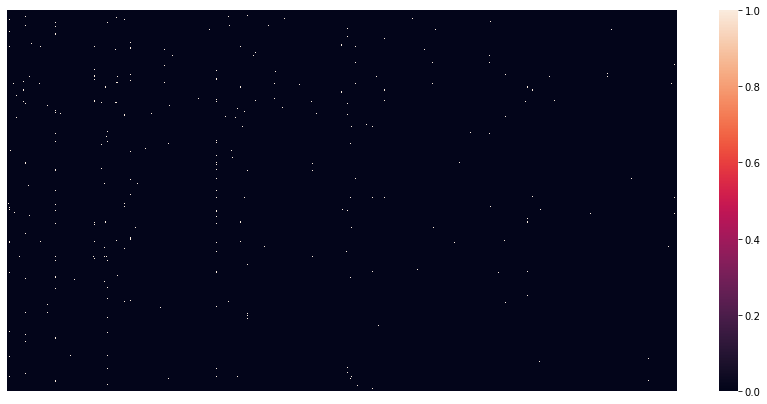

In [104]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["PBMC"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [343]:
list_counts_nontspec_PBMC = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["PBMC"]==1,GO].sum()
    list_counts_nontspec_PBMC.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["PBMC"]==1,GO].sum()
    list_counts_nontspec_PBMC.append(count)
counts_taspec["count_PBMC"] = list_counts_nontspec_PBMC
counts_taspec["percentage a/w_PBMC_taspec"] = counts_taspec["count_PBMC"]*100/proteins_taspec_sites[proteins_taspec_sites["PBMC"]==1].shape[0]
counts_taspec.sort_values("count_PBMC", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005654             964.0              35.956733        782.0   
GO:0016020             582.0              21.708318        405.0   
GO:0003723             538.0              20.067139        405.0   
GO:0005886             610.0              22.752704        413.0   
GO:0042802             350.0              13.054830        238.0   
GO:0005615             200.0               7.459903         71.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0070062                    17.071882                  89.0   
GO:0005634                    44.133192                  73.0   
GO:0005737                    38.900634                  91.0   
GO:0005654                    41.331924                  26.0   
GO:0016020                    21.405920                  52.0   
GO:0003723                    21.405920                  43.0   
GO:0005886                    21.828753                  42.0   
GO:0042802                    12.579281                  34.0   
GO:0005615                     3.752643                  28.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0070062                             54.268293           12.0   
GO:0005634                             44.512195           33.0   
GO:0005737                             55.487805           33.0   
GO:0005654                             15.853659           34.0   
GO:0016020                             31.707317           17.0   
GO:0003723                             26.219512           14.0   
GO:0005886                             25.609756           27.0   
GO:0042802                             20.731707           11.0   
GO:0005615                             17.073171            2.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0070062               15.384615        218.0                    15.660920   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005737               42.307692        496.0                    35.632184   
GO:0005654               43.589744        626.0                    44.971264   
GO:0016020               21.794872        307.0                    22.054598   
GO:0003723               17.948718        318.0                    22.844828   
GO:0005886               34.615385        268.0                    19.252874   
GO:0042802               14.102564        161.0                    11.566092   
GO:0005615                2.564103         77.0                     5.531609   

            ...  count_Kidney  percentage a/w_Kidney_taspec  count_Liver  \
GO_term     ...                                                            
GO:0005829  ...         106.0                     46.902655        257.0   
GO:0070062  ...          85.0                     37.610619        138.0   
GO:0005634  ...          74.0                     32.743363        207.0   
GO:0005737  ...          81.0                     35.840708        200.0   
GO:0005654  ...          55.0                     24.336283        175.0   
GO:0016020  ...          53.0                     23.451327        130.0   
GO:0003723  ...          43.0           

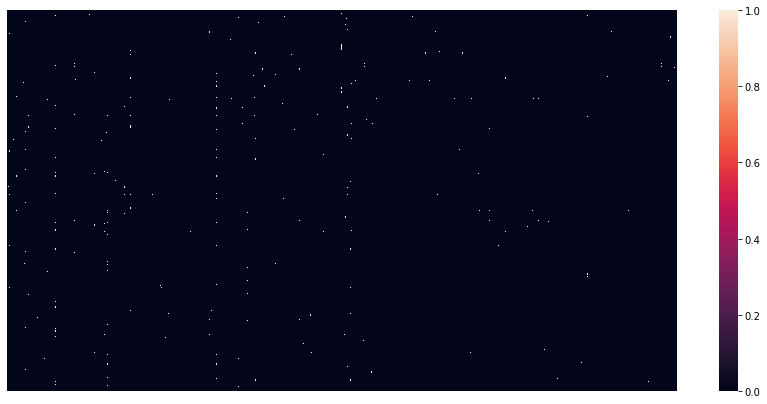

In [105]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["PBMC"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [379]:
list_counts_gen_PBMC = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["PBMC"]==1,GO].sum()
    list_counts_gen_PBMC.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["PBMC"]==1,GO].sum()
    list_counts_gen_PBMC.append(count)
counts_gen["count_PBMC"] = list_counts_gen_PBMC
counts_gen["percentage a/w_PBMC_pervasivelyP"] = counts_gen["count_PBMC"]*100/proteins_genP_sites[proteins_genP_sites["PBMC"]==1].shape[0]
counts_gen.sort_values("count_PBMC", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005634                   512.0                    37.925926        380.0   
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005615                   108.0                     8.000000         54.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005634                          44.917258                 102.0   
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0070062                          25.413712                 100.0   
GO:0005654                          38.416076                  58.0   
GO:0003723                          28.368794                  68.0   
GO:0016020                          25.650118                  68.0   
GO:0005886                          25.177305                  70.0   
GO:0042802                          15.957447                  38.0   
GO:0005615                           6.382979                  28.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005634                                   44.541485           95.0   
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0070062                                   43.668122           39.0   
GO:0005654                                   25.327511           82.0   
GO:0003723                                   29.694323           75.0   
GO:0016020                                   29.694323           38.0   
GO:0005886                                   30.567686           42.0   
GO:0042802                                   16.593886           20.0   
GO:0005615                                   12.227074            5.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005634                            56.886228        452.0   
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0070062                            23.353293        279.0   
GO:0005654                            49.101796        351.0   
GO:0003723                            44.910180        235.0   
GO:0016020                            22.754491        266.0   
GO:0005886                            25.149701        370.0   
GO:0042802                            11.976048        180.0   
GO:0005615                             2.994012         95.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Lung  \
GO_term                                        ...               
GO:0005634                          36.988543  ...       327.0   
GO:0005829                          47.463175  ...       361.0   
GO:0005737                          39.525368  ...       307.0   
GO:0070062                          22.831424  ...       165.0   
GO:0005654                          28.723404  ...       264.0   
GO:0003723                          19.230769  ...       191.0   
GO:0016020              

In [347]:
list_all_PBMC = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_PBMC = pd.concat(list_all_PBMC, axis=1)
all_PBMC[(((all_PBMC["percentage a/w_PBMC_tspec"]>=7)&(all_PBMC["percentage a/w tspec"]<=7))|
           ((all_PBMC["percentage a/w_PBMC_taspec"]>=7)&(all_PBMC["percentage a/w taspec"]<=7))|
         ((all_PBMC["percentage a/w_PBMC_pervasivelyP"]>=7)&((all_PBMC["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0000398            132.0              2.708248         72.0   
GO:0000786             51.0              1.046368          5.0   
GO:0003677            366.0              7.509233        205.0   
GO:0003779            165.0              3.385310         59.0   
GO:0003924             93.0              1.908084         36.0   
GO:0005200             71.0              1.456709         31.0   
GO:0005509            180.0              3.693065         59.0   
GO:0005525            115.0              2.359458         46.0   
GO:0005739            319.0              6.544932        117.0   
GO:0005856            214.0              4.390644         85.0   
GO:0005925            261.0              5.354945         98.0   
GO:0007165            319.0              6.544932        150.0   
GO:0009986            173.0              3.549446         53.0   
GO:0016032            249.0              5.108740        136.0   
GO:0016607            210.0              4.308576        115.0   
GO:0016887            115.0              2.359458         48.0   
GO:0031625            126.0              2.585146         51.0   
GO:0032991            311.0              6.380796        145.0   
GO:0034774             72.0              1.477226         17.0   
GO:0042803            221.0              4.534263        100.0   
GO:0043066            188.0              3.857201         78.0   
GO:0043312            224.0              4.595815         49.0   
GO:0045087            151.0              3.098071         59.0   
GO:0045296            217.0              4.452195        122.0   
GO:0045944            346.0              7.098892        184.0   
GO:0046982            132.0              2.708248         41.0   
GO:0051015            132.0              2.708248         58.0   
GO:0072562             96.0              1.969635         14.0   
GO:1904813             77.0              1.579811         21.0   
GO:1990904             94.0              1.928601         44.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0000398                    3.290676            0.0   
GO:0000786                    0.228519            0.0   
GO:0003677                    9.369287            1.0   
GO:0003779                    2.696527            0.0   
GO:0003924                    1.645338            0.0   
GO:0005200                    1.416819            0.0   
GO:0005509                    2.696527            0.0   
GO:0005525                    2.102377            0.0   
GO:0005739                    5.347349            1.0   
GO:0005856                    3.884826            1.0   
GO:0005925                    4.478976            1.0   
GO:0007165                    6.855576            1.0   
GO:0009986                    2.422303            1.0   
GO:0016032                    6.215722            0.0   
GO:0016607                    5.255941            2.0   
GO:0016887                    2.193784            0.0   
GO:0031625                    2.330896            0.0   
GO:0032991                    6.627057            2.0   
GO:0034774                    0.776965            0.0   
GO:0042803                    4.570384            1.0   
GO:0043066                    3.564899            1.0   
GO:0043312                    2.239488            0.0   
GO:0045087                    2.696527            0.0   
GO:0045296                    5.575868            1.0   
GO:0045944                    8.409506            3.0   
GO:0046982                    1.873857            1.0   
GO:0051015                    2.650823            0.0   
GO:0072562                    0.639854            0.0   
GO:1904813                    0.959781            0.0   
GO:1990904                    2.010969            0.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term          

## Placenta

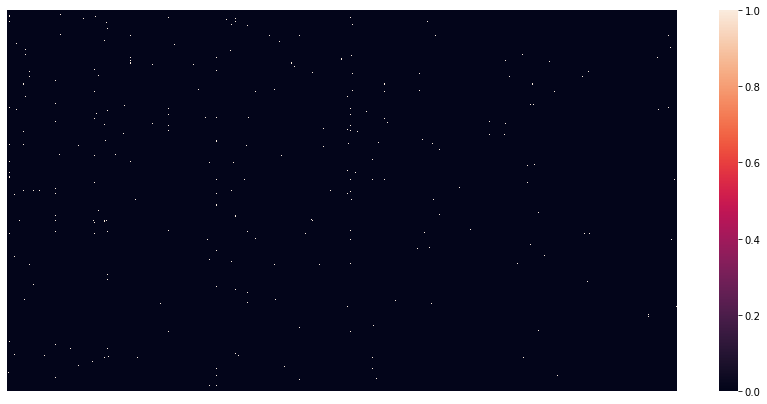

In [106]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Placenta"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [338]:
list_counts_tspec_Placenta = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Placenta"]==1,GO].sum()
    list_counts_tspec_Placenta.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Placenta"]==1,GO].sum()
    list_counts_tspec_Placenta.append(count)
counts_tspec["count_Placenta"] = list_counts_tspec_Placenta
counts_tspec["percentage a/w_Placenta_tspec"] = counts_tspec["count_Placenta"]*100/(proteins_tspec_sites[proteins_tspec_sites["Placenta"]==1].shape[0])
counts_tspec.sort_values("count_Placenta", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005829           2138.0             43.865408       1029.0   
GO:0005634           1884.0             38.654083        912.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0005576            433.0              8.883874         84.0   
GO:0005524            607.0             12.453837        272.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005829                   47.029250            6.0   
GO:0005634                   41.681901            7.0   
GO:0070062                   14.488117            3.0   
GO:0005737                   36.928702            4.0   
GO:0005654                   38.574040            6.0   
GO:0016020                   17.184644            2.0   
GO:0003723                   16.681901            2.0   
GO:0005886                   21.160878            5.0   
GO:0005576                    3.839122            1.0   
GO:0005524                   12.431444            1.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005829                         37.50        435.0   
GO:0005634                         43.75        459.0   
GO:0070062                         18.75        167.0   
GO:0005737                         25.00        329.0   
GO:0005654                         37.50        456.0   
GO:0016020                         12.50        187.0   
GO:0003723                         12.50        167.0   
GO:0005886                         31.25        194.0   
GO:0005576                          6.25        113.0   
GO:0005524                          6.25        122.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005829                   42.397661         50.0   
GO:0005634                   44.736842         40.0   
GO:0070062                   16.276803         34.0   
GO:0005737                   32.066277         52.0   
GO:0005654                   44.444444         18.0   
GO:0016020                   18.226121         16.0   
GO:0003723                   16.276803         15.0   
GO:0005886                   18.908382         33.0   
GO:0005576                   11.013645         10.0   
GO:0005524                   11.890838         11.0   

            percentage a/w_Brain_tspec  count_Liver  \
GO_term                                               
GO:0005829                        50.0         86.0   
GO:0005634                        40.0         55.0   
GO:0070062                        34.0         67.0   
GO:0005737                        52.0         63.0   
GO:0005654                        18.0         41.0   
GO:0016020                        16.0         44.0   
GO:0003723                        15.0         29.0   
GO:0005886                        33.0         48.0   
GO:0005576                        10.0         22.0   
GO:0005524                        11.0         19.0   

            percentage a/w_Liver_tspec  count_Lung  percentage a/w_Lung_tspec  \
GO_term                                                                         
GO:0005829                   51.807229       445.0                  48.740416   
GO:0005634                   33.132530       374.0                  40.963855   
GO:0070062                   40.361446       179.0                  19.605696   
GO:0005737                   37.951807       379.0                  41.511501   
GO:0005654                   24.698795   

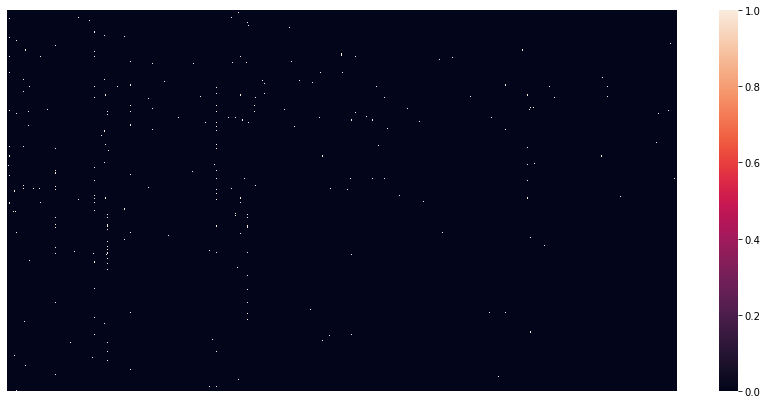

In [107]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Placenta"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [351]:
list_counts_nontspec_Placenta = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Placenta"]==1,GO].sum()
    list_counts_nontspec_Placenta.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Placenta"]==1,GO].sum()
    list_counts_nontspec_Placenta.append(count)
counts_taspec["count_Placenta"] = list_counts_nontspec_Placenta
counts_taspec["percentage a/w_Placenta_taspec"] = counts_taspec["count_Placenta"]*100/proteins_taspec_sites[proteins_taspec_sites["Placenta"]==1].shape[0]
counts_taspec.sort_values("count_Placenta", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005634            1123.0              41.887355        835.0   
GO:0005829            1306.0              48.713167        927.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0070062             603.0              22.491608        323.0   
GO:0003723             538.0              20.067139        405.0   
GO:0016020             582.0              21.708318        405.0   
GO:0005886             610.0              22.752704        413.0   
GO:0042802             350.0              13.054830        238.0   
GO:0005524             381.0              14.211115        280.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005634                    44.133192                  73.0   
GO:0005829                    48.995772                 117.0   
GO:0005654                    41.331924                  26.0   
GO:0005737                    38.900634                  91.0   
GO:0070062                    17.071882                  89.0   
GO:0003723                    21.405920                  43.0   
GO:0016020                    21.405920                  52.0   
GO:0005886                    21.828753                  42.0   
GO:0042802                    12.579281                  34.0   
GO:0005524                    14.799154                  26.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005634                             44.512195           33.0   
GO:0005829                             71.341463           38.0   
GO:0005654                             15.853659           34.0   
GO:0005737                             55.487805           33.0   
GO:0070062                             54.268293           12.0   
GO:0003723                             26.219512           14.0   
GO:0016020                             31.707317           17.0   
GO:0005886                             25.609756           27.0   
GO:0042802                             20.731707           11.0   
GO:0005524                             15.853659           11.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005634               42.307692        652.0                    46.839080   
GO:0005829               48.717949        630.0                    45.258621   
GO:0005654               43.589744        626.0                    44.971264   
GO:0005737               42.307692        496.0                    35.632184   
GO:0070062               15.384615        218.0                    15.660920   
GO:0003723               17.948718        318.0                    22.844828   
GO:0016020               21.794872        307.0                    22.054598   
GO:0005886               34.615385        268.0                    19.252874   
GO:0042802               14.102564        161.0                    11.566092   
GO:0005524               14.102564        189.0                    13.577586   

            ...  count_Liver  percentage a/w_Liver_taspec  count_Lung  \
GO_term     ...                                                         
GO:0005634  ...        207.0                    40.990099       493.0   
GO:0005829  ...        257.0                    50.891089       569.0   
GO:0005654  ...        175.0                    34.653465       439.0   
GO:0005737  ...        200.0                    39.603960       425.0   
GO:0070062  ...        138.0                    27.326733       206.0   
GO:0003723  ...        113.0                    22.376238       243.0   
GO:0016020  ...        130.0                    25.742574       

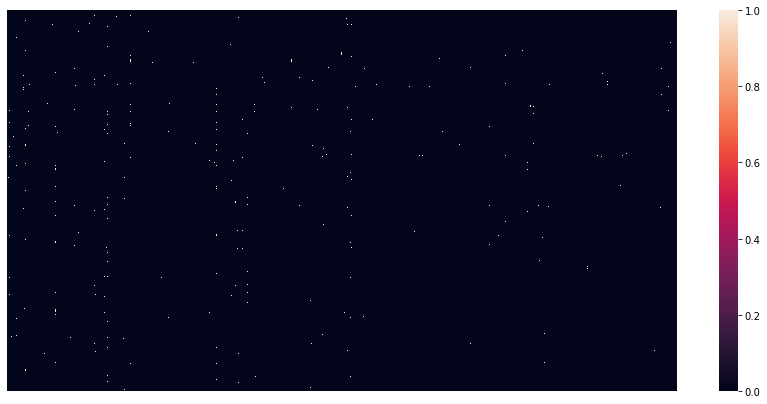

In [108]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Placenta"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [380]:
list_counts_gen_Placenta = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Placenta"]==1,GO].sum()
    list_counts_gen_Placenta.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Placenta"]==1,GO].sum()
    list_counts_gen_Placenta.append(count)
counts_gen["count_Placenta"] = list_counts_gen_Placenta
counts_gen["percentage a/w_Placenta_pervasivelyP"] = counts_gen["count_Placenta"]*100/proteins_genP_sites[proteins_genP_sites["Placenta"]==1].shape[0]
counts_gen.sort_values("count_Placenta", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005634                   512.0                    37.925926        380.0   
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0005524                   188.0                    13.925926        124.0   
GO:0042802                   203.0                    15.037037        135.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005634                          44.917258                 102.0   
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005654                          38.416076                  58.0   
GO:0003723                          28.368794                  68.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0005886                          25.177305                  70.0   
GO:0005524                          14.657210                  36.0   
GO:0042802                          15.957447                  38.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005634                                   44.541485           95.0   
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005654                                   25.327511           82.0   
GO:0003723                                   29.694323           75.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0005886                                   30.567686           42.0   
GO:0005524                                   15.720524           31.0   
GO:0042802                                   16.593886           20.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005634                            56.886228        452.0   
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005654                            49.101796        351.0   
GO:0003723                            44.910180        235.0   
GO:0070062                            23.353293        279.0   
GO:0016020                            22.754491        266.0   
GO:0005886                            25.149701        370.0   
GO:0005524                            18.562874        175.0   
GO:0042802                            11.976048        180.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Lymph_node  \
GO_term                                        ...                     
GO:0005634                          36.988543  ...             354.0   
GO:0005829                          47.463175  ...             394.0   
GO:0005737                          39.525368  ...             321.0   
GO:0005654                          28.723404  ...             295.0   
GO:0003723                          19.230769  ...             216.0   
GO:0070062                          22.831424  .

In [354]:
list_all_Placenta = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_Placenta = pd.concat(list_all_Placenta, axis=1)
all_Placenta[(((all_Placenta["percentage a/w_Placenta_tspec"]>=7)&(all_Placenta["percentage a/w tspec"]<=7))|
           ((all_Placenta["percentage a/w_Placenta_taspec"]>=7)&(all_Placenta["percentage a/w taspec"]<=7))|
         ((all_Placenta["percentage a/w_Placenta_pervasivelyP"]>=7)&((all_Placenta["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0000398            132.0              2.708248         72.0   
GO:0003677            366.0              7.509233        205.0   
GO:0005739            319.0              6.544932        117.0   
GO:0005783            266.0              5.457530         87.0   
GO:0005789            232.0              4.759951         82.0   
GO:0005794            327.0              6.709069        143.0   
GO:0005856            214.0              4.390644         85.0   
GO:0005925            261.0              5.354945         98.0   
GO:0016607            210.0              4.308576        115.0   
GO:0030198             81.0              1.661879         17.0   
GO:0032991            311.0              6.380796        145.0   
GO:0043231            313.0              6.421830        151.0   
GO:0043312            224.0              4.595815         49.0   
GO:0045296            217.0              4.452195        122.0   
GO:0048471            310.0              6.360279        162.0   
GO:0062023            139.0              2.851867         17.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0000398                    3.290676            0.0   
GO:0003677                    9.369287            1.0   
GO:0005739                    5.347349            1.0   
GO:0005783                    3.976234            0.0   
GO:0005789                    3.747715            2.0   
GO:0005794                    6.535649            2.0   
GO:0005856                    3.884826            1.0   
GO:0005925                    4.478976            1.0   
GO:0016607                    5.255941            2.0   
GO:0030198                    0.776965            0.0   
GO:0032991                    6.627057            2.0   
GO:0043231                    6.901280            1.0   
GO:0043312                    2.239488            0.0   
GO:0045296                    5.575868            1.0   
GO:0048471                    7.404022            1.0   
GO:0062023                    0.776965            0.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0000398                          0.00         25.0   
GO:0003677                          6.25        112.0   
GO:0005739                          6.25         44.0   
GO:0005783                          0.00         43.0   
GO:0005789                         12.50         35.0   
GO:0005794                         12.50         70.0   
GO:0005856                          6.25         31.0   
GO:0005925                          6.25         34.0   
GO:0016607                         12.50         69.0   
GO:0030198                          0.00         16.0   
GO:0032991                         12.50         78.0   
GO:0043231                          6.25         67.0   
GO:0043312                          0.00         36.0   
GO:0045296                          6.25         41.0   
GO:0048471                          6.25         46.0   
GO:0062023                          0.00         34.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0000398                    2.436647          2.0   
GO:0003677                   10.916179          7.0   
GO:0005739                    4.288499          7.0   
GO:0005783                    4.191033          1.0   
GO:0005789                    3.411306          2.0   
GO:0005794                    6.822612          6.0   
GO:0005856                    3.021442         10.0   
GO:0005925                    3.313840         11.0   
GO:0016607                    6.725146          4.0   
GO:0030198                    1.559454          1.0   
GO:0032991                    7.602339          9.0   
GO:0043231                    6.530214          5.0   

## Skeletal muscle

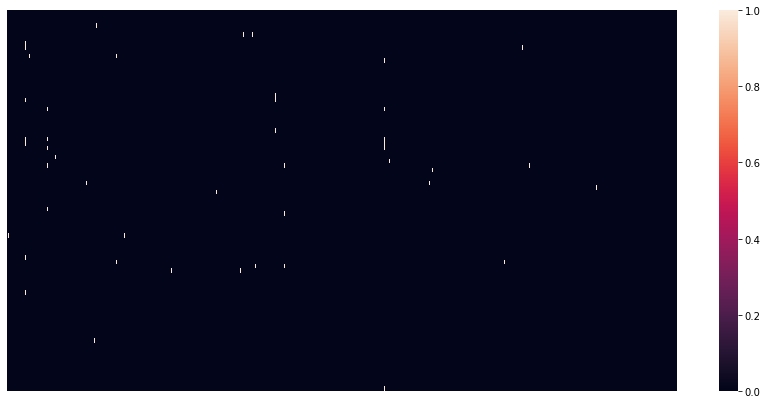

In [109]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Skeletal muscle"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

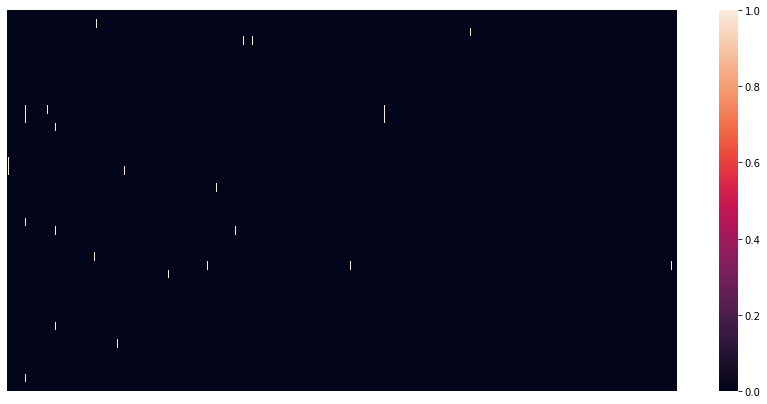

In [110]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Skeletal muscle"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

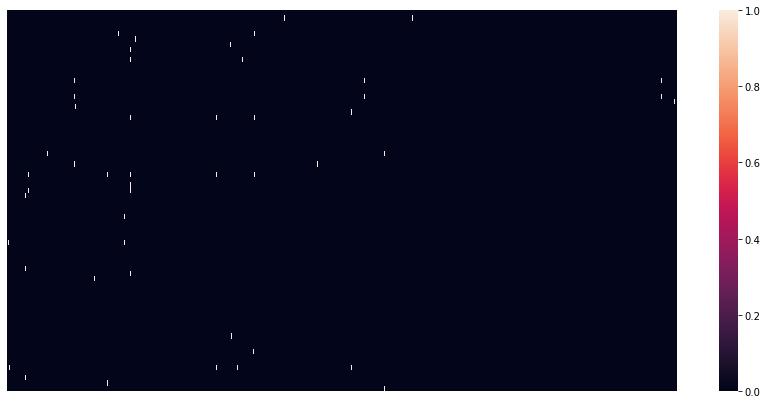

In [111]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Skeletal muscle"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Skin

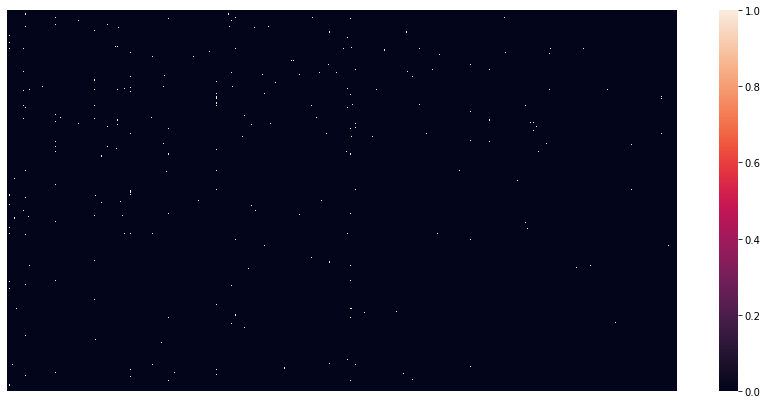

In [112]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Skin"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [345]:
list_counts_tspec_Skin = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Skin"]==1,GO].sum()
    list_counts_tspec_Skin.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Skin"]==1,GO].sum()
    list_counts_tspec_Skin.append(count)
counts_tspec["count_Skin"] = list_counts_tspec_Skin
counts_tspec["percentage a/w_Skin_tspec"] = counts_tspec["count_Skin"]*100/(proteins_tspec_sites[proteins_tspec_sites["Skin"]==1].shape[0])
counts_tspec.sort_values("count_Skin", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005829           2138.0             43.865408       1029.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0005634           1884.0             38.654083        912.0   
GO:0005737           1665.0             34.160854        808.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0005925            261.0              5.354945         98.0   
GO:0005576            433.0              8.883874         84.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005829                   47.029250            6.0   
GO:0070062                   14.488117            3.0   
GO:0005634                   41.681901            7.0   
GO:0005737                   36.928702            4.0   
GO:0016020                   17.184644            2.0   
GO:0003723                   16.681901            2.0   
GO:0005654                   38.574040            6.0   
GO:0005886                   21.160878            5.0   
GO:0005925                    4.478976            1.0   
GO:0005576                    3.839122            1.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005829                         37.50        435.0   
GO:0070062                         18.75        167.0   
GO:0005634                         43.75        459.0   
GO:0005737                         25.00        329.0   
GO:0016020                         12.50        187.0   
GO:0003723                         12.50        167.0   
GO:0005654                         37.50        456.0   
GO:0005886                         31.25        194.0   
GO:0005925                          6.25         34.0   
GO:0005576                          6.25        113.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005829                   42.397661         50.0   
GO:0070062                   16.276803         34.0   
GO:0005634                   44.736842         40.0   
GO:0005737                   32.066277         52.0   
GO:0016020                   18.226121         16.0   
GO:0003723                   16.276803         15.0   
GO:0005654                   44.444444         18.0   
GO:0005886                   18.908382         33.0   
GO:0005925                    3.313840         11.0   
GO:0005576                   11.013645         10.0   

            percentage a/w_Brain_tspec  ...  count_Lung  \
GO_term                                 ...               
GO:0005829                        50.0  ...       445.0   
GO:0070062                        34.0  ...       179.0   
GO:0005634                        40.0  ...       374.0   
GO:0005737                        52.0  ...       379.0   
GO:0016020                        16.0  ...       172.0   
GO:0003723                        15.0  ...       158.0   
GO:0005654                        18.0  ...       282.0   
GO:0005886                        33.0  ...       305.0   
GO:0005925                        11.0  ...        81.0   
GO:0005576                        10.0  ...        79.0   

            percentage a/w_Lung_tspec  count_Lymph_node  \
GO_term                                                   
GO:0005829                  48.740416             631.0   
GO:0070062                  19.605696             178.0   
GO:0005634                  40.963855             524.0   
GO:0005737                  41.511501             459.0   
GO:0016020                  18.838992             270.0   
GO:0003723                  17.305586             200.0   
GO:0005

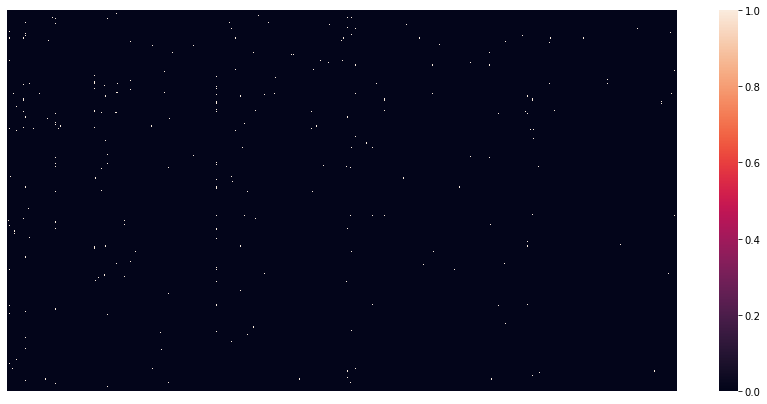

In [113]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Skin"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [362]:
list_counts_nontspec_Skin = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Skin"]==1,GO].sum()
    list_counts_nontspec_Skin.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Skin"]==1,GO].sum()
    list_counts_nontspec_Skin.append(count)
counts_taspec["count_Skin"] = list_counts_nontspec_Skin
counts_taspec["percentage a/w_Skin_taspec"] = counts_taspec["count_Skin"]*100/proteins_taspec_sites[proteins_taspec_sites["Skin"]==1].shape[0]
counts_taspec.sort_values("count_Skin", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0070062             603.0              22.491608        323.0   
GO:0005829            1306.0              48.713167        927.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0016020             582.0              21.708318        405.0   
GO:0003723             538.0              20.067139        405.0   
GO:0005886             610.0              22.752704        413.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005615             200.0               7.459903         71.0   
GO:0005925             185.0               6.900410        114.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0070062                    17.071882                  89.0   
GO:0005829                    48.995772                 117.0   
GO:0005634                    44.133192                  73.0   
GO:0005737                    38.900634                  91.0   
GO:0016020                    21.405920                  52.0   
GO:0003723                    21.405920                  43.0   
GO:0005886                    21.828753                  42.0   
GO:0005654                    41.331924                  26.0   
GO:0005615                     3.752643                  28.0   
GO:0005925                     6.025370                  40.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0070062                             54.268293           12.0   
GO:0005829                             71.341463           38.0   
GO:0005634                             44.512195           33.0   
GO:0005737                             55.487805           33.0   
GO:0016020                             31.707317           17.0   
GO:0003723                             26.219512           14.0   
GO:0005886                             25.609756           27.0   
GO:0005654                             15.853659           34.0   
GO:0005615                             17.073171            2.0   
GO:0005925                             24.390244            4.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0070062               15.384615        218.0                    15.660920   
GO:0005829               48.717949        630.0                    45.258621   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005737               42.307692        496.0                    35.632184   
GO:0016020               21.794872        307.0                    22.054598   
GO:0003723               17.948718        318.0                    22.844828   
GO:0005886               34.615385        268.0                    19.252874   
GO:0005654               43.589744        626.0                    44.971264   
GO:0005615                2.564103         77.0                     5.531609   
GO:0005925                5.128205         62.0                     4.454023   

            ...  count_Lung  percentage a/w_Lung_taspec  count_Lymph_node  \
GO_term     ...                                                             
GO:0070062  ...       206.0                   18.541854             239.0   
GO:0005829  ...       569.0                   51.215122             752.0   
GO:0005634  ...       493.0                   44.374437             663.0   
GO:0005737  ...       425.0                   38.253825             577.0   
GO:0016020  ...       241.0                   21.692169             326.0   
GO:0003723  ...       243.0                   21.872187             323.0   
GO:0005886  ...       261.0     

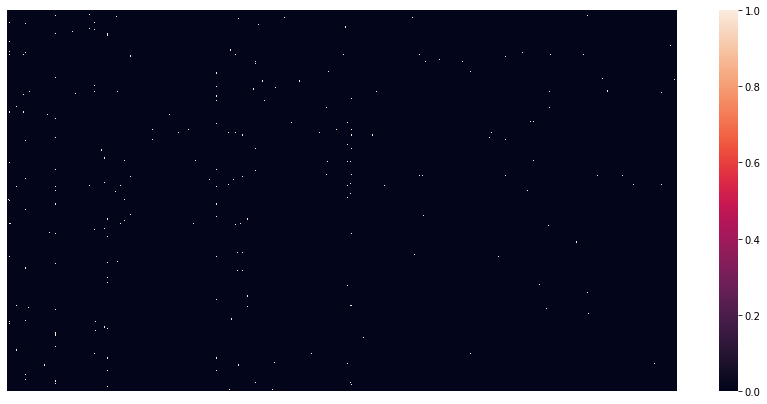

In [114]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Skin"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [381]:
list_counts_gen_Skin = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Skin"]==1,GO].sum()
    list_counts_gen_Skin.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Skin"]==1,GO].sum()
    list_counts_gen_Skin.append(count)
counts_gen["count_Skin"] = list_counts_gen_Skin
counts_gen["percentage a/w_Skin_pervasivelyP"] = counts_gen["count_Skin"]*100/proteins_genP_sites[proteins_genP_sites["Skin"]==1].shape[0]
counts_gen.sort_values("count_Skin", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005925                   106.0                     7.851852         91.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005634                          44.917258                 102.0   
GO:0005737                          44.326241                 136.0   
GO:0070062                          25.413712                 100.0   
GO:0003723                          28.368794                  68.0   
GO:0016020                          25.650118                  68.0   
GO:0005886                          25.177305                  70.0   
GO:0005654                          38.416076                  58.0   
GO:0042802                          15.957447                  38.0   
GO:0005925                          10.756501                  43.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005634                                   44.541485           95.0   
GO:0005737                                   59.388646           62.0   
GO:0070062                                   43.668122           39.0   
GO:0003723                                   29.694323           75.0   
GO:0016020                                   29.694323           38.0   
GO:0005886                                   30.567686           42.0   
GO:0005654                                   25.327511           82.0   
GO:0042802                                   16.593886           20.0   
GO:0005925                                   18.777293           16.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005634                            56.886228        452.0   
GO:0005737                            37.125749        483.0   
GO:0070062                            23.353293        279.0   
GO:0003723                            44.910180        235.0   
GO:0016020                            22.754491        266.0   
GO:0005886                            25.149701        370.0   
GO:0005654                            49.101796        351.0   
GO:0042802                            11.976048        180.0   
GO:0005925                             9.580838         88.0   

            percentage a/w_Blood_pervasivelyP  ...  count_NK-cells  \
GO_term                                        ...                   
GO:0005829                          47.463175  ...            81.0   
GO:0005634                          36.988543  ...            89.0   
GO:0005737                          39.525368  ...            71.0   
GO:0070062                          22.831424  ...            40.0   
GO:0003723                          19.230769  ...            68.0   
GO:0016020                          21.767594  ...            

In [365]:
list_all_Skin = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_Skin = pd.concat(list_all_Skin, axis=1)
all_Skin[(((all_Skin["percentage a/w_Skin_tspec"]>=7)&(all_Skin["percentage a/w tspec"]<=7))|
           ((all_Skin["percentage a/w_Skin_taspec"]>=7)&(all_Skin["percentage a/w taspec"]<=7))|
         ((all_Skin["percentage a/w_Skin_pervasivelyP"]>=7)&((all_Skin["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0000184             71.0              1.456709         23.0   
GO:0000226             76.0              1.559294         41.0   
GO:0000398            132.0              2.708248         72.0   
GO:0002181             51.0              1.046368          6.0   
GO:0003735             62.0              1.272056          9.0   
GO:0003779            165.0              3.385310         59.0   
GO:0003924             93.0              1.908084         36.0   
GO:0005200             71.0              1.456709         31.0   
GO:0005509            180.0              3.693065         59.0   
GO:0005525            115.0              2.359458         46.0   
GO:0005783            266.0              5.457530         87.0   
GO:0005788            106.0              2.174805         11.0   
GO:0005789            232.0              4.759951         82.0   
GO:0005856            214.0              4.390644         85.0   
GO:0005874            144.0              2.954452         76.0   
GO:0005925            261.0              5.354945         98.0   
GO:0006334             50.0              1.025851         12.0   
GO:0006364             91.0              1.867050         26.0   
GO:0006412             73.0              1.497743         13.0   
GO:0006413             68.0              1.395158         17.0   
GO:0006614             52.0              1.066886          7.0   
GO:0009986            173.0              3.549446         53.0   
GO:0015629            138.0              2.831350         69.0   
GO:0016032            249.0              5.108740        136.0   
GO:0016607            210.0              4.308576        115.0   
GO:0019083             67.0              1.374641         18.0   
GO:0019904            110.0              2.256873         53.0   
GO:0022626             45.0              0.923266          5.0   
GO:0031625            126.0              2.585146         51.0   
GO:0031982             74.0              1.518260         31.0   
GO:0032991            311.0              6.380796        145.0   
GO:0043066            188.0              3.857201         78.0   
GO:0043312            224.0              4.595815         49.0   
GO:0043687            113.0              2.318424         25.0   
GO:0045296            217.0              4.452195        122.0   
GO:0045944            346.0              7.098892        184.0   
GO:0048471            310.0              6.360279        162.0   
GO:0062023            139.0              2.851867         17.0   
GO:1904813             77.0              1.579811         21.0   
GO:1990904             94.0              1.928601         44.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0000184                    1.051188            0.0   
GO:0000226                    1.873857            0.0   
GO:0000398                    3.290676            0.0   
GO:0002181                    0.274223            0.0   
GO:0003735                    0.411335            0.0   
GO:0003779                    2.696527            0.0   
GO:0003924                    1.645338            0.0   
GO:0005200                    1.416819            0.0   
GO:0005509                    2.696527            0.0   
GO:0005525                    2.102377            0.0   
GO:0005783                    3.976234            0.0   
GO:0005788                    0.502742            1.0   
GO:0005789                    3.747715            2.0   
GO:0005856                    3.884826            1.0   
GO:0005874                    3.473492            1.0   
GO:0005925                    4.478976            1.0   
GO:0006334                    0.548446            0.0   
GO:0006364                    1.188300            0.0   
GO:0006412                    0.594150            0.0   
GO:0006413                    0.776965    

## Small intestine

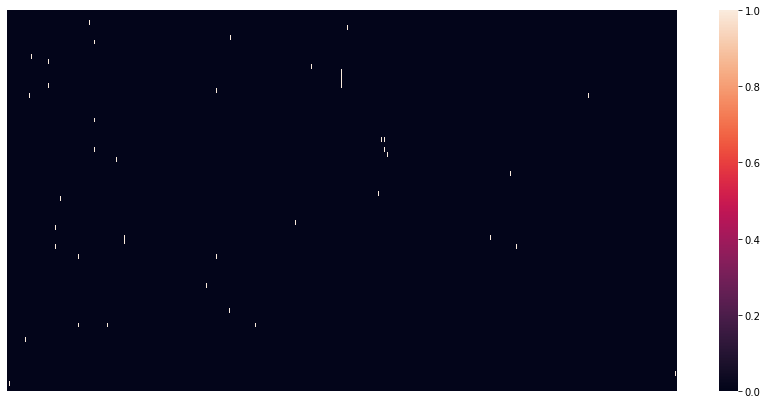

In [115]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Small intestine"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

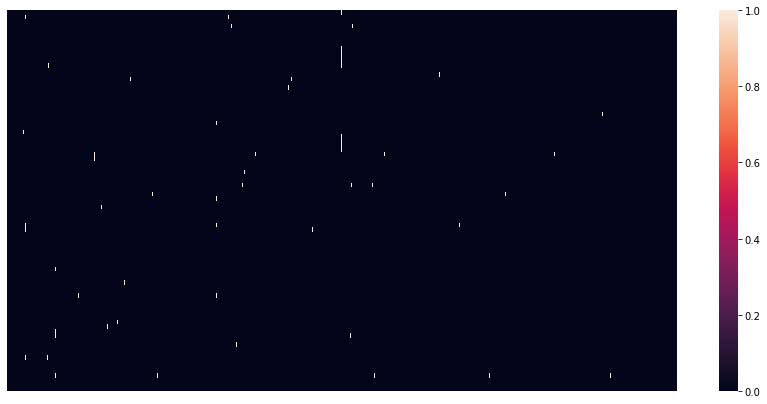

In [116]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Small intestine"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

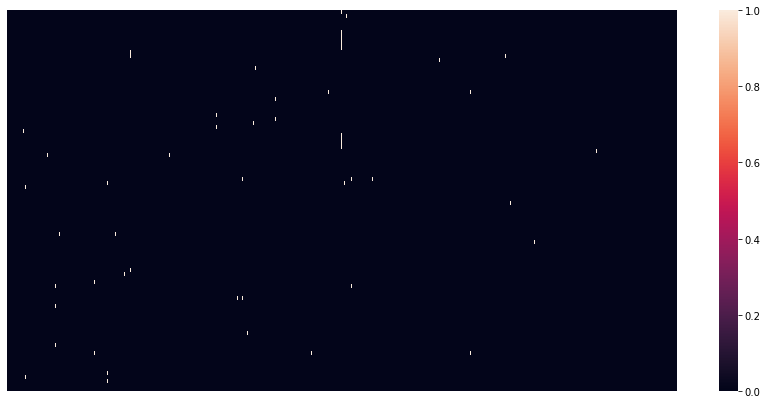

In [117]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Small intestine"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

## Testis

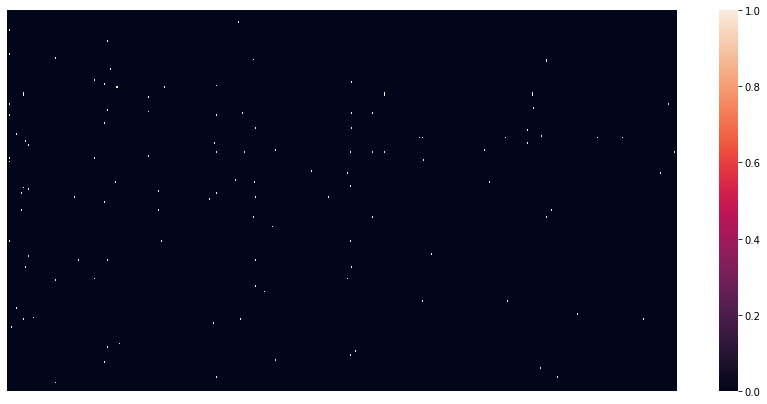

In [118]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Testis"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [352]:
list_counts_tspec_Testis = []

for GO in uni_list_GO:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Testis"]==1,GO].sum()
    list_counts_tspec_Testis.append(count)
for GO in uni_list_quick:
    count = proteins_tspec_sites.loc[proteins_tspec_sites["Testis"]==1,GO].sum()
    list_counts_tspec_Testis.append(count)
counts_tspec["count_Testis"] = list_counts_tspec_Testis
counts_tspec["percentage a/w_Testis_tspec"] = counts_tspec["count_Testis"]*100/(proteins_tspec_sites[proteins_tspec_sites["Testis"]==1].shape[0])
counts_tspec.sort_values("count_Testis", ascending=False).head(10)

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0005737           1665.0             34.160854        808.0   
GO:0005829           2138.0             43.865408       1029.0   
GO:0005634           1884.0             38.654083        912.0   
GO:0005654           1565.0             32.109151        844.0   
GO:0005886           1167.0             23.943373        463.0   
GO:0070062           1019.0             20.906853        317.0   
GO:0016020            907.0             18.608945        376.0   
GO:0003723            731.0             14.997948        365.0   
GO:0042802            580.0             11.899877        256.0   
GO:0005524            607.0             12.453837        272.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0005737                   36.928702            4.0   
GO:0005829                   47.029250            6.0   
GO:0005634                   41.681901            7.0   
GO:0005654                   38.574040            6.0   
GO:0005886                   21.160878            5.0   
GO:0070062                   14.488117            3.0   
GO:0016020                   17.184644            2.0   
GO:0003723                   16.681901            2.0   
GO:0042802                   11.700183            3.0   
GO:0005524                   12.431444            1.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0005737                         25.00        329.0   
GO:0005829                         37.50        435.0   
GO:0005634                         43.75        459.0   
GO:0005654                         37.50        456.0   
GO:0005886                         31.25        194.0   
GO:0070062                         18.75        167.0   
GO:0016020                         12.50        187.0   
GO:0003723                         12.50        167.0   
GO:0042802                         18.75        103.0   
GO:0005524                          6.25        122.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0005737                   32.066277         52.0   
GO:0005829                   42.397661         50.0   
GO:0005634                   44.736842         40.0   
GO:0005654                   44.444444         18.0   
GO:0005886                   18.908382         33.0   
GO:0070062                   16.276803         34.0   
GO:0016020                   18.226121         16.0   
GO:0003723                   16.276803         15.0   
GO:0042802                   10.038986         15.0   
GO:0005524                   11.890838         11.0   

            percentage a/w_Brain_tspec  ...  count_Lymph_node  \
GO_term                                 ...                     
GO:0005737                        52.0  ...             459.0   
GO:0005829                        50.0  ...             631.0   
GO:0005634                        40.0  ...             524.0   
GO:0005654                        18.0  ...             466.0   
GO:0005886                        33.0  ...             375.0   
GO:0070062                        34.0  ...             178.0   
GO:0016020                        16.0  ...             270.0   
GO:0003723                        15.0  ...             200.0   
GO:0042802                        15.0  ...             151.0   
GO:0005524                        11.0  ...             142.0   

            percentage a/w_Lymph_node_tspec  count_PBMC  \
GO_term                                                   
GO:0005737                        33.260870       186.0   
GO:0005829                        45.724638       233.0   
GO:0005634                        37.971014       251.0   
GO:0005654                        33.768116       151.0   
GO:0005886                        27.173913       115

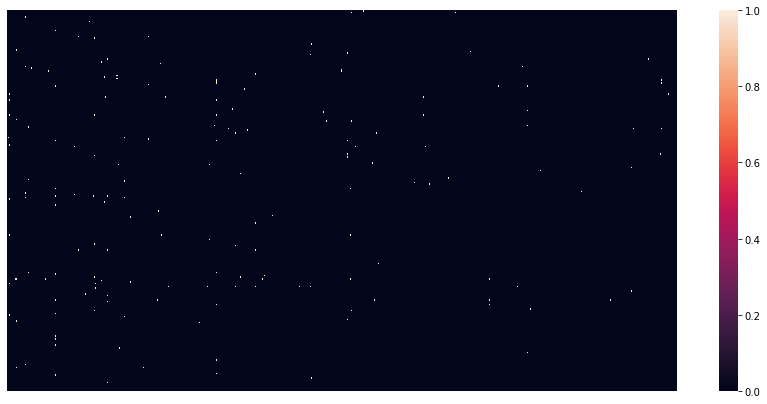

In [119]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Testis"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [373]:
list_counts_nontspec_Testis = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Testis"]==1,GO].sum()
    list_counts_nontspec_Testis.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Testis"]==1,GO].sum()
    list_counts_nontspec_Testis.append(count)
counts_taspec["count_Testis"] = list_counts_nontspec_Testis
counts_taspec["percentage a/w_Testis_taspec"] = counts_taspec["count_Testis"]*100/proteins_taspec_sites[proteins_taspec_sites["Testis"]==1].shape[0]
counts_taspec.sort_values("count_Testis", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005886             610.0              22.752704        413.0   
GO:0003723             538.0              20.067139        405.0   
GO:0016020             582.0              21.708318        405.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005524             381.0              14.211115        280.0   
GO:0042802             350.0              13.054830        238.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0005634                    44.133192                  73.0   
GO:0005737                    38.900634                  91.0   
GO:0005654                    41.331924                  26.0   
GO:0005886                    21.828753                  42.0   
GO:0003723                    21.405920                  43.0   
GO:0016020                    21.405920                  52.0   
GO:0070062                    17.071882                  89.0   
GO:0005524                    14.799154                  26.0   
GO:0042802                    12.579281                  34.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0005634                             44.512195           33.0   
GO:0005737                             55.487805           33.0   
GO:0005654                             15.853659           34.0   
GO:0005886                             25.609756           27.0   
GO:0003723                             26.219512           14.0   
GO:0016020                             31.707317           17.0   
GO:0070062                             54.268293           12.0   
GO:0005524                             15.853659           11.0   
GO:0042802                             20.731707           11.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005737               42.307692        496.0                    35.632184   
GO:0005654               43.589744        626.0                    44.971264   
GO:0005886               34.615385        268.0                    19.252874   
GO:0003723               17.948718        318.0                    22.844828   
GO:0016020               21.794872        307.0                    22.054598   
GO:0070062               15.384615        218.0                    15.660920   
GO:0005524               14.102564        189.0                    13.577586   
GO:0042802               14.102564        161.0                    11.566092   

            ...  count_Lymph_node  percentage a/w_Lymph_node_taspec  \
GO_term     ...                                                       
GO:0005829  ...             752.0                         48.767834   
GO:0005634  ...             663.0                         42.996109   
GO:0005737  ...             577.0                         37.418936   
GO:0005654  ...             603.0                         39.105058   
GO:0005886  ...             339.0                         21.984436   
GO:0003723  ...             323.0                         20.946822   
GO:0016020  ...             326.0                         21.141375   
GO:007006

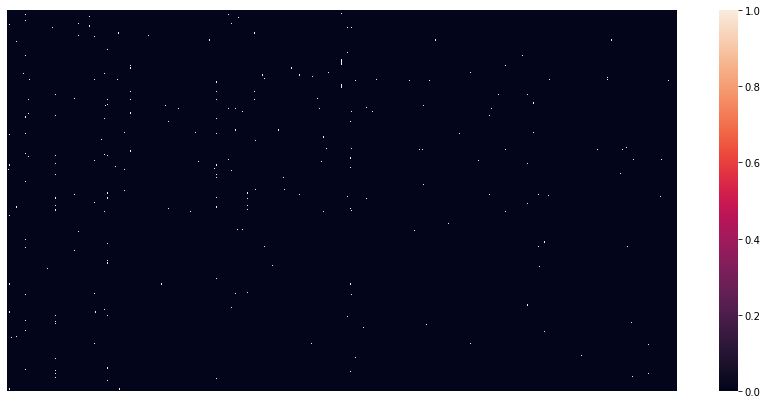

In [120]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Testis"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [382]:
list_counts_gen_Testis = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Testis"]==1,GO].sum()
    list_counts_gen_Testis.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Testis"]==1,GO].sum()
    list_counts_gen_Testis.append(count)
counts_gen["count_Testis"] = list_counts_gen_Testis
counts_gen["percentage a/w_Testis_pervasivelyP"] = counts_gen["count_Testis"]*100/proteins_genP_sites[proteins_genP_sites["Testis"]==1].shape[0]
counts_gen.sort_values("count_Testis", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005524                   188.0                    13.925926        124.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005634                          44.917258                 102.0   
GO:0005654                          38.416076                  58.0   
GO:0070062                          25.413712                 100.0   
GO:0005886                          25.177305                  70.0   
GO:0003723                          28.368794                  68.0   
GO:0016020                          25.650118                  68.0   
GO:0042802                          15.957447                  38.0   
GO:0005524                          14.657210                  36.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005634                                   44.541485           95.0   
GO:0005654                                   25.327511           82.0   
GO:0070062                                   43.668122           39.0   
GO:0005886                                   30.567686           42.0   
GO:0003723                                   29.694323           75.0   
GO:0016020                                   29.694323           38.0   
GO:0042802                                   16.593886           20.0   
GO:0005524                                   15.720524           31.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005634                            56.886228        452.0   
GO:0005654                            49.101796        351.0   
GO:0070062                            23.353293        279.0   
GO:0005886                            25.149701        370.0   
GO:0003723                            44.910180        235.0   
GO:0016020                            22.754491        266.0   
GO:0042802                            11.976048        180.0   
GO:0005524                            18.562874        175.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Pancreas  \
GO_term                                        ...                   
GO:0005829                          47.463175  ...           446.0   
GO:0005737                          39.525368  ...           373.0   
GO:0005634                          36.988543  ...           301.0   
GO:0005654                          28.723404  ...           184.0   
GO:0070062                          22.831424  ...           243.0   
GO:0005886                          30.278232  ...           3

In [376]:
list_all_Testis = [counts_tspec, counts_taspec, counts_gen, GO_annot_map_sub]
all_Testis = pd.concat(list_all_Testis, axis=1)
all_Testis[(((all_Testis["percentage a/w_Testis_tspec"]>=7)&(all_Testis["percentage a/w tspec"]<=7))|
           ((all_Testis["percentage a/w_Testis_taspec"]>=7)&(all_Testis["percentage a/w taspec"]<=7))|
         ((all_Testis["percentage a/w_Testis_pervasivelyP"]>=7)&((all_Testis["percentage a/w pervasivelyP"]<=7))))]

count_all_tspec  percentage a/w tspec  count_Colon  \
GO_term                                                          
GO:0003677            366.0              7.509233        205.0   
GO:0003779            165.0              3.385310         59.0   
GO:0005739            319.0              6.544932        117.0   
GO:0005794            327.0              6.709069        143.0   
GO:0005856            214.0              4.390644         85.0   
GO:0005925            261.0              5.354945         98.0   
GO:0007165            319.0              6.544932        150.0   
GO:0016032            249.0              5.108740        136.0   
GO:0016607            210.0              4.308576        115.0   
GO:0019901            239.0              4.903570        121.0   
GO:0043231            313.0              6.421830        151.0   
GO:0043312            224.0              4.595815         49.0   
GO:0045296            217.0              4.452195        122.0   
GO:0048471            310.0              6.360279        162.0   
GO:0106310            194.0              3.980304        106.0   
GO:0106311            194.0              3.980304        106.0   

            percentage a/w_Colon_tspec  count_B_cells  \
GO_term                                                 
GO:0003677                    9.369287            1.0   
GO:0003779                    2.696527            0.0   
GO:0005739                    5.347349            1.0   
GO:0005794                    6.535649            2.0   
GO:0005856                    3.884826            1.0   
GO:0005925                    4.478976            1.0   
GO:0007165                    6.855576            1.0   
GO:0016032                    6.215722            0.0   
GO:0016607                    5.255941            2.0   
GO:0019901                    5.530165            1.0   
GO:0043231                    6.901280            1.0   
GO:0043312                    2.239488            0.0   
GO:0045296                    5.575868            1.0   
GO:0048471                    7.404022            1.0   
GO:0106310                    4.844607            0.0   
GO:0106311                    4.844607            0.0   

            percentage a/w_B_cells_tspec  count_Blood  \
GO_term                                                 
GO:0003677                          6.25        112.0   
GO:0003779                          0.00         27.0   
GO:0005739                          6.25         44.0   
GO:0005794                         12.50         70.0   
GO:0005856                          6.25         31.0   
GO:0005925                          6.25         34.0   
GO:0007165                          6.25         52.0   
GO:0016032                          0.00         59.0   
GO:0016607                         12.50         69.0   
GO:0019901                          6.25         47.0   
GO:0043231                          6.25         67.0   
GO:0043312                          0.00         36.0   
GO:0045296                          6.25         41.0   
GO:0048471                          6.25         46.0   
GO:0106310                          0.00         53.0   
GO:0106311                          0.00         53.0   

            percentage a/w_Blood_tspec  count_Brain  \
GO_term                                               
GO:0003677                   10.916179          7.0   
GO:0003779                    2.631579         13.0   
GO:0005739                    4.288499          7.0   
GO:0005794                    6.822612          6.0   
GO:0005856                    3.021442         10.0   
GO:0005925                    3.313840         11.0   
GO:0007165                    5.068226          4.0   
GO:0016032                    5.750487          4.0   
GO:0016607                    6.725146          4.0   
GO:0019901                    4.580897          8.0   
GO:0043231                    6.530214          5.0   
GO:0043312                    3.508772          6.0   

## Umbilical cord

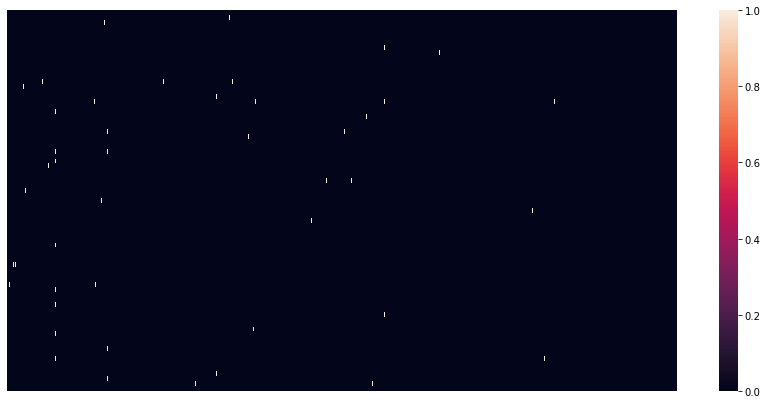

In [121]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Umbilical cord"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

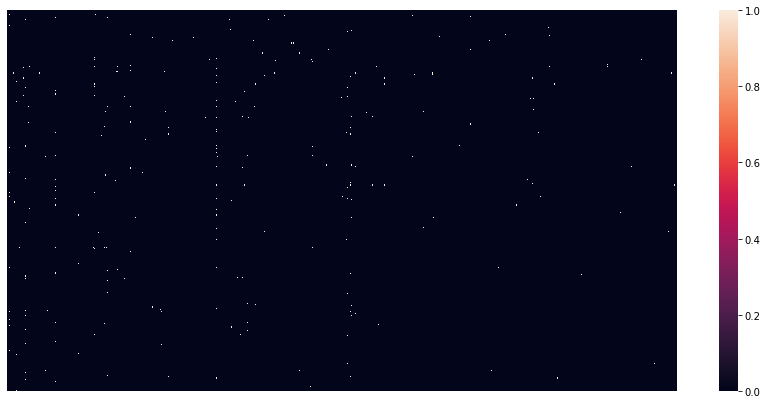

In [122]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Umbilical cord"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [387]:
list_counts_nontspec_Umbilical_cord = []
for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Umbilical cord"]==1,GO].sum()
    list_counts_nontspec_Umbilical_cord.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Umbilical cord"]==1,GO].sum()
    list_counts_nontspec_Umbilical_cord.append(count)
counts_taspec["count_Umbilical_cord"] = list_counts_nontspec_Umbilical_cord
counts_taspec["percentage a/w_Umbilical_cord_taspec"] = counts_taspec["count_Umbilical_cord"]*100/proteins_taspec_sites[proteins_taspec_sites["Umbilical cord"]==1].shape[0]
counts_taspec.sort_values("count_Umbilical_cord", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0070062             603.0              22.491608        323.0   
GO:0003723             538.0              20.067139        405.0   
GO:0016020             582.0              21.708318        405.0   
GO:0005886             610.0              22.752704        413.0   
GO:0005654             964.0              35.956733        782.0   
GO:0005925             185.0               6.900410        114.0   
GO:0042802             350.0              13.054830        238.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0005634                    44.133192                  73.0   
GO:0005737                    38.900634                  91.0   
GO:0070062                    17.071882                  89.0   
GO:0003723                    21.405920                  43.0   
GO:0016020                    21.405920                  52.0   
GO:0005886                    21.828753                  42.0   
GO:0005654                    41.331924                  26.0   
GO:0005925                     6.025370                  40.0   
GO:0042802                    12.579281                  34.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0005634                             44.512195           33.0   
GO:0005737                             55.487805           33.0   
GO:0070062                             54.268293           12.0   
GO:0003723                             26.219512           14.0   
GO:0016020                             31.707317           17.0   
GO:0005886                             25.609756           27.0   
GO:0005654                             15.853659           34.0   
GO:0005925                             24.390244            4.0   
GO:0042802                             20.731707           11.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005737               42.307692        496.0                    35.632184   
GO:0070062               15.384615        218.0                    15.660920   
GO:0003723               17.948718        318.0                    22.844828   
GO:0016020               21.794872        307.0                    22.054598   
GO:0005886               34.615385        268.0                    19.252874   
GO:0005654               43.589744        626.0                    44.971264   
GO:0005925                5.128205         62.0                     4.454023   
GO:0042802               14.102564        161.0                    11.566092   

            ...  count_PBMC  percentage a/w_PBMC_taspec  count_Placenta  \
GO_term     ...                                                           
GO:0005829  ...       229.0                       57.25           165.0   
GO:0005634  ...       213.0                       53.25           172.0   
GO:0005737  ...       194.0                       48.50           132.0   
GO:0070062  ...       217.0                       54.25           119.0   
GO:0003723  ...       130.0                       32.50           114.0   
GO:0016020  ...       133.0                       33.25           109.0   
GO:0005886  ...       101.0                     

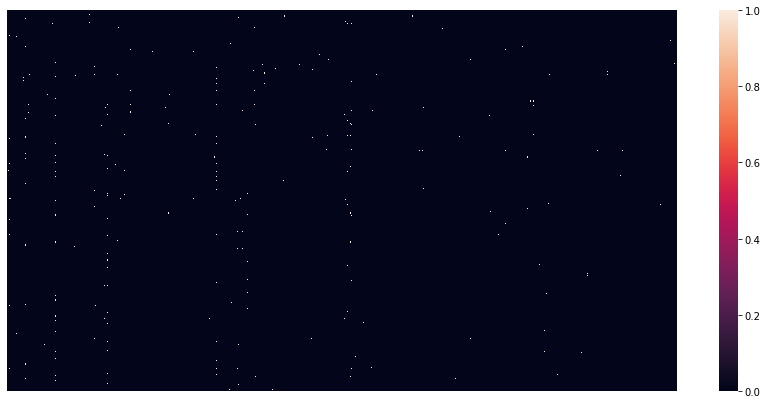

In [123]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Umbilical cord"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [385]:
list_counts_gen_Umbilical_cord = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Umbilical cord"]==1,GO].sum()
    list_counts_gen_Umbilical_cord.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Umbilical cord"]==1,GO].sum()
    list_counts_gen_Umbilical_cord.append(count)
counts_gen["count_Umbilical_cord"] = list_counts_gen_Umbilical_cord
counts_gen["percentage a/w_Umbilical_cord_pervasivelyP"] = counts_gen["count_Umbilical_cord"]*100/proteins_genP_sites[proteins_genP_sites["Umbilical cord"]==1].shape[0]
counts_gen.sort_values("count_Umbilical_cord", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0042802                   203.0                    15.037037        135.0   
GO:0005925                   106.0                     7.851852         91.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005737                          44.326241                 136.0   
GO:0005634                          44.917258                 102.0   
GO:0003723                          28.368794                  68.0   
GO:0005654                          38.416076                  58.0   
GO:0070062                          25.413712                 100.0   
GO:0016020                          25.650118                  68.0   
GO:0005886                          25.177305                  70.0   
GO:0042802                          15.957447                  38.0   
GO:0005925                          10.756501                  43.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005737                                   59.388646           62.0   
GO:0005634                                   44.541485           95.0   
GO:0003723                                   29.694323           75.0   
GO:0005654                                   25.327511           82.0   
GO:0070062                                   43.668122           39.0   
GO:0016020                                   29.694323           38.0   
GO:0005886                                   30.567686           42.0   
GO:0042802                                   16.593886           20.0   
GO:0005925                                   18.777293           16.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005737                            37.125749        483.0   
GO:0005634                            56.886228        452.0   
GO:0003723                            44.910180        235.0   
GO:0005654                            49.101796        351.0   
GO:0070062                            23.353293        279.0   
GO:0016020                            22.754491        266.0   
GO:0005886                            25.149701        370.0   
GO:0042802                            11.976048        180.0   
GO:0005925                             9.580838         88.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Placenta  \
GO_term                                        ...                   
GO:0005829                          47.463175  ...           220.0   
GO:0005737                          39.525368  ...           192.0   
GO:0005634                          36.988543  ...           225.0   
GO:0003723                          19.230769  ...           157.0   
GO:0005654                          28.723404  ...           181.0   
GO:0070062                          22.831424  ...           1

## Urinary bladder

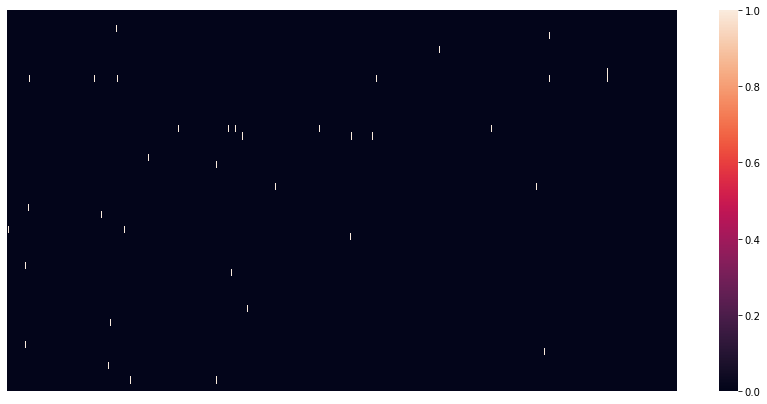

In [124]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Urinary bladder"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

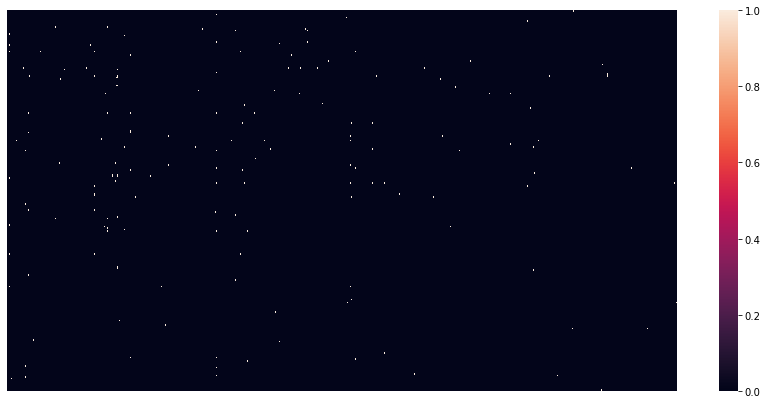

In [125]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Urinary bladder"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [392]:
list_counts_nontspec_Urinary_bladder = []

for GO in uni_list_GO:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Urinary bladder"]==1,GO].sum()
    list_counts_nontspec_Urinary_bladder.append(count)
for GO in uni_list_quick:
    count = proteins_taspec_sites.loc[proteins_taspec_sites["Urinary bladder"]==1,GO].sum()
    list_counts_nontspec_Urinary_bladder.append(count)
counts_taspec["count_Urinary_bladder"] = list_counts_nontspec_Urinary_bladder
counts_taspec["percentage a/w_Urinary_bladder_taspec"] = counts_taspec["count_Urinary_bladder"]*100/proteins_taspec_sites[proteins_taspec_sites["Urinary bladder"]==1].shape[0]
counts_taspec.sort_values("count_Urinary_bladder", ascending=False).head(10)

count_all_taspec  percentage a/w taspec  count_Colon  \
GO_term                                                            
GO:0005829            1306.0              48.713167        927.0   
GO:0070062             603.0              22.491608        323.0   
GO:0005737            1024.0              38.194703        736.0   
GO:0005634            1123.0              41.887355        835.0   
GO:0005654             964.0              35.956733        782.0   
GO:0016020             582.0              21.708318        405.0   
GO:0005886             610.0              22.752704        413.0   
GO:0003723             538.0              20.067139        405.0   
GO:0005524             381.0              14.211115        280.0   
GO:0005739             207.0               7.721000        142.0   

            percentage a/w_Colon_taspec  count_Adipose_tissue  \
GO_term                                                         
GO:0005829                    48.995772                 117.0   
GO:0070062                    17.071882                  89.0   
GO:0005737                    38.900634                  91.0   
GO:0005634                    44.133192                  73.0   
GO:0005654                    41.331924                  26.0   
GO:0016020                    21.405920                  52.0   
GO:0005886                    21.828753                  42.0   
GO:0003723                    21.405920                  43.0   
GO:0005524                    14.799154                  26.0   
GO:0005739                     7.505285                  14.0   

            percentage a/w_Adipose_tissue_taspec  count_B_cells  \
GO_term                                                           
GO:0005829                             71.341463           38.0   
GO:0070062                             54.268293           12.0   
GO:0005737                             55.487805           33.0   
GO:0005634                             44.512195           33.0   
GO:0005654                             15.853659           34.0   
GO:0016020                             31.707317           17.0   
GO:0005886                             25.609756           27.0   
GO:0003723                             26.219512           14.0   
GO:0005524                             15.853659           11.0   
GO:0005739                              8.536585            4.0   

            percentage a/w_B_cells  count_Blood  percentage a/w_Blood_taspec  \
GO_term                                                                        
GO:0005829               48.717949        630.0                    45.258621   
GO:0070062               15.384615        218.0                    15.660920   
GO:0005737               42.307692        496.0                    35.632184   
GO:0005634               42.307692        652.0                    46.839080   
GO:0005654               43.589744        626.0                    44.971264   
GO:0016020               21.794872        307.0                    22.054598   
GO:0005886               34.615385        268.0                    19.252874   
GO:0003723               17.948718        318.0                    22.844828   
GO:0005524               14.102564        189.0                    13.577586   
GO:0005739                5.128205         83.0                     5.962644   

            ...  count_Placenta  percentage a/w_Placenta_taspec  count_Skin  \
GO_term     ...                                                               
GO:0005829  ...           165.0                       45.961003       204.0   
GO:0070062  ...           119.0                       33.147632       212.0   
GO:0005737  ...           132.0                       36.768802       179.0   
GO:0005634  ...           172.0                       47.910864       185.0   
GO:0005654  ...           159.0                       44.289694        90.0   
GO:0016020  ...           109.0                       30.362117       114.0   
GO:0005886  ... 

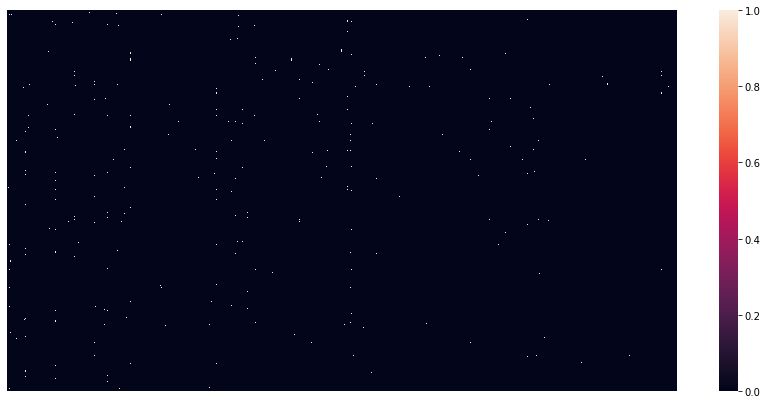

In [126]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Urinary bladder"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

In [384]:
list_counts_gen_Urinary_bladder = []

for GO in uni_list_GO:
    count = proteins_genP_sites.loc[proteins_genP_sites["Urinary bladder"]==1,GO].sum()
    list_counts_gen_Urinary_bladder.append(count)
for GO in uni_list_quick:
    count = proteins_genP_sites.loc[proteins_genP_sites["Urinary bladder"]==1,GO].sum()
    list_counts_gen_Urinary_bladder.append(count)
counts_gen["count_Urinary_bladder"] = list_counts_gen_Urinary_bladder
counts_gen["percentage a/w_Urinary_bladder_pervasivelyP"] = counts_gen["count_Urinary_bladder"]*100/proteins_genP_sites[proteins_genP_sites["Urinary bladder"]==1].shape[0]
counts_gen.sort_values("count_Urinary_bladder", ascending=False).head(10)

count_all_pervasivelyP  percentage a/w pervasivelyP  count_Colon  \
GO_term                                                                        
GO:0005829                   657.0                    48.666667        448.0   
GO:0005634                   512.0                    37.925926        380.0   
GO:0005737                   534.0                    39.555556        375.0   
GO:0070062                   325.0                    24.074074        215.0   
GO:0005654                   390.0                    28.888889        325.0   
GO:0005886                   405.0                    30.000000        213.0   
GO:0003723                   271.0                    20.074074        240.0   
GO:0016020                   300.0                    22.222222        217.0   
GO:0005524                   188.0                    13.925926        124.0   
GO:0005925                   106.0                     7.851852         91.0   

            percentage a/w_Colon_pervasivelyP  count_Adipose_tissue  \
GO_term                                                               
GO:0005829                          52.955083                 145.0   
GO:0005634                          44.917258                 102.0   
GO:0005737                          44.326241                 136.0   
GO:0070062                          25.413712                 100.0   
GO:0005654                          38.416076                  58.0   
GO:0005886                          25.177305                  70.0   
GO:0003723                          28.368794                  68.0   
GO:0016020                          25.650118                  68.0   
GO:0005524                          14.657210                  36.0   
GO:0005925                          10.756501                  43.0   

            percentage a/w_Adipose_tissue_pervasivelyP  count_B_cells  \
GO_term                                                                 
GO:0005829                                   63.318777           86.0   
GO:0005634                                   44.541485           95.0   
GO:0005737                                   59.388646           62.0   
GO:0070062                                   43.668122           39.0   
GO:0005654                                   25.327511           82.0   
GO:0005886                                   30.567686           42.0   
GO:0003723                                   29.694323           75.0   
GO:0016020                                   29.694323           38.0   
GO:0005524                                   15.720524           31.0   
GO:0005925                                   18.777293           16.0   

            percentage a/w_B_cells_pervasivelyP  count_Blood  \
GO_term                                                        
GO:0005829                            51.497006        580.0   
GO:0005634                            56.886228        452.0   
GO:0005737                            37.125749        483.0   
GO:0070062                            23.353293        279.0   
GO:0005654                            49.101796        351.0   
GO:0005886                            25.149701        370.0   
GO:0003723                            44.910180        235.0   
GO:0016020                            22.754491        266.0   
GO:0005524                            18.562874        175.0   
GO:0005925                             9.580838         88.0   

            percentage a/w_Blood_pervasivelyP  ...  count_Placenta  \
GO_term                                        ...                   
GO:0005829                          47.463175  ...           220.0   
GO:0005634                          36.988543  ...           225.0   
GO:0005737                          39.525368  ...           192.0   
GO:0070062                          22.831424  ...           138.0   
GO:0005654                          28.723404  ...           181.0   
GO:0005886                          30.278232  ...           1

## Urine

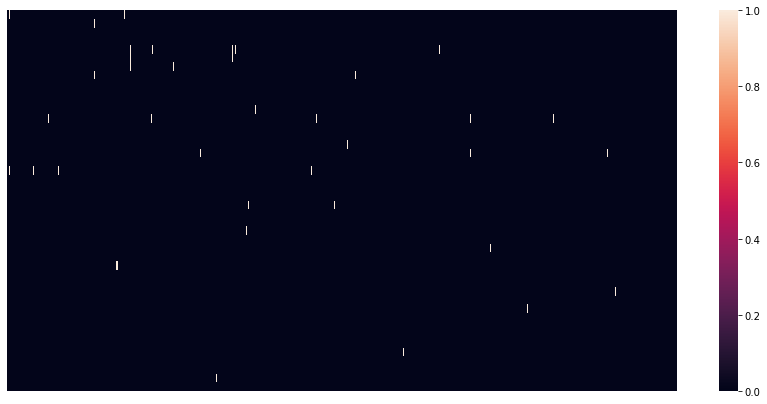

In [127]:
plt.figure(figsize=(15,7))
heatmap = proteins_tspec_sites[proteins_tspec_sites["Urine"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

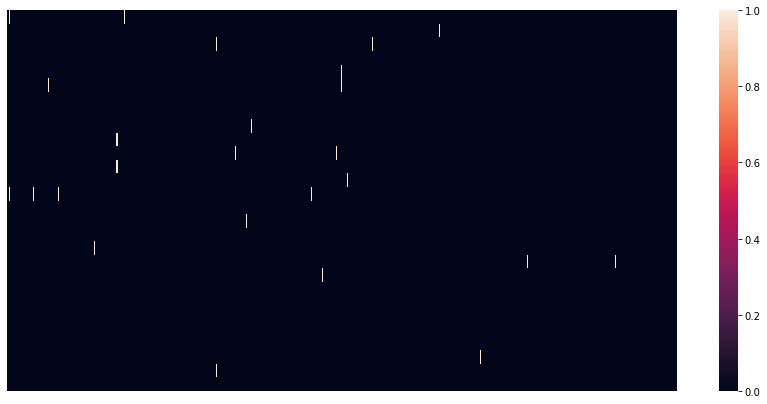

In [128]:
plt.figure(figsize=(15,7))
heatmap = proteins_taspec_sites[proteins_taspec_sites["Urine"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()

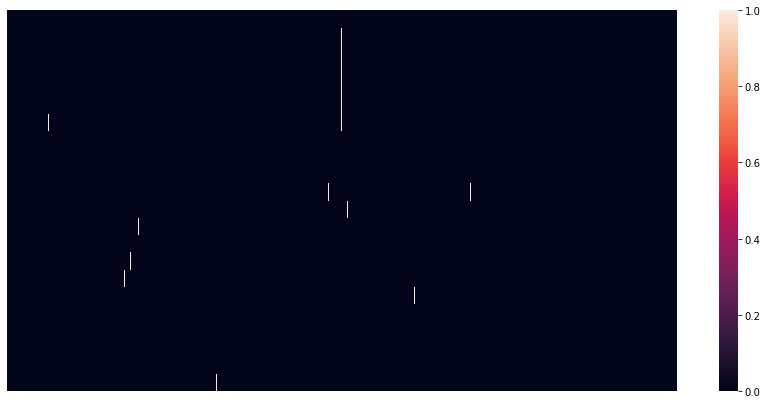

In [129]:
plt.figure(figsize=(15,7))
heatmap = proteins_genP_sites[proteins_genP_sites["Urine"]==1]
heatmap = heatmap[uni_list_all]
sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
plt.show()